In [6]:
import sys
sys.path.append("..")

import os.path
import json

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC
from kernel.sgld import SGLD
from kernel.sgd import SGD
from kernel.sgnuts import NUTS as SGNUTS

pyro.set_rng_seed(101)

plt.rcParams['figure.dpi'] = 300

In [7]:
# assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [8]:
RESULTS_DIR = os.path.join("results", "bnn")
RESULTS_SGHMC = os.path.join(RESULTS_DIR, "sghmc.json")
RESULTS_SGLD = os.path.join(RESULTS_DIR, "sgld.json")
RESULTS_SGD = os.path.join(RESULTS_DIR, "sgd.json")
RESULTS_SGDMOM = os.path.join(RESULTS_DIR, "sgdmom.json")

In [9]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### Hyperparams

These hyperparameters were fixed during the hyperparameter search. All other hyperparameters in this notebook are the best ones we found during the hyperparameter search.

In [10]:
BATCH_SIZE = 500
NUM_EPOCHS = 800
WARMUP_EPOCHS = 50
HIDDEN_SIZE = 100

### Download MNIST and setup datasets / dataloaders

In [11]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]
    
mean = 0.1307
std = 0.3081

# scale the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0
Y_val = train_dataset.targets[val_idx]

X_test = test_dataset.data / 255.0
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Define the Bayesian neural network  model

In [12]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1., device='cpu'):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting

        self.device = device
        
        # TODO add gamma priors to precision terms

        self.fc1 = PyroLinear(input_size, hidden_size)

        fc1_weight_loc = torch.zeros((hidden_size, input_size), device=self.device)
        fc1_weight_scale = torch.ones((hidden_size, input_size), device=self.device) * prec

        fc1_bias_loc = torch.zeros((hidden_size,), device=self.device)
        fc1_bias_scale = torch.ones((hidden_size,), device=self.device) * prec

        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(fc1_weight_loc, fc1_weight_scale).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(fc1_bias_loc, fc1_bias_scale).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)

        fc2_weight_loc = torch.zeros((output_size, hidden_size), device=self.device)
        fc2_weight_scale = torch.ones((output_size, hidden_size), device=self.device) * prec

        fc2_bias_loc = torch.zeros((output_size,), device=self.device)
        fc2_bias_scale = torch.ones((output_size,), device=self.device) * prec

        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(fc2_weight_loc, fc2_weight_scale).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(fc2_bias_loc, fc2_bias_scale).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28).to(self.device)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class

        if y is not None:
            y = y.to(self.device)
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Run SGHMC 

We run SGHMC to sample approximately from the posterior distribution.

In [8]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1 # fixed during hypeparameter search

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, device=device).to(device)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N,
              obs_info_noise=True,
              device=device)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                prediction = predictive(x)['obs'].to(torch.int64).to("cpu")
                if epoch_predictive is None:
                    epoch_predictive = prediction
                else:
                    epoch_predictive = torch.cat((epoch_predictive, prediction), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))
        
        # Epoch [800/800] test accuracy: 0.9714 time: 4.26

# Save the errors to a file
with open(RESULTS_SGHMC, "w") as f:
    json.dump(sghmc_test_errs, f)

Sample: 100%|██████████| 100/100 [00:01, 70.95it/s, lr=2.00e-06]


Epoch [0/800] test accuracy: 0.7321 time: 3.17


Sample: 100%|██████████| 100/100 [00:01, 70.74it/s, lr=2.00e-06]


Epoch [1/800] test accuracy: 0.7721 time: 2.89


Sample: 100%|██████████| 100/100 [00:02, 42.99it/s, lr=2.00e-06]


Epoch [2/800] test accuracy: 0.8148 time: 3.58


Sample: 100%|██████████| 100/100 [00:02, 42.01it/s, lr=2.00e-06]


Epoch [3/800] test accuracy: 0.8332 time: 3.22


Sample: 100%|██████████| 100/100 [00:01, 72.78it/s, lr=2.00e-06]


Epoch [4/800] test accuracy: 0.8479 time: 3.32


Sample: 100%|██████████| 100/100 [00:01, 71.36it/s, lr=2.00e-06]


Epoch [5/800] test accuracy: 0.8568 time: 3.61


Sample: 100%|██████████| 100/100 [00:01, 66.81it/s, lr=2.00e-06]


Epoch [6/800] test accuracy: 0.8633 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 81.70it/s, lr=2.00e-06]


Epoch [7/800] test accuracy: 0.8681 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 66.69it/s, lr=2.00e-06]


Epoch [8/800] test accuracy: 0.8728 time: 3.42


Sample: 100%|██████████| 100/100 [00:01, 50.38it/s, lr=2.00e-06]


Epoch [9/800] test accuracy: 0.8759 time: 3.86


Sample: 100%|██████████| 100/100 [00:01, 58.27it/s, lr=2.00e-06]


Epoch [10/800] test accuracy: 0.8776 time: 4.04


Sample: 100%|██████████| 100/100 [00:02, 47.34it/s, lr=2.00e-06]


Epoch [11/800] test accuracy: 0.8806 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 55.66it/s, lr=2.00e-06]


Epoch [12/800] test accuracy: 0.8828 time: 4.21


Sample: 100%|██████████| 100/100 [00:01, 54.83it/s, lr=2.00e-06]


Epoch [13/800] test accuracy: 0.8854 time: 3.24


Sample: 100%|██████████| 100/100 [00:02, 40.40it/s, lr=2.00e-06]


Epoch [14/800] test accuracy: 0.8850 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 57.26it/s, lr=2.00e-06]


Epoch [15/800] test accuracy: 0.8859 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 59.35it/s, lr=2.00e-06]


Epoch [16/800] test accuracy: 0.8862 time: 3.51


Sample: 100%|██████████| 100/100 [00:01, 63.08it/s, lr=2.00e-06]


Epoch [17/800] test accuracy: 0.8862 time: 3.68


Sample: 100%|██████████| 100/100 [00:01, 65.34it/s, lr=2.00e-06]


Epoch [18/800] test accuracy: 0.8875 time: 3.88


Sample: 100%|██████████| 100/100 [00:02, 48.72it/s, lr=2.00e-06]


Epoch [19/800] test accuracy: 0.8874 time: 3.52


Sample: 100%|██████████| 100/100 [00:03, 32.73it/s, lr=2.00e-06]


Epoch [20/800] test accuracy: 0.8882 time: 3.12


Sample: 100%|██████████| 100/100 [00:01, 60.56it/s, lr=2.00e-06]


Epoch [21/800] test accuracy: 0.8903 time: 3.34


Sample: 100%|██████████| 100/100 [00:02, 38.15it/s, lr=2.00e-06]


Epoch [22/800] test accuracy: 0.8920 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 61.07it/s, lr=2.00e-06]


Epoch [23/800] test accuracy: 0.8939 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 63.02it/s, lr=2.00e-06]


Epoch [24/800] test accuracy: 0.8958 time: 3.17


Sample: 100%|██████████| 100/100 [00:01, 60.91it/s, lr=2.00e-06]


Epoch [25/800] test accuracy: 0.8993 time: 3.02


Sample: 100%|██████████| 100/100 [00:01, 64.46it/s, lr=2.00e-06]


Epoch [26/800] test accuracy: 0.9017 time: 3.29


Sample: 100%|██████████| 100/100 [00:03, 27.05it/s, lr=2.00e-06]


Epoch [27/800] test accuracy: 0.9031 time: 4.25


Sample: 100%|██████████| 100/100 [00:02, 48.52it/s, lr=2.00e-06]


Epoch [28/800] test accuracy: 0.9053 time: 3.86


Sample: 100%|██████████| 100/100 [00:02, 38.79it/s, lr=2.00e-06]


Epoch [29/800] test accuracy: 0.9058 time: 3.10


Sample: 100%|██████████| 100/100 [00:03, 31.44it/s, lr=2.00e-06]


Epoch [30/800] test accuracy: 0.9074 time: 3.12


Sample: 100%|██████████| 100/100 [00:02, 49.20it/s, lr=2.00e-06]


Epoch [31/800] test accuracy: 0.9085 time: 3.24


Sample: 100%|██████████| 100/100 [00:01, 62.50it/s, lr=2.00e-06]


Epoch [32/800] test accuracy: 0.9084 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 56.09it/s, lr=2.00e-06]


Epoch [33/800] test accuracy: 0.9091 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 58.42it/s, lr=2.00e-06]


Epoch [34/800] test accuracy: 0.9097 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 58.86it/s, lr=2.00e-06]


Epoch [35/800] test accuracy: 0.9092 time: 3.29


Sample: 100%|██████████| 100/100 [00:01, 55.36it/s, lr=2.00e-06]


Epoch [36/800] test accuracy: 0.9092 time: 4.32


Sample: 100%|██████████| 100/100 [00:01, 58.45it/s, lr=2.00e-06]


Epoch [37/800] test accuracy: 0.9093 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 63.12it/s, lr=2.00e-06]


Epoch [38/800] test accuracy: 0.9090 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 60.70it/s, lr=2.00e-06]


Epoch [39/800] test accuracy: 0.9093 time: 3.35


Sample: 100%|██████████| 100/100 [00:01, 64.00it/s, lr=2.00e-06]


Epoch [40/800] test accuracy: 0.9094 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 56.84it/s, lr=2.00e-06]


Epoch [41/800] test accuracy: 0.9101 time: 3.20


Sample: 100%|██████████| 100/100 [00:01, 61.99it/s, lr=2.00e-06]


Epoch [42/800] test accuracy: 0.9103 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 60.31it/s, lr=2.00e-06]


Epoch [43/800] test accuracy: 0.9109 time: 3.12


Sample: 100%|██████████| 100/100 [00:01, 68.37it/s, lr=2.00e-06]


Epoch [44/800] test accuracy: 0.9111 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 66.23it/s, lr=2.00e-06]


Epoch [45/800] test accuracy: 0.9112 time: 3.63


Sample: 100%|██████████| 100/100 [00:03, 29.30it/s, lr=2.00e-06]


Epoch [46/800] test accuracy: 0.9109 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 76.91it/s, lr=2.00e-06]


Epoch [47/800] test accuracy: 0.9108 time: 3.73


Sample: 100%|██████████| 100/100 [00:01, 85.83it/s, lr=2.00e-06]


Epoch [48/800] test accuracy: 0.9113 time: 3.86


Sample: 100%|██████████| 100/100 [00:03, 31.04it/s, lr=2.00e-06]


Epoch [49/800] test accuracy: 0.9114 time: 3.17


Sample: 100%|██████████| 100/100 [00:02, 34.90it/s, lr=2.00e-06]


Epoch [50/800] test accuracy: 0.9123 time: 3.97


Sample: 100%|██████████| 100/100 [00:03, 30.34it/s, lr=2.00e-06]


Epoch [51/800] test accuracy: 0.9125 time: 3.83


Sample: 100%|██████████| 100/100 [00:01, 63.04it/s, lr=2.00e-06]


Epoch [52/800] test accuracy: 0.9122 time: 3.82


Sample: 100%|██████████| 100/100 [00:02, 37.36it/s, lr=2.00e-06]


Epoch [53/800] test accuracy: 0.9125 time: 4.03


Sample: 100%|██████████| 100/100 [00:01, 57.88it/s, lr=2.00e-06]


Epoch [54/800] test accuracy: 0.9134 time: 3.88


Sample: 100%|██████████| 100/100 [00:01, 65.36it/s, lr=2.00e-06]


Epoch [55/800] test accuracy: 0.9143 time: 3.94


Sample: 100%|██████████| 100/100 [00:01, 63.56it/s, lr=2.00e-06]


Epoch [56/800] test accuracy: 0.9142 time: 3.62


Sample: 100%|██████████| 100/100 [00:01, 60.02it/s, lr=2.00e-06]


Epoch [57/800] test accuracy: 0.9152 time: 3.10


Sample: 100%|██████████| 100/100 [00:02, 47.67it/s, lr=2.00e-06]


Epoch [58/800] test accuracy: 0.9153 time: 3.84


Sample: 100%|██████████| 100/100 [00:01, 71.40it/s, lr=2.00e-06]


Epoch [59/800] test accuracy: 0.9157 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 64.58it/s, lr=2.00e-06]


Epoch [60/800] test accuracy: 0.9160 time: 3.55


Sample: 100%|██████████| 100/100 [00:02, 41.70it/s, lr=2.00e-06]


Epoch [61/800] test accuracy: 0.9170 time: 3.88


Sample: 100%|██████████| 100/100 [00:01, 64.47it/s, lr=2.00e-06]


Epoch [62/800] test accuracy: 0.9178 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 69.35it/s, lr=2.00e-06]


Epoch [63/800] test accuracy: 0.9181 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 63.45it/s, lr=2.00e-06]


Epoch [64/800] test accuracy: 0.9184 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 56.87it/s, lr=2.00e-06]


Epoch [65/800] test accuracy: 0.9185 time: 2.78


Sample: 100%|██████████| 100/100 [00:01, 75.29it/s, lr=2.00e-06]


Epoch [66/800] test accuracy: 0.9192 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 60.56it/s, lr=2.00e-06]


Epoch [67/800] test accuracy: 0.9195 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [68/800] test accuracy: 0.9197 time: 3.27


Sample: 100%|██████████| 100/100 [00:03, 32.16it/s, lr=2.00e-06]


Epoch [69/800] test accuracy: 0.9198 time: 3.63


Sample: 100%|██████████| 100/100 [00:03, 30.79it/s, lr=2.00e-06]


Epoch [70/800] test accuracy: 0.9206 time: 3.17


Sample: 100%|██████████| 100/100 [00:01, 69.59it/s, lr=2.00e-06]


Epoch [71/800] test accuracy: 0.9206 time: 3.60


Sample: 100%|██████████| 100/100 [00:01, 59.06it/s, lr=2.00e-06]


Epoch [72/800] test accuracy: 0.9215 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 68.39it/s, lr=2.00e-06]


Epoch [73/800] test accuracy: 0.9216 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 66.91it/s, lr=2.00e-06]


Epoch [74/800] test accuracy: 0.9220 time: 3.24


Sample: 100%|██████████| 100/100 [00:01, 63.82it/s, lr=2.00e-06]


Epoch [75/800] test accuracy: 0.9223 time: 3.33


Sample: 100%|██████████| 100/100 [00:01, 64.64it/s, lr=2.00e-06]


Epoch [76/800] test accuracy: 0.9223 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 62.47it/s, lr=2.00e-06]


Epoch [77/800] test accuracy: 0.9227 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 54.51it/s, lr=2.00e-06]


Epoch [78/800] test accuracy: 0.9226 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 77.49it/s, lr=2.00e-06]


Epoch [79/800] test accuracy: 0.9226 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 63.22it/s, lr=2.00e-06]


Epoch [80/800] test accuracy: 0.9231 time: 3.19


Sample: 100%|██████████| 100/100 [00:01, 66.00it/s, lr=2.00e-06]


Epoch [81/800] test accuracy: 0.9232 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 63.93it/s, lr=2.00e-06]


Epoch [82/800] test accuracy: 0.9235 time: 3.49


Sample: 100%|██████████| 100/100 [00:01, 57.42it/s, lr=2.00e-06]


Epoch [83/800] test accuracy: 0.9238 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 57.02it/s, lr=2.00e-06]


Epoch [84/800] test accuracy: 0.9241 time: 3.87


Sample: 100%|██████████| 100/100 [00:01, 58.77it/s, lr=2.00e-06]


Epoch [85/800] test accuracy: 0.9243 time: 3.53


Sample: 100%|██████████| 100/100 [00:01, 61.76it/s, lr=2.00e-06]


Epoch [86/800] test accuracy: 0.9242 time: 3.53


Sample: 100%|██████████| 100/100 [00:01, 61.76it/s, lr=2.00e-06]


Epoch [87/800] test accuracy: 0.9245 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 57.90it/s, lr=2.00e-06]


Epoch [88/800] test accuracy: 0.9244 time: 3.20


Sample: 100%|██████████| 100/100 [00:01, 69.33it/s, lr=2.00e-06]


Epoch [89/800] test accuracy: 0.9242 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 62.42it/s, lr=2.00e-06]


Epoch [90/800] test accuracy: 0.9246 time: 3.19


Sample: 100%|██████████| 100/100 [00:01, 57.66it/s, lr=2.00e-06]


Epoch [91/800] test accuracy: 0.9249 time: 3.27


Sample: 100%|██████████| 100/100 [00:01, 55.70it/s, lr=2.00e-06]


Epoch [92/800] test accuracy: 0.9249 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 87.34it/s, lr=2.00e-06]


Epoch [93/800] test accuracy: 0.9249 time: 3.87


Sample: 100%|██████████| 100/100 [00:03, 26.32it/s, lr=2.00e-06]


Epoch [94/800] test accuracy: 0.9248 time: 3.69


Sample: 100%|██████████| 100/100 [00:02, 36.33it/s, lr=2.00e-06]


Epoch [95/800] test accuracy: 0.9249 time: 3.90


Sample: 100%|██████████| 100/100 [00:03, 25.79it/s, lr=2.00e-06]


Epoch [96/800] test accuracy: 0.9249 time: 3.44


Sample: 100%|██████████| 100/100 [00:02, 46.97it/s, lr=2.00e-06]


Epoch [97/800] test accuracy: 0.9248 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 66.20it/s, lr=2.00e-06]


Epoch [98/800] test accuracy: 0.9245 time: 3.60


Sample: 100%|██████████| 100/100 [00:01, 71.96it/s, lr=2.00e-06]


Epoch [99/800] test accuracy: 0.9244 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 59.76it/s, lr=2.00e-06]


Epoch [100/800] test accuracy: 0.9246 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 59.62it/s, lr=2.00e-06]


Epoch [101/800] test accuracy: 0.9251 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 63.34it/s, lr=2.00e-06]


Epoch [102/800] test accuracy: 0.9247 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 55.92it/s, lr=2.00e-06]


Epoch [103/800] test accuracy: 0.9248 time: 3.23


Sample: 100%|██████████| 100/100 [00:01, 84.94it/s, lr=2.00e-06]


Epoch [104/800] test accuracy: 0.9249 time: 3.47


Sample: 100%|██████████| 100/100 [00:01, 52.16it/s, lr=2.00e-06]


Epoch [105/800] test accuracy: 0.9248 time: 3.58


Sample: 100%|██████████| 100/100 [00:01, 58.79it/s, lr=2.00e-06]


Epoch [106/800] test accuracy: 0.9251 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 73.38it/s, lr=2.00e-06]


Epoch [107/800] test accuracy: 0.9254 time: 3.45


Sample: 100%|██████████| 100/100 [00:01, 63.41it/s, lr=2.00e-06]


Epoch [108/800] test accuracy: 0.9258 time: 3.11


Sample: 100%|██████████| 100/100 [00:03, 26.73it/s, lr=2.00e-06]


Epoch [109/800] test accuracy: 0.9261 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 62.22it/s, lr=2.00e-06]


Epoch [110/800] test accuracy: 0.9263 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 56.67it/s, lr=2.00e-06]


Epoch [111/800] test accuracy: 0.9269 time: 3.52


Sample: 100%|██████████| 100/100 [00:01, 57.89it/s, lr=2.00e-06]


Epoch [112/800] test accuracy: 0.9269 time: 2.95


Sample: 100%|██████████| 100/100 [00:01, 57.06it/s, lr=2.00e-06]


Epoch [113/800] test accuracy: 0.9265 time: 3.41


Sample: 100%|██████████| 100/100 [00:02, 48.88it/s, lr=2.00e-06]


Epoch [114/800] test accuracy: 0.9266 time: 3.96


Sample: 100%|██████████| 100/100 [00:02, 49.69it/s, lr=2.00e-06]


Epoch [115/800] test accuracy: 0.9270 time: 3.36


Sample: 100%|██████████| 100/100 [00:02, 42.48it/s, lr=2.00e-06]


Epoch [116/800] test accuracy: 0.9276 time: 4.32


Sample: 100%|██████████| 100/100 [00:02, 41.96it/s, lr=2.00e-06]


Epoch [117/800] test accuracy: 0.9274 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 60.34it/s, lr=2.00e-06]


Epoch [118/800] test accuracy: 0.9280 time: 3.60


Sample: 100%|██████████| 100/100 [00:01, 52.85it/s, lr=2.00e-06]


Epoch [119/800] test accuracy: 0.9286 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 73.05it/s, lr=2.00e-06]


Epoch [120/800] test accuracy: 0.9287 time: 3.45


Sample: 100%|██████████| 100/100 [00:02, 39.10it/s, lr=2.00e-06]


Epoch [121/800] test accuracy: 0.9287 time: 3.78


Sample: 100%|██████████| 100/100 [00:01, 55.22it/s, lr=2.00e-06]


Epoch [122/800] test accuracy: 0.9289 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 53.58it/s, lr=2.00e-06]


Epoch [123/800] test accuracy: 0.9292 time: 3.43


Sample: 100%|██████████| 100/100 [00:01, 64.26it/s, lr=2.00e-06]


Epoch [124/800] test accuracy: 0.9293 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 52.74it/s, lr=2.00e-06]


Epoch [125/800] test accuracy: 0.9300 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 57.95it/s, lr=2.00e-06]


Epoch [126/800] test accuracy: 0.9298 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 55.53it/s, lr=2.00e-06]


Epoch [127/800] test accuracy: 0.9301 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 51.34it/s, lr=2.00e-06]


Epoch [128/800] test accuracy: 0.9300 time: 3.49


Sample: 100%|██████████| 100/100 [00:01, 56.57it/s, lr=2.00e-06]


Epoch [129/800] test accuracy: 0.9301 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 52.38it/s, lr=2.00e-06]


Epoch [130/800] test accuracy: 0.9302 time: 4.07


Sample: 100%|██████████| 100/100 [00:01, 64.86it/s, lr=2.00e-06]


Epoch [131/800] test accuracy: 0.9303 time: 3.67


Sample: 100%|██████████| 100/100 [00:01, 57.99it/s, lr=2.00e-06]


Epoch [132/800] test accuracy: 0.9304 time: 3.32


Sample: 100%|██████████| 100/100 [00:02, 40.19it/s, lr=2.00e-06]


Epoch [133/800] test accuracy: 0.9303 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 68.34it/s, lr=2.00e-06]


Epoch [134/800] test accuracy: 0.9302 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 67.62it/s, lr=2.00e-06]


Epoch [135/800] test accuracy: 0.9304 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 50.30it/s, lr=2.00e-06]


Epoch [136/800] test accuracy: 0.9303 time: 3.53


Sample: 100%|██████████| 100/100 [00:01, 61.98it/s, lr=2.00e-06]


Epoch [137/800] test accuracy: 0.9302 time: 4.21


Sample: 100%|██████████| 100/100 [00:02, 40.81it/s, lr=2.00e-06]


Epoch [138/800] test accuracy: 0.9303 time: 6.48


Sample: 100%|██████████| 100/100 [00:01, 60.07it/s, lr=2.00e-06]


Epoch [139/800] test accuracy: 0.9304 time: 3.22


Sample: 100%|██████████| 100/100 [00:01, 52.80it/s, lr=2.00e-06]


Epoch [140/800] test accuracy: 0.9306 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 65.63it/s, lr=2.00e-06]


Epoch [141/800] test accuracy: 0.9308 time: 3.69


Sample: 100%|██████████| 100/100 [00:01, 60.82it/s, lr=2.00e-06]


Epoch [142/800] test accuracy: 0.9311 time: 3.39


Sample: 100%|██████████| 100/100 [00:02, 46.63it/s, lr=2.00e-06]


Epoch [143/800] test accuracy: 0.9314 time: 3.32


Sample: 100%|██████████| 100/100 [00:01, 52.30it/s, lr=2.00e-06]


Epoch [144/800] test accuracy: 0.9313 time: 3.47


Sample: 100%|██████████| 100/100 [00:01, 57.87it/s, lr=2.00e-06]


Epoch [145/800] test accuracy: 0.9314 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 71.63it/s, lr=2.00e-06]


Epoch [146/800] test accuracy: 0.9315 time: 3.50


Sample: 100%|██████████| 100/100 [00:01, 61.51it/s, lr=2.00e-06]


Epoch [147/800] test accuracy: 0.9314 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 70.76it/s, lr=2.00e-06]


Epoch [148/800] test accuracy: 0.9314 time: 2.75


Sample: 100%|██████████| 100/100 [00:01, 88.00it/s, lr=2.00e-06]


Epoch [149/800] test accuracy: 0.9315 time: 3.54


Sample: 100%|██████████| 100/100 [00:01, 75.61it/s, lr=2.00e-06]


Epoch [150/800] test accuracy: 0.9316 time: 4.01


Sample: 100%|██████████| 100/100 [00:01, 61.52it/s, lr=2.00e-06]


Epoch [151/800] test accuracy: 0.9318 time: 3.57


Sample: 100%|██████████| 100/100 [00:01, 65.88it/s, lr=2.00e-06]


Epoch [152/800] test accuracy: 0.9319 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 52.94it/s, lr=2.00e-06]


Epoch [153/800] test accuracy: 0.9322 time: 3.20


Sample: 100%|██████████| 100/100 [00:01, 69.53it/s, lr=2.00e-06]


Epoch [154/800] test accuracy: 0.9320 time: 3.53


Sample: 100%|██████████| 100/100 [00:01, 62.54it/s, lr=2.00e-06]


Epoch [155/800] test accuracy: 0.9320 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 62.94it/s, lr=2.00e-06]


Epoch [156/800] test accuracy: 0.9322 time: 3.56


Sample: 100%|██████████| 100/100 [00:01, 67.67it/s, lr=2.00e-06]


Epoch [157/800] test accuracy: 0.9324 time: 3.68


Sample: 100%|██████████| 100/100 [00:01, 63.95it/s, lr=2.00e-06]


Epoch [158/800] test accuracy: 0.9324 time: 3.29


Sample: 100%|██████████| 100/100 [00:01, 60.88it/s, lr=2.00e-06]


Epoch [159/800] test accuracy: 0.9325 time: 3.91


Sample: 100%|██████████| 100/100 [00:01, 60.71it/s, lr=2.00e-06]


Epoch [160/800] test accuracy: 0.9326 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 74.92it/s, lr=2.00e-06]


Epoch [161/800] test accuracy: 0.9327 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 87.97it/s, lr=2.00e-06]


Epoch [162/800] test accuracy: 0.9322 time: 2.96


Sample: 100%|██████████| 100/100 [00:01, 79.12it/s, lr=2.00e-06]


Epoch [163/800] test accuracy: 0.9320 time: 2.78


Sample: 100%|██████████| 100/100 [00:01, 64.75it/s, lr=2.00e-06]


Epoch [164/800] test accuracy: 0.9323 time: 3.29


Sample: 100%|██████████| 100/100 [00:01, 76.76it/s, lr=2.00e-06]


Epoch [165/800] test accuracy: 0.9325 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 73.37it/s, lr=2.00e-06]


Epoch [166/800] test accuracy: 0.9327 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 61.17it/s, lr=2.00e-06]


Epoch [167/800] test accuracy: 0.9329 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 84.46it/s, lr=2.00e-06]


Epoch [168/800] test accuracy: 0.9328 time: 3.31


Sample: 100%|██████████| 100/100 [00:01, 65.23it/s, lr=2.00e-06]


Epoch [169/800] test accuracy: 0.9327 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 88.33it/s, lr=2.00e-06]


Epoch [170/800] test accuracy: 0.9331 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 88.58it/s, lr=2.00e-06]


Epoch [171/800] test accuracy: 0.9334 time: 3.37


Sample: 100%|██████████| 100/100 [00:01, 75.97it/s, lr=2.00e-06]


Epoch [172/800] test accuracy: 0.9334 time: 3.59


Sample: 100%|██████████| 100/100 [00:01, 77.89it/s, lr=2.00e-06]


Epoch [173/800] test accuracy: 0.9333 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 70.18it/s, lr=2.00e-06]


Epoch [174/800] test accuracy: 0.9332 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 74.34it/s, lr=2.00e-06]


Epoch [175/800] test accuracy: 0.9336 time: 3.12


Sample: 100%|██████████| 100/100 [00:01, 51.63it/s, lr=2.00e-06]


Epoch [176/800] test accuracy: 0.9339 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 68.91it/s, lr=2.00e-06]


Epoch [177/800] test accuracy: 0.9341 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 66.31it/s, lr=2.00e-06]


Epoch [178/800] test accuracy: 0.9341 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 69.92it/s, lr=2.00e-06]


Epoch [179/800] test accuracy: 0.9343 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 74.77it/s, lr=2.00e-06]


Epoch [180/800] test accuracy: 0.9344 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 73.00it/s, lr=2.00e-06]


Epoch [181/800] test accuracy: 0.9344 time: 3.38


Sample: 100%|██████████| 100/100 [00:01, 51.88it/s, lr=2.00e-06]


Epoch [182/800] test accuracy: 0.9346 time: 3.51


Sample: 100%|██████████| 100/100 [00:02, 33.76it/s, lr=2.00e-06]


Epoch [183/800] test accuracy: 0.9346 time: 3.71


Sample: 100%|██████████| 100/100 [00:02, 49.45it/s, lr=2.00e-06]


Epoch [184/800] test accuracy: 0.9346 time: 3.23


Sample: 100%|██████████| 100/100 [00:01, 59.22it/s, lr=2.00e-06]


Epoch [185/800] test accuracy: 0.9347 time: 3.35


Sample: 100%|██████████| 100/100 [00:01, 65.35it/s, lr=2.00e-06]


Epoch [186/800] test accuracy: 0.9349 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 52.29it/s, lr=2.00e-06]


Epoch [187/800] test accuracy: 0.9349 time: 3.14


Sample: 100%|██████████| 100/100 [00:02, 40.58it/s, lr=2.00e-06]


Epoch [188/800] test accuracy: 0.9351 time: 3.74


Sample: 100%|██████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [189/800] test accuracy: 0.9351 time: 3.22


Sample: 100%|██████████| 100/100 [00:01, 70.29it/s, lr=2.00e-06]


Epoch [190/800] test accuracy: 0.9351 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 61.90it/s, lr=2.00e-06]


Epoch [191/800] test accuracy: 0.9352 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 79.28it/s, lr=2.00e-06]


Epoch [192/800] test accuracy: 0.9352 time: 3.70


Sample: 100%|██████████| 100/100 [00:01, 64.66it/s, lr=2.00e-06]


Epoch [193/800] test accuracy: 0.9353 time: 3.41


Sample: 100%|██████████| 100/100 [00:03, 33.09it/s, lr=2.00e-06]


Epoch [194/800] test accuracy: 0.9355 time: 3.57


Sample: 100%|██████████| 100/100 [00:01, 67.92it/s, lr=2.00e-06]


Epoch [195/800] test accuracy: 0.9355 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 69.75it/s, lr=2.00e-06]


Epoch [196/800] test accuracy: 0.9356 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 71.95it/s, lr=2.00e-06]


Epoch [197/800] test accuracy: 0.9356 time: 3.34


Sample: 100%|██████████| 100/100 [00:01, 56.76it/s, lr=2.00e-06]


Epoch [198/800] test accuracy: 0.9357 time: 3.71


Sample: 100%|██████████| 100/100 [00:01, 69.26it/s, lr=2.00e-06]


Epoch [199/800] test accuracy: 0.9358 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 65.39it/s, lr=2.00e-06]


Epoch [200/800] test accuracy: 0.9359 time: 2.96


Sample: 100%|██████████| 100/100 [00:01, 68.14it/s, lr=2.00e-06]


Epoch [201/800] test accuracy: 0.9360 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 68.72it/s, lr=2.00e-06]


Epoch [202/800] test accuracy: 0.9359 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 68.90it/s, lr=2.00e-06]


Epoch [203/800] test accuracy: 0.9361 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 68.96it/s, lr=2.00e-06]


Epoch [204/800] test accuracy: 0.9363 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 80.26it/s, lr=2.00e-06]


Epoch [205/800] test accuracy: 0.9365 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 65.89it/s, lr=2.00e-06]


Epoch [206/800] test accuracy: 0.9365 time: 2.81


Sample: 100%|██████████| 100/100 [00:02, 39.29it/s, lr=2.00e-06]


Epoch [207/800] test accuracy: 0.9365 time: 3.60


Sample: 100%|██████████| 100/100 [00:01, 67.49it/s, lr=2.00e-06]


Epoch [208/800] test accuracy: 0.9366 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 64.49it/s, lr=2.00e-06]


Epoch [209/800] test accuracy: 0.9363 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 80.92it/s, lr=2.00e-06]


Epoch [210/800] test accuracy: 0.9364 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 84.79it/s, lr=2.00e-06]


Epoch [211/800] test accuracy: 0.9364 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 71.69it/s, lr=2.00e-06]


Epoch [212/800] test accuracy: 0.9365 time: 2.95


Sample: 100%|██████████| 100/100 [00:01, 67.71it/s, lr=2.00e-06]


Epoch [213/800] test accuracy: 0.9367 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 76.49it/s, lr=2.00e-06]


Epoch [214/800] test accuracy: 0.9369 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 66.07it/s, lr=2.00e-06]


Epoch [215/800] test accuracy: 0.9370 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 65.66it/s, lr=2.00e-06]


Epoch [216/800] test accuracy: 0.9369 time: 3.71


Sample: 100%|██████████| 100/100 [00:01, 90.27it/s, lr=2.00e-06]


Epoch [217/800] test accuracy: 0.9371 time: 3.37


Sample: 100%|██████████| 100/100 [00:01, 76.52it/s, lr=2.00e-06]


Epoch [218/800] test accuracy: 0.9372 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 68.86it/s, lr=2.00e-06]


Epoch [219/800] test accuracy: 0.9371 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 61.52it/s, lr=2.00e-06]


Epoch [220/800] test accuracy: 0.9373 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 78.15it/s, lr=2.00e-06]


Epoch [221/800] test accuracy: 0.9373 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 67.44it/s, lr=2.00e-06]


Epoch [222/800] test accuracy: 0.9373 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 76.04it/s, lr=2.00e-06]


Epoch [223/800] test accuracy: 0.9375 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 58.96it/s, lr=2.00e-06]


Epoch [224/800] test accuracy: 0.9375 time: 3.40


Sample: 100%|██████████| 100/100 [00:01, 64.61it/s, lr=2.00e-06]


Epoch [225/800] test accuracy: 0.9377 time: 2.93


Sample: 100%|██████████| 100/100 [00:03, 32.05it/s, lr=2.00e-06]


Epoch [226/800] test accuracy: 0.9380 time: 3.36


Sample: 100%|██████████| 100/100 [00:01, 58.57it/s, lr=2.00e-06]


Epoch [227/800] test accuracy: 0.9382 time: 3.38


Sample: 100%|██████████| 100/100 [00:01, 68.57it/s, lr=2.00e-06]


Epoch [228/800] test accuracy: 0.9383 time: 3.37


Sample: 100%|██████████| 100/100 [00:01, 52.07it/s, lr=2.00e-06]


Epoch [229/800] test accuracy: 0.9382 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 63.81it/s, lr=2.00e-06]


Epoch [230/800] test accuracy: 0.9384 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [231/800] test accuracy: 0.9383 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 61.98it/s, lr=2.00e-06]


Epoch [232/800] test accuracy: 0.9383 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 63.66it/s, lr=2.00e-06]


Epoch [233/800] test accuracy: 0.9383 time: 3.55


Sample: 100%|██████████| 100/100 [00:01, 66.63it/s, lr=2.00e-06]


Epoch [234/800] test accuracy: 0.9384 time: 4.48


Sample: 100%|██████████| 100/100 [00:01, 69.47it/s, lr=2.00e-06]


Epoch [235/800] test accuracy: 0.9387 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 69.47it/s, lr=2.00e-06]


Epoch [236/800] test accuracy: 0.9389 time: 2.78


Sample: 100%|██████████| 100/100 [00:01, 64.42it/s, lr=2.00e-06]


Epoch [237/800] test accuracy: 0.9390 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 64.05it/s, lr=2.00e-06]


Epoch [238/800] test accuracy: 0.9391 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 59.86it/s, lr=2.00e-06]


Epoch [239/800] test accuracy: 0.9390 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 84.79it/s, lr=2.00e-06]


Epoch [240/800] test accuracy: 0.9390 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 67.38it/s, lr=2.00e-06]


Epoch [241/800] test accuracy: 0.9390 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 67.90it/s, lr=2.00e-06]


Epoch [242/800] test accuracy: 0.9390 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 68.36it/s, lr=2.00e-06]


Epoch [243/800] test accuracy: 0.9390 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 80.59it/s, lr=2.00e-06]


Epoch [244/800] test accuracy: 0.9391 time: 3.24


Sample: 100%|██████████| 100/100 [00:01, 88.56it/s, lr=2.00e-06]


Epoch [245/800] test accuracy: 0.9391 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 60.92it/s, lr=2.00e-06]


Epoch [246/800] test accuracy: 0.9391 time: 2.85


Sample: 100%|██████████| 100/100 [00:01, 69.63it/s, lr=2.00e-06]


Epoch [247/800] test accuracy: 0.9392 time: 3.12


Sample: 100%|██████████| 100/100 [00:01, 53.05it/s, lr=2.00e-06]


Epoch [248/800] test accuracy: 0.9393 time: 3.43


Sample: 100%|██████████| 100/100 [00:01, 85.14it/s, lr=2.00e-06]


Epoch [249/800] test accuracy: 0.9393 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 86.74it/s, lr=2.00e-06]


Epoch [250/800] test accuracy: 0.9392 time: 2.85


Sample: 100%|██████████| 100/100 [00:01, 71.92it/s, lr=2.00e-06]


Epoch [251/800] test accuracy: 0.9390 time: 3.38


Sample: 100%|██████████| 100/100 [00:01, 64.67it/s, lr=2.00e-06]


Epoch [252/800] test accuracy: 0.9389 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 67.11it/s, lr=2.00e-06]


Epoch [253/800] test accuracy: 0.9389 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 68.11it/s, lr=2.00e-06]


Epoch [254/800] test accuracy: 0.9387 time: 3.62


Sample: 100%|██████████| 100/100 [00:01, 65.85it/s, lr=2.00e-06]


Epoch [255/800] test accuracy: 0.9390 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 63.24it/s, lr=2.00e-06]


Epoch [256/800] test accuracy: 0.9390 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 89.40it/s, lr=2.00e-06]


Epoch [257/800] test accuracy: 0.9390 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 85.08it/s, lr=2.00e-06]


Epoch [258/800] test accuracy: 0.9391 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 65.95it/s, lr=2.00e-06]


Epoch [259/800] test accuracy: 0.9390 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 78.00it/s, lr=2.00e-06]


Epoch [260/800] test accuracy: 0.9392 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 71.55it/s, lr=2.00e-06]


Epoch [261/800] test accuracy: 0.9394 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 69.52it/s, lr=2.00e-06]


Epoch [262/800] test accuracy: 0.9394 time: 3.84


Sample: 100%|██████████| 100/100 [00:01, 68.04it/s, lr=2.00e-06]


Epoch [263/800] test accuracy: 0.9394 time: 2.78


Sample: 100%|██████████| 100/100 [00:01, 68.81it/s, lr=2.00e-06]


Epoch [264/800] test accuracy: 0.9396 time: 3.23


Sample: 100%|██████████| 100/100 [00:01, 66.61it/s, lr=2.00e-06]


Epoch [265/800] test accuracy: 0.9398 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 88.98it/s, lr=2.00e-06]


Epoch [266/800] test accuracy: 0.9399 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 73.54it/s, lr=2.00e-06]


Epoch [267/800] test accuracy: 0.9398 time: 3.56


Sample: 100%|██████████| 100/100 [00:01, 74.19it/s, lr=2.00e-06]


Epoch [268/800] test accuracy: 0.9398 time: 3.02


Sample: 100%|██████████| 100/100 [00:01, 74.23it/s, lr=2.00e-06]


Epoch [269/800] test accuracy: 0.9399 time: 3.70


Sample: 100%|██████████| 100/100 [00:01, 60.15it/s, lr=2.00e-06]


Epoch [270/800] test accuracy: 0.9400 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 68.54it/s, lr=2.00e-06]


Epoch [271/800] test accuracy: 0.9401 time: 3.53


Sample: 100%|██████████| 100/100 [00:01, 68.83it/s, lr=2.00e-06]


Epoch [272/800] test accuracy: 0.9404 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 61.27it/s, lr=2.00e-06]


Epoch [273/800] test accuracy: 0.9403 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 78.09it/s, lr=2.00e-06]


Epoch [274/800] test accuracy: 0.9404 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 70.06it/s, lr=2.00e-06]


Epoch [275/800] test accuracy: 0.9403 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 89.34it/s, lr=2.00e-06]


Epoch [276/800] test accuracy: 0.9406 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 57.93it/s, lr=2.00e-06]


Epoch [277/800] test accuracy: 0.9408 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 75.49it/s, lr=2.00e-06]


Epoch [278/800] test accuracy: 0.9409 time: 4.45


Sample: 100%|██████████| 100/100 [00:02, 42.38it/s, lr=2.00e-06]


Epoch [279/800] test accuracy: 0.9411 time: 4.56


Sample: 100%|██████████| 100/100 [00:01, 62.71it/s, lr=2.00e-06]


Epoch [280/800] test accuracy: 0.9411 time: 3.81


Sample: 100%|██████████| 100/100 [00:01, 60.00it/s, lr=2.00e-06]


Epoch [281/800] test accuracy: 0.9411 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 66.20it/s, lr=2.00e-06]


Epoch [282/800] test accuracy: 0.9411 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 71.73it/s, lr=2.00e-06]


Epoch [283/800] test accuracy: 0.9410 time: 2.96


Sample: 100%|██████████| 100/100 [00:02, 43.58it/s, lr=2.00e-06]


Epoch [284/800] test accuracy: 0.9411 time: 3.37


Sample: 100%|██████████| 100/100 [00:01, 71.80it/s, lr=2.00e-06]


Epoch [285/800] test accuracy: 0.9412 time: 3.12


Sample: 100%|██████████| 100/100 [00:02, 46.01it/s, lr=2.00e-06]


Epoch [286/800] test accuracy: 0.9412 time: 3.02


Sample: 100%|██████████| 100/100 [00:01, 63.51it/s, lr=2.00e-06]


Epoch [287/800] test accuracy: 0.9413 time: 3.66


Sample: 100%|██████████| 100/100 [00:01, 62.80it/s, lr=2.00e-06]


Epoch [288/800] test accuracy: 0.9415 time: 3.67


Sample: 100%|██████████| 100/100 [00:01, 60.18it/s, lr=2.00e-06]


Epoch [289/800] test accuracy: 0.9414 time: 3.55


Sample: 100%|██████████| 100/100 [00:01, 58.87it/s, lr=2.00e-06]


Epoch [290/800] test accuracy: 0.9415 time: 3.35


Sample: 100%|██████████| 100/100 [00:01, 65.87it/s, lr=2.00e-06]


Epoch [291/800] test accuracy: 0.9417 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 62.68it/s, lr=2.00e-06]


Epoch [292/800] test accuracy: 0.9418 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 83.21it/s, lr=2.00e-06]


Epoch [293/800] test accuracy: 0.9419 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 65.28it/s, lr=2.00e-06]


Epoch [294/800] test accuracy: 0.9419 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 61.95it/s, lr=2.00e-06]


Epoch [295/800] test accuracy: 0.9420 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 68.07it/s, lr=2.00e-06]


Epoch [296/800] test accuracy: 0.9420 time: 3.28


Sample: 100%|██████████| 100/100 [00:01, 65.35it/s, lr=2.00e-06]


Epoch [297/800] test accuracy: 0.9420 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 79.08it/s, lr=2.00e-06]


Epoch [298/800] test accuracy: 0.9420 time: 2.85


Sample: 100%|██████████| 100/100 [00:01, 63.71it/s, lr=2.00e-06]


Epoch [299/800] test accuracy: 0.9420 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 74.21it/s, lr=2.00e-06]


Epoch [300/800] test accuracy: 0.9421 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 70.95it/s, lr=2.00e-06]


Epoch [301/800] test accuracy: 0.9422 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 82.85it/s, lr=2.00e-06]


Epoch [302/800] test accuracy: 0.9425 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 82.36it/s, lr=2.00e-06]


Epoch [303/800] test accuracy: 0.9426 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 74.91it/s, lr=2.00e-06]


Epoch [304/800] test accuracy: 0.9426 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 72.77it/s, lr=2.00e-06]


Epoch [305/800] test accuracy: 0.9426 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 68.59it/s, lr=2.00e-06]


Epoch [306/800] test accuracy: 0.9427 time: 3.22


Sample: 100%|██████████| 100/100 [00:01, 80.38it/s, lr=2.00e-06]


Epoch [307/800] test accuracy: 0.9428 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 66.95it/s, lr=2.00e-06]


Epoch [308/800] test accuracy: 0.9428 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 77.37it/s, lr=2.00e-06]


Epoch [309/800] test accuracy: 0.9427 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 59.93it/s, lr=2.00e-06]


Epoch [310/800] test accuracy: 0.9426 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 80.40it/s, lr=2.00e-06]


Epoch [311/800] test accuracy: 0.9427 time: 3.59


Sample: 100%|██████████| 100/100 [00:01, 67.98it/s, lr=2.00e-06]


Epoch [312/800] test accuracy: 0.9429 time: 4.05


Sample: 100%|██████████| 100/100 [00:01, 66.41it/s, lr=2.00e-06]


Epoch [313/800] test accuracy: 0.9430 time: 3.36


Sample: 100%|██████████| 100/100 [00:01, 63.73it/s, lr=2.00e-06]


Epoch [314/800] test accuracy: 0.9430 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 84.02it/s, lr=2.00e-06]


Epoch [315/800] test accuracy: 0.9432 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 89.61it/s, lr=2.00e-06]


Epoch [316/800] test accuracy: 0.9434 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 85.84it/s, lr=2.00e-06]


Epoch [317/800] test accuracy: 0.9435 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 64.30it/s, lr=2.00e-06]


Epoch [318/800] test accuracy: 0.9437 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 72.54it/s, lr=2.00e-06]


Epoch [319/800] test accuracy: 0.9437 time: 3.42


Sample: 100%|██████████| 100/100 [00:01, 70.39it/s, lr=2.00e-06]


Epoch [320/800] test accuracy: 0.9438 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 75.43it/s, lr=2.00e-06]


Epoch [321/800] test accuracy: 0.9439 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 64.97it/s, lr=2.00e-06]


Epoch [322/800] test accuracy: 0.9438 time: 3.81


Sample: 100%|██████████| 100/100 [00:01, 60.08it/s, lr=2.00e-06]


Epoch [323/800] test accuracy: 0.9437 time: 3.93


Sample: 100%|██████████| 100/100 [00:01, 56.56it/s, lr=2.00e-06]


Epoch [324/800] test accuracy: 0.9437 time: 4.17


Sample: 100%|██████████| 100/100 [00:02, 44.22it/s, lr=2.00e-06]


Epoch [325/800] test accuracy: 0.9436 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 52.63it/s, lr=2.00e-06]


Epoch [326/800] test accuracy: 0.9437 time: 3.56


Sample: 100%|██████████| 100/100 [00:01, 60.36it/s, lr=2.00e-06]


Epoch [327/800] test accuracy: 0.9437 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 73.37it/s, lr=2.00e-06]


Epoch [328/800] test accuracy: 0.9438 time: 2.75


Sample: 100%|██████████| 100/100 [00:01, 87.93it/s, lr=2.00e-06]


Epoch [329/800] test accuracy: 0.9437 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 72.34it/s, lr=2.00e-06]


Epoch [330/800] test accuracy: 0.9437 time: 2.95


Sample: 100%|██████████| 100/100 [00:01, 83.08it/s, lr=2.00e-06]


Epoch [331/800] test accuracy: 0.9437 time: 3.29


Sample: 100%|██████████| 100/100 [00:01, 73.17it/s, lr=2.00e-06]


Epoch [332/800] test accuracy: 0.9438 time: 3.64


Sample: 100%|██████████| 100/100 [00:01, 79.19it/s, lr=2.00e-06]


Epoch [333/800] test accuracy: 0.9438 time: 2.72


Sample: 100%|██████████| 100/100 [00:01, 70.62it/s, lr=2.00e-06]


Epoch [334/800] test accuracy: 0.9438 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 71.48it/s, lr=2.00e-06]


Epoch [335/800] test accuracy: 0.9438 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 69.87it/s, lr=2.00e-06]


Epoch [336/800] test accuracy: 0.9438 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 67.07it/s, lr=2.00e-06]


Epoch [337/800] test accuracy: 0.9437 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 63.15it/s, lr=2.00e-06]


Epoch [338/800] test accuracy: 0.9438 time: 3.33


Sample: 100%|██████████| 100/100 [00:01, 62.87it/s, lr=2.00e-06]


Epoch [339/800] test accuracy: 0.9438 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 87.12it/s, lr=2.00e-06]


Epoch [340/800] test accuracy: 0.9437 time: 3.26


Sample: 100%|██████████| 100/100 [00:01, 69.09it/s, lr=2.00e-06]


Epoch [341/800] test accuracy: 0.9437 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 60.02it/s, lr=2.00e-06]


Epoch [342/800] test accuracy: 0.9437 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 73.31it/s, lr=2.00e-06]


Epoch [343/800] test accuracy: 0.9437 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 74.24it/s, lr=2.00e-06]


Epoch [344/800] test accuracy: 0.9438 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 67.23it/s, lr=2.00e-06]


Epoch [345/800] test accuracy: 0.9436 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 70.15it/s, lr=2.00e-06]


Epoch [346/800] test accuracy: 0.9438 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 73.00it/s, lr=2.00e-06]


Epoch [347/800] test accuracy: 0.9439 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 75.81it/s, lr=2.00e-06]


Epoch [348/800] test accuracy: 0.9440 time: 2.85


Sample: 100%|██████████| 100/100 [00:01, 73.28it/s, lr=2.00e-06]


Epoch [349/800] test accuracy: 0.9441 time: 3.71


Sample: 100%|██████████| 100/100 [00:01, 68.41it/s, lr=2.00e-06]


Epoch [350/800] test accuracy: 0.9441 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 64.84it/s, lr=2.00e-06]


Epoch [351/800] test accuracy: 0.9443 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 69.22it/s, lr=2.00e-06]


Epoch [352/800] test accuracy: 0.9441 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 78.21it/s, lr=2.00e-06]


Epoch [353/800] test accuracy: 0.9441 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 85.88it/s, lr=2.00e-06]


Epoch [354/800] test accuracy: 0.9444 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 74.39it/s, lr=2.00e-06]


Epoch [355/800] test accuracy: 0.9445 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 61.81it/s, lr=2.00e-06]


Epoch [356/800] test accuracy: 0.9444 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 64.07it/s, lr=2.00e-06]


Epoch [357/800] test accuracy: 0.9447 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 85.90it/s, lr=2.00e-06]


Epoch [358/800] test accuracy: 0.9446 time: 2.78


Sample: 100%|██████████| 100/100 [00:01, 53.30it/s, lr=2.00e-06]


Epoch [359/800] test accuracy: 0.9443 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 76.57it/s, lr=2.00e-06]


Epoch [360/800] test accuracy: 0.9444 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 69.19it/s, lr=2.00e-06]


Epoch [361/800] test accuracy: 0.9443 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 80.38it/s, lr=2.00e-06]


Epoch [362/800] test accuracy: 0.9445 time: 3.12


Sample: 100%|██████████| 100/100 [00:01, 73.50it/s, lr=2.00e-06]


Epoch [363/800] test accuracy: 0.9444 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 60.17it/s, lr=2.00e-06]


Epoch [364/800] test accuracy: 0.9444 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 75.62it/s, lr=2.00e-06]


Epoch [365/800] test accuracy: 0.9443 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 51.89it/s, lr=2.00e-06]


Epoch [366/800] test accuracy: 0.9444 time: 3.35


Sample: 100%|██████████| 100/100 [00:01, 81.85it/s, lr=2.00e-06]


Epoch [367/800] test accuracy: 0.9443 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 84.36it/s, lr=2.00e-06]


Epoch [368/800] test accuracy: 0.9444 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 86.38it/s, lr=2.00e-06]


Epoch [369/800] test accuracy: 0.9443 time: 3.20


Sample: 100%|██████████| 100/100 [00:01, 79.59it/s, lr=2.00e-06]


Epoch [370/800] test accuracy: 0.9443 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 84.29it/s, lr=2.00e-06]


Epoch [371/800] test accuracy: 0.9442 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 76.33it/s, lr=2.00e-06]


Epoch [372/800] test accuracy: 0.9442 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 84.72it/s, lr=2.00e-06]


Epoch [373/800] test accuracy: 0.9443 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 73.14it/s, lr=2.00e-06]


Epoch [374/800] test accuracy: 0.9442 time: 4.09


Sample: 100%|██████████| 100/100 [00:01, 69.57it/s, lr=2.00e-06]


Epoch [375/800] test accuracy: 0.9440 time: 4.12


Sample: 100%|██████████| 100/100 [00:01, 66.92it/s, lr=2.00e-06]


Epoch [376/800] test accuracy: 0.9440 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 70.78it/s, lr=2.00e-06]


Epoch [377/800] test accuracy: 0.9440 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 66.98it/s, lr=2.00e-06]


Epoch [378/800] test accuracy: 0.9438 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 71.29it/s, lr=2.00e-06]


Epoch [379/800] test accuracy: 0.9438 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 59.29it/s, lr=2.00e-06]


Epoch [380/800] test accuracy: 0.9439 time: 3.17


Sample: 100%|██████████| 100/100 [00:01, 75.67it/s, lr=2.00e-06]


Epoch [381/800] test accuracy: 0.9442 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 57.21it/s, lr=2.00e-06]


Epoch [382/800] test accuracy: 0.9439 time: 3.27


Sample: 100%|██████████| 100/100 [00:01, 61.13it/s, lr=2.00e-06]


Epoch [383/800] test accuracy: 0.9439 time: 3.31


Sample: 100%|██████████| 100/100 [00:01, 67.79it/s, lr=2.00e-06]


Epoch [384/800] test accuracy: 0.9438 time: 2.75


Sample: 100%|██████████| 100/100 [00:01, 61.55it/s, lr=2.00e-06]


Epoch [385/800] test accuracy: 0.9438 time: 3.58


Sample: 100%|██████████| 100/100 [00:01, 65.50it/s, lr=2.00e-06]


Epoch [386/800] test accuracy: 0.9439 time: 3.49


Sample: 100%|██████████| 100/100 [00:03, 26.78it/s, lr=2.00e-06]


Epoch [387/800] test accuracy: 0.9438 time: 3.58


Sample: 100%|██████████| 100/100 [00:01, 57.60it/s, lr=2.00e-06]


Epoch [388/800] test accuracy: 0.9440 time: 3.33


Sample: 100%|██████████| 100/100 [00:01, 60.71it/s, lr=2.00e-06]


Epoch [389/800] test accuracy: 0.9439 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 70.16it/s, lr=2.00e-06]


Epoch [390/800] test accuracy: 0.9441 time: 3.34


Sample: 100%|██████████| 100/100 [00:01, 55.35it/s, lr=2.00e-06]


Epoch [391/800] test accuracy: 0.9440 time: 3.28


Sample: 100%|██████████| 100/100 [00:01, 58.01it/s, lr=2.00e-06]


Epoch [392/800] test accuracy: 0.9442 time: 3.66


Sample: 100%|██████████| 100/100 [00:02, 36.03it/s, lr=2.00e-06]


Epoch [393/800] test accuracy: 0.9444 time: 2.75


Sample: 100%|██████████| 100/100 [00:01, 60.80it/s, lr=2.00e-06]


Epoch [394/800] test accuracy: 0.9443 time: 3.24


Sample: 100%|██████████| 100/100 [00:01, 55.83it/s, lr=2.00e-06]


Epoch [395/800] test accuracy: 0.9444 time: 3.96


Sample: 100%|██████████| 100/100 [00:01, 63.82it/s, lr=2.00e-06]


Epoch [396/800] test accuracy: 0.9444 time: 3.49


Sample: 100%|██████████| 100/100 [00:01, 60.41it/s, lr=2.00e-06]


Epoch [397/800] test accuracy: 0.9445 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 63.72it/s, lr=2.00e-06]


Epoch [398/800] test accuracy: 0.9445 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 69.44it/s, lr=2.00e-06]


Epoch [399/800] test accuracy: 0.9446 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 69.94it/s, lr=2.00e-06]


Epoch [400/800] test accuracy: 0.9446 time: 3.98


Sample: 100%|██████████| 100/100 [00:01, 81.49it/s, lr=2.00e-06]


Epoch [401/800] test accuracy: 0.9446 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 59.21it/s, lr=2.00e-06]


Epoch [402/800] test accuracy: 0.9448 time: 3.71


Sample: 100%|██████████| 100/100 [00:01, 64.82it/s, lr=2.00e-06]


Epoch [403/800] test accuracy: 0.9449 time: 3.95


Sample: 100%|██████████| 100/100 [00:02, 44.28it/s, lr=2.00e-06]


Epoch [404/800] test accuracy: 0.9448 time: 3.56


Sample: 100%|██████████| 100/100 [00:01, 88.60it/s, lr=2.00e-06]


Epoch [405/800] test accuracy: 0.9449 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 86.22it/s, lr=2.00e-06]


Epoch [406/800] test accuracy: 0.9449 time: 3.20


Sample: 100%|██████████| 100/100 [00:01, 54.62it/s, lr=2.00e-06]


Epoch [407/800] test accuracy: 0.9448 time: 3.53


Sample: 100%|██████████| 100/100 [00:01, 68.66it/s, lr=2.00e-06]


Epoch [408/800] test accuracy: 0.9447 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 66.55it/s, lr=2.00e-06]


Epoch [409/800] test accuracy: 0.9447 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 70.89it/s, lr=2.00e-06]


Epoch [410/800] test accuracy: 0.9447 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 86.93it/s, lr=2.00e-06]


Epoch [411/800] test accuracy: 0.9448 time: 3.57


Sample: 100%|██████████| 100/100 [00:02, 46.58it/s, lr=2.00e-06]


Epoch [412/800] test accuracy: 0.9448 time: 4.47


Sample: 100%|██████████| 100/100 [00:02, 40.37it/s, lr=2.00e-06]


Epoch [413/800] test accuracy: 0.9449 time: 4.08


Sample: 100%|██████████| 100/100 [00:01, 69.17it/s, lr=2.00e-06]


Epoch [414/800] test accuracy: 0.9450 time: 3.15


Sample: 100%|██████████| 100/100 [00:02, 39.29it/s, lr=2.00e-06]


Epoch [415/800] test accuracy: 0.9450 time: 3.44


Sample: 100%|██████████| 100/100 [00:02, 41.66it/s, lr=2.00e-06]


Epoch [416/800] test accuracy: 0.9450 time: 3.61


Sample: 100%|██████████| 100/100 [00:01, 67.83it/s, lr=2.00e-06]


Epoch [417/800] test accuracy: 0.9451 time: 3.78


Sample: 100%|██████████| 100/100 [00:01, 69.49it/s, lr=2.00e-06]


Epoch [418/800] test accuracy: 0.9452 time: 3.40


Sample: 100%|██████████| 100/100 [00:01, 59.29it/s, lr=2.00e-06]


Epoch [419/800] test accuracy: 0.9452 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 56.96it/s, lr=2.00e-06]


Epoch [420/800] test accuracy: 0.9453 time: 3.76


Sample: 100%|██████████| 100/100 [00:01, 60.07it/s, lr=2.00e-06]


Epoch [421/800] test accuracy: 0.9455 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 79.75it/s, lr=2.00e-06]


Epoch [422/800] test accuracy: 0.9455 time: 3.20


Sample: 100%|██████████| 100/100 [00:01, 68.48it/s, lr=2.00e-06]


Epoch [423/800] test accuracy: 0.9455 time: 3.28


Sample: 100%|██████████| 100/100 [00:01, 69.11it/s, lr=2.00e-06]


Epoch [424/800] test accuracy: 0.9455 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 64.13it/s, lr=2.00e-06]


Epoch [425/800] test accuracy: 0.9458 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 82.11it/s, lr=2.00e-06]


Epoch [426/800] test accuracy: 0.9458 time: 2.95


Sample: 100%|██████████| 100/100 [00:01, 66.50it/s, lr=2.00e-06]


Epoch [427/800] test accuracy: 0.9459 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 59.59it/s, lr=2.00e-06]


Epoch [428/800] test accuracy: 0.9459 time: 3.81


Sample: 100%|██████████| 100/100 [00:01, 66.03it/s, lr=2.00e-06]


Epoch [429/800] test accuracy: 0.9459 time: 3.73


Sample: 100%|██████████| 100/100 [00:02, 48.25it/s, lr=2.00e-06]


Epoch [430/800] test accuracy: 0.9460 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 88.41it/s, lr=2.00e-06]


Epoch [431/800] test accuracy: 0.9459 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 88.66it/s, lr=2.00e-06]


Epoch [432/800] test accuracy: 0.9460 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 88.66it/s, lr=2.00e-06]


Epoch [433/800] test accuracy: 0.9461 time: 3.38


Sample: 100%|██████████| 100/100 [00:01, 89.27it/s, lr=2.00e-06]


Epoch [434/800] test accuracy: 0.9462 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 88.86it/s, lr=2.00e-06]


Epoch [435/800] test accuracy: 0.9461 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 74.28it/s, lr=2.00e-06]


Epoch [436/800] test accuracy: 0.9461 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 66.01it/s, lr=2.00e-06]


Epoch [437/800] test accuracy: 0.9463 time: 2.95


Sample: 100%|██████████| 100/100 [00:01, 76.46it/s, lr=2.00e-06]


Epoch [438/800] test accuracy: 0.9464 time: 4.22


Sample: 100%|██████████| 100/100 [00:01, 63.39it/s, lr=2.00e-06]


Epoch [439/800] test accuracy: 0.9464 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 64.72it/s, lr=2.00e-06]


Epoch [440/800] test accuracy: 0.9463 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 67.24it/s, lr=2.00e-06]


Epoch [441/800] test accuracy: 0.9464 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 80.28it/s, lr=2.00e-06]


Epoch [442/800] test accuracy: 0.9465 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 69.88it/s, lr=2.00e-06]


Epoch [443/800] test accuracy: 0.9466 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 60.48it/s, lr=2.00e-06]


Epoch [444/800] test accuracy: 0.9466 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 69.21it/s, lr=2.00e-06]


Epoch [445/800] test accuracy: 0.9469 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 63.08it/s, lr=2.00e-06]


Epoch [446/800] test accuracy: 0.9470 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 70.48it/s, lr=2.00e-06]


Epoch [447/800] test accuracy: 0.9472 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 57.20it/s, lr=2.00e-06]


Epoch [448/800] test accuracy: 0.9472 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 63.50it/s, lr=2.00e-06]


Epoch [449/800] test accuracy: 0.9472 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 70.46it/s, lr=2.00e-06]


Epoch [450/800] test accuracy: 0.9473 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 70.08it/s, lr=2.00e-06]


Epoch [451/800] test accuracy: 0.9475 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 63.61it/s, lr=2.00e-06]


Epoch [452/800] test accuracy: 0.9475 time: 3.37


Sample: 100%|██████████| 100/100 [00:01, 62.49it/s, lr=2.00e-06]


Epoch [453/800] test accuracy: 0.9477 time: 3.14


Sample: 100%|██████████| 100/100 [00:01, 68.21it/s, lr=2.00e-06]


Epoch [454/800] test accuracy: 0.9477 time: 2.73


Sample: 100%|██████████| 100/100 [00:01, 85.15it/s, lr=2.00e-06]


Epoch [455/800] test accuracy: 0.9477 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 77.26it/s, lr=2.00e-06]


Epoch [456/800] test accuracy: 0.9479 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 74.88it/s, lr=2.00e-06]


Epoch [457/800] test accuracy: 0.9480 time: 3.52


Sample: 100%|██████████| 100/100 [00:01, 64.42it/s, lr=2.00e-06]


Epoch [458/800] test accuracy: 0.9480 time: 4.07


Sample: 100%|██████████| 100/100 [00:01, 60.95it/s, lr=2.00e-06]


Epoch [459/800] test accuracy: 0.9480 time: 3.74


Sample: 100%|██████████| 100/100 [00:02, 40.86it/s, lr=2.00e-06]


Epoch [460/800] test accuracy: 0.9480 time: 3.78


Sample: 100%|██████████| 100/100 [00:02, 46.94it/s, lr=2.00e-06]


Epoch [461/800] test accuracy: 0.9481 time: 3.86


Sample: 100%|██████████| 100/100 [00:02, 40.79it/s, lr=2.00e-06]


Epoch [462/800] test accuracy: 0.9484 time: 3.63


Sample: 100%|██████████| 100/100 [00:01, 62.28it/s, lr=2.00e-06]


Epoch [463/800] test accuracy: 0.9484 time: 3.57


Sample: 100%|██████████| 100/100 [00:02, 41.94it/s, lr=2.00e-06]


Epoch [464/800] test accuracy: 0.9486 time: 3.85


Sample: 100%|██████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [465/800] test accuracy: 0.9487 time: 4.25


Sample: 100%|██████████| 100/100 [00:01, 67.65it/s, lr=2.00e-06]


Epoch [466/800] test accuracy: 0.9490 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 64.67it/s, lr=2.00e-06]


Epoch [467/800] test accuracy: 0.9490 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 84.19it/s, lr=2.00e-06]


Epoch [468/800] test accuracy: 0.9491 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 65.42it/s, lr=2.00e-06]


Epoch [469/800] test accuracy: 0.9490 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 65.55it/s, lr=2.00e-06]


Epoch [470/800] test accuracy: 0.9491 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 71.02it/s, lr=2.00e-06]


Epoch [471/800] test accuracy: 0.9492 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 90.05it/s, lr=2.00e-06]


Epoch [472/800] test accuracy: 0.9492 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 67.86it/s, lr=2.00e-06]


Epoch [473/800] test accuracy: 0.9492 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 76.81it/s, lr=2.00e-06]


Epoch [474/800] test accuracy: 0.9494 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 65.27it/s, lr=2.00e-06]


Epoch [475/800] test accuracy: 0.9494 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 69.36it/s, lr=2.00e-06]


Epoch [476/800] test accuracy: 0.9497 time: 2.98


Sample: 100%|██████████| 100/100 [00:01, 71.76it/s, lr=2.00e-06]


Epoch [477/800] test accuracy: 0.9497 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 65.34it/s, lr=2.00e-06]


Epoch [478/800] test accuracy: 0.9499 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 61.02it/s, lr=2.00e-06]


Epoch [479/800] test accuracy: 0.9500 time: 3.70


Sample: 100%|██████████| 100/100 [00:01, 69.61it/s, lr=2.00e-06]


Epoch [480/800] test accuracy: 0.9501 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 69.40it/s, lr=2.00e-06]


Epoch [481/800] test accuracy: 0.9503 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 69.61it/s, lr=2.00e-06]


Epoch [482/800] test accuracy: 0.9506 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 52.77it/s, lr=2.00e-06]


Epoch [483/800] test accuracy: 0.9510 time: 3.45


Sample: 100%|██████████| 100/100 [00:01, 65.40it/s, lr=2.00e-06]


Epoch [484/800] test accuracy: 0.9511 time: 3.15


Sample: 100%|██████████| 100/100 [00:01, 77.12it/s, lr=2.00e-06]


Epoch [485/800] test accuracy: 0.9511 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 70.94it/s, lr=2.00e-06]


Epoch [486/800] test accuracy: 0.9512 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 66.41it/s, lr=2.00e-06]


Epoch [487/800] test accuracy: 0.9513 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 62.93it/s, lr=2.00e-06]


Epoch [488/800] test accuracy: 0.9514 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 67.07it/s, lr=2.00e-06]


Epoch [489/800] test accuracy: 0.9518 time: 3.59


Sample: 100%|██████████| 100/100 [00:01, 59.29it/s, lr=2.00e-06]


Epoch [490/800] test accuracy: 0.9518 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 81.39it/s, lr=2.00e-06]


Epoch [491/800] test accuracy: 0.9517 time: 3.40


Sample: 100%|██████████| 100/100 [00:01, 52.00it/s, lr=2.00e-06]


Epoch [492/800] test accuracy: 0.9518 time: 4.63


Sample: 100%|██████████| 100/100 [00:01, 67.00it/s, lr=2.00e-06]


Epoch [493/800] test accuracy: 0.9518 time: 3.60


Sample: 100%|██████████| 100/100 [00:01, 72.12it/s, lr=2.00e-06]


Epoch [494/800] test accuracy: 0.9520 time: 3.89


Sample: 100%|██████████| 100/100 [00:01, 63.26it/s, lr=2.00e-06]


Epoch [495/800] test accuracy: 0.9520 time: 3.17


Sample: 100%|██████████| 100/100 [00:01, 66.89it/s, lr=2.00e-06]


Epoch [496/800] test accuracy: 0.9521 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 67.41it/s, lr=2.00e-06]


Epoch [497/800] test accuracy: 0.9522 time: 3.19


Sample: 100%|██████████| 100/100 [00:01, 79.69it/s, lr=2.00e-06]


Epoch [498/800] test accuracy: 0.9523 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 60.51it/s, lr=2.00e-06]


Epoch [499/800] test accuracy: 0.9524 time: 4.13


Sample: 100%|██████████| 100/100 [00:01, 63.09it/s, lr=2.00e-06]


Epoch [500/800] test accuracy: 0.9526 time: 3.51


Sample: 100%|██████████| 100/100 [00:02, 39.98it/s, lr=2.00e-06]


Epoch [501/800] test accuracy: 0.9526 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 60.81it/s, lr=2.00e-06]


Epoch [502/800] test accuracy: 0.9527 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 85.61it/s, lr=2.00e-06]


Epoch [503/800] test accuracy: 0.9529 time: 3.22


Sample: 100%|██████████| 100/100 [00:02, 42.68it/s, lr=2.00e-06]


Epoch [504/800] test accuracy: 0.9531 time: 3.68


Sample: 100%|██████████| 100/100 [00:01, 62.98it/s, lr=2.00e-06]


Epoch [505/800] test accuracy: 0.9531 time: 3.73


Sample: 100%|██████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [506/800] test accuracy: 0.9533 time: 3.89


Sample: 100%|██████████| 100/100 [00:03, 28.03it/s, lr=2.00e-06]


Epoch [507/800] test accuracy: 0.9535 time: 3.76


Sample: 100%|██████████| 100/100 [00:01, 53.16it/s, lr=2.00e-06]


Epoch [508/800] test accuracy: 0.9535 time: 4.63


Sample: 100%|██████████| 100/100 [00:01, 60.21it/s, lr=2.00e-06]


Epoch [509/800] test accuracy: 0.9536 time: 3.93


Sample: 100%|██████████| 100/100 [00:01, 62.50it/s, lr=2.00e-06]


Epoch [510/800] test accuracy: 0.9537 time: 3.56


Sample: 100%|██████████| 100/100 [00:01, 56.08it/s, lr=2.00e-06]


Epoch [511/800] test accuracy: 0.9539 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 68.49it/s, lr=2.00e-06]


Epoch [512/800] test accuracy: 0.9541 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 59.08it/s, lr=2.00e-06]


Epoch [513/800] test accuracy: 0.9541 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 62.56it/s, lr=2.00e-06]


Epoch [514/800] test accuracy: 0.9543 time: 3.29


Sample: 100%|██████████| 100/100 [00:02, 43.08it/s, lr=2.00e-06]


Epoch [515/800] test accuracy: 0.9545 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 67.82it/s, lr=2.00e-06]


Epoch [516/800] test accuracy: 0.9545 time: 3.75


Sample: 100%|██████████| 100/100 [00:01, 85.68it/s, lr=2.00e-06]


Epoch [517/800] test accuracy: 0.9545 time: 3.47


Sample: 100%|██████████| 100/100 [00:01, 87.76it/s, lr=2.00e-06]


Epoch [518/800] test accuracy: 0.9545 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 89.92it/s, lr=2.00e-06]


Epoch [519/800] test accuracy: 0.9545 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 80.92it/s, lr=2.00e-06]


Epoch [520/800] test accuracy: 0.9545 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 89.34it/s, lr=2.00e-06]


Epoch [521/800] test accuracy: 0.9547 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 88.32it/s, lr=2.00e-06]


Epoch [522/800] test accuracy: 0.9548 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 86.52it/s, lr=2.00e-06]


Epoch [523/800] test accuracy: 0.9548 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 66.51it/s, lr=2.00e-06]


Epoch [524/800] test accuracy: 0.9550 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 65.55it/s, lr=2.00e-06]


Epoch [525/800] test accuracy: 0.9550 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 89.32it/s, lr=2.00e-06]


Epoch [526/800] test accuracy: 0.9551 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 89.20it/s, lr=2.00e-06]


Epoch [527/800] test accuracy: 0.9551 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 65.97it/s, lr=2.00e-06]


Epoch [528/800] test accuracy: 0.9551 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 60.31it/s, lr=2.00e-06]


Epoch [529/800] test accuracy: 0.9551 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 50.80it/s, lr=2.00e-06]


Epoch [530/800] test accuracy: 0.9552 time: 3.02


Sample: 100%|██████████| 100/100 [00:01, 64.27it/s, lr=2.00e-06]


Epoch [531/800] test accuracy: 0.9552 time: 3.29


Sample: 100%|██████████| 100/100 [00:01, 66.40it/s, lr=2.00e-06]


Epoch [532/800] test accuracy: 0.9553 time: 3.31


Sample: 100%|██████████| 100/100 [00:01, 65.47it/s, lr=2.00e-06]


Epoch [533/800] test accuracy: 0.9553 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 82.07it/s, lr=2.00e-06]


Epoch [534/800] test accuracy: 0.9555 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 66.87it/s, lr=2.00e-06]


Epoch [535/800] test accuracy: 0.9557 time: 4.09


Sample: 100%|██████████| 100/100 [00:01, 66.50it/s, lr=2.00e-06]


Epoch [536/800] test accuracy: 0.9557 time: 3.30


Sample: 100%|██████████| 100/100 [00:01, 71.07it/s, lr=2.00e-06]


Epoch [537/800] test accuracy: 0.9558 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 59.72it/s, lr=2.00e-06]


Epoch [538/800] test accuracy: 0.9557 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 76.31it/s, lr=2.00e-06]


Epoch [539/800] test accuracy: 0.9556 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 69.59it/s, lr=2.00e-06]


Epoch [540/800] test accuracy: 0.9559 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 70.73it/s, lr=2.00e-06]


Epoch [541/800] test accuracy: 0.9559 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 84.17it/s, lr=2.00e-06]


Epoch [542/800] test accuracy: 0.9561 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 73.32it/s, lr=2.00e-06]


Epoch [543/800] test accuracy: 0.9561 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 64.50it/s, lr=2.00e-06]


Epoch [544/800] test accuracy: 0.9561 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 80.12it/s, lr=2.00e-06]


Epoch [545/800] test accuracy: 0.9561 time: 4.10


Sample: 100%|██████████| 100/100 [00:01, 66.69it/s, lr=2.00e-06]


Epoch [546/800] test accuracy: 0.9563 time: 3.14


Sample: 100%|██████████| 100/100 [00:01, 62.53it/s, lr=2.00e-06]


Epoch [547/800] test accuracy: 0.9563 time: 3.02


Sample: 100%|██████████| 100/100 [00:01, 73.34it/s, lr=2.00e-06]


Epoch [548/800] test accuracy: 0.9563 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 79.57it/s, lr=2.00e-06]


Epoch [549/800] test accuracy: 0.9563 time: 3.34


Sample: 100%|██████████| 100/100 [00:01, 53.58it/s, lr=2.00e-06]


Epoch [550/800] test accuracy: 0.9565 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 86.82it/s, lr=2.00e-06]


Epoch [551/800] test accuracy: 0.9567 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 68.88it/s, lr=2.00e-06]


Epoch [552/800] test accuracy: 0.9568 time: 3.10


Sample: 100%|██████████| 100/100 [00:01, 69.26it/s, lr=2.00e-06]


Epoch [553/800] test accuracy: 0.9568 time: 3.23


Sample: 100%|██████████| 100/100 [00:01, 62.69it/s, lr=2.00e-06]


Epoch [554/800] test accuracy: 0.9569 time: 3.65


Sample: 100%|██████████| 100/100 [00:01, 64.77it/s, lr=2.00e-06]


Epoch [555/800] test accuracy: 0.9572 time: 3.54


Sample: 100%|██████████| 100/100 [00:01, 73.73it/s, lr=2.00e-06]


Epoch [556/800] test accuracy: 0.9572 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 66.85it/s, lr=2.00e-06]


Epoch [557/800] test accuracy: 0.9572 time: 3.57


Sample: 100%|██████████| 100/100 [00:01, 88.14it/s, lr=2.00e-06]


Epoch [558/800] test accuracy: 0.9572 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 90.04it/s, lr=2.00e-06]


Epoch [559/800] test accuracy: 0.9573 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 90.58it/s, lr=2.00e-06]


Epoch [560/800] test accuracy: 0.9575 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 68.28it/s, lr=2.00e-06]


Epoch [561/800] test accuracy: 0.9577 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 71.01it/s, lr=2.00e-06]


Epoch [562/800] test accuracy: 0.9577 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 68.83it/s, lr=2.00e-06]


Epoch [563/800] test accuracy: 0.9577 time: 3.15


Sample: 100%|██████████| 100/100 [00:03, 32.93it/s, lr=2.00e-06]


Epoch [564/800] test accuracy: 0.9579 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 65.66it/s, lr=2.00e-06]


Epoch [565/800] test accuracy: 0.9579 time: 2.78


Sample: 100%|██████████| 100/100 [00:01, 64.48it/s, lr=2.00e-06]


Epoch [566/800] test accuracy: 0.9578 time: 3.11


Sample: 100%|██████████| 100/100 [00:01, 75.94it/s, lr=2.00e-06]


Epoch [567/800] test accuracy: 0.9578 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 70.38it/s, lr=2.00e-06]


Epoch [568/800] test accuracy: 0.9578 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 65.40it/s, lr=2.00e-06]


Epoch [569/800] test accuracy: 0.9578 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 85.78it/s, lr=2.00e-06]


Epoch [570/800] test accuracy: 0.9578 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 73.83it/s, lr=2.00e-06]


Epoch [571/800] test accuracy: 0.9579 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 79.90it/s, lr=2.00e-06]


Epoch [572/800] test accuracy: 0.9580 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 71.77it/s, lr=2.00e-06]


Epoch [573/800] test accuracy: 0.9580 time: 3.90


Sample: 100%|██████████| 100/100 [00:01, 66.52it/s, lr=2.00e-06]


Epoch [574/800] test accuracy: 0.9579 time: 3.40


Sample: 100%|██████████| 100/100 [00:01, 66.94it/s, lr=2.00e-06]


Epoch [575/800] test accuracy: 0.9579 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 67.09it/s, lr=2.00e-06]


Epoch [576/800] test accuracy: 0.9581 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 78.37it/s, lr=2.00e-06]


Epoch [577/800] test accuracy: 0.9582 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 84.13it/s, lr=2.00e-06]


Epoch [578/800] test accuracy: 0.9584 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 60.12it/s, lr=2.00e-06]


Epoch [579/800] test accuracy: 0.9586 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 68.48it/s, lr=2.00e-06]


Epoch [580/800] test accuracy: 0.9586 time: 2.96


Sample: 100%|██████████| 100/100 [00:01, 68.83it/s, lr=2.00e-06]


Epoch [581/800] test accuracy: 0.9586 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 80.25it/s, lr=2.00e-06]


Epoch [582/800] test accuracy: 0.9587 time: 5.21


Sample: 100%|██████████| 100/100 [00:01, 61.73it/s, lr=2.00e-06]


Epoch [583/800] test accuracy: 0.9588 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 64.57it/s, lr=2.00e-06]


Epoch [584/800] test accuracy: 0.9589 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 68.22it/s, lr=2.00e-06]


Epoch [585/800] test accuracy: 0.9590 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 78.33it/s, lr=2.00e-06]


Epoch [586/800] test accuracy: 0.9590 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 82.90it/s, lr=2.00e-06]


Epoch [587/800] test accuracy: 0.9590 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 86.15it/s, lr=2.00e-06]


Epoch [588/800] test accuracy: 0.9590 time: 2.94


Sample: 100%|██████████| 100/100 [00:01, 78.68it/s, lr=2.00e-06]


Epoch [589/800] test accuracy: 0.9591 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 73.32it/s, lr=2.00e-06]


Epoch [590/800] test accuracy: 0.9591 time: 3.58


Sample: 100%|██████████| 100/100 [00:01, 66.57it/s, lr=2.00e-06]


Epoch [591/800] test accuracy: 0.9591 time: 2.80


Sample: 100%|██████████| 100/100 [00:03, 26.34it/s, lr=2.00e-06]


Epoch [592/800] test accuracy: 0.9593 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 57.89it/s, lr=2.00e-06]


Epoch [593/800] test accuracy: 0.9593 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 83.80it/s, lr=2.00e-06]


Epoch [594/800] test accuracy: 0.9594 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 73.19it/s, lr=2.00e-06]


Epoch [595/800] test accuracy: 0.9595 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 74.59it/s, lr=2.00e-06]


Epoch [596/800] test accuracy: 0.9596 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 68.10it/s, lr=2.00e-06]


Epoch [597/800] test accuracy: 0.9597 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 73.03it/s, lr=2.00e-06]


Epoch [598/800] test accuracy: 0.9599 time: 3.64


Sample: 100%|██████████| 100/100 [00:02, 46.37it/s, lr=2.00e-06]


Epoch [599/800] test accuracy: 0.9600 time: 3.81


Sample: 100%|██████████| 100/100 [00:01, 57.72it/s, lr=2.00e-06]


Epoch [600/800] test accuracy: 0.9600 time: 4.09


Sample: 100%|██████████| 100/100 [00:01, 62.40it/s, lr=2.00e-06]


Epoch [601/800] test accuracy: 0.9600 time: 3.51


Sample: 100%|██████████| 100/100 [00:02, 46.53it/s, lr=2.00e-06]


Epoch [602/800] test accuracy: 0.9602 time: 3.62


Sample: 100%|██████████| 100/100 [00:02, 38.95it/s, lr=2.00e-06]


Epoch [603/800] test accuracy: 0.9603 time: 3.43


Sample: 100%|██████████| 100/100 [00:02, 34.04it/s, lr=2.00e-06]


Epoch [604/800] test accuracy: 0.9604 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 54.60it/s, lr=2.00e-06]


Epoch [605/800] test accuracy: 0.9606 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 80.40it/s, lr=2.00e-06]


Epoch [606/800] test accuracy: 0.9607 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 80.03it/s, lr=2.00e-06]


Epoch [607/800] test accuracy: 0.9608 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [608/800] test accuracy: 0.9608 time: 3.82


Sample: 100%|██████████| 100/100 [00:01, 57.17it/s, lr=2.00e-06]


Epoch [609/800] test accuracy: 0.9608 time: 3.37


Sample: 100%|██████████| 100/100 [00:01, 89.23it/s, lr=2.00e-06]


Epoch [610/800] test accuracy: 0.9608 time: 4.00


Sample: 100%|██████████| 100/100 [00:01, 54.99it/s, lr=2.00e-06]


Epoch [611/800] test accuracy: 0.9608 time: 3.76


Sample: 100%|██████████| 100/100 [00:01, 69.75it/s, lr=2.00e-06]


Epoch [612/800] test accuracy: 0.9609 time: 3.73


Sample: 100%|██████████| 100/100 [00:02, 46.98it/s, lr=2.00e-06]


Epoch [613/800] test accuracy: 0.9609 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 69.92it/s, lr=2.00e-06]


Epoch [614/800] test accuracy: 0.9610 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 86.13it/s, lr=2.00e-06]


Epoch [615/800] test accuracy: 0.9610 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 78.19it/s, lr=2.00e-06]


Epoch [616/800] test accuracy: 0.9611 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 79.88it/s, lr=2.00e-06]


Epoch [617/800] test accuracy: 0.9611 time: 3.33


Sample: 100%|██████████| 100/100 [00:01, 78.11it/s, lr=2.00e-06]


Epoch [618/800] test accuracy: 0.9613 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 82.36it/s, lr=2.00e-06]


Epoch [619/800] test accuracy: 0.9613 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 82.68it/s, lr=2.00e-06]


Epoch [620/800] test accuracy: 0.9614 time: 2.73


Sample: 100%|██████████| 100/100 [00:01, 86.07it/s, lr=2.00e-06]


Epoch [621/800] test accuracy: 0.9614 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 80.01it/s, lr=2.00e-06]


Epoch [622/800] test accuracy: 0.9614 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 83.85it/s, lr=2.00e-06]


Epoch [623/800] test accuracy: 0.9615 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 74.10it/s, lr=2.00e-06]


Epoch [624/800] test accuracy: 0.9617 time: 2.96


Sample: 100%|██████████| 100/100 [00:01, 74.80it/s, lr=2.00e-06]


Epoch [625/800] test accuracy: 0.9619 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 66.34it/s, lr=2.00e-06]


Epoch [626/800] test accuracy: 0.9619 time: 3.82


Sample: 100%|██████████| 100/100 [00:01, 76.43it/s, lr=2.00e-06]


Epoch [627/800] test accuracy: 0.9621 time: 2.82


Sample: 100%|██████████| 100/100 [00:02, 46.57it/s, lr=2.00e-06]


Epoch [628/800] test accuracy: 0.9621 time: 3.81


Sample: 100%|██████████| 100/100 [00:02, 45.97it/s, lr=2.00e-06]


Epoch [629/800] test accuracy: 0.9621 time: 3.90


Sample: 100%|██████████| 100/100 [00:02, 39.04it/s, lr=2.00e-06]


Epoch [630/800] test accuracy: 0.9622 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 70.04it/s, lr=2.00e-06]


Epoch [631/800] test accuracy: 0.9622 time: 3.15


Sample: 100%|██████████| 100/100 [00:02, 36.55it/s, lr=2.00e-06]


Epoch [632/800] test accuracy: 0.9623 time: 3.41


Sample: 100%|██████████| 100/100 [00:02, 44.29it/s, lr=2.00e-06]


Epoch [633/800] test accuracy: 0.9623 time: 3.68


Sample: 100%|██████████| 100/100 [00:01, 79.33it/s, lr=2.00e-06]


Epoch [634/800] test accuracy: 0.9624 time: 4.57


Sample: 100%|██████████| 100/100 [00:02, 43.02it/s, lr=2.00e-06]


Epoch [635/800] test accuracy: 0.9624 time: 3.23


Sample: 100%|██████████| 100/100 [00:01, 86.54it/s, lr=2.00e-06]


Epoch [636/800] test accuracy: 0.9624 time: 2.76


Sample: 100%|██████████| 100/100 [00:01, 88.80it/s, lr=2.00e-06]


Epoch [637/800] test accuracy: 0.9625 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 90.02it/s, lr=2.00e-06]


Epoch [638/800] test accuracy: 0.9629 time: 3.44


Sample: 100%|██████████| 100/100 [00:01, 71.68it/s, lr=2.00e-06]


Epoch [639/800] test accuracy: 0.9629 time: 3.80


Sample: 100%|██████████| 100/100 [00:01, 59.79it/s, lr=2.00e-06]


Epoch [640/800] test accuracy: 0.9629 time: 3.58


Sample: 100%|██████████| 100/100 [00:01, 73.58it/s, lr=2.00e-06]


Epoch [641/800] test accuracy: 0.9631 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 76.87it/s, lr=2.00e-06]


Epoch [642/800] test accuracy: 0.9633 time: 3.62


Sample: 100%|██████████| 100/100 [00:01, 52.43it/s, lr=2.00e-06]


Epoch [643/800] test accuracy: 0.9634 time: 3.47


Sample: 100%|██████████| 100/100 [00:01, 86.38it/s, lr=2.00e-06]


Epoch [644/800] test accuracy: 0.9634 time: 3.35


Sample: 100%|██████████| 100/100 [00:02, 49.11it/s, lr=2.00e-06]


Epoch [645/800] test accuracy: 0.9634 time: 3.59


Sample: 100%|██████████| 100/100 [00:01, 72.03it/s, lr=2.00e-06]


Epoch [646/800] test accuracy: 0.9634 time: 3.34


Sample: 100%|██████████| 100/100 [00:01, 72.38it/s, lr=2.00e-06]


Epoch [647/800] test accuracy: 0.9634 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 72.06it/s, lr=2.00e-06]


Epoch [648/800] test accuracy: 0.9635 time: 3.79


Sample: 100%|██████████| 100/100 [00:01, 63.27it/s, lr=2.00e-06]


Epoch [649/800] test accuracy: 0.9636 time: 3.81


Sample: 100%|██████████| 100/100 [00:02, 43.52it/s, lr=2.00e-06]


Epoch [650/800] test accuracy: 0.9638 time: 3.02


Sample: 100%|██████████| 100/100 [00:01, 63.27it/s, lr=2.00e-06]


Epoch [651/800] test accuracy: 0.9637 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 77.49it/s, lr=2.00e-06]


Epoch [652/800] test accuracy: 0.9637 time: 3.32


Sample: 100%|██████████| 100/100 [00:01, 60.53it/s, lr=2.00e-06]


Epoch [653/800] test accuracy: 0.9637 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 80.25it/s, lr=2.00e-06]


Epoch [654/800] test accuracy: 0.9639 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 80.94it/s, lr=2.00e-06]


Epoch [655/800] test accuracy: 0.9639 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 60.47it/s, lr=2.00e-06]


Epoch [656/800] test accuracy: 0.9641 time: 3.32


Sample: 100%|██████████| 100/100 [00:01, 70.66it/s, lr=2.00e-06]


Epoch [657/800] test accuracy: 0.9641 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 67.34it/s, lr=2.00e-06]


Epoch [658/800] test accuracy: 0.9641 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 83.99it/s, lr=2.00e-06]


Epoch [659/800] test accuracy: 0.9641 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 58.40it/s, lr=2.00e-06]


Epoch [660/800] test accuracy: 0.9641 time: 3.66


Sample: 100%|██████████| 100/100 [00:01, 67.34it/s, lr=2.00e-06]


Epoch [661/800] test accuracy: 0.9641 time: 3.12


Sample: 100%|██████████| 100/100 [00:01, 67.35it/s, lr=2.00e-06]


Epoch [662/800] test accuracy: 0.9643 time: 3.00


Sample: 100%|██████████| 100/100 [00:01, 75.68it/s, lr=2.00e-06]


Epoch [663/800] test accuracy: 0.9643 time: 3.23


Sample: 100%|██████████| 100/100 [00:01, 74.55it/s, lr=2.00e-06]


Epoch [664/800] test accuracy: 0.9643 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 81.60it/s, lr=2.00e-06]


Epoch [665/800] test accuracy: 0.9644 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 61.57it/s, lr=2.00e-06]


Epoch [666/800] test accuracy: 0.9645 time: 2.74


Sample: 100%|██████████| 100/100 [00:01, 61.86it/s, lr=2.00e-06]


Epoch [667/800] test accuracy: 0.9647 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 87.11it/s, lr=2.00e-06]


Epoch [668/800] test accuracy: 0.9648 time: 3.22


Sample: 100%|██████████| 100/100 [00:01, 68.05it/s, lr=2.00e-06]


Epoch [669/800] test accuracy: 0.9648 time: 3.53


Sample: 100%|██████████| 100/100 [00:02, 40.52it/s, lr=2.00e-06]


Epoch [670/800] test accuracy: 0.9648 time: 3.39


Sample: 100%|██████████| 100/100 [00:02, 46.45it/s, lr=2.00e-06]


Epoch [671/800] test accuracy: 0.9648 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 87.63it/s, lr=2.00e-06]


Epoch [672/800] test accuracy: 0.9649 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 80.77it/s, lr=2.00e-06]


Epoch [673/800] test accuracy: 0.9650 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 65.83it/s, lr=2.00e-06]


Epoch [674/800] test accuracy: 0.9650 time: 3.40


Sample: 100%|██████████| 100/100 [00:01, 67.60it/s, lr=2.00e-06]


Epoch [675/800] test accuracy: 0.9650 time: 3.06


Sample: 100%|██████████| 100/100 [00:01, 66.50it/s, lr=2.00e-06]


Epoch [676/800] test accuracy: 0.9652 time: 3.05


Sample: 100%|██████████| 100/100 [00:01, 72.30it/s, lr=2.00e-06]


Epoch [677/800] test accuracy: 0.9652 time: 3.46


Sample: 100%|██████████| 100/100 [00:01, 66.57it/s, lr=2.00e-06]


Epoch [678/800] test accuracy: 0.9652 time: 4.06


Sample: 100%|██████████| 100/100 [00:01, 81.84it/s, lr=2.00e-06]


Epoch [679/800] test accuracy: 0.9655 time: 2.73


Sample: 100%|██████████| 100/100 [00:01, 70.27it/s, lr=2.00e-06]


Epoch [680/800] test accuracy: 0.9654 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 67.38it/s, lr=2.00e-06]


Epoch [681/800] test accuracy: 0.9654 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 69.91it/s, lr=2.00e-06]


Epoch [682/800] test accuracy: 0.9654 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 73.77it/s, lr=2.00e-06]


Epoch [683/800] test accuracy: 0.9656 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 90.14it/s, lr=2.00e-06]


Epoch [684/800] test accuracy: 0.9659 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 67.84it/s, lr=2.00e-06]


Epoch [685/800] test accuracy: 0.9661 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 66.41it/s, lr=2.00e-06]


Epoch [686/800] test accuracy: 0.9661 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 73.61it/s, lr=2.00e-06]


Epoch [687/800] test accuracy: 0.9661 time: 3.84


Sample: 100%|██████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [688/800] test accuracy: 0.9661 time: 3.63


Sample: 100%|██████████| 100/100 [00:01, 68.05it/s, lr=2.00e-06]


Epoch [689/800] test accuracy: 0.9663 time: 3.08


Sample: 100%|██████████| 100/100 [00:01, 64.05it/s, lr=2.00e-06]


Epoch [690/800] test accuracy: 0.9663 time: 3.50


Sample: 100%|██████████| 100/100 [00:01, 73.65it/s, lr=2.00e-06]


Epoch [691/800] test accuracy: 0.9664 time: 3.49


Sample: 100%|██████████| 100/100 [00:01, 69.53it/s, lr=2.00e-06]


Epoch [692/800] test accuracy: 0.9664 time: 4.04


Sample: 100%|██████████| 100/100 [00:01, 77.76it/s, lr=2.00e-06]


Epoch [693/800] test accuracy: 0.9664 time: 3.56


Sample: 100%|██████████| 100/100 [00:01, 63.78it/s, lr=2.00e-06]


Epoch [694/800] test accuracy: 0.9664 time: 3.74


Sample: 100%|██████████| 100/100 [00:01, 58.85it/s, lr=2.00e-06]


Epoch [695/800] test accuracy: 0.9665 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 69.23it/s, lr=2.00e-06]


Epoch [696/800] test accuracy: 0.9665 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 69.07it/s, lr=2.00e-06]


Epoch [697/800] test accuracy: 0.9666 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 71.81it/s, lr=2.00e-06]


Epoch [698/800] test accuracy: 0.9667 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 60.97it/s, lr=2.00e-06]


Epoch [699/800] test accuracy: 0.9668 time: 2.96


Sample: 100%|██████████| 100/100 [00:01, 72.42it/s, lr=2.00e-06]


Epoch [700/800] test accuracy: 0.9668 time: 2.95


Sample: 100%|██████████| 100/100 [00:01, 64.86it/s, lr=2.00e-06]


Epoch [701/800] test accuracy: 0.9669 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 67.25it/s, lr=2.00e-06]


Epoch [702/800] test accuracy: 0.9669 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 73.05it/s, lr=2.00e-06]


Epoch [703/800] test accuracy: 0.9669 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 89.50it/s, lr=2.00e-06]


Epoch [704/800] test accuracy: 0.9669 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 65.03it/s, lr=2.00e-06]


Epoch [705/800] test accuracy: 0.9670 time: 4.30


Sample: 100%|██████████| 100/100 [00:01, 67.32it/s, lr=2.00e-06]


Epoch [706/800] test accuracy: 0.9671 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 69.25it/s, lr=2.00e-06]


Epoch [707/800] test accuracy: 0.9671 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 68.07it/s, lr=2.00e-06]


Epoch [708/800] test accuracy: 0.9671 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 89.99it/s, lr=2.00e-06]


Epoch [709/800] test accuracy: 0.9672 time: 2.88


Sample: 100%|██████████| 100/100 [00:01, 68.42it/s, lr=2.00e-06]


Epoch [710/800] test accuracy: 0.9673 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 63.64it/s, lr=2.00e-06]


Epoch [711/800] test accuracy: 0.9674 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 61.46it/s, lr=2.00e-06]


Epoch [712/800] test accuracy: 0.9674 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 69.67it/s, lr=2.00e-06]


Epoch [713/800] test accuracy: 0.9674 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 76.54it/s, lr=2.00e-06]


Epoch [714/800] test accuracy: 0.9674 time: 3.55


Sample: 100%|██████████| 100/100 [00:01, 86.78it/s, lr=2.00e-06]


Epoch [715/800] test accuracy: 0.9675 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 72.60it/s, lr=2.00e-06]


Epoch [716/800] test accuracy: 0.9675 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 70.52it/s, lr=2.00e-06]


Epoch [717/800] test accuracy: 0.9676 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 80.30it/s, lr=2.00e-06]


Epoch [718/800] test accuracy: 0.9676 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 69.24it/s, lr=2.00e-06]


Epoch [719/800] test accuracy: 0.9676 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 63.77it/s, lr=2.00e-06]


Epoch [720/800] test accuracy: 0.9676 time: 2.84


Sample: 100%|██████████| 100/100 [00:01, 63.16it/s, lr=2.00e-06]


Epoch [721/800] test accuracy: 0.9677 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 63.63it/s, lr=2.00e-06]


Epoch [722/800] test accuracy: 0.9678 time: 3.07


Sample: 100%|██████████| 100/100 [00:01, 66.91it/s, lr=2.00e-06]


Epoch [723/800] test accuracy: 0.9680 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 59.90it/s, lr=2.00e-06]


Epoch [724/800] test accuracy: 0.9680 time: 3.21


Sample: 100%|██████████| 100/100 [00:01, 62.05it/s, lr=2.00e-06]


Epoch [725/800] test accuracy: 0.9681 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 68.35it/s, lr=2.00e-06]


Epoch [726/800] test accuracy: 0.9681 time: 2.92


Sample: 100%|██████████| 100/100 [00:01, 85.65it/s, lr=2.00e-06]


Epoch [727/800] test accuracy: 0.9681 time: 3.01


Sample: 100%|██████████| 100/100 [00:01, 61.70it/s, lr=2.00e-06]


Epoch [728/800] test accuracy: 0.9681 time: 3.50


Sample: 100%|██████████| 100/100 [00:01, 66.45it/s, lr=2.00e-06]


Epoch [729/800] test accuracy: 0.9681 time: 3.14


Sample: 100%|██████████| 100/100 [00:01, 65.57it/s, lr=2.00e-06]


Epoch [730/800] test accuracy: 0.9682 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 73.22it/s, lr=2.00e-06]


Epoch [731/800] test accuracy: 0.9682 time: 2.80


Sample: 100%|██████████| 100/100 [00:01, 71.71it/s, lr=2.00e-06]


Epoch [732/800] test accuracy: 0.9682 time: 2.77


Sample: 100%|██████████| 100/100 [00:01, 85.24it/s, lr=2.00e-06]


Epoch [733/800] test accuracy: 0.9683 time: 3.35


Sample: 100%|██████████| 100/100 [00:01, 89.23it/s, lr=2.00e-06]


Epoch [734/800] test accuracy: 0.9682 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 90.15it/s, lr=2.00e-06]


Epoch [735/800] test accuracy: 0.9683 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 75.20it/s, lr=2.00e-06]


Epoch [736/800] test accuracy: 0.9685 time: 2.89


Sample: 100%|██████████| 100/100 [00:01, 72.23it/s, lr=2.00e-06]


Epoch [737/800] test accuracy: 0.9685 time: 3.50


Sample: 100%|██████████| 100/100 [00:01, 86.01it/s, lr=2.00e-06]


Epoch [738/800] test accuracy: 0.9687 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 85.40it/s, lr=2.00e-06]


Epoch [739/800] test accuracy: 0.9687 time: 2.93


Sample: 100%|██████████| 100/100 [00:01, 78.51it/s, lr=2.00e-06]


Epoch [740/800] test accuracy: 0.9687 time: 3.09


Sample: 100%|██████████| 100/100 [00:01, 72.63it/s, lr=2.00e-06]


Epoch [741/800] test accuracy: 0.9687 time: 3.31


Sample: 100%|██████████| 100/100 [00:01, 64.60it/s, lr=2.00e-06]


Epoch [742/800] test accuracy: 0.9688 time: 3.20


Sample: 100%|██████████| 100/100 [00:02, 48.27it/s, lr=2.00e-06]


Epoch [743/800] test accuracy: 0.9689 time: 3.73


Sample: 100%|██████████| 100/100 [00:01, 58.60it/s, lr=2.00e-06]


Epoch [744/800] test accuracy: 0.9691 time: 3.38


Sample: 100%|██████████| 100/100 [00:01, 82.94it/s, lr=2.00e-06]


Epoch [745/800] test accuracy: 0.9691 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 65.31it/s, lr=2.00e-06]


Epoch [746/800] test accuracy: 0.9691 time: 2.79


Sample: 100%|██████████| 100/100 [00:01, 70.42it/s, lr=2.00e-06]


Epoch [747/800] test accuracy: 0.9692 time: 3.18


Sample: 100%|██████████| 100/100 [00:01, 63.95it/s, lr=2.00e-06]


Epoch [748/800] test accuracy: 0.9692 time: 3.69


Sample: 100%|██████████| 100/100 [00:01, 89.37it/s, lr=2.00e-06]


Epoch [749/800] test accuracy: 0.9693 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 70.65it/s, lr=2.00e-06]


Epoch [750/800] test accuracy: 0.9693 time: 3.77


Sample: 100%|██████████| 100/100 [00:01, 68.67it/s, lr=2.00e-06]


Epoch [751/800] test accuracy: 0.9693 time: 3.84


Sample: 100%|██████████| 100/100 [00:01, 81.18it/s, lr=2.00e-06]


Epoch [752/800] test accuracy: 0.9693 time: 3.04


Sample: 100%|██████████| 100/100 [00:01, 63.70it/s, lr=2.00e-06]


Epoch [753/800] test accuracy: 0.9692 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 61.42it/s, lr=2.00e-06]


Epoch [754/800] test accuracy: 0.9693 time: 3.17


Sample: 100%|██████████| 100/100 [00:01, 59.45it/s, lr=2.00e-06]


Epoch [755/800] test accuracy: 0.9692 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 73.76it/s, lr=2.00e-06]


Epoch [756/800] test accuracy: 0.9692 time: 3.19


Sample: 100%|██████████| 100/100 [00:01, 64.27it/s, lr=2.00e-06]


Epoch [757/800] test accuracy: 0.9692 time: 2.82


Sample: 100%|██████████| 100/100 [00:01, 60.00it/s, lr=2.00e-06]


Epoch [758/800] test accuracy: 0.9692 time: 3.24


Sample: 100%|██████████| 100/100 [00:01, 64.39it/s, lr=2.00e-06]


Epoch [759/800] test accuracy: 0.9693 time: 3.45


Sample: 100%|██████████| 100/100 [00:01, 60.67it/s, lr=2.00e-06]


Epoch [760/800] test accuracy: 0.9692 time: 3.45


Sample: 100%|██████████| 100/100 [00:01, 59.05it/s, lr=2.00e-06]


Epoch [761/800] test accuracy: 0.9695 time: 3.47


Sample: 100%|██████████| 100/100 [00:02, 39.24it/s, lr=2.00e-06]


Epoch [762/800] test accuracy: 0.9695 time: 3.10


Sample: 100%|██████████| 100/100 [00:02, 42.32it/s, lr=2.00e-06]


Epoch [763/800] test accuracy: 0.9698 time: 3.90


Sample: 100%|██████████| 100/100 [00:01, 57.44it/s, lr=2.00e-06]


Epoch [764/800] test accuracy: 0.9701 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 77.10it/s, lr=2.00e-06]


Epoch [765/800] test accuracy: 0.9701 time: 3.22


Sample: 100%|██████████| 100/100 [00:01, 64.55it/s, lr=2.00e-06]


Epoch [766/800] test accuracy: 0.9701 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 66.89it/s, lr=2.00e-06]


Epoch [767/800] test accuracy: 0.9701 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 51.09it/s, lr=2.00e-06]


Epoch [768/800] test accuracy: 0.9702 time: 3.13


Sample: 100%|██████████| 100/100 [00:01, 54.68it/s, lr=2.00e-06]


Epoch [769/800] test accuracy: 0.9702 time: 3.74


Sample: 100%|██████████| 100/100 [00:01, 65.12it/s, lr=2.00e-06]


Epoch [770/800] test accuracy: 0.9703 time: 3.40


Sample: 100%|██████████| 100/100 [00:01, 66.27it/s, lr=2.00e-06]


Epoch [771/800] test accuracy: 0.9703 time: 3.64


Sample: 100%|██████████| 100/100 [00:01, 74.80it/s, lr=2.00e-06]


Epoch [772/800] test accuracy: 0.9704 time: 4.05


Sample: 100%|██████████| 100/100 [00:01, 71.04it/s, lr=2.00e-06]


Epoch [773/800] test accuracy: 0.9704 time: 3.39


Sample: 100%|██████████| 100/100 [00:01, 56.97it/s, lr=2.00e-06]


Epoch [774/800] test accuracy: 0.9705 time: 3.46


Sample: 100%|██████████| 100/100 [00:02, 48.59it/s, lr=2.00e-06]


Epoch [775/800] test accuracy: 0.9706 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 53.80it/s, lr=2.00e-06]


Epoch [776/800] test accuracy: 0.9706 time: 4.05


Sample: 100%|██████████| 100/100 [00:01, 83.50it/s, lr=2.00e-06]


Epoch [777/800] test accuracy: 0.9706 time: 2.86


Sample: 100%|██████████| 100/100 [00:01, 70.50it/s, lr=2.00e-06]


Epoch [778/800] test accuracy: 0.9706 time: 2.87


Sample: 100%|██████████| 100/100 [00:01, 74.44it/s, lr=2.00e-06]


Epoch [779/800] test accuracy: 0.9706 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 65.09it/s, lr=2.00e-06]


Epoch [780/800] test accuracy: 0.9707 time: 3.33


Sample: 100%|██████████| 100/100 [00:02, 41.63it/s, lr=2.00e-06]


Epoch [781/800] test accuracy: 0.9707 time: 3.82


Sample: 100%|██████████| 100/100 [00:01, 59.59it/s, lr=2.00e-06]


Epoch [782/800] test accuracy: 0.9708 time: 3.25


Sample: 100%|██████████| 100/100 [00:01, 68.86it/s, lr=2.00e-06]


Epoch [783/800] test accuracy: 0.9708 time: 3.48


Sample: 100%|██████████| 100/100 [00:01, 86.45it/s, lr=2.00e-06]


Epoch [784/800] test accuracy: 0.9709 time: 3.67


Sample: 100%|██████████| 100/100 [00:01, 67.25it/s, lr=2.00e-06]


Epoch [785/800] test accuracy: 0.9710 time: 3.16


Sample: 100%|██████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [786/800] test accuracy: 0.9712 time: 3.41


Sample: 100%|██████████| 100/100 [00:01, 65.82it/s, lr=2.00e-06]


Epoch [787/800] test accuracy: 0.9714 time: 3.79


Sample: 100%|██████████| 100/100 [00:02, 38.41it/s, lr=2.00e-06]


Epoch [788/800] test accuracy: 0.9714 time: 3.03


Sample: 100%|██████████| 100/100 [00:01, 71.17it/s, lr=2.00e-06]


Epoch [789/800] test accuracy: 0.9714 time: 2.97


Sample: 100%|██████████| 100/100 [00:01, 72.54it/s, lr=2.00e-06]


Epoch [790/800] test accuracy: 0.9714 time: 2.90


Sample: 100%|██████████| 100/100 [00:01, 81.89it/s, lr=2.00e-06]


Epoch [791/800] test accuracy: 0.9714 time: 2.83


Sample: 100%|██████████| 100/100 [00:01, 63.70it/s, lr=2.00e-06]


Epoch [792/800] test accuracy: 0.9715 time: 3.77


Sample: 100%|██████████| 100/100 [00:01, 64.32it/s, lr=2.00e-06]


Epoch [793/800] test accuracy: 0.9715 time: 3.66


Sample: 100%|██████████| 100/100 [00:01, 62.44it/s, lr=2.00e-06]


Epoch [794/800] test accuracy: 0.9715 time: 3.78


Sample: 100%|██████████| 100/100 [00:02, 44.04it/s, lr=2.00e-06]


Epoch [795/800] test accuracy: 0.9716 time: 3.38


Sample: 100%|██████████| 100/100 [00:01, 69.88it/s, lr=2.00e-06]


Epoch [796/800] test accuracy: 0.9717 time: 2.81


Sample: 100%|██████████| 100/100 [00:01, 69.07it/s, lr=2.00e-06]


Epoch [797/800] test accuracy: 0.9717 time: 2.99


Sample: 100%|██████████| 100/100 [00:01, 62.86it/s, lr=2.00e-06]


Epoch [798/800] test accuracy: 0.9717 time: 2.91


Sample: 100%|██████████| 100/100 [00:01, 62.86it/s, lr=2.00e-06]


Epoch [799/800] test accuracy: 0.9717 time: 3.14


Sample: 100%|██████████| 100/100 [00:01, 71.15it/s, lr=2.00e-06]


Epoch [800/800] test accuracy: 0.9717 time: 2.91


### Run SGLD

We run SGLD to sample approximately from the posterior distribution.

In [13]:
LR = 4e-5
LR_DECAY = False

if LR_DECAY:
    D = 0.25 # decay by 1/4
    B = (NUM_EPOCHS * D**2) / (1 - D**2)
    A = LR * np.sqrt((NUM_EPOCHS * D**2) / (1 - D**2))
    
NUM_STEPS = 1

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sgld = SGLD(bnn,
            subsample_positions=[0, 1],
            batch_size=BATCH_SIZE,
            learning_rate=LR,
            num_steps=NUM_STEPS)

sgld_mcmc = MCMC(sgld, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sgld_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):   
    sgld_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        if LR_DECAY:
            LR = A / np.sqrt((B + (epoch-1)))
            sgld_mcmc.kernel.learning_rate = LR
        
        start = time.time()
        sgld_samples = sgld_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sgld_samples)
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
            
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                if LR_DECAY:
                    predictive_one_hot = predictive_one_hot * LR
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sgld_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))
        
        # Epoch [800/800] test accuracy: 0.9563 time: 4.31

# Save the errors to a file
with open(RESULTS_SGLD, "w") as f:
    json.dump(sgld_test_errs, f)

Sample: 100%|██████████| 100/100 [00:11,  8.61it/s, lr=4.00e-05]


Epoch [0/800] test accuracy: 0.9268 time: 13.02


Sample: 100%|██████████| 100/100 [00:21,  4.63it/s, lr=4.00e-05]


Epoch [1/800] test accuracy: 0.9272 time: 15.79


Sample: 100%|██████████| 100/100 [00:26,  3.85it/s, lr=4.00e-05]


Epoch [2/800] test accuracy: 0.9266 time: 17.07


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=4.00e-05]


Epoch [3/800] test accuracy: 0.9282 time: 21.50


Sample: 100%|██████████| 100/100 [00:16,  6.13it/s, lr=4.00e-05]


Epoch [4/800] test accuracy: 0.9290 time: 18.26


Sample: 100%|██████████| 100/100 [00:23,  4.30it/s, lr=4.00e-05]


Epoch [5/800] test accuracy: 0.9286 time: 34.54


Sample: 100%|██████████| 100/100 [00:24,  4.07it/s, lr=4.00e-05]


Epoch [6/800] test accuracy: 0.9286 time: 26.06


Sample: 100%|██████████| 100/100 [00:24,  4.05it/s, lr=4.00e-05]


Epoch [7/800] test accuracy: 0.9291 time: 11.67


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=4.00e-05]


Epoch [8/800] test accuracy: 0.9293 time: 19.38


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=4.00e-05]


Epoch [9/800] test accuracy: 0.9294 time: 20.92


Sample: 100%|██████████| 100/100 [00:17,  5.79it/s, lr=4.00e-05]


Epoch [10/800] test accuracy: 0.9296 time: 13.11


Sample: 100%|██████████| 100/100 [00:20,  4.94it/s, lr=4.00e-05]


Epoch [11/800] test accuracy: 0.9302 time: 25.65


Sample: 100%|██████████| 100/100 [00:23,  4.22it/s, lr=4.00e-05]


Epoch [12/800] test accuracy: 0.9306 time: 21.20


Sample: 100%|██████████| 100/100 [00:15,  6.54it/s, lr=4.00e-05]


Epoch [13/800] test accuracy: 0.9310 time: 20.00


Sample: 100%|██████████| 100/100 [00:15,  6.37it/s, lr=4.00e-05]


Epoch [14/800] test accuracy: 0.9313 time: 18.89


Sample: 100%|██████████| 100/100 [00:15,  6.41it/s, lr=4.00e-05]


Epoch [15/800] test accuracy: 0.9316 time: 18.11


Sample: 100%|██████████| 100/100 [00:16,  6.21it/s, lr=4.00e-05]


Epoch [16/800] test accuracy: 0.9313 time: 20.71


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=4.00e-05]


Epoch [17/800] test accuracy: 0.9313 time: 14.11


Sample: 100%|██████████| 100/100 [00:15,  6.33it/s, lr=4.00e-05]


Epoch [18/800] test accuracy: 0.9313 time: 15.58


Sample: 100%|██████████| 100/100 [00:18,  5.42it/s, lr=4.00e-05]


Epoch [19/800] test accuracy: 0.9316 time: 13.24


Sample: 100%|██████████| 100/100 [00:22,  4.35it/s, lr=4.00e-05]


Epoch [20/800] test accuracy: 0.9320 time: 21.42


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=4.00e-05]


Epoch [21/800] test accuracy: 0.9321 time: 17.18


Sample: 100%|██████████| 100/100 [00:32,  3.12it/s, lr=4.00e-05]


Epoch [22/800] test accuracy: 0.9321 time: 60.10


Sample: 100%|██████████| 100/100 [00:34,  2.92it/s, lr=4.00e-05]


Epoch [23/800] test accuracy: 0.9321 time: 52.76


Sample: 100%|██████████| 100/100 [00:37,  2.64it/s, lr=4.00e-05]


Epoch [24/800] test accuracy: 0.9323 time: 64.70


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=4.00e-05]


Epoch [25/800] test accuracy: 0.9325 time: 59.83


Sample: 100%|██████████| 100/100 [00:39,  2.55it/s, lr=4.00e-05]


Epoch [26/800] test accuracy: 0.9326 time: 67.96


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=4.00e-05]


Epoch [27/800] test accuracy: 0.9330 time: 24.53


Sample: 100%|██████████| 100/100 [00:32,  3.05it/s, lr=4.00e-05]


Epoch [28/800] test accuracy: 0.9332 time: 40.51


Sample: 100%|██████████| 100/100 [00:34,  2.92it/s, lr=4.00e-05]


Epoch [29/800] test accuracy: 0.9334 time: 60.52


Sample: 100%|██████████| 100/100 [00:31,  3.19it/s, lr=4.00e-05]


Epoch [30/800] test accuracy: 0.9333 time: 45.91


Sample: 100%|██████████| 100/100 [00:41,  2.39it/s, lr=4.00e-05]


Epoch [31/800] test accuracy: 0.9335 time: 84.52


Sample: 100%|██████████| 100/100 [00:43,  2.29it/s, lr=4.00e-05]


Epoch [32/800] test accuracy: 0.9335 time: 39.09


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=4.00e-05]


Epoch [33/800] test accuracy: 0.9338 time: 55.57


Sample: 100%|██████████| 100/100 [00:20,  4.96it/s, lr=4.00e-05]


Epoch [34/800] test accuracy: 0.9339 time: 32.11


Sample: 100%|██████████| 100/100 [00:22,  4.43it/s, lr=4.00e-05]


Epoch [35/800] test accuracy: 0.9340 time: 25.37


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [36/800] test accuracy: 0.9341 time: 28.51


Sample: 100%|██████████| 100/100 [00:22,  4.39it/s, lr=4.00e-05]


Epoch [37/800] test accuracy: 0.9344 time: 26.01


Sample: 100%|██████████| 100/100 [00:17,  5.63it/s, lr=4.00e-05]


Epoch [38/800] test accuracy: 0.9347 time: 23.04


Sample: 100%|██████████| 100/100 [00:23,  4.27it/s, lr=4.00e-05]


Epoch [39/800] test accuracy: 0.9350 time: 45.10


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=4.00e-05]


Epoch [40/800] test accuracy: 0.9353 time: 24.27


Sample: 100%|██████████| 100/100 [00:20,  4.80it/s, lr=4.00e-05]


Epoch [41/800] test accuracy: 0.9354 time: 27.51


Sample: 100%|██████████| 100/100 [00:19,  5.13it/s, lr=4.00e-05]


Epoch [42/800] test accuracy: 0.9356 time: 27.21


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=4.00e-05]


Epoch [43/800] test accuracy: 0.9357 time: 21.06


Sample: 100%|██████████| 100/100 [00:30,  3.24it/s, lr=4.00e-05]


Epoch [44/800] test accuracy: 0.9357 time: 36.14


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=4.00e-05]


Epoch [45/800] test accuracy: 0.9358 time: 30.87


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=4.00e-05]


Epoch [46/800] test accuracy: 0.9357 time: 30.71


Sample: 100%|██████████| 100/100 [00:35,  2.84it/s, lr=4.00e-05]


Epoch [47/800] test accuracy: 0.9359 time: 29.06


Sample: 100%|██████████| 100/100 [00:20,  4.93it/s, lr=4.00e-05]


Epoch [48/800] test accuracy: 0.9358 time: 26.86


Sample: 100%|██████████| 100/100 [00:20,  4.83it/s, lr=4.00e-05]


Epoch [49/800] test accuracy: 0.9359 time: 27.90


Sample: 100%|██████████| 100/100 [00:20,  4.78it/s, lr=4.00e-05]


Epoch [50/800] test accuracy: 0.9359 time: 21.39


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=4.00e-05]


Epoch [51/800] test accuracy: 0.9360 time: 30.66


Sample: 100%|██████████| 100/100 [00:19,  5.12it/s, lr=4.00e-05]


Epoch [52/800] test accuracy: 0.9363 time: 24.26


Sample: 100%|██████████| 100/100 [00:17,  5.82it/s, lr=4.00e-05]


Epoch [53/800] test accuracy: 0.9364 time: 27.79


Sample: 100%|██████████| 100/100 [00:25,  3.99it/s, lr=4.00e-05]


Epoch [54/800] test accuracy: 0.9369 time: 54.50


Sample: 100%|██████████| 100/100 [00:21,  4.58it/s, lr=4.00e-05]


Epoch [55/800] test accuracy: 0.9368 time: 32.26


Sample: 100%|██████████| 100/100 [00:23,  4.32it/s, lr=4.00e-05]


Epoch [56/800] test accuracy: 0.9368 time: 39.20


Sample: 100%|██████████| 100/100 [00:22,  4.45it/s, lr=4.00e-05]


Epoch [57/800] test accuracy: 0.9367 time: 38.13


Sample: 100%|██████████| 100/100 [00:29,  3.35it/s, lr=4.00e-05]


Epoch [58/800] test accuracy: 0.9367 time: 32.83


Sample: 100%|██████████| 100/100 [00:20,  5.00it/s, lr=4.00e-05]


Epoch [59/800] test accuracy: 0.9367 time: 21.36


Sample: 100%|██████████| 100/100 [00:20,  4.76it/s, lr=4.00e-05]


Epoch [60/800] test accuracy: 0.9367 time: 19.29


Sample: 100%|██████████| 100/100 [00:22,  4.47it/s, lr=4.00e-05]


Epoch [61/800] test accuracy: 0.9367 time: 22.80


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=4.00e-05]


Epoch [62/800] test accuracy: 0.9370 time: 28.32


Sample: 100%|██████████| 100/100 [00:19,  5.15it/s, lr=4.00e-05]


Epoch [63/800] test accuracy: 0.9371 time: 23.75


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=4.00e-05]


Epoch [64/800] test accuracy: 0.9370 time: 19.39


Sample: 100%|██████████| 100/100 [00:15,  6.38it/s, lr=4.00e-05]


Epoch [65/800] test accuracy: 0.9371 time: 15.08


Sample: 100%|██████████| 100/100 [00:33,  2.98it/s, lr=4.00e-05]


Epoch [66/800] test accuracy: 0.9375 time: 24.72


Sample: 100%|██████████| 100/100 [00:16,  6.25it/s, lr=4.00e-05]


Epoch [67/800] test accuracy: 0.9376 time: 16.88


Sample: 100%|██████████| 100/100 [00:15,  6.30it/s, lr=4.00e-05]


Epoch [68/800] test accuracy: 0.9377 time: 20.69


Sample: 100%|██████████| 100/100 [00:14,  6.99it/s, lr=4.00e-05]


Epoch [69/800] test accuracy: 0.9378 time: 20.27


Sample: 100%|██████████| 100/100 [00:18,  5.43it/s, lr=4.00e-05]


Epoch [70/800] test accuracy: 0.9378 time: 23.80


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=4.00e-05]


Epoch [71/800] test accuracy: 0.9382 time: 16.57


Sample: 100%|██████████| 100/100 [00:12,  8.00it/s, lr=4.00e-05]


Epoch [72/800] test accuracy: 0.9385 time: 18.69


Sample: 100%|██████████| 100/100 [00:11,  8.53it/s, lr=4.00e-05]


Epoch [73/800] test accuracy: 0.9388 time: 16.25


Sample: 100%|██████████| 100/100 [00:12,  7.83it/s, lr=4.00e-05]


Epoch [74/800] test accuracy: 0.9387 time: 12.75


Sample: 100%|██████████| 100/100 [00:15,  6.47it/s, lr=4.00e-05]


Epoch [75/800] test accuracy: 0.9388 time: 22.04


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=4.00e-05]


Epoch [76/800] test accuracy: 0.9387 time: 19.10


Sample: 100%|██████████| 100/100 [00:16,  6.11it/s, lr=4.00e-05]


Epoch [77/800] test accuracy: 0.9388 time: 18.70


Sample: 100%|██████████| 100/100 [00:25,  3.99it/s, lr=4.00e-05]


Epoch [78/800] test accuracy: 0.9389 time: 20.97


Sample: 100%|██████████| 100/100 [00:16,  6.12it/s, lr=4.00e-05]


Epoch [79/800] test accuracy: 0.9393 time: 20.36


Sample: 100%|██████████| 100/100 [00:16,  5.97it/s, lr=4.00e-05]


Epoch [80/800] test accuracy: 0.9394 time: 21.56


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=4.00e-05]


Epoch [81/800] test accuracy: 0.9396 time: 20.07


Sample: 100%|██████████| 100/100 [00:16,  5.93it/s, lr=4.00e-05]


Epoch [82/800] test accuracy: 0.9397 time: 20.96


Sample: 100%|██████████| 100/100 [00:17,  5.68it/s, lr=4.00e-05]


Epoch [83/800] test accuracy: 0.9396 time: 23.10


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=4.00e-05]


Epoch [84/800] test accuracy: 0.9398 time: 20.31


Sample: 100%|██████████| 100/100 [00:21,  4.56it/s, lr=4.00e-05]


Epoch [85/800] test accuracy: 0.9399 time: 27.06


Sample: 100%|██████████| 100/100 [00:19,  5.01it/s, lr=4.00e-05]


Epoch [86/800] test accuracy: 0.9397 time: 17.76


Sample: 100%|██████████| 100/100 [00:22,  4.35it/s, lr=4.00e-05]


Epoch [87/800] test accuracy: 0.9400 time: 21.60


Sample: 100%|██████████| 100/100 [00:21,  4.60it/s, lr=4.00e-05]


Epoch [88/800] test accuracy: 0.9401 time: 22.01


Sample: 100%|██████████| 100/100 [00:23,  4.26it/s, lr=4.00e-05]


Epoch [89/800] test accuracy: 0.9401 time: 28.10


Sample: 100%|██████████| 100/100 [00:30,  3.24it/s, lr=4.00e-05]


Epoch [90/800] test accuracy: 0.9400 time: 33.40


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=4.00e-05]


Epoch [91/800] test accuracy: 0.9399 time: 19.49


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=4.00e-05]


Epoch [92/800] test accuracy: 0.9400 time: 21.10


Sample: 100%|██████████| 100/100 [00:15,  6.44it/s, lr=4.00e-05]


Epoch [93/800] test accuracy: 0.9402 time: 22.24


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=4.00e-05]


Epoch [94/800] test accuracy: 0.9404 time: 31.16


Sample: 100%|██████████| 100/100 [00:17,  5.62it/s, lr=4.00e-05]


Epoch [95/800] test accuracy: 0.9404 time: 22.19


Sample: 100%|██████████| 100/100 [00:16,  6.24it/s, lr=4.00e-05]


Epoch [96/800] test accuracy: 0.9405 time: 22.16


Sample: 100%|██████████| 100/100 [00:19,  5.20it/s, lr=4.00e-05]


Epoch [97/800] test accuracy: 0.9409 time: 13.94


Sample: 100%|██████████| 100/100 [00:15,  6.30it/s, lr=4.00e-05]


Epoch [98/800] test accuracy: 0.9409 time: 15.45


Sample: 100%|██████████| 100/100 [00:36,  2.73it/s, lr=4.00e-05]


Epoch [99/800] test accuracy: 0.9410 time: 20.71


Sample: 100%|██████████| 100/100 [00:12,  7.76it/s, lr=4.00e-05]


Epoch [100/800] test accuracy: 0.9409 time: 11.33


Sample: 100%|██████████| 100/100 [00:11,  8.78it/s, lr=4.00e-05]


Epoch [101/800] test accuracy: 0.9409 time: 10.19


Sample: 100%|██████████| 100/100 [00:09, 10.84it/s, lr=4.00e-05]


Epoch [102/800] test accuracy: 0.9410 time: 9.21


Sample: 100%|██████████| 100/100 [00:14,  7.01it/s, lr=4.00e-05]


Epoch [103/800] test accuracy: 0.9413 time: 14.43


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=4.00e-05]


Epoch [104/800] test accuracy: 0.9412 time: 19.49


Sample: 100%|██████████| 100/100 [00:14,  6.96it/s, lr=4.00e-05]


Epoch [105/800] test accuracy: 0.9412 time: 16.70


Sample: 100%|██████████| 100/100 [00:34,  2.92it/s, lr=4.00e-05]


Epoch [106/800] test accuracy: 0.9415 time: 25.43


Sample: 100%|██████████| 100/100 [00:16,  6.06it/s, lr=4.00e-05]


Epoch [107/800] test accuracy: 0.9415 time: 20.13


Sample: 100%|██████████| 100/100 [00:14,  7.08it/s, lr=4.00e-05]


Epoch [108/800] test accuracy: 0.9414 time: 19.49


Sample: 100%|██████████| 100/100 [00:16,  6.18it/s, lr=4.00e-05]


Epoch [109/800] test accuracy: 0.9414 time: 21.16


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=4.00e-05]


Epoch [110/800] test accuracy: 0.9414 time: 19.06


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=4.00e-05]


Epoch [111/800] test accuracy: 0.9414 time: 20.40


Sample: 100%|██████████| 100/100 [00:22,  4.39it/s, lr=4.00e-05]


Epoch [112/800] test accuracy: 0.9414 time: 19.91


Sample: 100%|██████████| 100/100 [00:22,  4.50it/s, lr=4.00e-05]


Epoch [113/800] test accuracy: 0.9415 time: 21.06


Sample: 100%|██████████| 100/100 [00:17,  5.69it/s, lr=4.00e-05]


Epoch [114/800] test accuracy: 0.9415 time: 20.43


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [115/800] test accuracy: 0.9416 time: 31.38


Sample: 100%|██████████| 100/100 [00:15,  6.45it/s, lr=4.00e-05]


Epoch [116/800] test accuracy: 0.9416 time: 18.16


Sample: 100%|██████████| 100/100 [00:15,  6.47it/s, lr=4.00e-05]


Epoch [117/800] test accuracy: 0.9417 time: 19.31


Sample: 100%|██████████| 100/100 [00:22,  4.47it/s, lr=4.00e-05]


Epoch [118/800] test accuracy: 0.9415 time: 26.30


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=4.00e-05]


Epoch [119/800] test accuracy: 0.9416 time: 44.14


Sample: 100%|██████████| 100/100 [00:17,  5.59it/s, lr=4.00e-05]


Epoch [120/800] test accuracy: 0.9417 time: 15.91


Sample: 100%|██████████| 100/100 [00:21,  4.73it/s, lr=4.00e-05]


Epoch [121/800] test accuracy: 0.9420 time: 19.22


Sample: 100%|██████████| 100/100 [00:19,  5.23it/s, lr=4.00e-05]


Epoch [122/800] test accuracy: 0.9421 time: 24.21


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=4.00e-05]


Epoch [123/800] test accuracy: 0.9423 time: 19.50


Sample: 100%|██████████| 100/100 [00:29,  3.33it/s, lr=4.00e-05]


Epoch [124/800] test accuracy: 0.9425 time: 26.80


Sample: 100%|██████████| 100/100 [00:18,  5.33it/s, lr=4.00e-05]


Epoch [125/800] test accuracy: 0.9426 time: 25.20


Sample: 100%|██████████| 100/100 [00:18,  5.33it/s, lr=4.00e-05]


Epoch [126/800] test accuracy: 0.9426 time: 19.77


Sample: 100%|██████████| 100/100 [00:19,  5.20it/s, lr=4.00e-05]


Epoch [127/800] test accuracy: 0.9430 time: 21.81


Sample: 100%|██████████| 100/100 [00:16,  5.92it/s, lr=4.00e-05]


Epoch [128/800] test accuracy: 0.9432 time: 26.47


Sample: 100%|██████████| 100/100 [00:30,  3.29it/s, lr=4.00e-05]


Epoch [129/800] test accuracy: 0.9433 time: 29.63


Sample: 100%|██████████| 100/100 [00:20,  4.79it/s, lr=4.00e-05]


Epoch [130/800] test accuracy: 0.9432 time: 26.66


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=4.00e-05]


Epoch [131/800] test accuracy: 0.9431 time: 32.66


Sample: 100%|██████████| 100/100 [00:34,  2.89it/s, lr=4.00e-05]


Epoch [132/800] test accuracy: 0.9432 time: 28.45


Sample: 100%|██████████| 100/100 [00:18,  5.54it/s, lr=4.00e-05]


Epoch [133/800] test accuracy: 0.9430 time: 30.62


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [134/800] test accuracy: 0.9432 time: 28.65


Sample: 100%|██████████| 100/100 [00:20,  4.77it/s, lr=4.00e-05]


Epoch [135/800] test accuracy: 0.9432 time: 22.70


Sample: 100%|██████████| 100/100 [00:35,  2.80it/s, lr=4.00e-05]


Epoch [136/800] test accuracy: 0.9432 time: 23.80


Sample: 100%|██████████| 100/100 [00:18,  5.52it/s, lr=4.00e-05]


Epoch [137/800] test accuracy: 0.9433 time: 22.10


Sample: 100%|██████████| 100/100 [00:18,  5.30it/s, lr=4.00e-05]


Epoch [138/800] test accuracy: 0.9433 time: 24.19


Sample: 100%|██████████| 100/100 [00:21,  4.64it/s, lr=4.00e-05]


Epoch [139/800] test accuracy: 0.9432 time: 21.60


Sample: 100%|██████████| 100/100 [00:26,  3.81it/s, lr=4.00e-05]


Epoch [140/800] test accuracy: 0.9432 time: 38.97


Sample: 100%|██████████| 100/100 [00:28,  3.53it/s, lr=4.00e-05]


Epoch [141/800] test accuracy: 0.9433 time: 25.61


Sample: 100%|██████████| 100/100 [00:25,  3.91it/s, lr=4.00e-05]


Epoch [142/800] test accuracy: 0.9432 time: 19.84


Sample: 100%|██████████| 100/100 [00:22,  4.39it/s, lr=4.00e-05]


Epoch [143/800] test accuracy: 0.9434 time: 18.40


Sample: 100%|██████████| 100/100 [00:31,  3.18it/s, lr=4.00e-05]


Epoch [144/800] test accuracy: 0.9434 time: 25.53


Sample: 100%|██████████| 100/100 [00:18,  5.41it/s, lr=4.00e-05]


Epoch [145/800] test accuracy: 0.9436 time: 24.61


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=4.00e-05]


Epoch [146/800] test accuracy: 0.9436 time: 26.69


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=4.00e-05]


Epoch [147/800] test accuracy: 0.9438 time: 21.90


Sample: 100%|██████████| 100/100 [00:26,  3.72it/s, lr=4.00e-05]


Epoch [148/800] test accuracy: 0.9439 time: 27.94


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=4.00e-05]


Epoch [149/800] test accuracy: 0.9438 time: 24.19


Sample: 100%|██████████| 100/100 [00:19,  5.09it/s, lr=4.00e-05]


Epoch [150/800] test accuracy: 0.9439 time: 21.63


Sample: 100%|██████████| 100/100 [00:18,  5.43it/s, lr=4.00e-05]


Epoch [151/800] test accuracy: 0.9440 time: 12.84


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=4.00e-05]


Epoch [152/800] test accuracy: 0.9440 time: 33.56


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=4.00e-05]


Epoch [153/800] test accuracy: 0.9440 time: 21.06


Sample: 100%|██████████| 100/100 [00:23,  4.27it/s, lr=4.00e-05]


Epoch [154/800] test accuracy: 0.9440 time: 25.41


Sample: 100%|██████████| 100/100 [00:20,  4.94it/s, lr=4.00e-05]


Epoch [155/800] test accuracy: 0.9442 time: 21.96


Sample: 100%|██████████| 100/100 [00:35,  2.79it/s, lr=4.00e-05]


Epoch [156/800] test accuracy: 0.9444 time: 25.90


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=4.00e-05]


Epoch [157/800] test accuracy: 0.9443 time: 18.55


Sample: 100%|██████████| 100/100 [00:24,  4.11it/s, lr=4.00e-05]


Epoch [158/800] test accuracy: 0.9443 time: 33.27


Sample: 100%|██████████| 100/100 [00:15,  6.25it/s, lr=4.00e-05]


Epoch [159/800] test accuracy: 0.9444 time: 18.97


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [160/800] test accuracy: 0.9443 time: 19.81


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=4.00e-05]


Epoch [161/800] test accuracy: 0.9443 time: 10.97


Sample: 100%|██████████| 100/100 [00:21,  4.63it/s, lr=4.00e-05]


Epoch [162/800] test accuracy: 0.9444 time: 11.49


Sample: 100%|██████████| 100/100 [00:21,  4.57it/s, lr=4.00e-05]


Epoch [163/800] test accuracy: 0.9445 time: 16.84


Sample: 100%|██████████| 100/100 [00:20,  4.89it/s, lr=4.00e-05]


Epoch [164/800] test accuracy: 0.9443 time: 23.28


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=4.00e-05]


Epoch [165/800] test accuracy: 0.9445 time: 16.45


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=4.00e-05]


Epoch [166/800] test accuracy: 0.9450 time: 25.23


Sample: 100%|██████████| 100/100 [00:20,  4.94it/s, lr=4.00e-05]


Epoch [167/800] test accuracy: 0.9452 time: 29.86


Sample: 100%|██████████| 100/100 [00:28,  3.46it/s, lr=4.00e-05]


Epoch [168/800] test accuracy: 0.9452 time: 21.49


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=4.00e-05]


Epoch [169/800] test accuracy: 0.9453 time: 27.85


Sample: 100%|██████████| 100/100 [00:17,  5.59it/s, lr=4.00e-05]


Epoch [170/800] test accuracy: 0.9454 time: 20.32


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=4.00e-05]


Epoch [171/800] test accuracy: 0.9454 time: 22.90


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=4.00e-05]


Epoch [172/800] test accuracy: 0.9453 time: 24.51


Sample: 100%|██████████| 100/100 [00:32,  3.09it/s, lr=4.00e-05]


Epoch [173/800] test accuracy: 0.9458 time: 22.15


Sample: 100%|██████████| 100/100 [00:19,  5.10it/s, lr=4.00e-05]


Epoch [174/800] test accuracy: 0.9459 time: 19.30


Sample: 100%|██████████| 100/100 [00:16,  6.10it/s, lr=4.00e-05]


Epoch [175/800] test accuracy: 0.9460 time: 19.74


Sample: 100%|██████████| 100/100 [00:17,  5.70it/s, lr=4.00e-05]


Epoch [176/800] test accuracy: 0.9460 time: 17.91


Sample: 100%|██████████| 100/100 [00:30,  3.27it/s, lr=4.00e-05]


Epoch [177/800] test accuracy: 0.9461 time: 37.91


Sample: 100%|██████████| 100/100 [00:19,  5.24it/s, lr=4.00e-05]


Epoch [178/800] test accuracy: 0.9462 time: 23.86


Sample: 100%|██████████| 100/100 [00:21,  4.63it/s, lr=4.00e-05]


Epoch [179/800] test accuracy: 0.9462 time: 23.30


Sample: 100%|██████████| 100/100 [00:16,  5.96it/s, lr=4.00e-05]


Epoch [180/800] test accuracy: 0.9463 time: 18.09


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=4.00e-05]


Epoch [181/800] test accuracy: 0.9463 time: 21.83


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=4.00e-05]


Epoch [182/800] test accuracy: 0.9463 time: 26.76


Sample: 100%|██████████| 100/100 [00:17,  5.71it/s, lr=4.00e-05]


Epoch [183/800] test accuracy: 0.9463 time: 22.90


Sample: 100%|██████████| 100/100 [00:15,  6.25it/s, lr=4.00e-05]


Epoch [184/800] test accuracy: 0.9464 time: 20.41


Sample: 100%|██████████| 100/100 [00:17,  5.62it/s, lr=4.00e-05]


Epoch [185/800] test accuracy: 0.9467 time: 24.41


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=4.00e-05]


Epoch [186/800] test accuracy: 0.9466 time: 34.24


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=4.00e-05]


Epoch [187/800] test accuracy: 0.9466 time: 22.06


Sample: 100%|██████████| 100/100 [00:15,  6.35it/s, lr=4.00e-05]


Epoch [188/800] test accuracy: 0.9465 time: 35.30


Sample: 100%|██████████| 100/100 [00:30,  3.27it/s, lr=4.00e-05]


Epoch [189/800] test accuracy: 0.9464 time: 57.61


Sample: 100%|██████████| 100/100 [00:27,  3.60it/s, lr=4.00e-05]


Epoch [190/800] test accuracy: 0.9468 time: 37.53


Sample: 100%|██████████| 100/100 [00:29,  3.45it/s, lr=4.00e-05]


Epoch [191/800] test accuracy: 0.9468 time: 37.33


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=4.00e-05]


Epoch [192/800] test accuracy: 0.9469 time: 42.54


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [193/800] test accuracy: 0.9469 time: 36.71


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=4.00e-05]


Epoch [194/800] test accuracy: 0.9468 time: 33.01


Sample: 100%|██████████| 100/100 [00:22,  4.35it/s, lr=4.00e-05]


Epoch [195/800] test accuracy: 0.9467 time: 35.99


Sample: 100%|██████████| 100/100 [00:41,  2.40it/s, lr=4.00e-05]


Epoch [196/800] test accuracy: 0.9469 time: 30.78


Sample: 100%|██████████| 100/100 [00:25,  3.98it/s, lr=4.00e-05]


Epoch [197/800] test accuracy: 0.9469 time: 32.83


Sample: 100%|██████████| 100/100 [00:25,  3.91it/s, lr=4.00e-05]


Epoch [198/800] test accuracy: 0.9469 time: 36.31


Sample: 100%|██████████| 100/100 [00:32,  3.10it/s, lr=4.00e-05]


Epoch [199/800] test accuracy: 0.9469 time: 51.71


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=4.00e-05]


Epoch [200/800] test accuracy: 0.9468 time: 27.22


Sample: 100%|██████████| 100/100 [00:22,  4.38it/s, lr=4.00e-05]


Epoch [201/800] test accuracy: 0.9469 time: 23.30


Sample: 100%|██████████| 100/100 [00:24,  4.12it/s, lr=4.00e-05]


Epoch [202/800] test accuracy: 0.9469 time: 24.53


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [203/800] test accuracy: 0.9469 time: 36.13


Sample: 100%|██████████| 100/100 [00:23,  4.26it/s, lr=4.00e-05]


Epoch [204/800] test accuracy: 0.9472 time: 24.08


Sample: 100%|██████████| 100/100 [00:21,  4.58it/s, lr=4.00e-05]


Epoch [205/800] test accuracy: 0.9472 time: 32.82


Sample: 100%|██████████| 100/100 [00:31,  3.21it/s, lr=4.00e-05]


Epoch [206/800] test accuracy: 0.9472 time: 53.30


Sample: 100%|██████████| 100/100 [00:23,  4.33it/s, lr=4.00e-05]


Epoch [207/800] test accuracy: 0.9473 time: 15.37


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=4.00e-05]


Epoch [208/800] test accuracy: 0.9477 time: 17.11


Sample: 100%|██████████| 100/100 [00:13,  7.15it/s, lr=4.00e-05]


Epoch [209/800] test accuracy: 0.9477 time: 12.18


Sample: 100%|██████████| 100/100 [00:15,  6.57it/s, lr=4.00e-05]


Epoch [210/800] test accuracy: 0.9478 time: 12.72


Sample: 100%|██████████| 100/100 [00:10,  9.17it/s, lr=4.00e-05]


Epoch [211/800] test accuracy: 0.9478 time: 9.82


Sample: 100%|██████████| 100/100 [00:10,  9.36it/s, lr=4.00e-05]


Epoch [212/800] test accuracy: 0.9477 time: 40.78


Sample: 100%|██████████| 100/100 [00:15,  6.52it/s, lr=4.00e-05]


Epoch [213/800] test accuracy: 0.9478 time: 7.32


Sample: 100%|██████████| 100/100 [00:17,  5.58it/s, lr=4.00e-05]


Epoch [214/800] test accuracy: 0.9479 time: 17.89


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=4.00e-05]


Epoch [215/800] test accuracy: 0.9480 time: 23.09


Sample: 100%|██████████| 100/100 [00:19,  5.10it/s, lr=4.00e-05]


Epoch [216/800] test accuracy: 0.9479 time: 20.34


Sample: 100%|██████████| 100/100 [00:26,  3.78it/s, lr=4.00e-05]


Epoch [217/800] test accuracy: 0.9480 time: 29.83


Sample: 100%|██████████| 100/100 [00:18,  5.29it/s, lr=4.00e-05]


Epoch [218/800] test accuracy: 0.9481 time: 23.43


Sample: 100%|██████████| 100/100 [00:22,  4.38it/s, lr=4.00e-05]


Epoch [219/800] test accuracy: 0.9479 time: 25.06


Sample: 100%|██████████| 100/100 [00:25,  3.86it/s, lr=4.00e-05]


Epoch [220/800] test accuracy: 0.9480 time: 21.00


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=4.00e-05]


Epoch [221/800] test accuracy: 0.9480 time: 41.70


Sample: 100%|██████████| 100/100 [00:17,  5.70it/s, lr=4.00e-05]


Epoch [222/800] test accuracy: 0.9482 time: 22.70


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=4.00e-05]


Epoch [223/800] test accuracy: 0.9484 time: 18.50


Sample: 100%|██████████| 100/100 [00:15,  6.45it/s, lr=4.00e-05]


Epoch [224/800] test accuracy: 0.9484 time: 16.59


Sample: 100%|██████████| 100/100 [00:14,  6.99it/s, lr=4.00e-05]


Epoch [225/800] test accuracy: 0.9486 time: 20.56


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=4.00e-05]


Epoch [226/800] test accuracy: 0.9487 time: 22.23


Sample: 100%|██████████| 100/100 [00:24,  4.05it/s, lr=4.00e-05]


Epoch [227/800] test accuracy: 0.9487 time: 19.88


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=4.00e-05]


Epoch [228/800] test accuracy: 0.9488 time: 30.20


Sample: 100%|██████████| 100/100 [00:22,  4.48it/s, lr=4.00e-05]


Epoch [229/800] test accuracy: 0.9488 time: 28.45


Sample: 100%|██████████| 100/100 [00:38,  2.61it/s, lr=4.00e-05]


Epoch [230/800] test accuracy: 0.9488 time: 28.62


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=4.00e-05]


Epoch [231/800] test accuracy: 0.9490 time: 21.39


Sample: 100%|██████████| 100/100 [00:18,  5.45it/s, lr=4.00e-05]


Epoch [232/800] test accuracy: 0.9493 time: 21.22


Sample: 100%|██████████| 100/100 [00:18,  5.48it/s, lr=4.00e-05]


Epoch [233/800] test accuracy: 0.9495 time: 23.36


Sample: 100%|██████████| 100/100 [00:38,  2.58it/s, lr=4.00e-05]


Epoch [234/800] test accuracy: 0.9495 time: 26.96


Sample: 100%|██████████| 100/100 [00:15,  6.38it/s, lr=4.00e-05]


Epoch [235/800] test accuracy: 0.9497 time: 18.40


Sample: 100%|██████████| 100/100 [00:15,  6.29it/s, lr=4.00e-05]


Epoch [236/800] test accuracy: 0.9497 time: 19.40


Sample: 100%|██████████| 100/100 [00:15,  6.54it/s, lr=4.00e-05]


Epoch [237/800] test accuracy: 0.9498 time: 18.05


Sample: 100%|██████████| 100/100 [00:21,  4.66it/s, lr=4.00e-05]


Epoch [238/800] test accuracy: 0.9498 time: 29.53


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=4.00e-05]


Epoch [239/800] test accuracy: 0.9499 time: 18.22


Sample: 100%|██████████| 100/100 [00:19,  5.15it/s, lr=4.00e-05]


Epoch [240/800] test accuracy: 0.9501 time: 31.41


Sample: 100%|██████████| 100/100 [00:19,  5.20it/s, lr=4.00e-05]


Epoch [241/800] test accuracy: 0.9503 time: 20.07


Sample: 100%|██████████| 100/100 [00:18,  5.49it/s, lr=4.00e-05]


Epoch [242/800] test accuracy: 0.9502 time: 18.10


Sample: 100%|██████████| 100/100 [00:29,  3.40it/s, lr=4.00e-05]


Epoch [243/800] test accuracy: 0.9503 time: 18.92


Sample: 100%|██████████| 100/100 [00:21,  4.76it/s, lr=4.00e-05]


Epoch [244/800] test accuracy: 0.9503 time: 20.50


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=4.00e-05]


Epoch [245/800] test accuracy: 0.9504 time: 21.09


Sample: 100%|██████████| 100/100 [00:16,  5.98it/s, lr=4.00e-05]


Epoch [246/800] test accuracy: 0.9505 time: 20.00


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=4.00e-05]


Epoch [247/800] test accuracy: 0.9504 time: 24.96


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [248/800] test accuracy: 0.9505 time: 25.05


Sample: 100%|██████████| 100/100 [00:18,  5.47it/s, lr=4.00e-05]


Epoch [249/800] test accuracy: 0.9507 time: 22.81


Sample: 100%|██████████| 100/100 [00:18,  5.45it/s, lr=4.00e-05]


Epoch [250/800] test accuracy: 0.9509 time: 27.14


Sample: 100%|██████████| 100/100 [00:19,  5.01it/s, lr=4.00e-05]


Epoch [251/800] test accuracy: 0.9509 time: 25.51


Sample: 100%|██████████| 100/100 [00:40,  2.48it/s, lr=4.00e-05]


Epoch [252/800] test accuracy: 0.9510 time: 22.39


Sample: 100%|██████████| 100/100 [00:20,  4.99it/s, lr=4.00e-05]


Epoch [253/800] test accuracy: 0.9510 time: 21.24


Sample: 100%|██████████| 100/100 [00:18,  5.51it/s, lr=4.00e-05]


Epoch [254/800] test accuracy: 0.9511 time: 23.76


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=4.00e-05]


Epoch [255/800] test accuracy: 0.9511 time: 24.00


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=4.00e-05]


Epoch [256/800] test accuracy: 0.9510 time: 19.30


Sample: 100%|██████████| 100/100 [00:21,  4.70it/s, lr=4.00e-05]


Epoch [257/800] test accuracy: 0.9509 time: 27.00


Sample: 100%|██████████| 100/100 [00:18,  5.39it/s, lr=4.00e-05]


Epoch [258/800] test accuracy: 0.9509 time: 24.72


Sample: 100%|██████████| 100/100 [00:20,  4.96it/s, lr=4.00e-05]


Epoch [259/800] test accuracy: 0.9509 time: 21.23


Sample: 100%|██████████| 100/100 [00:15,  6.35it/s, lr=4.00e-05]


Epoch [260/800] test accuracy: 0.9509 time: 21.75


Sample: 100%|██████████| 100/100 [00:32,  3.09it/s, lr=4.00e-05]


Epoch [261/800] test accuracy: 0.9509 time: 26.31


Sample: 100%|██████████| 100/100 [00:17,  5.84it/s, lr=4.00e-05]


Epoch [262/800] test accuracy: 0.9511 time: 21.96


Sample: 100%|██████████| 100/100 [00:19,  5.16it/s, lr=4.00e-05]


Epoch [263/800] test accuracy: 0.9513 time: 21.49


Sample: 100%|██████████| 100/100 [00:18,  5.52it/s, lr=4.00e-05]


Epoch [264/800] test accuracy: 0.9512 time: 25.16


Sample: 100%|██████████| 100/100 [00:32,  3.07it/s, lr=4.00e-05]


Epoch [265/800] test accuracy: 0.9512 time: 27.99


Sample: 100%|██████████| 100/100 [00:19,  5.26it/s, lr=4.00e-05]


Epoch [266/800] test accuracy: 0.9511 time: 19.20


Sample: 100%|██████████| 100/100 [00:13,  7.41it/s, lr=4.00e-05]


Epoch [267/800] test accuracy: 0.9513 time: 19.19


Sample: 100%|██████████| 100/100 [00:14,  7.09it/s, lr=4.00e-05]


Epoch [268/800] test accuracy: 0.9515 time: 41.66


Sample: 100%|██████████| 100/100 [00:12,  8.01it/s, lr=4.00e-05]


Epoch [269/800] test accuracy: 0.9516 time: 24.01


Sample: 100%|██████████| 100/100 [00:37,  2.68it/s, lr=4.00e-05]


Epoch [270/800] test accuracy: 0.9517 time: 74.99


Sample: 100%|██████████| 100/100 [00:38,  2.60it/s, lr=4.00e-05]


Epoch [271/800] test accuracy: 0.9520 time: 46.44


Sample: 100%|██████████| 100/100 [00:38,  2.62it/s, lr=4.00e-05]


Epoch [272/800] test accuracy: 0.9519 time: 69.55


Sample: 100%|██████████| 100/100 [00:40,  2.44it/s, lr=4.00e-05]


Epoch [273/800] test accuracy: 0.9522 time: 63.52


Sample: 100%|██████████| 100/100 [00:40,  2.48it/s, lr=4.00e-05]


Epoch [274/800] test accuracy: 0.9524 time: 60.81


Sample: 100%|██████████| 100/100 [00:35,  2.79it/s, lr=4.00e-05]


Epoch [275/800] test accuracy: 0.9525 time: 54.49


Sample: 100%|██████████| 100/100 [00:35,  2.82it/s, lr=4.00e-05]


Epoch [276/800] test accuracy: 0.9525 time: 47.70


Sample: 100%|██████████| 100/100 [00:29,  3.44it/s, lr=4.00e-05]


Epoch [277/800] test accuracy: 0.9526 time: 34.13


Sample: 100%|██████████| 100/100 [00:36,  2.73it/s, lr=4.00e-05]


Epoch [278/800] test accuracy: 0.9527 time: 84.78


Sample: 100%|██████████| 100/100 [00:41,  2.42it/s, lr=4.00e-05]


Epoch [279/800] test accuracy: 0.9527 time: 66.88


Sample: 100%|██████████| 100/100 [00:40,  2.47it/s, lr=4.00e-05]


Epoch [280/800] test accuracy: 0.9527 time: 69.65


Sample: 100%|██████████| 100/100 [00:38,  2.58it/s, lr=4.00e-05]


Epoch [281/800] test accuracy: 0.9527 time: 31.68


Sample: 100%|██████████| 100/100 [00:35,  2.82it/s, lr=4.00e-05]


Epoch [282/800] test accuracy: 0.9527 time: 61.40


Sample: 100%|██████████| 100/100 [00:43,  2.29it/s, lr=4.00e-05]


Epoch [283/800] test accuracy: 0.9527 time: 35.22


Sample: 100%|██████████| 100/100 [00:27,  3.70it/s, lr=4.00e-05]


Epoch [284/800] test accuracy: 0.9527 time: 41.18


Sample: 100%|██████████| 100/100 [00:32,  3.03it/s, lr=4.00e-05]


Epoch [285/800] test accuracy: 0.9527 time: 31.07


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=4.00e-05]


Epoch [286/800] test accuracy: 0.9529 time: 33.07


Sample: 100%|██████████| 100/100 [00:38,  2.58it/s, lr=4.00e-05]


Epoch [287/800] test accuracy: 0.9530 time: 44.17


Sample: 100%|██████████| 100/100 [00:39,  2.56it/s, lr=4.00e-05]


Epoch [288/800] test accuracy: 0.9533 time: 27.35


Sample: 100%|██████████| 100/100 [00:41,  2.41it/s, lr=4.00e-05]


Epoch [289/800] test accuracy: 0.9533 time: 69.88


Sample: 100%|██████████| 100/100 [00:41,  2.42it/s, lr=4.00e-05]


Epoch [290/800] test accuracy: 0.9533 time: 54.45


Sample: 100%|██████████| 100/100 [00:37,  2.68it/s, lr=4.00e-05]


Epoch [291/800] test accuracy: 0.9533 time: 47.97


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [292/800] test accuracy: 0.9532 time: 58.57


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=4.00e-05]


Epoch [293/800] test accuracy: 0.9532 time: 28.40


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=4.00e-05]


Epoch [294/800] test accuracy: 0.9532 time: 32.41


Sample: 100%|██████████| 100/100 [00:37,  2.64it/s, lr=4.00e-05]


Epoch [295/800] test accuracy: 0.9533 time: 37.13


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [296/800] test accuracy: 0.9533 time: 40.49


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=4.00e-05]


Epoch [297/800] test accuracy: 0.9533 time: 33.11


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=4.00e-05]


Epoch [298/800] test accuracy: 0.9534 time: 27.63


Sample: 100%|██████████| 100/100 [00:38,  2.63it/s, lr=4.00e-05]


Epoch [299/800] test accuracy: 0.9534 time: 50.40


Sample: 100%|██████████| 100/100 [00:39,  2.54it/s, lr=4.00e-05]


Epoch [300/800] test accuracy: 0.9535 time: 60.69


Sample: 100%|██████████| 100/100 [00:47,  2.11it/s, lr=4.00e-05]


Epoch [301/800] test accuracy: 0.9537 time: 45.17


Sample: 100%|██████████| 100/100 [00:52,  1.89it/s, lr=4.00e-05]


Epoch [302/800] test accuracy: 0.9539 time: 59.47


Sample: 100%|██████████| 100/100 [00:48,  2.07it/s, lr=4.00e-05]


Epoch [303/800] test accuracy: 0.9540 time: 77.97


Sample: 100%|██████████| 100/100 [00:45,  2.18it/s, lr=4.00e-05]


Epoch [304/800] test accuracy: 0.9540 time: 42.66


Sample: 100%|██████████| 100/100 [00:47,  2.10it/s, lr=4.00e-05]


Epoch [305/800] test accuracy: 0.9541 time: 61.88


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=4.00e-05]


Epoch [306/800] test accuracy: 0.9543 time: 21.36


Sample: 100%|██████████| 100/100 [00:29,  3.41it/s, lr=4.00e-05]


Epoch [307/800] test accuracy: 0.9543 time: 33.10


Sample: 100%|██████████| 100/100 [00:42,  2.34it/s, lr=4.00e-05]


Epoch [308/800] test accuracy: 0.9544 time: 51.60


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=4.00e-05]


Epoch [309/800] test accuracy: 0.9545 time: 25.81


Sample: 100%|██████████| 100/100 [00:25,  3.86it/s, lr=4.00e-05]


Epoch [310/800] test accuracy: 0.9546 time: 28.89


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=4.00e-05]


Epoch [311/800] test accuracy: 0.9548 time: 23.49


Sample: 100%|██████████| 100/100 [00:31,  3.22it/s, lr=4.00e-05]


Epoch [312/800] test accuracy: 0.9548 time: 33.20


Sample: 100%|██████████| 100/100 [00:23,  4.22it/s, lr=4.00e-05]


Epoch [313/800] test accuracy: 0.9548 time: 19.90


Sample: 100%|██████████| 100/100 [00:20,  4.96it/s, lr=4.00e-05]


Epoch [314/800] test accuracy: 0.9548 time: 23.60


Sample: 100%|██████████| 100/100 [00:27,  3.60it/s, lr=4.00e-05]


Epoch [315/800] test accuracy: 0.9549 time: 21.38


Sample: 100%|██████████| 100/100 [00:33,  3.01it/s, lr=4.00e-05]


Epoch [316/800] test accuracy: 0.9551 time: 35.15


Sample: 100%|██████████| 100/100 [00:23,  4.25it/s, lr=4.00e-05]


Epoch [317/800] test accuracy: 0.9551 time: 29.91


Sample: 100%|██████████| 100/100 [00:22,  4.45it/s, lr=4.00e-05]


Epoch [318/800] test accuracy: 0.9550 time: 27.66


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=4.00e-05]


Epoch [319/800] test accuracy: 0.9552 time: 28.76


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=4.00e-05]


Epoch [320/800] test accuracy: 0.9553 time: 37.37


Sample: 100%|██████████| 100/100 [00:28,  3.47it/s, lr=4.00e-05]


Epoch [321/800] test accuracy: 0.9555 time: 47.61


Sample: 100%|██████████| 100/100 [00:29,  3.38it/s, lr=4.00e-05]


Epoch [322/800] test accuracy: 0.9556 time: 43.86


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [323/800] test accuracy: 0.9556 time: 22.99


Sample: 100%|██████████| 100/100 [00:23,  4.18it/s, lr=4.00e-05]


Epoch [324/800] test accuracy: 0.9556 time: 27.90


Sample: 100%|██████████| 100/100 [00:39,  2.56it/s, lr=4.00e-05]


Epoch [325/800] test accuracy: 0.9556 time: 37.65


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=4.00e-05]


Epoch [326/800] test accuracy: 0.9556 time: 21.88


Sample: 100%|██████████| 100/100 [00:37,  2.65it/s, lr=4.00e-05]


Epoch [327/800] test accuracy: 0.9557 time: 42.07


Sample: 100%|██████████| 100/100 [00:33,  2.96it/s, lr=4.00e-05]


Epoch [328/800] test accuracy: 0.9556 time: 54.80


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=4.00e-05]


Epoch [329/800] test accuracy: 0.9556 time: 43.81


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=4.00e-05]


Epoch [330/800] test accuracy: 0.9556 time: 40.73


Sample: 100%|██████████| 100/100 [00:42,  2.35it/s, lr=4.00e-05]


Epoch [331/800] test accuracy: 0.9557 time: 58.68


Sample: 100%|██████████| 100/100 [00:40,  2.48it/s, lr=4.00e-05]


Epoch [332/800] test accuracy: 0.9557 time: 46.56


Sample: 100%|██████████| 100/100 [00:34,  2.87it/s, lr=4.00e-05]


Epoch [333/800] test accuracy: 0.9558 time: 35.59


Sample: 100%|██████████| 100/100 [00:38,  2.63it/s, lr=4.00e-05]


Epoch [334/800] test accuracy: 0.9558 time: 36.33


Sample: 100%|██████████| 100/100 [00:27,  3.70it/s, lr=4.00e-05]


Epoch [335/800] test accuracy: 0.9558 time: 30.07


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=4.00e-05]


Epoch [336/800] test accuracy: 0.9560 time: 63.68


Sample: 100%|██████████| 100/100 [00:40,  2.46it/s, lr=4.00e-05]


Epoch [337/800] test accuracy: 0.9561 time: 38.93


Sample: 100%|██████████| 100/100 [00:41,  2.41it/s, lr=4.00e-05]


Epoch [338/800] test accuracy: 0.9561 time: 32.82


Sample: 100%|██████████| 100/100 [00:30,  3.24it/s, lr=4.00e-05]


Epoch [339/800] test accuracy: 0.9564 time: 45.21


Sample: 100%|██████████| 100/100 [00:25,  3.90it/s, lr=4.00e-05]


Epoch [340/800] test accuracy: 0.9567 time: 30.86


Sample: 100%|██████████| 100/100 [00:36,  2.76it/s, lr=4.00e-05]


Epoch [341/800] test accuracy: 0.9568 time: 38.62


Sample: 100%|██████████| 100/100 [00:37,  2.70it/s, lr=4.00e-05]


Epoch [342/800] test accuracy: 0.9568 time: 41.91


Sample: 100%|██████████| 100/100 [00:32,  3.06it/s, lr=4.00e-05]


Epoch [343/800] test accuracy: 0.9569 time: 50.86


Sample: 100%|██████████| 100/100 [00:24,  4.07it/s, lr=4.00e-05]


Epoch [344/800] test accuracy: 0.9570 time: 25.98


Sample: 100%|██████████| 100/100 [00:39,  2.55it/s, lr=4.00e-05]


Epoch [345/800] test accuracy: 0.9570 time: 39.68


Sample: 100%|██████████| 100/100 [00:21,  4.56it/s, lr=4.00e-05]


Epoch [346/800] test accuracy: 0.9571 time: 24.32


Sample: 100%|██████████| 100/100 [00:42,  2.34it/s, lr=4.00e-05]


Epoch [347/800] test accuracy: 0.9572 time: 22.31


Sample: 100%|██████████| 100/100 [00:31,  3.15it/s, lr=4.00e-05]


Epoch [348/800] test accuracy: 0.9572 time: 48.02


Sample: 100%|██████████| 100/100 [00:40,  2.46it/s, lr=4.00e-05]


Epoch [349/800] test accuracy: 0.9572 time: 36.82


Sample: 100%|██████████| 100/100 [00:22,  4.35it/s, lr=4.00e-05]


Epoch [350/800] test accuracy: 0.9572 time: 18.30


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=4.00e-05]


Epoch [351/800] test accuracy: 0.9574 time: 45.18


Sample: 100%|██████████| 100/100 [00:17,  5.74it/s, lr=4.00e-05]


Epoch [352/800] test accuracy: 0.9575 time: 12.72


Sample: 100%|██████████| 100/100 [00:16,  6.04it/s, lr=4.00e-05]


Epoch [353/800] test accuracy: 0.9576 time: 10.90


Sample: 100%|██████████| 100/100 [00:33,  2.94it/s, lr=4.00e-05]


Epoch [354/800] test accuracy: 0.9578 time: 17.35


Sample: 100%|██████████| 100/100 [00:19,  5.09it/s, lr=4.00e-05]


Epoch [355/800] test accuracy: 0.9579 time: 22.18


Sample: 100%|██████████| 100/100 [00:39,  2.53it/s, lr=4.00e-05]


Epoch [356/800] test accuracy: 0.9579 time: 47.84


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=4.00e-05]


Epoch [357/800] test accuracy: 0.9581 time: 38.46


Sample: 100%|██████████| 100/100 [00:23,  4.27it/s, lr=4.00e-05]


Epoch [358/800] test accuracy: 0.9582 time: 40.97


Sample: 100%|██████████| 100/100 [00:20,  4.87it/s, lr=4.00e-05]


Epoch [359/800] test accuracy: 0.9583 time: 29.20


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=4.00e-05]


Epoch [360/800] test accuracy: 0.9584 time: 24.90


Sample: 100%|██████████| 100/100 [00:26,  3.78it/s, lr=4.00e-05]


Epoch [361/800] test accuracy: 0.9583 time: 21.57


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=4.00e-05]


Epoch [362/800] test accuracy: 0.9583 time: 32.33


Sample: 100%|██████████| 100/100 [00:19,  5.19it/s, lr=4.00e-05]


Epoch [363/800] test accuracy: 0.9583 time: 36.41


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=4.00e-05]


Epoch [364/800] test accuracy: 0.9585 time: 31.84


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=4.00e-05]


Epoch [365/800] test accuracy: 0.9587 time: 20.59


Sample: 100%|██████████| 100/100 [00:21,  4.75it/s, lr=4.00e-05]


Epoch [366/800] test accuracy: 0.9588 time: 43.20


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=4.00e-05]


Epoch [367/800] test accuracy: 0.9588 time: 24.32


Sample: 100%|██████████| 100/100 [00:29,  3.41it/s, lr=4.00e-05]


Epoch [368/800] test accuracy: 0.9588 time: 69.67


Sample: 100%|██████████| 100/100 [00:39,  2.55it/s, lr=4.00e-05]


Epoch [369/800] test accuracy: 0.9586 time: 70.74


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=4.00e-05]


Epoch [370/800] test accuracy: 0.9585 time: 35.42


Sample: 100%|██████████| 100/100 [00:26,  3.79it/s, lr=4.00e-05]


Epoch [371/800] test accuracy: 0.9584 time: 36.00


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=4.00e-05]


Epoch [372/800] test accuracy: 0.9583 time: 22.40


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=4.00e-05]


Epoch [373/800] test accuracy: 0.9585 time: 30.50


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=4.00e-05]


Epoch [374/800] test accuracy: 0.9586 time: 27.29


Sample: 100%|██████████| 100/100 [00:23,  4.32it/s, lr=4.00e-05]


Epoch [375/800] test accuracy: 0.9586 time: 31.54


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=4.00e-05]


Epoch [376/800] test accuracy: 0.9587 time: 34.70


Sample: 100%|██████████| 100/100 [00:33,  2.97it/s, lr=4.00e-05]


Epoch [377/800] test accuracy: 0.9586 time: 44.68


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=4.00e-05]


Epoch [378/800] test accuracy: 0.9585 time: 46.18


Sample: 100%|██████████| 100/100 [00:38,  2.62it/s, lr=4.00e-05]


Epoch [379/800] test accuracy: 0.9585 time: 41.80


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=4.00e-05]


Epoch [380/800] test accuracy: 0.9586 time: 28.26


Sample: 100%|██████████| 100/100 [00:26,  3.84it/s, lr=4.00e-05]


Epoch [381/800] test accuracy: 0.9587 time: 29.01


Sample: 100%|██████████| 100/100 [00:20,  4.83it/s, lr=4.00e-05]


Epoch [382/800] test accuracy: 0.9588 time: 27.30


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=4.00e-05]


Epoch [383/800] test accuracy: 0.9589 time: 35.40


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=4.00e-05]


Epoch [384/800] test accuracy: 0.9589 time: 28.77


Sample: 100%|██████████| 100/100 [00:31,  3.20it/s, lr=4.00e-05]


Epoch [385/800] test accuracy: 0.9589 time: 33.39


Sample: 100%|██████████| 100/100 [00:20,  4.86it/s, lr=4.00e-05]


Epoch [386/800] test accuracy: 0.9589 time: 37.10


Sample: 100%|██████████| 100/100 [00:38,  2.60it/s, lr=4.00e-05]


Epoch [387/800] test accuracy: 0.9589 time: 60.37


Sample: 100%|██████████| 100/100 [00:37,  2.63it/s, lr=4.00e-05]


Epoch [388/800] test accuracy: 0.9589 time: 25.24


Sample: 100%|██████████| 100/100 [00:37,  2.69it/s, lr=4.00e-05]


Epoch [389/800] test accuracy: 0.9590 time: 51.16


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [390/800] test accuracy: 0.9589 time: 31.39


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=4.00e-05]


Epoch [391/800] test accuracy: 0.9589 time: 32.66


Sample: 100%|██████████| 100/100 [00:29,  3.35it/s, lr=4.00e-05]


Epoch [392/800] test accuracy: 0.9590 time: 42.81


Sample: 100%|██████████| 100/100 [00:23,  4.20it/s, lr=4.00e-05]


Epoch [393/800] test accuracy: 0.9591 time: 32.50


Sample: 100%|██████████| 100/100 [00:23,  4.26it/s, lr=4.00e-05]


Epoch [394/800] test accuracy: 0.9591 time: 26.30


Sample: 100%|██████████| 100/100 [00:30,  3.25it/s, lr=4.00e-05]


Epoch [395/800] test accuracy: 0.9591 time: 26.06


Sample: 100%|██████████| 100/100 [00:21,  4.55it/s, lr=4.00e-05]


Epoch [396/800] test accuracy: 0.9591 time: 43.43


Sample: 100%|██████████| 100/100 [00:32,  3.08it/s, lr=4.00e-05]


Epoch [397/800] test accuracy: 0.9590 time: 34.72


Sample: 100%|██████████| 100/100 [00:18,  5.26it/s, lr=4.00e-05]


Epoch [398/800] test accuracy: 0.9590 time: 41.84


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=4.00e-05]


Epoch [399/800] test accuracy: 0.9590 time: 30.69


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=4.00e-05]


Epoch [400/800] test accuracy: 0.9590 time: 29.91


Sample: 100%|██████████| 100/100 [00:24,  4.12it/s, lr=4.00e-05]


Epoch [401/800] test accuracy: 0.9590 time: 37.62


Sample: 100%|██████████| 100/100 [00:21,  4.70it/s, lr=4.00e-05]


Epoch [402/800] test accuracy: 0.9590 time: 25.79


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=4.00e-05]


Epoch [403/800] test accuracy: 0.9590 time: 63.99


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=4.00e-05]


Epoch [404/800] test accuracy: 0.9590 time: 42.49


Sample: 100%|██████████| 100/100 [00:29,  3.38it/s, lr=4.00e-05]


Epoch [405/800] test accuracy: 0.9590 time: 50.26


Sample: 100%|██████████| 100/100 [00:32,  3.07it/s, lr=4.00e-05]


Epoch [406/800] test accuracy: 0.9590 time: 35.39


Sample: 100%|██████████| 100/100 [00:36,  2.71it/s, lr=4.00e-05]


Epoch [407/800] test accuracy: 0.9590 time: 22.77


Sample: 100%|██████████| 100/100 [00:18,  5.30it/s, lr=4.00e-05]


Epoch [408/800] test accuracy: 0.9590 time: 55.60


Sample: 100%|██████████| 100/100 [00:28,  3.45it/s, lr=4.00e-05]


Epoch [409/800] test accuracy: 0.9590 time: 25.69


Sample: 100%|██████████| 100/100 [00:22,  4.51it/s, lr=4.00e-05]


Epoch [410/800] test accuracy: 0.9590 time: 27.86


Sample: 100%|██████████| 100/100 [00:26,  3.72it/s, lr=4.00e-05]


Epoch [411/800] test accuracy: 0.9590 time: 37.30


Sample: 100%|██████████| 100/100 [00:24,  4.00it/s, lr=4.00e-05]


Epoch [412/800] test accuracy: 0.9590 time: 28.59


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=4.00e-05]


Epoch [413/800] test accuracy: 0.9590 time: 41.55


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=4.00e-05]


Epoch [414/800] test accuracy: 0.9590 time: 32.54


Sample: 100%|██████████| 100/100 [00:31,  3.18it/s, lr=4.00e-05]


Epoch [415/800] test accuracy: 0.9590 time: 56.73


Sample: 100%|██████████| 100/100 [00:30,  3.29it/s, lr=4.00e-05]


Epoch [416/800] test accuracy: 0.9590 time: 35.53


Sample: 100%|██████████| 100/100 [00:35,  2.78it/s, lr=4.00e-05]


Epoch [417/800] test accuracy: 0.9590 time: 28.99


Sample: 100%|██████████| 100/100 [00:23,  4.34it/s, lr=4.00e-05]


Epoch [418/800] test accuracy: 0.9590 time: 25.29


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=4.00e-05]


Epoch [419/800] test accuracy: 0.9590 time: 36.99


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=4.00e-05]


Epoch [420/800] test accuracy: 0.9590 time: 9.44


Sample: 100%|██████████| 100/100 [00:27,  3.60it/s, lr=4.00e-05]


Epoch [421/800] test accuracy: 0.9590 time: 25.06


Sample: 100%|██████████| 100/100 [00:15,  6.28it/s, lr=4.00e-05]


Epoch [422/800] test accuracy: 0.9590 time: 34.51


Sample: 100%|██████████| 100/100 [00:20,  4.91it/s, lr=4.00e-05]


Epoch [423/800] test accuracy: 0.9590 time: 18.30


Sample: 100%|██████████| 100/100 [00:12,  8.06it/s, lr=4.00e-05]


Epoch [424/800] test accuracy: 0.9590 time: 31.13


Sample: 100%|██████████| 100/100 [00:34,  2.89it/s, lr=4.00e-05]


Epoch [425/800] test accuracy: 0.9590 time: 55.49


Sample: 100%|██████████| 100/100 [00:25,  3.88it/s, lr=4.00e-05]


Epoch [426/800] test accuracy: 0.9590 time: 67.37


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=4.00e-05]


Epoch [427/800] test accuracy: 0.9590 time: 46.16


Sample: 100%|██████████| 100/100 [00:11,  8.46it/s, lr=4.00e-05]


Epoch [428/800] test accuracy: 0.9590 time: 8.49


Sample: 100%|██████████| 100/100 [00:11,  8.93it/s, lr=4.00e-05]


Epoch [429/800] test accuracy: 0.9590 time: 17.90


Sample: 100%|██████████| 100/100 [00:25,  3.98it/s, lr=4.00e-05]


Epoch [430/800] test accuracy: 0.9590 time: 8.70


Sample: 100%|██████████| 100/100 [00:11,  8.69it/s, lr=4.00e-05]


Epoch [431/800] test accuracy: 0.9590 time: 9.49


Sample: 100%|██████████| 100/100 [00:16,  5.92it/s, lr=4.00e-05]


Epoch [432/800] test accuracy: 0.9590 time: 32.07


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=4.00e-05]


Epoch [433/800] test accuracy: 0.9590 time: 30.20


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=4.00e-05]


Epoch [434/800] test accuracy: 0.9590 time: 24.03


Sample: 100%|██████████| 100/100 [00:30,  3.26it/s, lr=4.00e-05]


Epoch [435/800] test accuracy: 0.9590 time: 25.95


Sample: 100%|██████████| 100/100 [00:26,  3.74it/s, lr=4.00e-05]


Epoch [436/800] test accuracy: 0.9590 time: 32.65


Sample: 100%|██████████| 100/100 [00:18,  5.31it/s, lr=4.00e-05]


Epoch [437/800] test accuracy: 0.9590 time: 30.79


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=4.00e-05]


Epoch [438/800] test accuracy: 0.9590 time: 25.72


Sample: 100%|██████████| 100/100 [00:23,  4.34it/s, lr=4.00e-05]


Epoch [439/800] test accuracy: 0.9590 time: 40.96


Sample: 100%|██████████| 100/100 [00:19,  5.03it/s, lr=4.00e-05]


Epoch [440/800] test accuracy: 0.9590 time: 31.60


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=4.00e-05]


Epoch [441/800] test accuracy: 0.9590 time: 35.30


Sample: 100%|██████████| 100/100 [00:19,  5.20it/s, lr=4.00e-05]


Epoch [442/800] test accuracy: 0.9590 time: 40.86


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=4.00e-05]


Epoch [443/800] test accuracy: 0.9590 time: 40.23


Sample: 100%|██████████| 100/100 [00:20,  4.84it/s, lr=4.00e-05]


Epoch [444/800] test accuracy: 0.9590 time: 28.40


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=4.00e-05]


Epoch [445/800] test accuracy: 0.9590 time: 41.56


Sample: 100%|██████████| 100/100 [00:27,  3.60it/s, lr=4.00e-05]


Epoch [446/800] test accuracy: 0.9590 time: 45.60


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=4.00e-05]


Epoch [447/800] test accuracy: 0.9590 time: 30.37


Sample: 100%|██████████| 100/100 [00:33,  2.99it/s, lr=4.00e-05]


Epoch [448/800] test accuracy: 0.9590 time: 48.73


Sample: 100%|██████████| 100/100 [00:28,  3.47it/s, lr=4.00e-05]


Epoch [449/800] test accuracy: 0.9590 time: 35.34


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=4.00e-05]


Epoch [450/800] test accuracy: 0.9590 time: 32.25


Sample: 100%|██████████| 100/100 [00:26,  3.81it/s, lr=4.00e-05]


Epoch [451/800] test accuracy: 0.9590 time: 35.23


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=4.00e-05]


Epoch [452/800] test accuracy: 0.9590 time: 27.15


Sample: 100%|██████████| 100/100 [00:18,  5.52it/s, lr=4.00e-05]


Epoch [453/800] test accuracy: 0.9590 time: 24.31


Sample: 100%|██████████| 100/100 [00:18,  5.28it/s, lr=4.00e-05]


Epoch [454/800] test accuracy: 0.9590 time: 36.20


Sample: 100%|██████████| 100/100 [00:25,  3.86it/s, lr=4.00e-05]


Epoch [455/800] test accuracy: 0.9590 time: 30.70


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=4.00e-05]


Epoch [456/800] test accuracy: 0.9590 time: 52.41


Sample: 100%|██████████| 100/100 [00:27,  3.57it/s, lr=4.00e-05]


Epoch [457/800] test accuracy: 0.9590 time: 22.84


Sample: 100%|██████████| 100/100 [00:38,  2.59it/s, lr=4.00e-05]


Epoch [458/800] test accuracy: 0.9590 time: 44.31


Sample: 100%|██████████| 100/100 [00:35,  2.82it/s, lr=4.00e-05]


Epoch [459/800] test accuracy: 0.9590 time: 53.42


Sample: 100%|██████████| 100/100 [00:36,  2.71it/s, lr=4.00e-05]


Epoch [460/800] test accuracy: 0.9590 time: 32.52


Sample: 100%|██████████| 100/100 [00:38,  2.57it/s, lr=4.00e-05]


Epoch [461/800] test accuracy: 0.9590 time: 32.83


Sample: 100%|██████████| 100/100 [00:21,  4.55it/s, lr=4.00e-05]


Epoch [462/800] test accuracy: 0.9590 time: 22.98


Sample: 100%|██████████| 100/100 [00:26,  3.71it/s, lr=4.00e-05]


Epoch [463/800] test accuracy: 0.9590 time: 31.61


Sample: 100%|██████████| 100/100 [00:17,  5.61it/s, lr=4.00e-05]


Epoch [464/800] test accuracy: 0.9590 time: 41.33


Sample: 100%|██████████| 100/100 [00:21,  4.74it/s, lr=4.00e-05]


Epoch [465/800] test accuracy: 0.9590 time: 11.52


Sample: 100%|██████████| 100/100 [00:29,  3.40it/s, lr=4.00e-05]


Epoch [466/800] test accuracy: 0.9590 time: 48.83


Sample: 100%|██████████| 100/100 [00:29,  3.41it/s, lr=4.00e-05]


Epoch [467/800] test accuracy: 0.9590 time: 61.92


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=4.00e-05]


Epoch [468/800] test accuracy: 0.9590 time: 26.70


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=4.00e-05]


Epoch [469/800] test accuracy: 0.9590 time: 24.90


Sample: 100%|██████████| 100/100 [00:29,  3.37it/s, lr=4.00e-05]


Epoch [470/800] test accuracy: 0.9590 time: 36.28


Sample: 100%|██████████| 100/100 [00:38,  2.59it/s, lr=4.00e-05]


Epoch [471/800] test accuracy: 0.9590 time: 45.70


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=4.00e-05]


Epoch [472/800] test accuracy: 0.9590 time: 42.83


Sample: 100%|██████████| 100/100 [00:36,  2.70it/s, lr=4.00e-05]


Epoch [473/800] test accuracy: 0.9590 time: 28.86


Sample: 100%|██████████| 100/100 [00:34,  2.93it/s, lr=4.00e-05]


Epoch [474/800] test accuracy: 0.9590 time: 26.99


Sample: 100%|██████████| 100/100 [00:31,  3.20it/s, lr=4.00e-05]


Epoch [475/800] test accuracy: 0.9590 time: 23.60


Sample: 100%|██████████| 100/100 [00:33,  2.94it/s, lr=4.00e-05]


Epoch [476/800] test accuracy: 0.9590 time: 51.63


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=4.00e-05]


Epoch [477/800] test accuracy: 0.9590 time: 17.28


Sample: 100%|██████████| 100/100 [00:32,  3.12it/s, lr=4.00e-05]


Epoch [478/800] test accuracy: 0.9590 time: 40.54


Sample: 100%|██████████| 100/100 [00:37,  2.64it/s, lr=4.00e-05]


Epoch [479/800] test accuracy: 0.9590 time: 63.64


Sample: 100%|██████████| 100/100 [00:30,  3.33it/s, lr=4.00e-05]


Epoch [480/800] test accuracy: 0.9590 time: 44.09


Sample: 100%|██████████| 100/100 [00:37,  2.66it/s, lr=4.00e-05]


Epoch [481/800] test accuracy: 0.9590 time: 56.91


Sample: 100%|██████████| 100/100 [00:23,  4.31it/s, lr=4.00e-05]


Epoch [482/800] test accuracy: 0.9590 time: 29.89


Sample: 100%|██████████| 100/100 [00:22,  4.51it/s, lr=4.00e-05]


Epoch [483/800] test accuracy: 0.9590 time: 56.50


Sample: 100%|██████████| 100/100 [00:34,  2.87it/s, lr=4.00e-05]


Epoch [484/800] test accuracy: 0.9589 time: 31.00


Sample: 100%|██████████| 100/100 [00:23,  4.18it/s, lr=4.00e-05]


Epoch [485/800] test accuracy: 0.9589 time: 40.30


Sample: 100%|██████████| 100/100 [00:34,  2.88it/s, lr=4.00e-05]


Epoch [486/800] test accuracy: 0.9589 time: 27.00


Sample: 100%|██████████| 100/100 [00:23,  4.29it/s, lr=4.00e-05]


Epoch [487/800] test accuracy: 0.9589 time: 28.20


Sample: 100%|██████████| 100/100 [00:27,  3.61it/s, lr=4.00e-05]


Epoch [488/800] test accuracy: 0.9589 time: 35.19


Sample: 100%|██████████| 100/100 [00:30,  3.25it/s, lr=4.00e-05]


Epoch [489/800] test accuracy: 0.9589 time: 27.61


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=4.00e-05]


Epoch [490/800] test accuracy: 0.9589 time: 23.89


Sample: 100%|██████████| 100/100 [00:27,  3.68it/s, lr=4.00e-05]


Epoch [491/800] test accuracy: 0.9589 time: 30.86


Sample: 100%|██████████| 100/100 [00:24,  4.10it/s, lr=4.00e-05]


Epoch [492/800] test accuracy: 0.9589 time: 18.44


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=4.00e-05]


Epoch [493/800] test accuracy: 0.9589 time: 23.60


Sample: 100%|██████████| 100/100 [00:27,  3.70it/s, lr=4.00e-05]


Epoch [494/800] test accuracy: 0.9589 time: 18.53


Sample: 100%|██████████| 100/100 [00:24,  4.08it/s, lr=4.00e-05]


Epoch [495/800] test accuracy: 0.9589 time: 14.59


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=4.00e-05]


Epoch [496/800] test accuracy: 0.9589 time: 33.96


Sample: 100%|██████████| 100/100 [00:24,  4.09it/s, lr=4.00e-05]


Epoch [497/800] test accuracy: 0.9589 time: 19.88


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=4.00e-05]


Epoch [498/800] test accuracy: 0.9589 time: 17.59


Sample: 100%|██████████| 100/100 [00:24,  4.12it/s, lr=4.00e-05]


Epoch [499/800] test accuracy: 0.9589 time: 41.39


Sample: 100%|██████████| 100/100 [00:21,  4.65it/s, lr=4.00e-05]


Epoch [500/800] test accuracy: 0.9589 time: 36.87


Sample: 100%|██████████| 100/100 [00:23,  4.29it/s, lr=4.00e-05]


Epoch [501/800] test accuracy: 0.9589 time: 32.90


Sample: 100%|██████████| 100/100 [00:35,  2.80it/s, lr=4.00e-05]


Epoch [502/800] test accuracy: 0.9589 time: 31.83


Sample: 100%|██████████| 100/100 [00:20,  4.82it/s, lr=4.00e-05]


Epoch [503/800] test accuracy: 0.9589 time: 24.10


Sample: 100%|██████████| 100/100 [00:22,  4.47it/s, lr=4.00e-05]


Epoch [504/800] test accuracy: 0.9589 time: 21.19


Sample: 100%|██████████| 100/100 [00:24,  4.17it/s, lr=4.00e-05]


Epoch [505/800] test accuracy: 0.9589 time: 34.58


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=4.00e-05]


Epoch [506/800] test accuracy: 0.9589 time: 30.31


Sample: 100%|██████████| 100/100 [00:21,  4.70it/s, lr=4.00e-05]


Epoch [507/800] test accuracy: 0.9589 time: 28.98


Sample: 100%|██████████| 100/100 [00:25,  4.00it/s, lr=4.00e-05]


Epoch [508/800] test accuracy: 0.9589 time: 24.00


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=4.00e-05]


Epoch [509/800] test accuracy: 0.9589 time: 35.97


Sample: 100%|██████████| 100/100 [00:27,  3.64it/s, lr=4.00e-05]


Epoch [510/800] test accuracy: 0.9589 time: 27.00


Sample: 100%|██████████| 100/100 [00:25,  3.86it/s, lr=4.00e-05]


Epoch [511/800] test accuracy: 0.9589 time: 22.49


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=4.00e-05]


Epoch [512/800] test accuracy: 0.9589 time: 36.90


Sample: 100%|██████████| 100/100 [00:24,  4.10it/s, lr=4.00e-05]


Epoch [513/800] test accuracy: 0.9589 time: 19.83


Sample: 100%|██████████| 100/100 [00:19,  5.19it/s, lr=4.00e-05]


Epoch [514/800] test accuracy: 0.9589 time: 20.30


Sample: 100%|██████████| 100/100 [00:27,  3.64it/s, lr=4.00e-05]


Epoch [515/800] test accuracy: 0.9589 time: 21.87


Sample: 100%|██████████| 100/100 [00:34,  2.86it/s, lr=4.00e-05]


Epoch [516/800] test accuracy: 0.9588 time: 29.33


Sample: 100%|██████████| 100/100 [00:18,  5.40it/s, lr=4.00e-05]


Epoch [517/800] test accuracy: 0.9589 time: 22.38


Sample: 100%|██████████| 100/100 [00:22,  4.54it/s, lr=4.00e-05]


Epoch [518/800] test accuracy: 0.9588 time: 22.95


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=4.00e-05]


Epoch [519/800] test accuracy: 0.9588 time: 25.49


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=4.00e-05]


Epoch [520/800] test accuracy: 0.9588 time: 27.39


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=4.00e-05]


Epoch [521/800] test accuracy: 0.9588 time: 30.09


Sample: 100%|██████████| 100/100 [00:19,  5.08it/s, lr=4.00e-05]


Epoch [522/800] test accuracy: 0.9588 time: 24.62


Sample: 100%|██████████| 100/100 [00:26,  3.79it/s, lr=4.00e-05]


Epoch [523/800] test accuracy: 0.9588 time: 21.40


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=4.00e-05]


Epoch [524/800] test accuracy: 0.9588 time: 23.27


Sample: 100%|██████████| 100/100 [00:23,  4.31it/s, lr=4.00e-05]


Epoch [525/800] test accuracy: 0.9588 time: 22.33


Sample: 100%|██████████| 100/100 [00:31,  3.19it/s, lr=4.00e-05]


Epoch [526/800] test accuracy: 0.9588 time: 29.33


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [527/800] test accuracy: 0.9588 time: 33.59


Sample: 100%|██████████| 100/100 [00:30,  3.23it/s, lr=4.00e-05]


Epoch [528/800] test accuracy: 0.9588 time: 31.16


Sample: 100%|██████████| 100/100 [00:17,  5.81it/s, lr=4.00e-05]


Epoch [529/800] test accuracy: 0.9588 time: 34.65


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=4.00e-05]


Epoch [530/800] test accuracy: 0.9588 time: 28.46


Sample: 100%|██████████| 100/100 [00:23,  4.30it/s, lr=4.00e-05]


Epoch [531/800] test accuracy: 0.9588 time: 21.99


Sample: 100%|██████████| 100/100 [00:26,  3.81it/s, lr=4.00e-05]


Epoch [532/800] test accuracy: 0.9588 time: 26.41


Sample: 100%|██████████| 100/100 [00:31,  3.21it/s, lr=4.00e-05]


Epoch [533/800] test accuracy: 0.9588 time: 26.40


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=4.00e-05]


Epoch [534/800] test accuracy: 0.9588 time: 40.91


Sample: 100%|██████████| 100/100 [00:37,  2.64it/s, lr=4.00e-05]


Epoch [535/800] test accuracy: 0.9588 time: 64.59


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=4.00e-05]


Epoch [536/800] test accuracy: 0.9588 time: 22.39


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=4.00e-05]


Epoch [537/800] test accuracy: 0.9588 time: 19.00


Sample: 100%|██████████| 100/100 [00:27,  3.61it/s, lr=4.00e-05]


Epoch [538/800] test accuracy: 0.9588 time: 26.75


Sample: 100%|██████████| 100/100 [00:21,  4.56it/s, lr=4.00e-05]


Epoch [539/800] test accuracy: 0.9588 time: 24.00


Sample: 100%|██████████| 100/100 [00:29,  3.34it/s, lr=4.00e-05]


Epoch [540/800] test accuracy: 0.9588 time: 48.19


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=4.00e-05]


Epoch [541/800] test accuracy: 0.9588 time: 25.96


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [542/800] test accuracy: 0.9588 time: 22.48


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=4.00e-05]


Epoch [543/800] test accuracy: 0.9588 time: 20.68


Sample: 100%|██████████| 100/100 [00:20,  4.97it/s, lr=4.00e-05]


Epoch [544/800] test accuracy: 0.9588 time: 31.43


Sample: 100%|██████████| 100/100 [00:30,  3.23it/s, lr=4.00e-05]


Epoch [545/800] test accuracy: 0.9588 time: 26.00


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=4.00e-05]


Epoch [546/800] test accuracy: 0.9588 time: 31.90


Sample: 100%|██████████| 100/100 [00:18,  5.55it/s, lr=4.00e-05]


Epoch [547/800] test accuracy: 0.9588 time: 27.20


Sample: 100%|██████████| 100/100 [00:35,  2.78it/s, lr=4.00e-05]


Epoch [548/800] test accuracy: 0.9588 time: 39.21


Sample: 100%|██████████| 100/100 [00:23,  4.30it/s, lr=4.00e-05]


Epoch [549/800] test accuracy: 0.9588 time: 21.53


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=4.00e-05]


Epoch [550/800] test accuracy: 0.9588 time: 24.60


Sample: 100%|██████████| 100/100 [00:27,  3.57it/s, lr=4.00e-05]


Epoch [551/800] test accuracy: 0.9588 time: 21.60


Sample: 100%|██████████| 100/100 [00:20,  4.84it/s, lr=4.00e-05]


Epoch [552/800] test accuracy: 0.9588 time: 18.31


Sample: 100%|██████████| 100/100 [00:15,  6.54it/s, lr=4.00e-05]


Epoch [553/800] test accuracy: 0.9588 time: 17.00


Sample: 100%|██████████| 100/100 [00:16,  5.92it/s, lr=4.00e-05]


Epoch [554/800] test accuracy: 0.9588 time: 14.99


Sample: 100%|██████████| 100/100 [00:17,  5.78it/s, lr=4.00e-05]


Epoch [555/800] test accuracy: 0.9589 time: 20.86


Sample: 100%|██████████| 100/100 [00:15,  6.41it/s, lr=4.00e-05]


Epoch [556/800] test accuracy: 0.9589 time: 19.30


Sample: 100%|██████████| 100/100 [00:27,  3.59it/s, lr=4.00e-05]


Epoch [557/800] test accuracy: 0.9589 time: 28.20


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=4.00e-05]


Epoch [558/800] test accuracy: 0.9589 time: 20.19


Sample: 100%|██████████| 100/100 [00:16,  6.03it/s, lr=4.00e-05]


Epoch [559/800] test accuracy: 0.9589 time: 35.83


Sample: 100%|██████████| 100/100 [00:30,  3.27it/s, lr=4.00e-05]


Epoch [560/800] test accuracy: 0.9589 time: 28.93


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=4.00e-05]


Epoch [561/800] test accuracy: 0.9589 time: 19.91


Sample: 100%|██████████| 100/100 [00:27,  3.65it/s, lr=4.00e-05]


Epoch [562/800] test accuracy: 0.9589 time: 19.05


Sample: 100%|██████████| 100/100 [00:33,  2.96it/s, lr=4.00e-05]


Epoch [563/800] test accuracy: 0.9589 time: 27.30


Sample: 100%|██████████| 100/100 [00:21,  4.67it/s, lr=4.00e-05]


Epoch [564/800] test accuracy: 0.9589 time: 42.91


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=4.00e-05]


Epoch [565/800] test accuracy: 0.9589 time: 30.79


Sample: 100%|██████████| 100/100 [00:34,  2.94it/s, lr=4.00e-05]


Epoch [566/800] test accuracy: 0.9589 time: 41.18


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=4.00e-05]


Epoch [567/800] test accuracy: 0.9589 time: 24.03


Sample: 100%|██████████| 100/100 [00:27,  3.59it/s, lr=4.00e-05]


Epoch [568/800] test accuracy: 0.9589 time: 56.52


Sample: 100%|██████████| 100/100 [00:37,  2.64it/s, lr=4.00e-05]


Epoch [569/800] test accuracy: 0.9589 time: 51.60


Sample: 100%|██████████| 100/100 [00:38,  2.61it/s, lr=4.00e-05]


Epoch [570/800] test accuracy: 0.9589 time: 68.42


Sample: 100%|██████████| 100/100 [00:34,  2.86it/s, lr=4.00e-05]


Epoch [571/800] test accuracy: 0.9589 time: 59.52


Sample: 100%|██████████| 100/100 [00:31,  3.18it/s, lr=4.00e-05]


Epoch [572/800] test accuracy: 0.9589 time: 72.98


Sample: 100%|██████████| 100/100 [00:42,  2.34it/s, lr=4.00e-05]


Epoch [573/800] test accuracy: 0.9589 time: 75.80


Sample: 100%|██████████| 100/100 [00:45,  2.20it/s, lr=4.00e-05]


Epoch [574/800] test accuracy: 0.9589 time: 56.62


Sample: 100%|██████████| 100/100 [00:37,  2.68it/s, lr=4.00e-05]


Epoch [575/800] test accuracy: 0.9589 time: 32.28


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=4.00e-05]


Epoch [576/800] test accuracy: 0.9589 time: 59.11


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=4.00e-05]


Epoch [577/800] test accuracy: 0.9589 time: 48.30


Sample: 100%|██████████| 100/100 [00:43,  2.32it/s, lr=4.00e-05]


Epoch [578/800] test accuracy: 0.9588 time: 35.40


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=4.00e-05]


Epoch [579/800] test accuracy: 0.9588 time: 34.10


Sample: 100%|██████████| 100/100 [00:30,  3.32it/s, lr=4.00e-05]


Epoch [580/800] test accuracy: 0.9588 time: 52.36


Sample: 100%|██████████| 100/100 [00:21,  4.75it/s, lr=4.00e-05]


Epoch [581/800] test accuracy: 0.9588 time: 28.30


Sample: 100%|██████████| 100/100 [00:40,  2.44it/s, lr=4.00e-05]


Epoch [582/800] test accuracy: 0.9588 time: 23.00


Sample: 100%|██████████| 100/100 [00:21,  4.59it/s, lr=4.00e-05]


Epoch [583/800] test accuracy: 0.9588 time: 45.63


Sample: 100%|██████████| 100/100 [00:23,  4.27it/s, lr=4.00e-05]


Epoch [584/800] test accuracy: 0.9588 time: 43.67


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=4.00e-05]


Epoch [585/800] test accuracy: 0.9588 time: 26.51


Sample: 100%|██████████| 100/100 [00:13,  7.17it/s, lr=4.00e-05]


Epoch [586/800] test accuracy: 0.9588 time: 13.48


Sample: 100%|██████████| 100/100 [00:19,  5.24it/s, lr=4.00e-05]


Epoch [587/800] test accuracy: 0.9588 time: 41.51


Sample: 100%|██████████| 100/100 [00:21,  4.70it/s, lr=4.00e-05]


Epoch [588/800] test accuracy: 0.9588 time: 10.28


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=4.00e-05]


Epoch [589/800] test accuracy: 0.9588 time: 28.40


Sample: 100%|██████████| 100/100 [00:24,  4.15it/s, lr=4.00e-05]


Epoch [590/800] test accuracy: 0.9588 time: 27.14


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=4.00e-05]


Epoch [591/800] test accuracy: 0.9588 time: 20.97


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [592/800] test accuracy: 0.9588 time: 42.78


Sample: 100%|██████████| 100/100 [00:34,  2.89it/s, lr=4.00e-05]


Epoch [593/800] test accuracy: 0.9588 time: 42.70


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=4.00e-05]


Epoch [594/800] test accuracy: 0.9588 time: 27.90


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=4.00e-05]


Epoch [595/800] test accuracy: 0.9588 time: 26.86


Sample: 100%|██████████| 100/100 [00:25,  3.98it/s, lr=4.00e-05]


Epoch [596/800] test accuracy: 0.9588 time: 27.70


Sample: 100%|██████████| 100/100 [00:16,  5.97it/s, lr=4.00e-05]


Epoch [597/800] test accuracy: 0.9588 time: 21.43


Sample: 100%|██████████| 100/100 [00:14,  6.71it/s, lr=4.00e-05]


Epoch [598/800] test accuracy: 0.9588 time: 27.60


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=4.00e-05]


Epoch [599/800] test accuracy: 0.9588 time: 41.66


Sample: 100%|██████████| 100/100 [00:16,  5.97it/s, lr=4.00e-05]


Epoch [600/800] test accuracy: 0.9588 time: 31.14


Sample: 100%|██████████| 100/100 [00:25,  3.99it/s, lr=4.00e-05]


Epoch [601/800] test accuracy: 0.9588 time: 38.48


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=4.00e-05]


Epoch [602/800] test accuracy: 0.9588 time: 27.49


Sample: 100%|██████████| 100/100 [00:21,  4.76it/s, lr=4.00e-05]


Epoch [603/800] test accuracy: 0.9588 time: 28.16


Sample: 100%|██████████| 100/100 [00:20,  4.88it/s, lr=4.00e-05]


Epoch [604/800] test accuracy: 0.9588 time: 30.70


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=4.00e-05]


Epoch [605/800] test accuracy: 0.9588 time: 25.77


Sample: 100%|██████████| 100/100 [00:24,  4.07it/s, lr=4.00e-05]


Epoch [606/800] test accuracy: 0.9588 time: 41.07


Sample: 100%|██████████| 100/100 [00:23,  4.18it/s, lr=4.00e-05]


Epoch [607/800] test accuracy: 0.9588 time: 23.03


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=4.00e-05]


Epoch [608/800] test accuracy: 0.9588 time: 40.23


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=4.00e-05]


Epoch [609/800] test accuracy: 0.9588 time: 24.83


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=4.00e-05]


Epoch [610/800] test accuracy: 0.9588 time: 29.01


Sample: 100%|██████████| 100/100 [00:36,  2.77it/s, lr=4.00e-05]


Epoch [611/800] test accuracy: 0.9588 time: 26.90


Sample: 100%|██████████| 100/100 [00:18,  5.26it/s, lr=4.00e-05]


Epoch [612/800] test accuracy: 0.9588 time: 27.50


Sample: 100%|██████████| 100/100 [00:27,  3.64it/s, lr=4.00e-05]


Epoch [613/800] test accuracy: 0.9588 time: 38.00


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=4.00e-05]


Epoch [614/800] test accuracy: 0.9588 time: 39.68


Sample: 100%|██████████| 100/100 [00:23,  4.21it/s, lr=4.00e-05]


Epoch [615/800] test accuracy: 0.9588 time: 29.40


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=4.00e-05]


Epoch [616/800] test accuracy: 0.9588 time: 19.03


Sample: 100%|██████████| 100/100 [00:19,  5.15it/s, lr=4.00e-05]


Epoch [617/800] test accuracy: 0.9588 time: 21.49


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=4.00e-05]


Epoch [618/800] test accuracy: 0.9588 time: 26.11


Sample: 100%|██████████| 100/100 [00:16,  6.17it/s, lr=4.00e-05]


Epoch [619/800] test accuracy: 0.9588 time: 17.60


Sample: 100%|██████████| 100/100 [00:18,  5.35it/s, lr=4.00e-05]


Epoch [620/800] test accuracy: 0.9588 time: 26.37


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=4.00e-05]


Epoch [621/800] test accuracy: 0.9588 time: 32.72


Sample: 100%|██████████| 100/100 [00:20,  4.93it/s, lr=4.00e-05]


Epoch [622/800] test accuracy: 0.9588 time: 29.63


Sample: 100%|██████████| 100/100 [00:13,  7.35it/s, lr=4.00e-05]


Epoch [623/800] test accuracy: 0.9588 time: 18.00


Sample: 100%|██████████| 100/100 [00:14,  7.01it/s, lr=4.00e-05]


Epoch [624/800] test accuracy: 0.9588 time: 23.20


Sample: 100%|██████████| 100/100 [00:22,  4.40it/s, lr=4.00e-05]


Epoch [625/800] test accuracy: 0.9588 time: 20.10


Sample: 100%|██████████| 100/100 [00:15,  6.63it/s, lr=4.00e-05]


Epoch [626/800] test accuracy: 0.9588 time: 21.39


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=4.00e-05]


Epoch [627/800] test accuracy: 0.9588 time: 22.89


Sample: 100%|██████████| 100/100 [00:16,  6.00it/s, lr=4.00e-05]


Epoch [628/800] test accuracy: 0.9588 time: 19.70


Sample: 100%|██████████| 100/100 [00:14,  6.68it/s, lr=4.00e-05]


Epoch [629/800] test accuracy: 0.9588 time: 26.99


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=4.00e-05]


Epoch [630/800] test accuracy: 0.9588 time: 28.89


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=4.00e-05]


Epoch [631/800] test accuracy: 0.9588 time: 45.73


Sample: 100%|██████████| 100/100 [00:25,  3.85it/s, lr=4.00e-05]


Epoch [632/800] test accuracy: 0.9588 time: 33.89


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=4.00e-05]


Epoch [633/800] test accuracy: 0.9588 time: 36.82


Sample: 100%|██████████| 100/100 [00:31,  3.20it/s, lr=4.00e-05]


Epoch [634/800] test accuracy: 0.9588 time: 41.93


Sample: 100%|██████████| 100/100 [00:29,  3.42it/s, lr=4.00e-05]


Epoch [635/800] test accuracy: 0.9588 time: 38.56


Sample: 100%|██████████| 100/100 [00:28,  3.53it/s, lr=4.00e-05]


Epoch [636/800] test accuracy: 0.9588 time: 43.18


Sample: 100%|██████████| 100/100 [00:38,  2.61it/s, lr=4.00e-05]


Epoch [637/800] test accuracy: 0.9588 time: 43.44


Sample: 100%|██████████| 100/100 [00:21,  4.71it/s, lr=4.00e-05]


Epoch [638/800] test accuracy: 0.9588 time: 35.77


Sample: 100%|██████████| 100/100 [00:20,  4.91it/s, lr=4.00e-05]


Epoch [639/800] test accuracy: 0.9588 time: 22.45


Sample: 100%|██████████| 100/100 [00:16,  6.06it/s, lr=4.00e-05]


Epoch [640/800] test accuracy: 0.9588 time: 21.49


Sample: 100%|██████████| 100/100 [00:16,  6.06it/s, lr=4.00e-05]


Epoch [641/800] test accuracy: 0.9588 time: 27.99


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=4.00e-05]


Epoch [642/800] test accuracy: 0.9588 time: 19.10


Sample: 100%|██████████| 100/100 [00:29,  3.38it/s, lr=4.00e-05]


Epoch [643/800] test accuracy: 0.9588 time: 21.50


Sample: 100%|██████████| 100/100 [00:28,  3.48it/s, lr=4.00e-05]


Epoch [644/800] test accuracy: 0.9588 time: 31.59


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=4.00e-05]


Epoch [645/800] test accuracy: 0.9588 time: 27.78


Sample: 100%|██████████| 100/100 [00:21,  4.62it/s, lr=4.00e-05]


Epoch [646/800] test accuracy: 0.9588 time: 38.83


Sample: 100%|██████████| 100/100 [00:21,  4.66it/s, lr=4.00e-05]


Epoch [647/800] test accuracy: 0.9588 time: 20.88


Sample: 100%|██████████| 100/100 [00:18,  5.35it/s, lr=4.00e-05]


Epoch [648/800] test accuracy: 0.9588 time: 25.59


Sample: 100%|██████████| 100/100 [00:21,  4.59it/s, lr=4.00e-05]


Epoch [649/800] test accuracy: 0.9588 time: 26.26


Sample: 100%|██████████| 100/100 [00:21,  4.74it/s, lr=4.00e-05]


Epoch [650/800] test accuracy: 0.9588 time: 23.10


Sample: 100%|██████████| 100/100 [00:23,  4.33it/s, lr=4.00e-05]


Epoch [651/800] test accuracy: 0.9588 time: 30.71


Sample: 100%|██████████| 100/100 [00:22,  4.43it/s, lr=4.00e-05]


Epoch [652/800] test accuracy: 0.9588 time: 26.70


Sample: 100%|██████████| 100/100 [00:25,  3.85it/s, lr=4.00e-05]


Epoch [653/800] test accuracy: 0.9588 time: 40.22


Sample: 100%|██████████| 100/100 [00:25,  3.88it/s, lr=4.00e-05]


Epoch [654/800] test accuracy: 0.9588 time: 30.45


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=4.00e-05]


Epoch [655/800] test accuracy: 0.9588 time: 29.71


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=4.00e-05]


Epoch [656/800] test accuracy: 0.9588 time: 21.20


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=4.00e-05]


Epoch [657/800] test accuracy: 0.9588 time: 38.53


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=4.00e-05]


Epoch [658/800] test accuracy: 0.9588 time: 26.71


Sample: 100%|██████████| 100/100 [00:22,  4.49it/s, lr=4.00e-05]


Epoch [659/800] test accuracy: 0.9588 time: 30.49


Sample: 100%|██████████| 100/100 [00:21,  4.59it/s, lr=4.00e-05]


Epoch [660/800] test accuracy: 0.9588 time: 24.62


Sample: 100%|██████████| 100/100 [00:15,  6.25it/s, lr=4.00e-05]


Epoch [661/800] test accuracy: 0.9588 time: 24.05


Sample: 100%|██████████| 100/100 [00:15,  6.50it/s, lr=4.00e-05]


Epoch [662/800] test accuracy: 0.9587 time: 23.05


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=4.00e-05]


Epoch [663/800] test accuracy: 0.9588 time: 22.70


Sample: 100%|██████████| 100/100 [00:17,  5.62it/s, lr=4.00e-05]


Epoch [664/800] test accuracy: 0.9588 time: 22.04


Sample: 100%|██████████| 100/100 [00:15,  6.33it/s, lr=4.00e-05]


Epoch [665/800] test accuracy: 0.9588 time: 27.57


Sample: 100%|██████████| 100/100 [00:34,  2.87it/s, lr=4.00e-05]


Epoch [666/800] test accuracy: 0.9588 time: 25.26


Sample: 100%|██████████| 100/100 [00:34,  2.93it/s, lr=4.00e-05]


Epoch [667/800] test accuracy: 0.9588 time: 33.41


Sample: 100%|██████████| 100/100 [00:36,  2.71it/s, lr=4.00e-05]


Epoch [668/800] test accuracy: 0.9588 time: 30.62


Sample: 100%|██████████| 100/100 [00:23,  4.20it/s, lr=4.00e-05]


Epoch [669/800] test accuracy: 0.9588 time: 31.20


Sample: 100%|██████████| 100/100 [00:33,  2.99it/s, lr=4.00e-05]


Epoch [670/800] test accuracy: 0.9588 time: 23.26


Sample: 100%|██████████| 100/100 [00:19,  5.03it/s, lr=4.00e-05]


Epoch [671/800] test accuracy: 0.9588 time: 23.51


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=4.00e-05]


Epoch [672/800] test accuracy: 0.9588 time: 22.91


Sample: 100%|██████████| 100/100 [00:32,  3.10it/s, lr=4.00e-05]


Epoch [673/800] test accuracy: 0.9588 time: 19.86


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=4.00e-05]


Epoch [674/800] test accuracy: 0.9588 time: 19.69


Sample: 100%|██████████| 100/100 [00:20,  4.94it/s, lr=4.00e-05]


Epoch [675/800] test accuracy: 0.9588 time: 17.16


Sample: 100%|██████████| 100/100 [00:28,  3.57it/s, lr=4.00e-05]


Epoch [676/800] test accuracy: 0.9588 time: 46.02


Sample: 100%|██████████| 100/100 [00:23,  4.26it/s, lr=4.00e-05]


Epoch [677/800] test accuracy: 0.9588 time: 46.46


Sample: 100%|██████████| 100/100 [00:33,  2.98it/s, lr=4.00e-05]


Epoch [678/800] test accuracy: 0.9588 time: 30.07


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [679/800] test accuracy: 0.9588 time: 29.70


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=4.00e-05]


Epoch [680/800] test accuracy: 0.9588 time: 35.50


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=4.00e-05]


Epoch [681/800] test accuracy: 0.9588 time: 41.82


Sample: 100%|██████████| 100/100 [00:24,  4.07it/s, lr=4.00e-05]


Epoch [682/800] test accuracy: 0.9588 time: 39.23


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=4.00e-05]


Epoch [683/800] test accuracy: 0.9588 time: 35.76


Sample: 100%|██████████| 100/100 [00:21,  4.65it/s, lr=4.00e-05]


Epoch [684/800] test accuracy: 0.9588 time: 26.77


Sample: 100%|██████████| 100/100 [00:21,  4.62it/s, lr=4.00e-05]


Epoch [685/800] test accuracy: 0.9588 time: 31.59


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=4.00e-05]


Epoch [686/800] test accuracy: 0.9588 time: 29.50


Sample: 100%|██████████| 100/100 [00:22,  4.49it/s, lr=4.00e-05]


Epoch [687/800] test accuracy: 0.9588 time: 32.83


Sample: 100%|██████████| 100/100 [00:25,  3.91it/s, lr=4.00e-05]


Epoch [688/800] test accuracy: 0.9588 time: 35.77


Sample: 100%|██████████| 100/100 [00:24,  4.15it/s, lr=4.00e-05]


Epoch [689/800] test accuracy: 0.9588 time: 34.14


Sample: 100%|██████████| 100/100 [00:28,  3.48it/s, lr=4.00e-05]


Epoch [690/800] test accuracy: 0.9588 time: 37.81


Sample: 100%|██████████| 100/100 [00:24,  4.12it/s, lr=4.00e-05]


Epoch [691/800] test accuracy: 0.9588 time: 28.60


Sample: 100%|██████████| 100/100 [00:22,  4.43it/s, lr=4.00e-05]


Epoch [692/800] test accuracy: 0.9588 time: 28.30


Sample: 100%|██████████| 100/100 [00:21,  4.76it/s, lr=4.00e-05]


Epoch [693/800] test accuracy: 0.9588 time: 32.96


Sample: 100%|██████████| 100/100 [00:24,  4.05it/s, lr=4.00e-05]


Epoch [694/800] test accuracy: 0.9588 time: 22.99


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=4.00e-05]


Epoch [695/800] test accuracy: 0.9588 time: 19.50


Sample: 100%|██████████| 100/100 [00:14,  6.85it/s, lr=4.00e-05]


Epoch [696/800] test accuracy: 0.9588 time: 24.26


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=4.00e-05]


Epoch [697/800] test accuracy: 0.9588 time: 19.37


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=4.00e-05]


Epoch [698/800] test accuracy: 0.9588 time: 25.12


Sample: 100%|██████████| 100/100 [00:14,  6.85it/s, lr=4.00e-05]


Epoch [699/800] test accuracy: 0.9588 time: 23.18


Sample: 100%|██████████| 100/100 [00:37,  2.69it/s, lr=4.00e-05]


Epoch [700/800] test accuracy: 0.9588 time: 37.57


Sample: 100%|██████████| 100/100 [00:32,  3.09it/s, lr=4.00e-05]


Epoch [701/800] test accuracy: 0.9588 time: 42.45


Sample: 100%|██████████| 100/100 [00:36,  2.77it/s, lr=4.00e-05]


Epoch [702/800] test accuracy: 0.9588 time: 28.71


Sample: 100%|██████████| 100/100 [00:32,  3.08it/s, lr=4.00e-05]


Epoch [703/800] test accuracy: 0.9588 time: 21.94


Sample: 100%|██████████| 100/100 [00:30,  3.25it/s, lr=4.00e-05]


Epoch [704/800] test accuracy: 0.9588 time: 32.34


Sample: 100%|██████████| 100/100 [00:32,  3.07it/s, lr=4.00e-05]


Epoch [705/800] test accuracy: 0.9588 time: 66.04


Sample: 100%|██████████| 100/100 [00:35,  2.79it/s, lr=4.00e-05]


Epoch [706/800] test accuracy: 0.9588 time: 50.09


Sample: 100%|██████████| 100/100 [00:25,  3.88it/s, lr=4.00e-05]


Epoch [707/800] test accuracy: 0.9588 time: 26.50


Sample: 100%|██████████| 100/100 [00:23,  4.22it/s, lr=4.00e-05]


Epoch [708/800] test accuracy: 0.9588 time: 24.93


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=4.00e-05]


Epoch [709/800] test accuracy: 0.9588 time: 29.93


Sample: 100%|██████████| 100/100 [00:27,  3.59it/s, lr=4.00e-05]


Epoch [710/800] test accuracy: 0.9588 time: 54.00


Sample: 100%|██████████| 100/100 [00:27,  3.57it/s, lr=4.00e-05]


Epoch [711/800] test accuracy: 0.9588 time: 25.89


Sample: 100%|██████████| 100/100 [00:27,  3.63it/s, lr=4.00e-05]


Epoch [712/800] test accuracy: 0.9588 time: 28.70


Sample: 100%|██████████| 100/100 [00:23,  4.31it/s, lr=4.00e-05]


Epoch [713/800] test accuracy: 0.9588 time: 21.25


Sample: 100%|██████████| 100/100 [00:24,  4.07it/s, lr=4.00e-05]


Epoch [714/800] test accuracy: 0.9588 time: 29.10


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=4.00e-05]


Epoch [715/800] test accuracy: 0.9588 time: 31.59


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=4.00e-05]


Epoch [716/800] test accuracy: 0.9588 time: 34.69


Sample: 100%|██████████| 100/100 [00:32,  3.06it/s, lr=4.00e-05]


Epoch [717/800] test accuracy: 0.9588 time: 45.23


Sample: 100%|██████████| 100/100 [00:36,  2.73it/s, lr=4.00e-05]


Epoch [718/800] test accuracy: 0.9588 time: 27.67


Sample: 100%|██████████| 100/100 [00:35,  2.84it/s, lr=4.00e-05]


Epoch [719/800] test accuracy: 0.9588 time: 53.11


Sample: 100%|██████████| 100/100 [00:31,  3.21it/s, lr=4.00e-05]


Epoch [720/800] test accuracy: 0.9587 time: 54.82


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=4.00e-05]


Epoch [721/800] test accuracy: 0.9587 time: 43.16


Sample: 100%|██████████| 100/100 [00:29,  3.41it/s, lr=4.00e-05]


Epoch [722/800] test accuracy: 0.9587 time: 34.50


Sample: 100%|██████████| 100/100 [00:26,  3.78it/s, lr=4.00e-05]


Epoch [723/800] test accuracy: 0.9587 time: 32.17


Sample: 100%|██████████| 100/100 [00:30,  3.27it/s, lr=4.00e-05]


Epoch [724/800] test accuracy: 0.9587 time: 34.45


Sample: 100%|██████████| 100/100 [00:28,  3.46it/s, lr=4.00e-05]


Epoch [725/800] test accuracy: 0.9587 time: 34.91


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=4.00e-05]


Epoch [726/800] test accuracy: 0.9587 time: 37.40


Sample: 100%|██████████| 100/100 [00:29,  3.44it/s, lr=4.00e-05]


Epoch [727/800] test accuracy: 0.9588 time: 36.70


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=4.00e-05]


Epoch [728/800] test accuracy: 0.9588 time: 54.02


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=4.00e-05]


Epoch [729/800] test accuracy: 0.9588 time: 47.39


Sample: 100%|██████████| 100/100 [00:28,  3.45it/s, lr=4.00e-05]


Epoch [730/800] test accuracy: 0.9588 time: 41.95


Sample: 100%|██████████| 100/100 [00:36,  2.78it/s, lr=4.00e-05]


Epoch [731/800] test accuracy: 0.9587 time: 32.09


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=4.00e-05]


Epoch [732/800] test accuracy: 0.9587 time: 31.79


Sample: 100%|██████████| 100/100 [00:26,  3.70it/s, lr=4.00e-05]


Epoch [733/800] test accuracy: 0.9587 time: 33.33


Sample: 100%|██████████| 100/100 [00:30,  3.29it/s, lr=4.00e-05]


Epoch [734/800] test accuracy: 0.9587 time: 31.49


Sample: 100%|██████████| 100/100 [00:26,  3.79it/s, lr=4.00e-05]


Epoch [735/800] test accuracy: 0.9587 time: 30.06


Sample: 100%|██████████| 100/100 [00:27,  3.63it/s, lr=4.00e-05]


Epoch [736/800] test accuracy: 0.9587 time: 31.10


Sample: 100%|██████████| 100/100 [00:28,  3.51it/s, lr=4.00e-05]


Epoch [737/800] test accuracy: 0.9587 time: 43.76


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=4.00e-05]


Epoch [738/800] test accuracy: 0.9587 time: 41.22


Sample: 100%|██████████| 100/100 [00:32,  3.09it/s, lr=4.00e-05]


Epoch [739/800] test accuracy: 0.9587 time: 29.46


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=4.00e-05]


Epoch [740/800] test accuracy: 0.9587 time: 45.21


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=4.00e-05]


Epoch [741/800] test accuracy: 0.9587 time: 25.09


Sample: 100%|██████████| 100/100 [00:24,  4.05it/s, lr=4.00e-05]


Epoch [742/800] test accuracy: 0.9587 time: 31.44


Sample: 100%|██████████| 100/100 [00:25,  3.93it/s, lr=4.00e-05]


Epoch [743/800] test accuracy: 0.9587 time: 23.70


Sample: 100%|██████████| 100/100 [00:29,  3.38it/s, lr=4.00e-05]


Epoch [744/800] test accuracy: 0.9587 time: 42.05


Sample: 100%|██████████| 100/100 [00:24,  4.08it/s, lr=4.00e-05]


Epoch [745/800] test accuracy: 0.9587 time: 52.10


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=4.00e-05]


Epoch [746/800] test accuracy: 0.9587 time: 63.56


Sample: 100%|██████████| 100/100 [00:37,  2.68it/s, lr=4.00e-05]


Epoch [747/800] test accuracy: 0.9587 time: 41.78


Sample: 100%|██████████| 100/100 [00:38,  2.63it/s, lr=4.00e-05]


Epoch [748/800] test accuracy: 0.9587 time: 44.09


Sample: 100%|██████████| 100/100 [00:34,  2.91it/s, lr=4.00e-05]


Epoch [749/800] test accuracy: 0.9587 time: 40.51


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=4.00e-05]


Epoch [750/800] test accuracy: 0.9587 time: 37.80


Sample: 100%|██████████| 100/100 [00:27,  3.65it/s, lr=4.00e-05]


Epoch [751/800] test accuracy: 0.9587 time: 21.93


Sample: 100%|██████████| 100/100 [00:32,  3.12it/s, lr=4.00e-05]


Epoch [752/800] test accuracy: 0.9588 time: 32.91


Sample: 100%|██████████| 100/100 [00:33,  3.02it/s, lr=4.00e-05]


Epoch [753/800] test accuracy: 0.9587 time: 26.15


Sample: 100%|██████████| 100/100 [00:31,  3.13it/s, lr=4.00e-05]


Epoch [754/800] test accuracy: 0.9587 time: 23.73


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=4.00e-05]


Epoch [755/800] test accuracy: 0.9587 time: 31.79


Sample: 100%|██████████| 100/100 [00:32,  3.07it/s, lr=4.00e-05]


Epoch [756/800] test accuracy: 0.9588 time: 26.74


Sample: 100%|██████████| 100/100 [00:33,  2.97it/s, lr=4.00e-05]


Epoch [757/800] test accuracy: 0.9588 time: 21.26


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=4.00e-05]


Epoch [758/800] test accuracy: 0.9588 time: 34.29


Sample: 100%|██████████| 100/100 [00:33,  3.00it/s, lr=4.00e-05]


Epoch [759/800] test accuracy: 0.9588 time: 45.51


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=4.00e-05]


Epoch [760/800] test accuracy: 0.9588 time: 23.84


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=4.00e-05]


Epoch [761/800] test accuracy: 0.9588 time: 27.09


Sample: 100%|██████████| 100/100 [00:31,  3.14it/s, lr=4.00e-05]


Epoch [762/800] test accuracy: 0.9588 time: 41.10


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=4.00e-05]


Epoch [763/800] test accuracy: 0.9588 time: 26.56


Sample: 100%|██████████| 100/100 [00:32,  3.09it/s, lr=4.00e-05]


Epoch [764/800] test accuracy: 0.9588 time: 38.89


Sample: 100%|██████████| 100/100 [00:37,  2.68it/s, lr=4.00e-05]


Epoch [765/800] test accuracy: 0.9588 time: 47.05


Sample: 100%|██████████| 100/100 [00:35,  2.84it/s, lr=4.00e-05]


Epoch [766/800] test accuracy: 0.9588 time: 23.00


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=4.00e-05]


Epoch [767/800] test accuracy: 0.9588 time: 40.80


Sample: 100%|██████████| 100/100 [00:35,  2.79it/s, lr=4.00e-05]


Epoch [768/800] test accuracy: 0.9588 time: 58.35


Sample: 100%|██████████| 100/100 [00:30,  3.23it/s, lr=4.00e-05]


Epoch [769/800] test accuracy: 0.9588 time: 40.74


Sample: 100%|██████████| 100/100 [00:36,  2.77it/s, lr=4.00e-05]


Epoch [770/800] test accuracy: 0.9588 time: 35.74


Sample: 100%|██████████| 100/100 [00:22,  4.49it/s, lr=4.00e-05]


Epoch [771/800] test accuracy: 0.9588 time: 37.67


Sample: 100%|██████████| 100/100 [00:28,  3.45it/s, lr=4.00e-05]


Epoch [772/800] test accuracy: 0.9588 time: 50.67


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=4.00e-05]


Epoch [773/800] test accuracy: 0.9588 time: 49.80


Sample: 100%|██████████| 100/100 [00:34,  2.91it/s, lr=4.00e-05]


Epoch [774/800] test accuracy: 0.9588 time: 50.14


Sample: 100%|██████████| 100/100 [00:33,  3.01it/s, lr=4.00e-05]


Epoch [775/800] test accuracy: 0.9588 time: 38.66


Sample: 100%|██████████| 100/100 [00:35,  2.78it/s, lr=4.00e-05]


Epoch [776/800] test accuracy: 0.9588 time: 67.41


Sample: 100%|██████████| 100/100 [00:35,  2.80it/s, lr=4.00e-05]


Epoch [777/800] test accuracy: 0.9588 time: 38.64


Sample: 100%|██████████| 100/100 [00:33,  2.97it/s, lr=4.00e-05]


Epoch [778/800] test accuracy: 0.9588 time: 46.03


Sample: 100%|██████████| 100/100 [00:29,  3.44it/s, lr=4.00e-05]


Epoch [779/800] test accuracy: 0.9588 time: 47.88


Sample: 100%|██████████| 100/100 [00:30,  3.32it/s, lr=4.00e-05]


Epoch [780/800] test accuracy: 0.9588 time: 66.21


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=4.00e-05]


Epoch [781/800] test accuracy: 0.9588 time: 45.17


Sample: 100%|██████████| 100/100 [00:31,  3.19it/s, lr=4.00e-05]


Epoch [782/800] test accuracy: 0.9588 time: 38.30


Sample: 100%|██████████| 100/100 [00:25,  3.85it/s, lr=4.00e-05]


Epoch [783/800] test accuracy: 0.9588 time: 40.20


Sample: 100%|██████████| 100/100 [00:16,  6.07it/s, lr=4.00e-05]


Epoch [784/800] test accuracy: 0.9588 time: 32.91


Sample: 100%|██████████| 100/100 [00:22,  4.51it/s, lr=4.00e-05]


Epoch [785/800] test accuracy: 0.9588 time: 35.06


Sample: 100%|██████████| 100/100 [00:16,  5.93it/s, lr=4.00e-05]


Epoch [786/800] test accuracy: 0.9588 time: 23.11


Sample: 100%|██████████| 100/100 [00:15,  6.50it/s, lr=4.00e-05]


Epoch [787/800] test accuracy: 0.9588 time: 23.10


Sample: 100%|██████████| 100/100 [00:21,  4.69it/s, lr=4.00e-05]


Epoch [788/800] test accuracy: 0.9588 time: 20.92


Sample: 100%|██████████| 100/100 [00:16,  6.04it/s, lr=4.00e-05]


Epoch [789/800] test accuracy: 0.9588 time: 40.12


Sample: 100%|██████████| 100/100 [00:27,  3.61it/s, lr=4.00e-05]


Epoch [790/800] test accuracy: 0.9588 time: 39.68


Sample: 100%|██████████| 100/100 [00:23,  4.26it/s, lr=4.00e-05]


Epoch [791/800] test accuracy: 0.9588 time: 33.40


Sample: 100%|██████████| 100/100 [00:19,  5.02it/s, lr=4.00e-05]


Epoch [792/800] test accuracy: 0.9588 time: 36.65


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=4.00e-05]


Epoch [793/800] test accuracy: 0.9588 time: 30.19


Sample: 100%|██████████| 100/100 [00:20,  4.82it/s, lr=4.00e-05]


Epoch [794/800] test accuracy: 0.9588 time: 23.40


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=4.00e-05]


Epoch [795/800] test accuracy: 0.9588 time: 25.61


Sample: 100%|██████████| 100/100 [00:22,  4.49it/s, lr=4.00e-05]


Epoch [796/800] test accuracy: 0.9588 time: 36.43


Sample: 100%|██████████| 100/100 [00:27,  3.68it/s, lr=4.00e-05]


Epoch [797/800] test accuracy: 0.9588 time: 34.69


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=4.00e-05]


Epoch [798/800] test accuracy: 0.9588 time: 23.36


Sample: 100%|██████████| 100/100 [00:27,  3.59it/s, lr=4.00e-05]


Epoch [799/800] test accuracy: 0.9588 time: 42.20


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=4.00e-05]


Epoch [800/800] test accuracy: 0.9588 time: 41.05


### Run SGD

We run SGD to optimise the weights of the BNN and we take a point estimate which is the most recent sample to be our "best" parameters

In [14]:
LR = 1e-5
WEIGHT_DECAY=0.0
WITH_MOMENTUM=False
REGULARIZATION_TERM=1.

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, prec=REGULARIZATION_TERM)

sgd = SGD(bnn,
          subsample_positions=[0, 1],
          batch_size=BATCH_SIZE,
          learning_rate=LR,
          weight_decay=WEIGHT_DECAY,
          with_momentum=WITH_MOMENTUM)

sgd_mcmc = MCMC(sgd, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sgd_test_errs = []

for epoch in range(1, 1+NUM_EPOCHS+WARMUP_EPOCHS):
    sgd_mcmc.run(X_train, Y_train)
        
    if epoch >= WARMUP_EPOCHS:
        
        sgd_samples = sgd_mcmc.get_samples()
        point_estimate = {site : sgd_samples[site][-1, :].unsqueeze(0) for site in sgd_samples.keys()}
        predictive = pyro.infer.Predictive(bnn, posterior_samples=point_estimate)
        start = time.time()
        
        with torch.no_grad():
            total = 0
            correct = 0
            for x, y in val_loader:
                batch_predictive = predictive(x)['obs']
                batch_y_hat = batch_predictive.mode(0)[0]
                total += y.shape[0]
                correct += int((batch_y_hat == y).sum())
            
        end = time.time()
        
        sgd_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))
        
        # Epoch [800/800] test accuracy: 0.9565 time: 0.34

# Save the errors to a file
with open(RESULTS_SGD, "w") as f:
    json.dump(sgd_test_errs, f)

Sample: 100%|██████████| 100/100 [00:21,  4.70it/s, lr=1.00e-05]


Epoch [0/800] test accuracy: 0.8955 time: 1.65


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=1.00e-05]


Epoch [1/800] test accuracy: 0.9000 time: 2.56


Sample: 100%|██████████| 100/100 [00:34,  2.88it/s, lr=1.00e-05]


Epoch [2/800] test accuracy: 0.8981 time: 0.94


Sample: 100%|██████████| 100/100 [00:33,  3.02it/s, lr=1.00e-05]


Epoch [3/800] test accuracy: 0.9000 time: 1.79


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=1.00e-05]


Epoch [4/800] test accuracy: 0.8948 time: 2.50


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=1.00e-05]


Epoch [5/800] test accuracy: 0.9009 time: 1.45


Sample: 100%|██████████| 100/100 [00:24,  4.00it/s, lr=1.00e-05]


Epoch [6/800] test accuracy: 0.9016 time: 1.94


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=1.00e-05]


Epoch [7/800] test accuracy: 0.9034 time: 1.60


Sample: 100%|██████████| 100/100 [00:31,  3.22it/s, lr=1.00e-05]


Epoch [8/800] test accuracy: 0.9053 time: 1.44


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=1.00e-05]


Epoch [9/800] test accuracy: 0.8967 time: 1.32


Sample: 100%|██████████| 100/100 [00:26,  3.72it/s, lr=1.00e-05]


Epoch [10/800] test accuracy: 0.9007 time: 2.35


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=1.00e-05]


Epoch [11/800] test accuracy: 0.9050 time: 1.80


Sample: 100%|██████████| 100/100 [00:25,  3.94it/s, lr=1.00e-05]


Epoch [12/800] test accuracy: 0.9065 time: 2.32


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=1.00e-05]


Epoch [13/800] test accuracy: 0.9066 time: 1.32


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=1.00e-05]


Epoch [14/800] test accuracy: 0.9090 time: 1.65


Sample: 100%|██████████| 100/100 [00:22,  4.42it/s, lr=1.00e-05]


Epoch [15/800] test accuracy: 0.9074 time: 1.56


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=1.00e-05]


Epoch [16/800] test accuracy: 0.9105 time: 2.18


Sample: 100%|██████████| 100/100 [00:29,  3.44it/s, lr=1.00e-05]


Epoch [17/800] test accuracy: 0.9065 time: 1.78


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [18/800] test accuracy: 0.9093 time: 1.49


Sample: 100%|██████████| 100/100 [00:18,  5.35it/s, lr=1.00e-05]


Epoch [19/800] test accuracy: 0.9079 time: 1.71


Sample: 100%|██████████| 100/100 [00:29,  3.37it/s, lr=1.00e-05]


Epoch [20/800] test accuracy: 0.9091 time: 1.84


Sample: 100%|██████████| 100/100 [00:25,  3.93it/s, lr=1.00e-05]


Epoch [21/800] test accuracy: 0.9068 time: 1.91


Sample: 100%|██████████| 100/100 [00:22,  4.44it/s, lr=1.00e-05]


Epoch [22/800] test accuracy: 0.9161 time: 1.50


Sample: 100%|██████████| 100/100 [00:25,  3.93it/s, lr=1.00e-05]


Epoch [23/800] test accuracy: 0.9080 time: 1.23


Sample: 100%|██████████| 100/100 [00:26,  3.84it/s, lr=1.00e-05]


Epoch [24/800] test accuracy: 0.9067 time: 2.00


Sample: 100%|██████████| 100/100 [00:24,  4.17it/s, lr=1.00e-05]


Epoch [25/800] test accuracy: 0.9126 time: 2.05


Sample: 100%|██████████| 100/100 [00:24,  4.10it/s, lr=1.00e-05]


Epoch [26/800] test accuracy: 0.9144 time: 1.91


Sample: 100%|██████████| 100/100 [00:23,  4.25it/s, lr=1.00e-05]


Epoch [27/800] test accuracy: 0.9132 time: 1.77


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [28/800] test accuracy: 0.9154 time: 1.94


Sample: 100%|██████████| 100/100 [00:22,  4.35it/s, lr=1.00e-05]


Epoch [29/800] test accuracy: 0.9081 time: 1.35


Sample: 100%|██████████| 100/100 [00:21,  4.56it/s, lr=1.00e-05]


Epoch [30/800] test accuracy: 0.9145 time: 1.58


Sample: 100%|██████████| 100/100 [00:21,  4.69it/s, lr=1.00e-05]


Epoch [31/800] test accuracy: 0.9149 time: 1.37


Sample: 100%|██████████| 100/100 [00:19,  5.06it/s, lr=1.00e-05]


Epoch [32/800] test accuracy: 0.9179 time: 1.50


Sample: 100%|██████████| 100/100 [00:19,  5.08it/s, lr=1.00e-05]


Epoch [33/800] test accuracy: 0.9190 time: 1.10


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=1.00e-05]


Epoch [34/800] test accuracy: 0.9204 time: 2.08


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [35/800] test accuracy: 0.9129 time: 1.50


Sample: 100%|██████████| 100/100 [00:22,  4.44it/s, lr=1.00e-05]


Epoch [36/800] test accuracy: 0.9138 time: 1.89


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [37/800] test accuracy: 0.9160 time: 1.61


Sample: 100%|██████████| 100/100 [00:21,  4.57it/s, lr=1.00e-05]


Epoch [38/800] test accuracy: 0.9153 time: 2.49


Sample: 100%|██████████| 100/100 [00:22,  4.45it/s, lr=1.00e-05]


Epoch [39/800] test accuracy: 0.9160 time: 1.01


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=1.00e-05]


Epoch [40/800] test accuracy: 0.9201 time: 1.83


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=1.00e-05]


Epoch [41/800] test accuracy: 0.9173 time: 2.55


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=1.00e-05]


Epoch [42/800] test accuracy: 0.9209 time: 1.25


Sample: 100%|██████████| 100/100 [00:29,  3.34it/s, lr=1.00e-05]


Epoch [43/800] test accuracy: 0.9198 time: 1.33


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=1.00e-05]


Epoch [44/800] test accuracy: 0.9215 time: 1.64


Sample: 100%|██████████| 100/100 [00:20,  4.89it/s, lr=1.00e-05]


Epoch [45/800] test accuracy: 0.9211 time: 1.70


Sample: 100%|██████████| 100/100 [00:19,  5.15it/s, lr=1.00e-05]


Epoch [46/800] test accuracy: 0.9158 time: 1.21


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [47/800] test accuracy: 0.9227 time: 1.24


Sample: 100%|██████████| 100/100 [00:22,  4.52it/s, lr=1.00e-05]


Epoch [48/800] test accuracy: 0.9198 time: 1.48


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [49/800] test accuracy: 0.9229 time: 3.21


Sample: 100%|██████████| 100/100 [00:26,  3.85it/s, lr=1.00e-05]


Epoch [50/800] test accuracy: 0.9244 time: 0.77


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [51/800] test accuracy: 0.9237 time: 1.25


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=1.00e-05]


Epoch [52/800] test accuracy: 0.9212 time: 2.15


Sample: 100%|██████████| 100/100 [00:28,  3.54it/s, lr=1.00e-05]


Epoch [53/800] test accuracy: 0.9228 time: 1.89


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=1.00e-05]


Epoch [54/800] test accuracy: 0.9188 time: 2.86


Sample: 100%|██████████| 100/100 [00:30,  3.23it/s, lr=1.00e-05]


Epoch [55/800] test accuracy: 0.9250 time: 2.41


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=1.00e-05]


Epoch [56/800] test accuracy: 0.9213 time: 1.22


Sample: 100%|██████████| 100/100 [00:30,  3.24it/s, lr=1.00e-05]


Epoch [57/800] test accuracy: 0.9228 time: 1.08


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=1.00e-05]


Epoch [58/800] test accuracy: 0.9216 time: 1.62


Sample: 100%|██████████| 100/100 [00:33,  2.98it/s, lr=1.00e-05]


Epoch [59/800] test accuracy: 0.9248 time: 1.67


Sample: 100%|██████████| 100/100 [00:31,  3.18it/s, lr=1.00e-05]


Epoch [60/800] test accuracy: 0.9237 time: 3.21


Sample: 100%|██████████| 100/100 [00:31,  3.13it/s, lr=1.00e-05]


Epoch [61/800] test accuracy: 0.9224 time: 3.10


Sample: 100%|██████████| 100/100 [00:34,  2.87it/s, lr=1.00e-05]


Epoch [62/800] test accuracy: 0.9231 time: 2.88


Sample: 100%|██████████| 100/100 [00:23,  4.28it/s, lr=1.00e-05]


Epoch [63/800] test accuracy: 0.9253 time: 1.31


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=1.00e-05]


Epoch [64/800] test accuracy: 0.9250 time: 3.19


Sample: 100%|██████████| 100/100 [00:27,  3.60it/s, lr=1.00e-05]


Epoch [65/800] test accuracy: 0.9222 time: 1.29


Sample: 100%|██████████| 100/100 [00:33,  2.98it/s, lr=1.00e-05]


Epoch [66/800] test accuracy: 0.9259 time: 3.16


Sample: 100%|██████████| 100/100 [00:35,  2.80it/s, lr=1.00e-05]


Epoch [67/800] test accuracy: 0.9249 time: 3.21


Sample: 100%|██████████| 100/100 [00:26,  3.71it/s, lr=1.00e-05]


Epoch [68/800] test accuracy: 0.9231 time: 2.18


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=1.00e-05]


Epoch [69/800] test accuracy: 0.9252 time: 0.89


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=1.00e-05]


Epoch [70/800] test accuracy: 0.9237 time: 1.31


Sample: 100%|██████████| 100/100 [00:26,  3.71it/s, lr=1.00e-05]


Epoch [71/800] test accuracy: 0.9250 time: 1.20


Sample: 100%|██████████| 100/100 [00:27,  3.68it/s, lr=1.00e-05]


Epoch [72/800] test accuracy: 0.9229 time: 2.31


Sample: 100%|██████████| 100/100 [00:26,  3.80it/s, lr=1.00e-05]


Epoch [73/800] test accuracy: 0.9238 time: 1.70


Sample: 100%|██████████| 100/100 [00:30,  3.23it/s, lr=1.00e-05]


Epoch [74/800] test accuracy: 0.9265 time: 2.99


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=1.00e-05]


Epoch [75/800] test accuracy: 0.9282 time: 1.67


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=1.00e-05]


Epoch [76/800] test accuracy: 0.9276 time: 2.89


Sample: 100%|██████████| 100/100 [00:33,  3.01it/s, lr=1.00e-05]


Epoch [77/800] test accuracy: 0.9277 time: 3.20


Sample: 100%|██████████| 100/100 [00:32,  3.12it/s, lr=1.00e-05]


Epoch [78/800] test accuracy: 0.9250 time: 1.06


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [79/800] test accuracy: 0.9297 time: 1.49


Sample: 100%|██████████| 100/100 [00:30,  3.24it/s, lr=1.00e-05]


Epoch [80/800] test accuracy: 0.9269 time: 3.18


Sample: 100%|██████████| 100/100 [00:32,  3.06it/s, lr=1.00e-05]


Epoch [81/800] test accuracy: 0.9251 time: 2.98


Sample: 100%|██████████| 100/100 [00:28,  3.54it/s, lr=1.00e-05]


Epoch [82/800] test accuracy: 0.9277 time: 1.85


Sample: 100%|██████████| 100/100 [00:27,  3.60it/s, lr=1.00e-05]


Epoch [83/800] test accuracy: 0.9263 time: 1.30


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=1.00e-05]


Epoch [84/800] test accuracy: 0.9251 time: 1.18


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=1.00e-05]


Epoch [85/800] test accuracy: 0.9284 time: 0.81


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=1.00e-05]


Epoch [86/800] test accuracy: 0.9289 time: 2.51


Sample: 100%|██████████| 100/100 [00:29,  3.42it/s, lr=1.00e-05]


Epoch [87/800] test accuracy: 0.9266 time: 1.39


Sample: 100%|██████████| 100/100 [00:33,  3.00it/s, lr=1.00e-05]


Epoch [88/800] test accuracy: 0.9305 time: 3.27


Sample: 100%|██████████| 100/100 [00:34,  2.93it/s, lr=1.00e-05]


Epoch [89/800] test accuracy: 0.9285 time: 3.32


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=1.00e-05]


Epoch [90/800] test accuracy: 0.9310 time: 2.76


Sample: 100%|██████████| 100/100 [00:35,  2.81it/s, lr=1.00e-05]


Epoch [91/800] test accuracy: 0.9306 time: 2.94


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=1.00e-05]


Epoch [92/800] test accuracy: 0.9313 time: 2.07


Sample: 100%|██████████| 100/100 [00:30,  3.28it/s, lr=1.00e-05]


Epoch [93/800] test accuracy: 0.9336 time: 2.91


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=1.00e-05]


Epoch [94/800] test accuracy: 0.9310 time: 2.69


Sample: 100%|██████████| 100/100 [00:31,  3.19it/s, lr=1.00e-05]


Epoch [95/800] test accuracy: 0.9294 time: 0.76


Sample: 100%|██████████| 100/100 [00:23,  4.21it/s, lr=1.00e-05]


Epoch [96/800] test accuracy: 0.9292 time: 1.20


Sample: 100%|██████████| 100/100 [00:25,  3.91it/s, lr=1.00e-05]


Epoch [97/800] test accuracy: 0.9314 time: 1.01


Sample: 100%|██████████| 100/100 [00:23,  4.20it/s, lr=1.00e-05]


Epoch [98/800] test accuracy: 0.9315 time: 2.94


Sample: 100%|██████████| 100/100 [00:33,  3.01it/s, lr=1.00e-05]


Epoch [99/800] test accuracy: 0.9320 time: 1.71


Sample: 100%|██████████| 100/100 [00:35,  2.82it/s, lr=1.00e-05]


Epoch [100/800] test accuracy: 0.9305 time: 1.11


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=1.00e-05]


Epoch [101/800] test accuracy: 0.9319 time: 1.83


Sample: 100%|██████████| 100/100 [00:34,  2.91it/s, lr=1.00e-05]


Epoch [102/800] test accuracy: 0.9305 time: 3.42


Sample: 100%|██████████| 100/100 [00:34,  2.87it/s, lr=1.00e-05]


Epoch [103/800] test accuracy: 0.9299 time: 1.72


Sample: 100%|██████████| 100/100 [00:35,  2.84it/s, lr=1.00e-05]


Epoch [104/800] test accuracy: 0.9301 time: 3.12


Sample: 100%|██████████| 100/100 [00:32,  3.05it/s, lr=1.00e-05]


Epoch [105/800] test accuracy: 0.9346 time: 1.20


Sample: 100%|██████████| 100/100 [00:33,  3.01it/s, lr=1.00e-05]


Epoch [106/800] test accuracy: 0.9330 time: 3.04


Sample: 100%|██████████| 100/100 [00:33,  3.02it/s, lr=1.00e-05]


Epoch [107/800] test accuracy: 0.9325 time: 3.18


Sample: 100%|██████████| 100/100 [00:34,  2.91it/s, lr=1.00e-05]


Epoch [108/800] test accuracy: 0.9327 time: 2.69


Sample: 100%|██████████| 100/100 [00:34,  2.92it/s, lr=1.00e-05]


Epoch [109/800] test accuracy: 0.9309 time: 3.07


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=1.00e-05]


Epoch [110/800] test accuracy: 0.9327 time: 2.56


Sample: 100%|██████████| 100/100 [00:37,  2.70it/s, lr=1.00e-05]


Epoch [111/800] test accuracy: 0.9321 time: 2.68


Sample: 100%|██████████| 100/100 [00:37,  2.67it/s, lr=1.00e-05]


Epoch [112/800] test accuracy: 0.9312 time: 1.16


Sample: 100%|██████████| 100/100 [00:35,  2.83it/s, lr=1.00e-05]


Epoch [113/800] test accuracy: 0.9306 time: 3.32


Sample: 100%|██████████| 100/100 [00:35,  2.84it/s, lr=1.00e-05]


Epoch [114/800] test accuracy: 0.9339 time: 2.96


Sample: 100%|██████████| 100/100 [00:29,  3.40it/s, lr=1.00e-05]


Epoch [115/800] test accuracy: 0.9297 time: 2.78


Sample: 100%|██████████| 100/100 [00:32,  3.04it/s, lr=1.00e-05]


Epoch [116/800] test accuracy: 0.9317 time: 3.40


Sample: 100%|██████████| 100/100 [00:32,  3.11it/s, lr=1.00e-05]


Epoch [117/800] test accuracy: 0.9344 time: 0.91


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=1.00e-05]


Epoch [118/800] test accuracy: 0.9321 time: 1.91


Sample: 100%|██████████| 100/100 [00:34,  2.88it/s, lr=1.00e-05]


Epoch [119/800] test accuracy: 0.9347 time: 2.72


Sample: 100%|██████████| 100/100 [00:35,  2.80it/s, lr=1.00e-05]


Epoch [120/800] test accuracy: 0.9310 time: 3.02


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=1.00e-05]


Epoch [121/800] test accuracy: 0.9319 time: 1.41


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=1.00e-05]


Epoch [122/800] test accuracy: 0.9340 time: 2.41


Sample: 100%|██████████| 100/100 [00:28,  3.51it/s, lr=1.00e-05]


Epoch [123/800] test accuracy: 0.9353 time: 3.35


Sample: 100%|██████████| 100/100 [00:24,  4.06it/s, lr=1.00e-05]


Epoch [124/800] test accuracy: 0.9359 time: 1.92


Sample: 100%|██████████| 100/100 [00:30,  3.32it/s, lr=1.00e-05]


Epoch [125/800] test accuracy: 0.9350 time: 2.16


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=1.00e-05]


Epoch [126/800] test accuracy: 0.9358 time: 3.30


Sample: 100%|██████████| 100/100 [00:36,  2.74it/s, lr=1.00e-05]


Epoch [127/800] test accuracy: 0.9388 time: 2.47


Sample: 100%|██████████| 100/100 [00:34,  2.92it/s, lr=1.00e-05]


Epoch [128/800] test accuracy: 0.9370 time: 2.91


Sample: 100%|██████████| 100/100 [00:36,  2.73it/s, lr=1.00e-05]


Epoch [129/800] test accuracy: 0.9350 time: 3.21


Sample: 100%|██████████| 100/100 [00:36,  2.77it/s, lr=1.00e-05]


Epoch [130/800] test accuracy: 0.9332 time: 2.09


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=1.00e-05]


Epoch [131/800] test accuracy: 0.9307 time: 1.15


Sample: 100%|██████████| 100/100 [00:34,  2.88it/s, lr=1.00e-05]


Epoch [132/800] test accuracy: 0.9365 time: 3.29


Sample: 100%|██████████| 100/100 [00:37,  2.70it/s, lr=1.00e-05]


Epoch [133/800] test accuracy: 0.9381 time: 2.94


Sample: 100%|██████████| 100/100 [00:24,  4.15it/s, lr=1.00e-05]


Epoch [134/800] test accuracy: 0.9356 time: 1.36


Sample: 100%|██████████| 100/100 [00:24,  4.16it/s, lr=1.00e-05]


Epoch [135/800] test accuracy: 0.9353 time: 1.88


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-05]


Epoch [136/800] test accuracy: 0.9353 time: 1.56


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-05]


Epoch [137/800] test accuracy: 0.9368 time: 1.52


Sample: 100%|██████████| 100/100 [00:23,  4.35it/s, lr=1.00e-05]


Epoch [138/800] test accuracy: 0.9342 time: 2.85


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=1.00e-05]


Epoch [139/800] test accuracy: 0.9355 time: 1.49


Sample: 100%|██████████| 100/100 [00:17,  5.63it/s, lr=1.00e-05]


Epoch [140/800] test accuracy: 0.9371 time: 2.14


Sample: 100%|██████████| 100/100 [00:30,  3.28it/s, lr=1.00e-05]


Epoch [141/800] test accuracy: 0.9362 time: 2.54


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-05]


Epoch [142/800] test accuracy: 0.9350 time: 1.49


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-05]


Epoch [143/800] test accuracy: 0.9370 time: 1.58


Sample: 100%|██████████| 100/100 [00:21,  4.55it/s, lr=1.00e-05]


Epoch [144/800] test accuracy: 0.9379 time: 1.72


Sample: 100%|██████████| 100/100 [00:20,  4.79it/s, lr=1.00e-05]


Epoch [145/800] test accuracy: 0.9343 time: 1.61


Sample: 100%|██████████| 100/100 [00:23,  4.17it/s, lr=1.00e-05]


Epoch [146/800] test accuracy: 0.9361 time: 0.83


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=1.00e-05]


Epoch [147/800] test accuracy: 0.9375 time: 1.26


Sample: 100%|██████████| 100/100 [00:22,  4.51it/s, lr=1.00e-05]


Epoch [148/800] test accuracy: 0.9371 time: 1.55


Sample: 100%|██████████| 100/100 [00:20,  4.84it/s, lr=1.00e-05]


Epoch [149/800] test accuracy: 0.9364 time: 1.89


Sample: 100%|██████████| 100/100 [00:19,  5.06it/s, lr=1.00e-05]


Epoch [150/800] test accuracy: 0.9380 time: 1.01


Sample: 100%|██████████| 100/100 [00:20,  4.91it/s, lr=1.00e-05]


Epoch [151/800] test accuracy: 0.9358 time: 1.46


Sample: 100%|██████████| 100/100 [00:22,  4.38it/s, lr=1.00e-05]


Epoch [152/800] test accuracy: 0.9358 time: 0.89


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=1.00e-05]


Epoch [153/800] test accuracy: 0.9365 time: 1.39


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=1.00e-05]


Epoch [154/800] test accuracy: 0.9386 time: 1.10


Sample: 100%|██████████| 100/100 [00:21,  4.55it/s, lr=1.00e-05]


Epoch [155/800] test accuracy: 0.9380 time: 1.25


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=1.00e-05]


Epoch [156/800] test accuracy: 0.9376 time: 1.13


Sample: 100%|██████████| 100/100 [00:22,  4.40it/s, lr=1.00e-05]


Epoch [157/800] test accuracy: 0.9385 time: 1.50


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=1.00e-05]


Epoch [158/800] test accuracy: 0.9378 time: 1.66


Sample: 100%|██████████| 100/100 [00:27,  3.64it/s, lr=1.00e-05]


Epoch [159/800] test accuracy: 0.9371 time: 1.67


Sample: 100%|██████████| 100/100 [00:27,  3.59it/s, lr=1.00e-05]


Epoch [160/800] test accuracy: 0.9403 time: 2.11


Sample: 100%|██████████| 100/100 [00:26,  3.74it/s, lr=1.00e-05]


Epoch [161/800] test accuracy: 0.9393 time: 1.67


Sample: 100%|██████████| 100/100 [00:36,  2.77it/s, lr=1.00e-05]


Epoch [162/800] test accuracy: 0.9382 time: 3.49


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=1.00e-05]


Epoch [163/800] test accuracy: 0.9374 time: 1.57


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=1.00e-05]


Epoch [164/800] test accuracy: 0.9392 time: 2.49


Sample: 100%|██████████| 100/100 [00:32,  3.09it/s, lr=1.00e-05]


Epoch [165/800] test accuracy: 0.9386 time: 2.00


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=1.00e-05]


Epoch [166/800] test accuracy: 0.9416 time: 1.56


Sample: 100%|██████████| 100/100 [00:25,  3.88it/s, lr=1.00e-05]


Epoch [167/800] test accuracy: 0.9377 time: 1.57


Sample: 100%|██████████| 100/100 [00:25,  3.90it/s, lr=1.00e-05]


Epoch [168/800] test accuracy: 0.9382 time: 3.08


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=1.00e-05]


Epoch [169/800] test accuracy: 0.9424 time: 1.76


Sample: 100%|██████████| 100/100 [00:25,  3.94it/s, lr=1.00e-05]


Epoch [170/800] test accuracy: 0.9391 time: 1.03


Sample: 100%|██████████| 100/100 [00:28,  3.51it/s, lr=1.00e-05]


Epoch [171/800] test accuracy: 0.9397 time: 2.81


Sample: 100%|██████████| 100/100 [00:25,  3.86it/s, lr=1.00e-05]


Epoch [172/800] test accuracy: 0.9382 time: 1.39


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=1.00e-05]


Epoch [173/800] test accuracy: 0.9396 time: 2.16


Sample: 100%|██████████| 100/100 [00:26,  3.81it/s, lr=1.00e-05]


Epoch [174/800] test accuracy: 0.9382 time: 1.26


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=1.00e-05]


Epoch [175/800] test accuracy: 0.9400 time: 2.44


Sample: 100%|██████████| 100/100 [00:24,  4.11it/s, lr=1.00e-05]


Epoch [176/800] test accuracy: 0.9397 time: 1.81


Sample: 100%|██████████| 100/100 [00:26,  3.80it/s, lr=1.00e-05]


Epoch [177/800] test accuracy: 0.9400 time: 2.11


Sample: 100%|██████████| 100/100 [00:23,  4.34it/s, lr=1.00e-05]


Epoch [178/800] test accuracy: 0.9397 time: 0.81


Sample: 100%|██████████| 100/100 [00:25,  3.87it/s, lr=1.00e-05]


Epoch [179/800] test accuracy: 0.9404 time: 0.79


Sample: 100%|██████████| 100/100 [00:28,  3.57it/s, lr=1.00e-05]


Epoch [180/800] test accuracy: 0.9394 time: 1.20


Sample: 100%|██████████| 100/100 [00:33,  2.98it/s, lr=1.00e-05]


Epoch [181/800] test accuracy: 0.9394 time: 2.30


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=1.00e-05]


Epoch [182/800] test accuracy: 0.9422 time: 1.06


Sample: 100%|██████████| 100/100 [00:18,  5.30it/s, lr=1.00e-05]


Epoch [183/800] test accuracy: 0.9393 time: 1.29


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [184/800] test accuracy: 0.9399 time: 1.29


Sample: 100%|██████████| 100/100 [00:22,  4.47it/s, lr=1.00e-05]


Epoch [185/800] test accuracy: 0.9409 time: 1.11


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=1.00e-05]


Epoch [186/800] test accuracy: 0.9400 time: 2.40


Sample: 100%|██████████| 100/100 [00:37,  2.66it/s, lr=1.00e-05]


Epoch [187/800] test accuracy: 0.9423 time: 2.96


Sample: 100%|██████████| 100/100 [00:36,  2.72it/s, lr=1.00e-05]


Epoch [188/800] test accuracy: 0.9407 time: 3.39


Sample: 100%|██████████| 100/100 [00:30,  3.31it/s, lr=1.00e-05]


Epoch [189/800] test accuracy: 0.9423 time: 2.47


Sample: 100%|██████████| 100/100 [00:29,  3.35it/s, lr=1.00e-05]


Epoch [190/800] test accuracy: 0.9434 time: 2.28


Sample: 100%|██████████| 100/100 [00:27,  3.63it/s, lr=1.00e-05]


Epoch [191/800] test accuracy: 0.9408 time: 2.40


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=1.00e-05]


Epoch [192/800] test accuracy: 0.9429 time: 1.92


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=1.00e-05]


Epoch [193/800] test accuracy: 0.9401 time: 1.68


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=1.00e-05]


Epoch [194/800] test accuracy: 0.9406 time: 2.24


Sample: 100%|██████████| 100/100 [00:30,  3.33it/s, lr=1.00e-05]


Epoch [195/800] test accuracy: 0.9423 time: 2.32


Sample: 100%|██████████| 100/100 [00:19,  5.23it/s, lr=1.00e-05]


Epoch [196/800] test accuracy: 0.9420 time: 0.98


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=1.00e-05]


Epoch [197/800] test accuracy: 0.9412 time: 1.71


Sample: 100%|██████████| 100/100 [00:18,  5.35it/s, lr=1.00e-05]


Epoch [198/800] test accuracy: 0.9421 time: 1.76


Sample: 100%|██████████| 100/100 [00:29,  3.39it/s, lr=1.00e-05]


Epoch [199/800] test accuracy: 0.9418 time: 3.10


Sample: 100%|██████████| 100/100 [00:35,  2.84it/s, lr=1.00e-05]


Epoch [200/800] test accuracy: 0.9413 time: 1.74


Sample: 100%|██████████| 100/100 [00:37,  2.69it/s, lr=1.00e-05]


Epoch [201/800] test accuracy: 0.9424 time: 2.19


Sample: 100%|██████████| 100/100 [00:39,  2.55it/s, lr=1.00e-05]


Epoch [202/800] test accuracy: 0.9429 time: 2.95


Sample: 100%|██████████| 100/100 [00:35,  2.85it/s, lr=1.00e-05]


Epoch [203/800] test accuracy: 0.9420 time: 3.45


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=1.00e-05]


Epoch [204/800] test accuracy: 0.9447 time: 2.60


Sample: 100%|██████████| 100/100 [00:23,  4.27it/s, lr=1.00e-05]


Epoch [205/800] test accuracy: 0.9423 time: 2.03


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=1.00e-05]


Epoch [206/800] test accuracy: 0.9421 time: 1.86


Sample: 100%|██████████| 100/100 [00:23,  4.35it/s, lr=1.00e-05]


Epoch [207/800] test accuracy: 0.9421 time: 1.82


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=1.00e-05]


Epoch [208/800] test accuracy: 0.9421 time: 1.85


Sample: 100%|██████████| 100/100 [00:22,  4.54it/s, lr=1.00e-05]


Epoch [209/800] test accuracy: 0.9416 time: 1.72


Sample: 100%|██████████| 100/100 [00:36,  2.77it/s, lr=1.00e-05]


Epoch [210/800] test accuracy: 0.9402 time: 3.67


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=1.00e-05]


Epoch [211/800] test accuracy: 0.9421 time: 2.09


Sample: 100%|██████████| 100/100 [00:20,  4.92it/s, lr=1.00e-05]


Epoch [212/800] test accuracy: 0.9427 time: 1.63


Sample: 100%|██████████| 100/100 [00:22,  4.50it/s, lr=1.00e-05]


Epoch [213/800] test accuracy: 0.9438 time: 2.17


Sample: 100%|██████████| 100/100 [00:24,  4.17it/s, lr=1.00e-05]


Epoch [214/800] test accuracy: 0.9422 time: 3.73


Sample: 100%|██████████| 100/100 [00:36,  2.72it/s, lr=1.00e-05]


Epoch [215/800] test accuracy: 0.9430 time: 2.16


Sample: 100%|██████████| 100/100 [00:34,  2.87it/s, lr=1.00e-05]


Epoch [216/800] test accuracy: 0.9447 time: 3.47


Sample: 100%|██████████| 100/100 [00:36,  2.75it/s, lr=1.00e-05]


Epoch [217/800] test accuracy: 0.9436 time: 3.44


Sample: 100%|██████████| 100/100 [00:37,  2.64it/s, lr=1.00e-05]


Epoch [218/800] test accuracy: 0.9426 time: 2.38


Sample: 100%|██████████| 100/100 [00:36,  2.76it/s, lr=1.00e-05]


Epoch [219/800] test accuracy: 0.9436 time: 3.24


Sample: 100%|██████████| 100/100 [00:25,  3.85it/s, lr=1.00e-05]


Epoch [220/800] test accuracy: 0.9411 time: 2.57


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [221/800] test accuracy: 0.9433 time: 1.76


Sample: 100%|██████████| 100/100 [00:23,  4.21it/s, lr=1.00e-05]


Epoch [222/800] test accuracy: 0.9434 time: 2.15


Sample: 100%|██████████| 100/100 [00:22,  4.44it/s, lr=1.00e-05]


Epoch [223/800] test accuracy: 0.9416 time: 1.89


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [224/800] test accuracy: 0.9455 time: 3.44


Sample: 100%|██████████| 100/100 [00:38,  2.57it/s, lr=1.00e-05]


Epoch [225/800] test accuracy: 0.9459 time: 1.83


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=1.00e-05]


Epoch [226/800] test accuracy: 0.9425 time: 2.26


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=1.00e-05]


Epoch [227/800] test accuracy: 0.9443 time: 3.54


Sample: 100%|██████████| 100/100 [00:23,  4.34it/s, lr=1.00e-05]


Epoch [228/800] test accuracy: 0.9448 time: 1.28


Sample: 100%|██████████| 100/100 [00:40,  2.49it/s, lr=1.00e-05]


Epoch [229/800] test accuracy: 0.9427 time: 3.41


Sample: 100%|██████████| 100/100 [00:35,  2.86it/s, lr=1.00e-05]


Epoch [230/800] test accuracy: 0.9436 time: 3.59


Sample: 100%|██████████| 100/100 [00:36,  2.76it/s, lr=1.00e-05]


Epoch [231/800] test accuracy: 0.9454 time: 3.63


Sample: 100%|██████████| 100/100 [00:37,  2.70it/s, lr=1.00e-05]


Epoch [232/800] test accuracy: 0.9428 time: 3.11


Sample: 100%|██████████| 100/100 [00:34,  2.86it/s, lr=1.00e-05]


Epoch [233/800] test accuracy: 0.9422 time: 1.59


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=1.00e-05]


Epoch [234/800] test accuracy: 0.9445 time: 2.19


Sample: 100%|██████████| 100/100 [00:24,  4.12it/s, lr=1.00e-05]


Epoch [235/800] test accuracy: 0.9456 time: 1.99


Sample: 100%|██████████| 100/100 [00:22,  4.48it/s, lr=1.00e-05]


Epoch [236/800] test accuracy: 0.9429 time: 1.88


Sample: 100%|██████████| 100/100 [00:20,  4.86it/s, lr=1.00e-05]


Epoch [237/800] test accuracy: 0.9427 time: 1.63


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=1.00e-05]


Epoch [238/800] test accuracy: 0.9443 time: 2.68


Sample: 100%|██████████| 100/100 [00:34,  2.92it/s, lr=1.00e-05]


Epoch [239/800] test accuracy: 0.9433 time: 3.44


Sample: 100%|██████████| 100/100 [00:29,  3.39it/s, lr=1.00e-05]


Epoch [240/800] test accuracy: 0.9423 time: 1.20


Sample: 100%|██████████| 100/100 [00:21,  4.68it/s, lr=1.00e-05]


Epoch [241/800] test accuracy: 0.9441 time: 1.81


Sample: 100%|██████████| 100/100 [00:17,  5.62it/s, lr=1.00e-05]


Epoch [242/800] test accuracy: 0.9428 time: 1.47


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-05]


Epoch [243/800] test accuracy: 0.9444 time: 1.02


Sample: 100%|██████████| 100/100 [00:34,  2.89it/s, lr=1.00e-05]


Epoch [244/800] test accuracy: 0.9419 time: 3.27


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [245/800] test accuracy: 0.9444 time: 3.49


Sample: 100%|██████████| 100/100 [00:35,  2.82it/s, lr=1.00e-05]


Epoch [246/800] test accuracy: 0.9435 time: 3.18


Sample: 100%|██████████| 100/100 [00:37,  2.68it/s, lr=1.00e-05]


Epoch [247/800] test accuracy: 0.9436 time: 1.53


Sample: 100%|██████████| 100/100 [00:19,  5.15it/s, lr=1.00e-05]


Epoch [248/800] test accuracy: 0.9441 time: 0.52


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=1.00e-05]


Epoch [249/800] test accuracy: 0.9427 time: 0.46


Sample: 100%|██████████| 100/100 [00:21,  4.57it/s, lr=1.00e-05]


Epoch [250/800] test accuracy: 0.9424 time: 0.92


Sample: 100%|██████████| 100/100 [00:21,  4.76it/s, lr=1.00e-05]


Epoch [251/800] test accuracy: 0.9446 time: 0.44


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=1.00e-05]


Epoch [252/800] test accuracy: 0.9453 time: 1.37


Sample: 100%|██████████| 100/100 [00:16,  5.97it/s, lr=1.00e-05]


Epoch [253/800] test accuracy: 0.9443 time: 1.77


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-05]


Epoch [254/800] test accuracy: 0.9451 time: 1.84


Sample: 100%|██████████| 100/100 [00:20,  4.89it/s, lr=1.00e-05]


Epoch [255/800] test accuracy: 0.9447 time: 2.23


Sample: 100%|██████████| 100/100 [00:32,  3.12it/s, lr=1.00e-05]


Epoch [256/800] test accuracy: 0.9437 time: 2.57


Sample: 100%|██████████| 100/100 [00:22,  4.39it/s, lr=1.00e-05]


Epoch [257/800] test accuracy: 0.9437 time: 1.90


Sample: 100%|██████████| 100/100 [00:21,  4.65it/s, lr=1.00e-05]


Epoch [258/800] test accuracy: 0.9457 time: 1.51


Sample: 100%|██████████| 100/100 [00:21,  4.59it/s, lr=1.00e-05]


Epoch [259/800] test accuracy: 0.9436 time: 1.67


Sample: 100%|██████████| 100/100 [00:29,  3.42it/s, lr=1.00e-05]


Epoch [260/800] test accuracy: 0.9447 time: 0.74


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=1.00e-05]


Epoch [261/800] test accuracy: 0.9446 time: 1.75


Sample: 100%|██████████| 100/100 [00:22,  4.40it/s, lr=1.00e-05]


Epoch [262/800] test accuracy: 0.9447 time: 1.65


Sample: 100%|██████████| 100/100 [00:25,  3.98it/s, lr=1.00e-05]


Epoch [263/800] test accuracy: 0.9446 time: 2.19


Sample: 100%|██████████| 100/100 [00:22,  4.42it/s, lr=1.00e-05]


Epoch [264/800] test accuracy: 0.9461 time: 1.50


Sample: 100%|██████████| 100/100 [00:24,  4.11it/s, lr=1.00e-05]


Epoch [265/800] test accuracy: 0.9428 time: 1.56


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [266/800] test accuracy: 0.9457 time: 2.25


Sample: 100%|██████████| 100/100 [00:21,  4.64it/s, lr=1.00e-05]


Epoch [267/800] test accuracy: 0.9417 time: 1.39


Sample: 100%|██████████| 100/100 [00:14,  6.89it/s, lr=1.00e-05]


Epoch [268/800] test accuracy: 0.9460 time: 1.06


Sample: 100%|██████████| 100/100 [00:16,  5.96it/s, lr=1.00e-05]


Epoch [269/800] test accuracy: 0.9461 time: 0.89


Sample: 100%|██████████| 100/100 [00:19,  5.01it/s, lr=1.00e-05]


Epoch [270/800] test accuracy: 0.9454 time: 1.19


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=1.00e-05]


Epoch [271/800] test accuracy: 0.9448 time: 1.21


Sample: 100%|██████████| 100/100 [00:21,  4.66it/s, lr=1.00e-05]


Epoch [272/800] test accuracy: 0.9462 time: 1.50


Sample: 100%|██████████| 100/100 [00:20,  4.88it/s, lr=1.00e-05]


Epoch [273/800] test accuracy: 0.9443 time: 1.00


Sample: 100%|██████████| 100/100 [00:19,  5.00it/s, lr=1.00e-05]


Epoch [274/800] test accuracy: 0.9471 time: 0.96


Sample: 100%|██████████| 100/100 [00:29,  3.44it/s, lr=1.00e-05]


Epoch [275/800] test accuracy: 0.9464 time: 1.92


Sample: 100%|██████████| 100/100 [00:25,  3.98it/s, lr=1.00e-05]


Epoch [276/800] test accuracy: 0.9470 time: 1.45


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-05]


Epoch [277/800] test accuracy: 0.9460 time: 1.01


Sample: 100%|██████████| 100/100 [00:22,  4.47it/s, lr=1.00e-05]


Epoch [278/800] test accuracy: 0.9441 time: 0.98


Sample: 100%|██████████| 100/100 [00:23,  4.34it/s, lr=1.00e-05]


Epoch [279/800] test accuracy: 0.9450 time: 1.09


Sample: 100%|██████████| 100/100 [00:24,  4.15it/s, lr=1.00e-05]


Epoch [280/800] test accuracy: 0.9454 time: 1.29


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=1.00e-05]


Epoch [281/800] test accuracy: 0.9469 time: 1.50


Sample: 100%|██████████| 100/100 [00:33,  3.02it/s, lr=1.00e-05]


Epoch [282/800] test accuracy: 0.9443 time: 2.05


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=1.00e-05]


Epoch [283/800] test accuracy: 0.9446 time: 2.29


Sample: 100%|██████████| 100/100 [00:31,  3.14it/s, lr=1.00e-05]


Epoch [284/800] test accuracy: 0.9458 time: 1.46


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=1.00e-05]


Epoch [285/800] test accuracy: 0.9470 time: 2.69


Sample: 100%|██████████| 100/100 [00:31,  3.16it/s, lr=1.00e-05]


Epoch [286/800] test accuracy: 0.9439 time: 2.68


Sample: 100%|██████████| 100/100 [00:19,  5.07it/s, lr=1.00e-05]


Epoch [287/800] test accuracy: 0.9457 time: 2.00


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=1.00e-05]


Epoch [288/800] test accuracy: 0.9469 time: 2.27


Sample: 100%|██████████| 100/100 [00:29,  3.44it/s, lr=1.00e-05]


Epoch [289/800] test accuracy: 0.9461 time: 2.41


Sample: 100%|██████████| 100/100 [00:29,  3.38it/s, lr=1.00e-05]


Epoch [290/800] test accuracy: 0.9472 time: 1.50


Sample: 100%|██████████| 100/100 [00:30,  3.28it/s, lr=1.00e-05]


Epoch [291/800] test accuracy: 0.9481 time: 0.86


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=1.00e-05]


Epoch [292/800] test accuracy: 0.9475 time: 2.06


Sample: 100%|██████████| 100/100 [00:23,  4.21it/s, lr=1.00e-05]


Epoch [293/800] test accuracy: 0.9465 time: 0.97


Sample: 100%|██████████| 100/100 [00:14,  6.72it/s, lr=1.00e-05]


Epoch [294/800] test accuracy: 0.9451 time: 1.27


Sample: 100%|██████████| 100/100 [00:28,  3.48it/s, lr=1.00e-05]


Epoch [295/800] test accuracy: 0.9463 time: 2.10


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=1.00e-05]


Epoch [296/800] test accuracy: 0.9476 time: 2.02


Sample: 100%|██████████| 100/100 [00:33,  2.96it/s, lr=1.00e-05]


Epoch [297/800] test accuracy: 0.9472 time: 2.20


Sample: 100%|██████████| 100/100 [00:30,  3.23it/s, lr=1.00e-05]


Epoch [298/800] test accuracy: 0.9456 time: 1.10


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=1.00e-05]


Epoch [299/800] test accuracy: 0.9446 time: 1.69


Sample: 100%|██████████| 100/100 [00:33,  3.01it/s, lr=1.00e-05]


Epoch [300/800] test accuracy: 0.9466 time: 2.25


Sample: 100%|██████████| 100/100 [00:23,  4.18it/s, lr=1.00e-05]


Epoch [301/800] test accuracy: 0.9458 time: 2.39


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=1.00e-05]


Epoch [302/800] test accuracy: 0.9470 time: 1.87


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-05]


Epoch [303/800] test accuracy: 0.9486 time: 1.10


Sample: 100%|██████████| 100/100 [00:14,  6.74it/s, lr=1.00e-05]


Epoch [304/800] test accuracy: 0.9479 time: 1.26


Sample: 100%|██████████| 100/100 [00:17,  5.72it/s, lr=1.00e-05]


Epoch [305/800] test accuracy: 0.9470 time: 1.10


Sample: 100%|██████████| 100/100 [00:15,  6.33it/s, lr=1.00e-05]


Epoch [306/800] test accuracy: 0.9480 time: 1.50


Sample: 100%|██████████| 100/100 [00:21,  4.65it/s, lr=1.00e-05]


Epoch [307/800] test accuracy: 0.9469 time: 2.36


Sample: 100%|██████████| 100/100 [00:20,  4.93it/s, lr=1.00e-05]


Epoch [308/800] test accuracy: 0.9470 time: 2.17


Sample: 100%|██████████| 100/100 [00:20,  4.82it/s, lr=1.00e-05]


Epoch [309/800] test accuracy: 0.9467 time: 1.71


Sample: 100%|██████████| 100/100 [00:19,  5.12it/s, lr=1.00e-05]


Epoch [310/800] test accuracy: 0.9478 time: 1.15


Sample: 100%|██████████| 100/100 [00:15,  6.43it/s, lr=1.00e-05]


Epoch [311/800] test accuracy: 0.9481 time: 1.19


Sample: 100%|██████████| 100/100 [00:13,  7.30it/s, lr=1.00e-05]


Epoch [312/800] test accuracy: 0.9464 time: 1.05


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=1.00e-05]


Epoch [313/800] test accuracy: 0.9459 time: 1.44


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=1.00e-05]


Epoch [314/800] test accuracy: 0.9447 time: 1.95


Sample: 100%|██████████| 100/100 [00:24,  4.06it/s, lr=1.00e-05]


Epoch [315/800] test accuracy: 0.9472 time: 2.19


Sample: 100%|██████████| 100/100 [00:18,  5.32it/s, lr=1.00e-05]


Epoch [316/800] test accuracy: 0.9468 time: 1.71


Sample: 100%|██████████| 100/100 [00:25,  3.93it/s, lr=1.00e-05]


Epoch [317/800] test accuracy: 0.9468 time: 1.44


Sample: 100%|██████████| 100/100 [00:22,  4.44it/s, lr=1.00e-05]


Epoch [318/800] test accuracy: 0.9470 time: 1.19


Sample: 100%|██████████| 100/100 [00:23,  4.31it/s, lr=1.00e-05]


Epoch [319/800] test accuracy: 0.9464 time: 1.46


Sample: 100%|██████████| 100/100 [00:21,  4.75it/s, lr=1.00e-05]


Epoch [320/800] test accuracy: 0.9490 time: 1.55


Sample: 100%|██████████| 100/100 [00:20,  5.00it/s, lr=1.00e-05]


Epoch [321/800] test accuracy: 0.9483 time: 1.28


Sample: 100%|██████████| 100/100 [00:15,  6.36it/s, lr=1.00e-05]


Epoch [322/800] test accuracy: 0.9488 time: 1.15


Sample: 100%|██████████| 100/100 [00:13,  7.24it/s, lr=1.00e-05]


Epoch [323/800] test accuracy: 0.9474 time: 1.01


Sample: 100%|██████████| 100/100 [00:14,  7.06it/s, lr=1.00e-05]


Epoch [324/800] test accuracy: 0.9457 time: 1.20


Sample: 100%|██████████| 100/100 [00:12,  7.69it/s, lr=1.00e-05]


Epoch [325/800] test accuracy: 0.9477 time: 1.05


Sample: 100%|██████████| 100/100 [00:12,  7.70it/s, lr=1.00e-05]


Epoch [326/800] test accuracy: 0.9475 time: 1.31


Sample: 100%|██████████| 100/100 [00:16,  5.88it/s, lr=1.00e-05]


Epoch [327/800] test accuracy: 0.9484 time: 1.42


Sample: 100%|██████████| 100/100 [00:21,  4.74it/s, lr=1.00e-05]


Epoch [328/800] test accuracy: 0.9477 time: 1.91


Sample: 100%|██████████| 100/100 [00:23,  4.29it/s, lr=1.00e-05]


Epoch [329/800] test accuracy: 0.9481 time: 1.84


Sample: 100%|██████████| 100/100 [00:24,  4.05it/s, lr=1.00e-05]


Epoch [330/800] test accuracy: 0.9467 time: 1.69


Sample: 100%|██████████| 100/100 [00:30,  3.27it/s, lr=1.00e-05]


Epoch [331/800] test accuracy: 0.9463 time: 1.83


Sample: 100%|██████████| 100/100 [00:28,  3.51it/s, lr=1.00e-05]


Epoch [332/800] test accuracy: 0.9476 time: 1.79


Sample: 100%|██████████| 100/100 [00:19,  5.02it/s, lr=1.00e-05]


Epoch [333/800] test accuracy: 0.9489 time: 1.49


Sample: 100%|██████████| 100/100 [00:20,  4.76it/s, lr=1.00e-05]


Epoch [334/800] test accuracy: 0.9482 time: 2.14


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=1.00e-05]


Epoch [335/800] test accuracy: 0.9436 time: 1.41


Sample: 100%|██████████| 100/100 [00:28,  3.50it/s, lr=1.00e-05]


Epoch [336/800] test accuracy: 0.9510 time: 2.52


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=1.00e-05]


Epoch [337/800] test accuracy: 0.9481 time: 1.79


Sample: 100%|██████████| 100/100 [00:31,  3.14it/s, lr=1.00e-05]


Epoch [338/800] test accuracy: 0.9461 time: 3.69


Sample: 100%|██████████| 100/100 [00:31,  3.21it/s, lr=1.00e-05]


Epoch [339/800] test accuracy: 0.9450 time: 2.88


Sample: 100%|██████████| 100/100 [00:25,  3.85it/s, lr=1.00e-05]


Epoch [340/800] test accuracy: 0.9464 time: 1.80


Sample: 100%|██████████| 100/100 [00:21,  4.60it/s, lr=1.00e-05]


Epoch [341/800] test accuracy: 0.9494 time: 2.21


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=1.00e-05]


Epoch [342/800] test accuracy: 0.9477 time: 2.42


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [343/800] test accuracy: 0.9476 time: 1.60


Sample: 100%|██████████| 100/100 [00:33,  2.95it/s, lr=1.00e-05]


Epoch [344/800] test accuracy: 0.9473 time: 1.43


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=1.00e-05]


Epoch [345/800] test accuracy: 0.9459 time: 1.97


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-05]


Epoch [346/800] test accuracy: 0.9466 time: 1.77


Sample: 100%|██████████| 100/100 [00:25,  3.96it/s, lr=1.00e-05]


Epoch [347/800] test accuracy: 0.9500 time: 1.73


Sample: 100%|██████████| 100/100 [00:21,  4.60it/s, lr=1.00e-05]


Epoch [348/800] test accuracy: 0.9489 time: 1.99


Sample: 100%|██████████| 100/100 [00:29,  3.45it/s, lr=1.00e-05]


Epoch [349/800] test accuracy: 0.9480 time: 1.81


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=1.00e-05]


Epoch [350/800] test accuracy: 0.9465 time: 2.20


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=1.00e-05]


Epoch [351/800] test accuracy: 0.9480 time: 1.48


Sample: 100%|██████████| 100/100 [00:25,  3.99it/s, lr=1.00e-05]


Epoch [352/800] test accuracy: 0.9476 time: 1.61


Sample: 100%|██████████| 100/100 [00:30,  3.29it/s, lr=1.00e-05]


Epoch [353/800] test accuracy: 0.9477 time: 1.58


Sample: 100%|██████████| 100/100 [00:22,  4.36it/s, lr=1.00e-05]


Epoch [354/800] test accuracy: 0.9473 time: 1.29


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=1.00e-05]


Epoch [355/800] test accuracy: 0.9454 time: 1.88


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=1.00e-05]


Epoch [356/800] test accuracy: 0.9484 time: 1.26


Sample: 100%|██████████| 100/100 [00:19,  5.11it/s, lr=1.00e-05]


Epoch [357/800] test accuracy: 0.9469 time: 1.39


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-05]


Epoch [358/800] test accuracy: 0.9487 time: 1.25


Sample: 100%|██████████| 100/100 [00:18,  5.49it/s, lr=1.00e-05]


Epoch [359/800] test accuracy: 0.9455 time: 1.08


Sample: 100%|██████████| 100/100 [00:16,  6.03it/s, lr=1.00e-05]


Epoch [360/800] test accuracy: 0.9503 time: 1.35


Sample: 100%|██████████| 100/100 [00:17,  5.88it/s, lr=1.00e-05]


Epoch [361/800] test accuracy: 0.9462 time: 1.56


Sample: 100%|██████████| 100/100 [00:17,  5.80it/s, lr=1.00e-05]


Epoch [362/800] test accuracy: 0.9491 time: 1.54


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=1.00e-05]


Epoch [363/800] test accuracy: 0.9470 time: 1.33


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=1.00e-05]


Epoch [364/800] test accuracy: 0.9496 time: 1.31


Sample: 100%|██████████| 100/100 [00:18,  5.33it/s, lr=1.00e-05]


Epoch [365/800] test accuracy: 0.9493 time: 1.48


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=1.00e-05]


Epoch [366/800] test accuracy: 0.9486 time: 1.45


Sample: 100%|██████████| 100/100 [00:23,  4.20it/s, lr=1.00e-05]


Epoch [367/800] test accuracy: 0.9473 time: 1.29


Sample: 100%|██████████| 100/100 [00:18,  5.55it/s, lr=1.00e-05]


Epoch [368/800] test accuracy: 0.9492 time: 1.15


Sample: 100%|██████████| 100/100 [00:18,  5.47it/s, lr=1.00e-05]


Epoch [369/800] test accuracy: 0.9485 time: 1.19


Sample: 100%|██████████| 100/100 [00:18,  5.43it/s, lr=1.00e-05]


Epoch [370/800] test accuracy: 0.9479 time: 1.42


Sample: 100%|██████████| 100/100 [00:17,  5.75it/s, lr=1.00e-05]


Epoch [371/800] test accuracy: 0.9489 time: 1.71


Sample: 100%|██████████| 100/100 [00:20,  4.88it/s, lr=1.00e-05]


Epoch [372/800] test accuracy: 0.9477 time: 1.59


Sample: 100%|██████████| 100/100 [00:23,  4.22it/s, lr=1.00e-05]


Epoch [373/800] test accuracy: 0.9505 time: 1.51


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=1.00e-05]


Epoch [374/800] test accuracy: 0.9498 time: 1.70


Sample: 100%|██████████| 100/100 [00:25,  3.90it/s, lr=1.00e-05]


Epoch [375/800] test accuracy: 0.9495 time: 1.71


Sample: 100%|██████████| 100/100 [00:21,  4.57it/s, lr=1.00e-05]


Epoch [376/800] test accuracy: 0.9481 time: 1.52


Sample: 100%|██████████| 100/100 [00:24,  4.05it/s, lr=1.00e-05]


Epoch [377/800] test accuracy: 0.9495 time: 1.90


Sample: 100%|██████████| 100/100 [00:25,  3.96it/s, lr=1.00e-05]


Epoch [378/800] test accuracy: 0.9483 time: 1.39


Sample: 100%|██████████| 100/100 [00:22,  4.46it/s, lr=1.00e-05]


Epoch [379/800] test accuracy: 0.9490 time: 2.06


Sample: 100%|██████████| 100/100 [00:23,  4.31it/s, lr=1.00e-05]


Epoch [380/800] test accuracy: 0.9491 time: 1.51


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-05]


Epoch [381/800] test accuracy: 0.9473 time: 1.71


Sample: 100%|██████████| 100/100 [00:19,  5.19it/s, lr=1.00e-05]


Epoch [382/800] test accuracy: 0.9499 time: 1.19


Sample: 100%|██████████| 100/100 [00:18,  5.35it/s, lr=1.00e-05]


Epoch [383/800] test accuracy: 0.9467 time: 1.68


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=1.00e-05]


Epoch [384/800] test accuracy: 0.9497 time: 1.15


Sample: 100%|██████████| 100/100 [00:18,  5.43it/s, lr=1.00e-05]


Epoch [385/800] test accuracy: 0.9489 time: 1.62


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=1.00e-05]


Epoch [386/800] test accuracy: 0.9477 time: 1.37


Sample: 100%|██████████| 100/100 [00:18,  5.40it/s, lr=1.00e-05]


Epoch [387/800] test accuracy: 0.9498 time: 1.37


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-05]


Epoch [388/800] test accuracy: 0.9484 time: 1.10


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=1.00e-05]


Epoch [389/800] test accuracy: 0.9472 time: 1.52


Sample: 100%|██████████| 100/100 [00:26,  3.77it/s, lr=1.00e-05]


Epoch [390/800] test accuracy: 0.9491 time: 1.30


Sample: 100%|██████████| 100/100 [00:15,  6.63it/s, lr=1.00e-05]


Epoch [391/800] test accuracy: 0.9482 time: 1.07


Sample: 100%|██████████| 100/100 [00:15,  6.33it/s, lr=1.00e-05]


Epoch [392/800] test accuracy: 0.9487 time: 1.03


Sample: 100%|██████████| 100/100 [00:13,  7.51it/s, lr=1.00e-05]


Epoch [393/800] test accuracy: 0.9471 time: 1.70


Sample: 100%|██████████| 100/100 [00:14,  6.97it/s, lr=1.00e-05]


Epoch [394/800] test accuracy: 0.9482 time: 1.20


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=1.00e-05]


Epoch [395/800] test accuracy: 0.9488 time: 2.01


Sample: 100%|██████████| 100/100 [00:29,  3.36it/s, lr=1.00e-05]


Epoch [396/800] test accuracy: 0.9499 time: 1.46


Sample: 100%|██████████| 100/100 [00:19,  5.08it/s, lr=1.00e-05]


Epoch [397/800] test accuracy: 0.9477 time: 1.82


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=1.00e-05]


Epoch [398/800] test accuracy: 0.9511 time: 1.47


Sample: 100%|██████████| 100/100 [00:30,  3.25it/s, lr=1.00e-05]


Epoch [399/800] test accuracy: 0.9496 time: 2.83


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=1.00e-05]


Epoch [400/800] test accuracy: 0.9490 time: 1.94


Sample: 100%|██████████| 100/100 [00:28,  3.53it/s, lr=1.00e-05]


Epoch [401/800] test accuracy: 0.9495 time: 3.52


Sample: 100%|██████████| 100/100 [00:19,  5.19it/s, lr=1.00e-05]


Epoch [402/800] test accuracy: 0.9485 time: 1.55


Sample: 100%|██████████| 100/100 [00:15,  6.35it/s, lr=1.00e-05]


Epoch [403/800] test accuracy: 0.9492 time: 1.35


Sample: 100%|██████████| 100/100 [00:17,  5.71it/s, lr=1.00e-05]


Epoch [404/800] test accuracy: 0.9521 time: 1.09


Sample: 100%|██████████| 100/100 [00:18,  5.51it/s, lr=1.00e-05]


Epoch [405/800] test accuracy: 0.9501 time: 1.55


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=1.00e-05]


Epoch [406/800] test accuracy: 0.9495 time: 1.28


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=1.00e-05]


Epoch [407/800] test accuracy: 0.9522 time: 1.29


Sample: 100%|██████████| 100/100 [00:15,  6.31it/s, lr=1.00e-05]


Epoch [408/800] test accuracy: 0.9492 time: 1.27


Sample: 100%|██████████| 100/100 [00:21,  4.58it/s, lr=1.00e-05]


Epoch [409/800] test accuracy: 0.9506 time: 2.83


Sample: 100%|██████████| 100/100 [00:31,  3.20it/s, lr=1.00e-05]


Epoch [410/800] test accuracy: 0.9504 time: 1.58


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=1.00e-05]


Epoch [411/800] test accuracy: 0.9501 time: 1.37


Sample: 100%|██████████| 100/100 [00:17,  5.72it/s, lr=1.00e-05]


Epoch [412/800] test accuracy: 0.9502 time: 1.64


Sample: 100%|██████████| 100/100 [00:17,  5.56it/s, lr=1.00e-05]


Epoch [413/800] test accuracy: 0.9497 time: 1.09


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-05]


Epoch [414/800] test accuracy: 0.9486 time: 1.69


Sample: 100%|██████████| 100/100 [00:23,  4.29it/s, lr=1.00e-05]


Epoch [415/800] test accuracy: 0.9513 time: 1.61


Sample: 100%|██████████| 100/100 [00:32,  3.07it/s, lr=1.00e-05]


Epoch [416/800] test accuracy: 0.9483 time: 1.38


Sample: 100%|██████████| 100/100 [00:29,  3.41it/s, lr=1.00e-05]


Epoch [417/800] test accuracy: 0.9502 time: 1.15


Sample: 100%|██████████| 100/100 [00:21,  4.66it/s, lr=1.00e-05]


Epoch [418/800] test accuracy: 0.9498 time: 1.50


Sample: 100%|██████████| 100/100 [00:34,  2.90it/s, lr=1.00e-05]


Epoch [419/800] test accuracy: 0.9494 time: 1.77


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=1.00e-05]


Epoch [420/800] test accuracy: 0.9497 time: 1.63


Sample: 100%|██████████| 100/100 [00:25,  3.93it/s, lr=1.00e-05]


Epoch [421/800] test accuracy: 0.9514 time: 1.51


Sample: 100%|██████████| 100/100 [00:19,  5.03it/s, lr=1.00e-05]


Epoch [422/800] test accuracy: 0.9509 time: 1.62


Sample: 100%|██████████| 100/100 [00:14,  7.14it/s, lr=1.00e-05]


Epoch [423/800] test accuracy: 0.9513 time: 1.37


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=1.00e-05]


Epoch [424/800] test accuracy: 0.9526 time: 2.00


Sample: 100%|██████████| 100/100 [00:17,  5.69it/s, lr=1.00e-05]


Epoch [425/800] test accuracy: 0.9511 time: 1.19


Sample: 100%|██████████| 100/100 [00:16,  5.89it/s, lr=1.00e-05]


Epoch [426/800] test accuracy: 0.9495 time: 1.73


Sample: 100%|██████████| 100/100 [00:19,  5.07it/s, lr=1.00e-05]


Epoch [427/800] test accuracy: 0.9510 time: 1.55


Sample: 100%|██████████| 100/100 [00:17,  5.77it/s, lr=1.00e-05]


Epoch [428/800] test accuracy: 0.9502 time: 1.49


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-05]


Epoch [429/800] test accuracy: 0.9500 time: 1.55


Sample: 100%|██████████| 100/100 [00:25,  3.87it/s, lr=1.00e-05]


Epoch [430/800] test accuracy: 0.9507 time: 1.23


Sample: 100%|██████████| 100/100 [00:25,  3.91it/s, lr=1.00e-05]


Epoch [431/800] test accuracy: 0.9514 time: 2.46


Sample: 100%|██████████| 100/100 [00:19,  5.17it/s, lr=1.00e-05]


Epoch [432/800] test accuracy: 0.9510 time: 1.30


Sample: 100%|██████████| 100/100 [00:15,  6.41it/s, lr=1.00e-05]


Epoch [433/800] test accuracy: 0.9500 time: 1.20


Sample: 100%|██████████| 100/100 [00:19,  5.16it/s, lr=1.00e-05]


Epoch [434/800] test accuracy: 0.9500 time: 1.09


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=1.00e-05]


Epoch [435/800] test accuracy: 0.9503 time: 1.59


Sample: 100%|██████████| 100/100 [00:19,  5.13it/s, lr=1.00e-05]


Epoch [436/800] test accuracy: 0.9512 time: 0.91


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=1.00e-05]


Epoch [437/800] test accuracy: 0.9492 time: 1.66


Sample: 100%|██████████| 100/100 [00:22,  4.44it/s, lr=1.00e-05]


Epoch [438/800] test accuracy: 0.9498 time: 1.50


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=1.00e-05]


Epoch [439/800] test accuracy: 0.9508 time: 2.63


Sample: 100%|██████████| 100/100 [00:19,  5.26it/s, lr=1.00e-05]


Epoch [440/800] test accuracy: 0.9506 time: 1.73


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=1.00e-05]


Epoch [441/800] test accuracy: 0.9511 time: 3.42


Sample: 100%|██████████| 100/100 [00:19,  5.11it/s, lr=1.00e-05]


Epoch [442/800] test accuracy: 0.9528 time: 1.50


Sample: 100%|██████████| 100/100 [00:17,  5.68it/s, lr=1.00e-05]


Epoch [443/800] test accuracy: 0.9505 time: 1.78


Sample: 100%|██████████| 100/100 [00:27,  3.62it/s, lr=1.00e-05]


Epoch [444/800] test accuracy: 0.9520 time: 1.87


Sample: 100%|██████████| 100/100 [00:25,  3.85it/s, lr=1.00e-05]


Epoch [445/800] test accuracy: 0.9499 time: 2.86


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=1.00e-05]


Epoch [446/800] test accuracy: 0.9499 time: 2.75


Sample: 100%|██████████| 100/100 [00:20,  4.96it/s, lr=1.00e-05]


Epoch [447/800] test accuracy: 0.9517 time: 2.15


Sample: 100%|██████████| 100/100 [00:20,  4.93it/s, lr=1.00e-05]


Epoch [448/800] test accuracy: 0.9524 time: 2.60


Sample: 100%|██████████| 100/100 [00:29,  3.39it/s, lr=1.00e-05]


Epoch [449/800] test accuracy: 0.9507 time: 1.01


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=1.00e-05]


Epoch [450/800] test accuracy: 0.9499 time: 1.38


Sample: 100%|██████████| 100/100 [00:22,  4.46it/s, lr=1.00e-05]


Epoch [451/800] test accuracy: 0.9518 time: 0.52


Sample: 100%|██████████| 100/100 [00:22,  4.43it/s, lr=1.00e-05]


Epoch [452/800] test accuracy: 0.9517 time: 0.41


Sample: 100%|██████████| 100/100 [00:24,  4.12it/s, lr=1.00e-05]


Epoch [453/800] test accuracy: 0.9501 time: 2.40


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=1.00e-05]


Epoch [454/800] test accuracy: 0.9501 time: 0.89


Sample: 100%|██████████| 100/100 [00:18,  5.29it/s, lr=1.00e-05]


Epoch [455/800] test accuracy: 0.9513 time: 0.99


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=1.00e-05]


Epoch [456/800] test accuracy: 0.9510 time: 1.01


Sample: 100%|██████████| 100/100 [00:23,  4.25it/s, lr=1.00e-05]


Epoch [457/800] test accuracy: 0.9505 time: 0.76


Sample: 100%|██████████| 100/100 [00:29,  3.42it/s, lr=1.00e-05]


Epoch [458/800] test accuracy: 0.9511 time: 0.96


Sample: 100%|██████████| 100/100 [00:21,  4.58it/s, lr=1.00e-05]


Epoch [459/800] test accuracy: 0.9499 time: 1.07


Sample: 100%|██████████| 100/100 [00:28,  3.46it/s, lr=1.00e-05]


Epoch [460/800] test accuracy: 0.9512 time: 1.70


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=1.00e-05]


Epoch [461/800] test accuracy: 0.9513 time: 1.66


Sample: 100%|██████████| 100/100 [00:17,  5.56it/s, lr=1.00e-05]


Epoch [462/800] test accuracy: 0.9510 time: 1.40


Sample: 100%|██████████| 100/100 [00:17,  5.83it/s, lr=1.00e-05]


Epoch [463/800] test accuracy: 0.9508 time: 1.27


Sample: 100%|██████████| 100/100 [00:17,  5.78it/s, lr=1.00e-05]


Epoch [464/800] test accuracy: 0.9494 time: 1.30


Sample: 100%|██████████| 100/100 [00:19,  5.13it/s, lr=1.00e-05]


Epoch [465/800] test accuracy: 0.9518 time: 1.45


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=1.00e-05]


Epoch [466/800] test accuracy: 0.9508 time: 1.62


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=1.00e-05]


Epoch [467/800] test accuracy: 0.9511 time: 0.97


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=1.00e-05]


Epoch [468/800] test accuracy: 0.9503 time: 1.11


Sample: 100%|██████████| 100/100 [00:24,  4.03it/s, lr=1.00e-05]


Epoch [469/800] test accuracy: 0.9517 time: 1.28


Sample: 100%|██████████| 100/100 [00:24,  4.16it/s, lr=1.00e-05]


Epoch [470/800] test accuracy: 0.9499 time: 1.29


Sample: 100%|██████████| 100/100 [00:16,  6.04it/s, lr=1.00e-05]


Epoch [471/800] test accuracy: 0.9525 time: 1.06


Sample: 100%|██████████| 100/100 [00:16,  5.89it/s, lr=1.00e-05]


Epoch [472/800] test accuracy: 0.9513 time: 1.11


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=1.00e-05]


Epoch [473/800] test accuracy: 0.9525 time: 0.80


Sample: 100%|██████████| 100/100 [00:29,  3.40it/s, lr=1.00e-05]


Epoch [474/800] test accuracy: 0.9506 time: 2.76


Sample: 100%|██████████| 100/100 [00:18,  5.35it/s, lr=1.00e-05]


Epoch [475/800] test accuracy: 0.9493 time: 1.00


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=1.00e-05]


Epoch [476/800] test accuracy: 0.9504 time: 0.98


Sample: 100%|██████████| 100/100 [00:22,  4.46it/s, lr=1.00e-05]


Epoch [477/800] test accuracy: 0.9529 time: 1.36


Sample: 100%|██████████| 100/100 [00:24,  4.15it/s, lr=1.00e-05]


Epoch [478/800] test accuracy: 0.9515 time: 0.98


Sample: 100%|██████████| 100/100 [00:17,  5.59it/s, lr=1.00e-05]


Epoch [479/800] test accuracy: 0.9496 time: 3.16


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=1.00e-05]


Epoch [480/800] test accuracy: 0.9517 time: 1.00


Sample: 100%|██████████| 100/100 [00:24,  4.10it/s, lr=1.00e-05]


Epoch [481/800] test accuracy: 0.9517 time: 1.00


Sample: 100%|██████████| 100/100 [00:19,  5.18it/s, lr=1.00e-05]


Epoch [482/800] test accuracy: 0.9533 time: 1.48


Sample: 100%|██████████| 100/100 [00:18,  5.48it/s, lr=1.00e-05]


Epoch [483/800] test accuracy: 0.9538 time: 1.48


Sample: 100%|██████████| 100/100 [00:15,  6.61it/s, lr=1.00e-05]


Epoch [484/800] test accuracy: 0.9517 time: 1.16


Sample: 100%|██████████| 100/100 [00:15,  6.57it/s, lr=1.00e-05]


Epoch [485/800] test accuracy: 0.9532 time: 1.20


Sample: 100%|██████████| 100/100 [00:14,  6.89it/s, lr=1.00e-05]


Epoch [486/800] test accuracy: 0.9527 time: 1.33


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-05]


Epoch [487/800] test accuracy: 0.9515 time: 1.30


Sample: 100%|██████████| 100/100 [00:15,  6.60it/s, lr=1.00e-05]


Epoch [488/800] test accuracy: 0.9518 time: 1.07


Sample: 100%|██████████| 100/100 [00:14,  6.91it/s, lr=1.00e-05]


Epoch [489/800] test accuracy: 0.9506 time: 1.37


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=1.00e-05]


Epoch [490/800] test accuracy: 0.9516 time: 1.61


Sample: 100%|██████████| 100/100 [00:29,  3.37it/s, lr=1.00e-05]


Epoch [491/800] test accuracy: 0.9520 time: 1.82


Sample: 100%|██████████| 100/100 [00:18,  5.32it/s, lr=1.00e-05]


Epoch [492/800] test accuracy: 0.9516 time: 1.07


Sample: 100%|██████████| 100/100 [00:18,  5.32it/s, lr=1.00e-05]


Epoch [493/800] test accuracy: 0.9523 time: 1.22


Sample: 100%|██████████| 100/100 [00:19,  5.11it/s, lr=1.00e-05]


Epoch [494/800] test accuracy: 0.9515 time: 2.20


Sample: 100%|██████████| 100/100 [00:18,  5.47it/s, lr=1.00e-05]


Epoch [495/800] test accuracy: 0.9520 time: 1.17


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [496/800] test accuracy: 0.9522 time: 1.89


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=1.00e-05]


Epoch [497/800] test accuracy: 0.9517 time: 1.15


Sample: 100%|██████████| 100/100 [00:31,  3.17it/s, lr=1.00e-05]


Epoch [498/800] test accuracy: 0.9532 time: 1.19


Sample: 100%|██████████| 100/100 [00:20,  4.93it/s, lr=1.00e-05]


Epoch [499/800] test accuracy: 0.9508 time: 1.81


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=1.00e-05]


Epoch [500/800] test accuracy: 0.9512 time: 1.37


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [501/800] test accuracy: 0.9513 time: 0.99


Sample: 100%|██████████| 100/100 [00:20,  4.94it/s, lr=1.00e-05]


Epoch [502/800] test accuracy: 0.9530 time: 1.69


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-05]


Epoch [503/800] test accuracy: 0.9518 time: 1.26


Sample: 100%|██████████| 100/100 [00:18,  5.33it/s, lr=1.00e-05]


Epoch [504/800] test accuracy: 0.9533 time: 1.87


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=1.00e-05]


Epoch [505/800] test accuracy: 0.9512 time: 1.35


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-05]


Epoch [506/800] test accuracy: 0.9512 time: 1.21


Sample: 100%|██████████| 100/100 [00:17,  5.86it/s, lr=1.00e-05]


Epoch [507/800] test accuracy: 0.9523 time: 1.08


Sample: 100%|██████████| 100/100 [00:16,  5.91it/s, lr=1.00e-05]


Epoch [508/800] test accuracy: 0.9529 time: 1.63


Sample: 100%|██████████| 100/100 [00:14,  6.67it/s, lr=1.00e-05]


Epoch [509/800] test accuracy: 0.9516 time: 1.26


Sample: 100%|██████████| 100/100 [00:25,  3.99it/s, lr=1.00e-05]


Epoch [510/800] test accuracy: 0.9527 time: 1.10


Sample: 100%|██████████| 100/100 [00:21,  4.55it/s, lr=1.00e-05]


Epoch [511/800] test accuracy: 0.9531 time: 0.95


Sample: 100%|██████████| 100/100 [00:13,  7.30it/s, lr=1.00e-05]


Epoch [512/800] test accuracy: 0.9508 time: 1.36


Sample: 100%|██████████| 100/100 [00:13,  7.20it/s, lr=1.00e-05]


Epoch [513/800] test accuracy: 0.9517 time: 1.11


Sample: 100%|██████████| 100/100 [00:14,  6.72it/s, lr=1.00e-05]


Epoch [514/800] test accuracy: 0.9530 time: 1.10


Sample: 100%|██████████| 100/100 [00:20,  4.88it/s, lr=1.00e-05]


Epoch [515/800] test accuracy: 0.9522 time: 2.74


Sample: 100%|██████████| 100/100 [00:27,  3.57it/s, lr=1.00e-05]


Epoch [516/800] test accuracy: 0.9534 time: 1.32


Sample: 100%|██████████| 100/100 [00:15,  6.30it/s, lr=1.00e-05]


Epoch [517/800] test accuracy: 0.9532 time: 1.07


Sample: 100%|██████████| 100/100 [00:30,  3.30it/s, lr=1.00e-05]


Epoch [518/800] test accuracy: 0.9535 time: 1.21


Sample: 100%|██████████| 100/100 [00:26,  3.82it/s, lr=1.00e-05]


Epoch [519/800] test accuracy: 0.9515 time: 1.11


Sample: 100%|██████████| 100/100 [00:24,  4.04it/s, lr=1.00e-05]


Epoch [520/800] test accuracy: 0.9518 time: 2.01


Sample: 100%|██████████| 100/100 [00:19,  5.13it/s, lr=1.00e-05]


Epoch [521/800] test accuracy: 0.9534 time: 1.29


Sample: 100%|██████████| 100/100 [00:30,  3.29it/s, lr=1.00e-05]


Epoch [522/800] test accuracy: 0.9517 time: 1.60


Sample: 100%|██████████| 100/100 [00:25,  3.99it/s, lr=1.00e-05]


Epoch [523/800] test accuracy: 0.9536 time: 1.89


Sample: 100%|██████████| 100/100 [00:17,  5.72it/s, lr=1.00e-05]


Epoch [524/800] test accuracy: 0.9527 time: 1.55


Sample: 100%|██████████| 100/100 [00:17,  5.75it/s, lr=1.00e-05]


Epoch [525/800] test accuracy: 0.9522 time: 1.29


Sample: 100%|██████████| 100/100 [00:16,  6.21it/s, lr=1.00e-05]


Epoch [526/800] test accuracy: 0.9530 time: 0.89


Sample: 100%|██████████| 100/100 [00:15,  6.58it/s, lr=1.00e-05]


Epoch [527/800] test accuracy: 0.9538 time: 0.89


Sample: 100%|██████████| 100/100 [00:14,  6.76it/s, lr=1.00e-05]


Epoch [528/800] test accuracy: 0.9519 time: 1.17


Sample: 100%|██████████| 100/100 [00:18,  5.37it/s, lr=1.00e-05]


Epoch [529/800] test accuracy: 0.9503 time: 0.87


Sample: 100%|██████████| 100/100 [00:12,  7.69it/s, lr=1.00e-05]


Epoch [530/800] test accuracy: 0.9516 time: 1.61


Sample: 100%|██████████| 100/100 [00:13,  7.35it/s, lr=1.00e-05]


Epoch [531/800] test accuracy: 0.9538 time: 1.11


Sample: 100%|██████████| 100/100 [00:14,  6.72it/s, lr=1.00e-05]


Epoch [532/800] test accuracy: 0.9535 time: 0.95


Sample: 100%|██████████| 100/100 [00:25,  4.00it/s, lr=1.00e-05]


Epoch [533/800] test accuracy: 0.9532 time: 1.06


Sample: 100%|██████████| 100/100 [00:18,  5.54it/s, lr=1.00e-05]


Epoch [534/800] test accuracy: 0.9517 time: 1.33


Sample: 100%|██████████| 100/100 [00:14,  6.82it/s, lr=1.00e-05]


Epoch [535/800] test accuracy: 0.9521 time: 1.49


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-05]


Epoch [536/800] test accuracy: 0.9519 time: 1.04


Sample: 100%|██████████| 100/100 [00:15,  6.55it/s, lr=1.00e-05]


Epoch [537/800] test accuracy: 0.9510 time: 1.30


Sample: 100%|██████████| 100/100 [00:23,  4.29it/s, lr=1.00e-05]


Epoch [538/800] test accuracy: 0.9537 time: 0.89


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=1.00e-05]


Epoch [539/800] test accuracy: 0.9536 time: 1.19


Sample: 100%|██████████| 100/100 [00:26,  3.80it/s, lr=1.00e-05]


Epoch [540/800] test accuracy: 0.9534 time: 1.31


Sample: 100%|██████████| 100/100 [00:21,  4.57it/s, lr=1.00e-05]


Epoch [541/800] test accuracy: 0.9540 time: 1.29


Sample: 100%|██████████| 100/100 [00:19,  5.25it/s, lr=1.00e-05]


Epoch [542/800] test accuracy: 0.9545 time: 1.20


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-05]


Epoch [543/800] test accuracy: 0.9531 time: 1.08


Sample: 100%|██████████| 100/100 [00:17,  5.79it/s, lr=1.00e-05]


Epoch [544/800] test accuracy: 0.9539 time: 1.09


Sample: 100%|██████████| 100/100 [00:26,  3.76it/s, lr=1.00e-05]


Epoch [545/800] test accuracy: 0.9530 time: 1.09


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=1.00e-05]


Epoch [546/800] test accuracy: 0.9522 time: 1.19


Sample: 100%|██████████| 100/100 [00:14,  6.71it/s, lr=1.00e-05]


Epoch [547/800] test accuracy: 0.9533 time: 1.30


Sample: 100%|██████████| 100/100 [00:14,  7.00it/s, lr=1.00e-05]


Epoch [548/800] test accuracy: 0.9527 time: 0.99


Sample: 100%|██████████| 100/100 [00:13,  7.35it/s, lr=1.00e-05]


Epoch [549/800] test accuracy: 0.9538 time: 0.88


Sample: 100%|██████████| 100/100 [00:14,  6.97it/s, lr=1.00e-05]


Epoch [550/800] test accuracy: 0.9538 time: 1.30


Sample: 100%|██████████| 100/100 [00:15,  6.50it/s, lr=1.00e-05]


Epoch [551/800] test accuracy: 0.9533 time: 1.14


Sample: 100%|██████████| 100/100 [00:14,  6.99it/s, lr=1.00e-05]


Epoch [552/800] test accuracy: 0.9526 time: 1.52


Sample: 100%|██████████| 100/100 [00:14,  6.92it/s, lr=1.00e-05]


Epoch [553/800] test accuracy: 0.9534 time: 1.39


Sample: 100%|██████████| 100/100 [00:14,  6.99it/s, lr=1.00e-05]


Epoch [554/800] test accuracy: 0.9522 time: 1.28


Sample: 100%|██████████| 100/100 [00:13,  7.35it/s, lr=1.00e-05]


Epoch [555/800] test accuracy: 0.9525 time: 0.99


Sample: 100%|██████████| 100/100 [00:16,  5.92it/s, lr=1.00e-05]


Epoch [556/800] test accuracy: 0.9522 time: 1.78


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=1.00e-05]


Epoch [557/800] test accuracy: 0.9547 time: 1.09


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=1.00e-05]


Epoch [558/800] test accuracy: 0.9543 time: 1.38


Sample: 100%|██████████| 100/100 [00:15,  6.51it/s, lr=1.00e-05]


Epoch [559/800] test accuracy: 0.9535 time: 1.05


Sample: 100%|██████████| 100/100 [00:14,  7.08it/s, lr=1.00e-05]


Epoch [560/800] test accuracy: 0.9541 time: 1.07


Sample: 100%|██████████| 100/100 [00:17,  5.82it/s, lr=1.00e-05]


Epoch [561/800] test accuracy: 0.9517 time: 1.07


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-05]


Epoch [562/800] test accuracy: 0.9529 time: 1.09


Sample: 100%|██████████| 100/100 [00:23,  4.29it/s, lr=1.00e-05]


Epoch [563/800] test accuracy: 0.9528 time: 1.35


Sample: 100%|██████████| 100/100 [00:22,  4.42it/s, lr=1.00e-05]


Epoch [564/800] test accuracy: 0.9516 time: 1.28


Sample: 100%|██████████| 100/100 [00:20,  4.92it/s, lr=1.00e-05]


Epoch [565/800] test accuracy: 0.9545 time: 1.29


Sample: 100%|██████████| 100/100 [00:26,  3.80it/s, lr=1.00e-05]


Epoch [566/800] test accuracy: 0.9542 time: 0.98


Sample: 100%|██████████| 100/100 [00:17,  5.71it/s, lr=1.00e-05]


Epoch [567/800] test accuracy: 0.9539 time: 3.41


Sample: 100%|██████████| 100/100 [00:28,  3.52it/s, lr=1.00e-05]


Epoch [568/800] test accuracy: 0.9538 time: 1.48


Sample: 100%|██████████| 100/100 [00:18,  5.29it/s, lr=1.00e-05]


Epoch [569/800] test accuracy: 0.9532 time: 1.08


Sample: 100%|██████████| 100/100 [00:15,  6.66it/s, lr=1.00e-05]


Epoch [570/800] test accuracy: 0.9530 time: 1.47


Sample: 100%|██████████| 100/100 [00:16,  6.21it/s, lr=1.00e-05]


Epoch [571/800] test accuracy: 0.9513 time: 1.07


Sample: 100%|██████████| 100/100 [00:14,  6.85it/s, lr=1.00e-05]


Epoch [572/800] test accuracy: 0.9541 time: 1.71


Sample: 100%|██████████| 100/100 [00:15,  6.43it/s, lr=1.00e-05]


Epoch [573/800] test accuracy: 0.9514 time: 1.20


Sample: 100%|██████████| 100/100 [00:16,  6.23it/s, lr=1.00e-05]


Epoch [574/800] test accuracy: 0.9525 time: 1.20


Sample: 100%|██████████| 100/100 [00:14,  6.78it/s, lr=1.00e-05]


Epoch [575/800] test accuracy: 0.9543 time: 1.57


Sample: 100%|██████████| 100/100 [00:14,  6.94it/s, lr=1.00e-05]


Epoch [576/800] test accuracy: 0.9519 time: 1.59


Sample: 100%|██████████| 100/100 [00:13,  7.15it/s, lr=1.00e-05]


Epoch [577/800] test accuracy: 0.9520 time: 1.10


Sample: 100%|██████████| 100/100 [00:15,  6.41it/s, lr=1.00e-05]


Epoch [578/800] test accuracy: 0.9541 time: 0.89


Sample: 100%|██████████| 100/100 [00:19,  5.11it/s, lr=1.00e-05]


Epoch [579/800] test accuracy: 0.9527 time: 1.23


Sample: 100%|██████████| 100/100 [00:23,  4.32it/s, lr=1.00e-05]


Epoch [580/800] test accuracy: 0.9515 time: 2.54


Sample: 100%|██████████| 100/100 [00:25,  3.98it/s, lr=1.00e-05]


Epoch [581/800] test accuracy: 0.9532 time: 2.71


Sample: 100%|██████████| 100/100 [00:25,  4.00it/s, lr=1.00e-05]


Epoch [582/800] test accuracy: 0.9542 time: 2.03


Sample: 100%|██████████| 100/100 [00:22,  4.54it/s, lr=1.00e-05]


Epoch [583/800] test accuracy: 0.9534 time: 1.66


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=1.00e-05]


Epoch [584/800] test accuracy: 0.9523 time: 0.90


Sample: 100%|██████████| 100/100 [00:20,  4.79it/s, lr=1.00e-05]


Epoch [585/800] test accuracy: 0.9563 time: 0.59


Sample: 100%|██████████| 100/100 [00:21,  4.73it/s, lr=1.00e-05]


Epoch [586/800] test accuracy: 0.9540 time: 1.19


Sample: 100%|██████████| 100/100 [00:18,  5.46it/s, lr=1.00e-05]


Epoch [587/800] test accuracy: 0.9549 time: 1.60


Sample: 100%|██████████| 100/100 [00:21,  4.70it/s, lr=1.00e-05]


Epoch [588/800] test accuracy: 0.9533 time: 0.96


Sample: 100%|██████████| 100/100 [00:24,  4.07it/s, lr=1.00e-05]


Epoch [589/800] test accuracy: 0.9537 time: 1.72


Sample: 100%|██████████| 100/100 [00:26,  3.71it/s, lr=1.00e-05]


Epoch [590/800] test accuracy: 0.9516 time: 1.50


Sample: 100%|██████████| 100/100 [00:29,  3.39it/s, lr=1.00e-05]


Epoch [591/800] test accuracy: 0.9534 time: 1.39


Sample: 100%|██████████| 100/100 [00:27,  3.61it/s, lr=1.00e-05]


Epoch [592/800] test accuracy: 0.9543 time: 1.24


Sample: 100%|██████████| 100/100 [00:23,  4.25it/s, lr=1.00e-05]


Epoch [593/800] test accuracy: 0.9548 time: 2.39


Sample: 100%|██████████| 100/100 [00:24,  4.09it/s, lr=1.00e-05]


Epoch [594/800] test accuracy: 0.9546 time: 0.99


Sample: 100%|██████████| 100/100 [00:19,  5.07it/s, lr=1.00e-05]


Epoch [595/800] test accuracy: 0.9535 time: 2.02


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-05]


Epoch [596/800] test accuracy: 0.9537 time: 1.09


Sample: 100%|██████████| 100/100 [00:21,  4.63it/s, lr=1.00e-05]


Epoch [597/800] test accuracy: 0.9527 time: 2.46


Sample: 100%|██████████| 100/100 [00:27,  3.67it/s, lr=1.00e-05]


Epoch [598/800] test accuracy: 0.9539 time: 0.89


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=1.00e-05]


Epoch [599/800] test accuracy: 0.9544 time: 1.25


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-05]


Epoch [600/800] test accuracy: 0.9534 time: 1.10


Sample: 100%|██████████| 100/100 [00:15,  6.42it/s, lr=1.00e-05]


Epoch [601/800] test accuracy: 0.9533 time: 1.46


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=1.00e-05]


Epoch [602/800] test accuracy: 0.9543 time: 1.53


Sample: 100%|██████████| 100/100 [00:16,  6.05it/s, lr=1.00e-05]


Epoch [603/800] test accuracy: 0.9530 time: 0.96


Sample: 100%|██████████| 100/100 [00:17,  5.82it/s, lr=1.00e-05]


Epoch [604/800] test accuracy: 0.9534 time: 0.99


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-05]


Epoch [605/800] test accuracy: 0.9519 time: 1.09


Sample: 100%|██████████| 100/100 [00:17,  5.88it/s, lr=1.00e-05]


Epoch [606/800] test accuracy: 0.9540 time: 0.90


Sample: 100%|██████████| 100/100 [00:16,  6.03it/s, lr=1.00e-05]


Epoch [607/800] test accuracy: 0.9529 time: 1.14


Sample: 100%|██████████| 100/100 [00:22,  4.54it/s, lr=1.00e-05]


Epoch [608/800] test accuracy: 0.9545 time: 1.45


Sample: 100%|██████████| 100/100 [00:16,  6.25it/s, lr=1.00e-05]


Epoch [609/800] test accuracy: 0.9551 time: 1.10


Sample: 100%|██████████| 100/100 [00:16,  5.92it/s, lr=1.00e-05]


Epoch [610/800] test accuracy: 0.9539 time: 1.15


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=1.00e-05]


Epoch [611/800] test accuracy: 0.9542 time: 1.40


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=1.00e-05]


Epoch [612/800] test accuracy: 0.9537 time: 1.37


Sample: 100%|██████████| 100/100 [00:14,  6.75it/s, lr=1.00e-05]


Epoch [613/800] test accuracy: 0.9533 time: 1.38


Sample: 100%|██████████| 100/100 [00:13,  7.25it/s, lr=1.00e-05]


Epoch [614/800] test accuracy: 0.9536 time: 1.79


Sample: 100%|██████████| 100/100 [00:19,  5.10it/s, lr=1.00e-05]


Epoch [615/800] test accuracy: 0.9546 time: 1.45


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=1.00e-05]


Epoch [616/800] test accuracy: 0.9544 time: 0.99


Sample: 100%|██████████| 100/100 [00:16,  5.90it/s, lr=1.00e-05]


Epoch [617/800] test accuracy: 0.9537 time: 1.99


Sample: 100%|██████████| 100/100 [00:20,  4.94it/s, lr=1.00e-05]


Epoch [618/800] test accuracy: 0.9544 time: 0.88


Sample: 100%|██████████| 100/100 [00:16,  5.91it/s, lr=1.00e-05]


Epoch [619/800] test accuracy: 0.9551 time: 1.14


Sample: 100%|██████████| 100/100 [00:17,  5.64it/s, lr=1.00e-05]


Epoch [620/800] test accuracy: 0.9549 time: 1.50


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=1.00e-05]


Epoch [621/800] test accuracy: 0.9543 time: 0.87


Sample: 100%|██████████| 100/100 [00:16,  6.06it/s, lr=1.00e-05]


Epoch [622/800] test accuracy: 0.9541 time: 1.20


Sample: 100%|██████████| 100/100 [00:19,  5.08it/s, lr=1.00e-05]


Epoch [623/800] test accuracy: 0.9547 time: 1.10


Sample: 100%|██████████| 100/100 [00:21,  4.62it/s, lr=1.00e-05]


Epoch [624/800] test accuracy: 0.9557 time: 0.95


Sample: 100%|██████████| 100/100 [00:22,  4.51it/s, lr=1.00e-05]


Epoch [625/800] test accuracy: 0.9542 time: 1.30


Sample: 100%|██████████| 100/100 [00:17,  5.79it/s, lr=1.00e-05]


Epoch [626/800] test accuracy: 0.9541 time: 0.98


Sample: 100%|██████████| 100/100 [00:20,  4.88it/s, lr=1.00e-05]


Epoch [627/800] test accuracy: 0.9534 time: 1.78


Sample: 100%|██████████| 100/100 [00:19,  5.03it/s, lr=1.00e-05]


Epoch [628/800] test accuracy: 0.9550 time: 1.02


Sample: 100%|██████████| 100/100 [00:15,  6.39it/s, lr=1.00e-05]


Epoch [629/800] test accuracy: 0.9550 time: 1.69


Sample: 100%|██████████| 100/100 [00:19,  5.24it/s, lr=1.00e-05]


Epoch [630/800] test accuracy: 0.9552 time: 1.40


Sample: 100%|██████████| 100/100 [00:21,  4.59it/s, lr=1.00e-05]


Epoch [631/800] test accuracy: 0.9545 time: 1.10


Sample: 100%|██████████| 100/100 [00:15,  6.31it/s, lr=1.00e-05]


Epoch [632/800] test accuracy: 0.9544 time: 1.06


Sample: 100%|██████████| 100/100 [00:18,  5.49it/s, lr=1.00e-05]


Epoch [633/800] test accuracy: 0.9548 time: 1.56


Sample: 100%|██████████| 100/100 [00:17,  5.71it/s, lr=1.00e-05]


Epoch [634/800] test accuracy: 0.9540 time: 1.45


Sample: 100%|██████████| 100/100 [00:17,  5.78it/s, lr=1.00e-05]


Epoch [635/800] test accuracy: 0.9552 time: 1.35


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-05]


Epoch [636/800] test accuracy: 0.9541 time: 1.09


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=1.00e-05]


Epoch [637/800] test accuracy: 0.9550 time: 1.20


Sample: 100%|██████████| 100/100 [00:15,  6.29it/s, lr=1.00e-05]


Epoch [638/800] test accuracy: 0.9549 time: 1.24


Sample: 100%|██████████| 100/100 [00:17,  5.68it/s, lr=1.00e-05]


Epoch [639/800] test accuracy: 0.9545 time: 1.24


Sample: 100%|██████████| 100/100 [00:21,  4.66it/s, lr=1.00e-05]


Epoch [640/800] test accuracy: 0.9548 time: 1.46


Sample: 100%|██████████| 100/100 [00:17,  5.62it/s, lr=1.00e-05]


Epoch [641/800] test accuracy: 0.9535 time: 1.75


Sample: 100%|██████████| 100/100 [00:22,  4.42it/s, lr=1.00e-05]


Epoch [642/800] test accuracy: 0.9550 time: 1.68


Sample: 100%|██████████| 100/100 [00:25,  3.93it/s, lr=1.00e-05]


Epoch [643/800] test accuracy: 0.9537 time: 1.07


Sample: 100%|██████████| 100/100 [00:17,  5.56it/s, lr=1.00e-05]


Epoch [644/800] test accuracy: 0.9563 time: 1.14


Sample: 100%|██████████| 100/100 [00:16,  5.93it/s, lr=1.00e-05]


Epoch [645/800] test accuracy: 0.9548 time: 1.41


Sample: 100%|██████████| 100/100 [00:16,  6.11it/s, lr=1.00e-05]


Epoch [646/800] test accuracy: 0.9555 time: 1.24


Sample: 100%|██████████| 100/100 [00:16,  6.22it/s, lr=1.00e-05]


Epoch [647/800] test accuracy: 0.9540 time: 0.99


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=1.00e-05]


Epoch [648/800] test accuracy: 0.9567 time: 1.26


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=1.00e-05]


Epoch [649/800] test accuracy: 0.9544 time: 1.20


Sample: 100%|██████████| 100/100 [00:15,  6.32it/s, lr=1.00e-05]


Epoch [650/800] test accuracy: 0.9540 time: 1.66


Sample: 100%|██████████| 100/100 [00:18,  5.37it/s, lr=1.00e-05]


Epoch [651/800] test accuracy: 0.9541 time: 1.46


Sample: 100%|██████████| 100/100 [00:22,  4.52it/s, lr=1.00e-05]


Epoch [652/800] test accuracy: 0.9550 time: 1.60


Sample: 100%|██████████| 100/100 [00:17,  5.72it/s, lr=1.00e-05]


Epoch [653/800] test accuracy: 0.9548 time: 1.18


Sample: 100%|██████████| 100/100 [00:18,  5.42it/s, lr=1.00e-05]


Epoch [654/800] test accuracy: 0.9542 time: 1.30


Sample: 100%|██████████| 100/100 [00:19,  5.11it/s, lr=1.00e-05]


Epoch [655/800] test accuracy: 0.9550 time: 1.78


Sample: 100%|██████████| 100/100 [00:18,  5.33it/s, lr=1.00e-05]


Epoch [656/800] test accuracy: 0.9544 time: 1.08


Sample: 100%|██████████| 100/100 [00:19,  5.19it/s, lr=1.00e-05]


Epoch [657/800] test accuracy: 0.9543 time: 1.41


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=1.00e-05]


Epoch [658/800] test accuracy: 0.9545 time: 1.38


Sample: 100%|██████████| 100/100 [00:15,  6.39it/s, lr=1.00e-05]


Epoch [659/800] test accuracy: 0.9545 time: 1.19


Sample: 100%|██████████| 100/100 [00:18,  5.29it/s, lr=1.00e-05]


Epoch [660/800] test accuracy: 0.9549 time: 1.30


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=1.00e-05]


Epoch [661/800] test accuracy: 0.9543 time: 1.01


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=1.00e-05]


Epoch [662/800] test accuracy: 0.9539 time: 1.26


Sample: 100%|██████████| 100/100 [00:20,  4.79it/s, lr=1.00e-05]


Epoch [663/800] test accuracy: 0.9542 time: 1.38


Sample: 100%|██████████| 100/100 [00:20,  4.80it/s, lr=1.00e-05]


Epoch [664/800] test accuracy: 0.9559 time: 1.04


Sample: 100%|██████████| 100/100 [00:21,  4.59it/s, lr=1.00e-05]


Epoch [665/800] test accuracy: 0.9551 time: 1.11


Sample: 100%|██████████| 100/100 [00:22,  4.36it/s, lr=1.00e-05]


Epoch [666/800] test accuracy: 0.9557 time: 1.56


Sample: 100%|██████████| 100/100 [00:20,  4.81it/s, lr=1.00e-05]


Epoch [667/800] test accuracy: 0.9558 time: 2.09


Sample: 100%|██████████| 100/100 [00:17,  5.79it/s, lr=1.00e-05]


Epoch [668/800] test accuracy: 0.9563 time: 1.10


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-05]


Epoch [669/800] test accuracy: 0.9547 time: 0.97


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=1.00e-05]


Epoch [670/800] test accuracy: 0.9550 time: 1.80


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [671/800] test accuracy: 0.9559 time: 1.29


Sample: 100%|██████████| 100/100 [00:22,  4.39it/s, lr=1.00e-05]


Epoch [672/800] test accuracy: 0.9554 time: 1.00


Sample: 100%|██████████| 100/100 [00:19,  5.07it/s, lr=1.00e-05]


Epoch [673/800] test accuracy: 0.9551 time: 1.48


Sample: 100%|██████████| 100/100 [00:20,  4.95it/s, lr=1.00e-05]


Epoch [674/800] test accuracy: 0.9545 time: 1.63


Sample: 100%|██████████| 100/100 [00:19,  5.08it/s, lr=1.00e-05]


Epoch [675/800] test accuracy: 0.9543 time: 1.06


Sample: 100%|██████████| 100/100 [00:19,  5.18it/s, lr=1.00e-05]


Epoch [676/800] test accuracy: 0.9541 time: 1.39


Sample: 100%|██████████| 100/100 [00:23,  4.27it/s, lr=1.00e-05]


Epoch [677/800] test accuracy: 0.9552 time: 1.58


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=1.00e-05]


Epoch [678/800] test accuracy: 0.9540 time: 1.85


Sample: 100%|██████████| 100/100 [00:21,  4.65it/s, lr=1.00e-05]


Epoch [679/800] test accuracy: 0.9541 time: 1.30


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=1.00e-05]


Epoch [680/800] test accuracy: 0.9534 time: 1.70


Sample: 100%|██████████| 100/100 [00:23,  4.26it/s, lr=1.00e-05]


Epoch [681/800] test accuracy: 0.9552 time: 2.75


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [682/800] test accuracy: 0.9549 time: 1.20


Sample: 100%|██████████| 100/100 [00:26,  3.83it/s, lr=1.00e-05]


Epoch [683/800] test accuracy: 0.9548 time: 1.81


Sample: 100%|██████████| 100/100 [00:32,  3.08it/s, lr=1.00e-05]


Epoch [684/800] test accuracy: 0.9558 time: 2.44


Sample: 100%|██████████| 100/100 [00:21,  4.65it/s, lr=1.00e-05]


Epoch [685/800] test accuracy: 0.9561 time: 1.08


Sample: 100%|██████████| 100/100 [00:25,  3.95it/s, lr=1.00e-05]


Epoch [686/800] test accuracy: 0.9555 time: 3.26


Sample: 100%|██████████| 100/100 [00:32,  3.07it/s, lr=1.00e-05]


Epoch [687/800] test accuracy: 0.9539 time: 1.90


Sample: 100%|██████████| 100/100 [00:28,  3.46it/s, lr=1.00e-05]


Epoch [688/800] test accuracy: 0.9539 time: 1.92


Sample: 100%|██████████| 100/100 [00:28,  3.56it/s, lr=1.00e-05]


Epoch [689/800] test accuracy: 0.9544 time: 1.15


Sample: 100%|██████████| 100/100 [00:24,  4.06it/s, lr=1.00e-05]


Epoch [690/800] test accuracy: 0.9546 time: 1.60


Sample: 100%|██████████| 100/100 [00:19,  5.08it/s, lr=1.00e-05]


Epoch [691/800] test accuracy: 0.9565 time: 1.00


Sample: 100%|██████████| 100/100 [00:20,  4.76it/s, lr=1.00e-05]


Epoch [692/800] test accuracy: 0.9541 time: 1.90


Sample: 100%|██████████| 100/100 [00:33,  3.02it/s, lr=1.00e-05]


Epoch [693/800] test accuracy: 0.9553 time: 2.00


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-05]


Epoch [694/800] test accuracy: 0.9557 time: 2.43


Sample: 100%|██████████| 100/100 [00:20,  4.87it/s, lr=1.00e-05]


Epoch [695/800] test accuracy: 0.9545 time: 1.18


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=1.00e-05]


Epoch [696/800] test accuracy: 0.9566 time: 1.56


Sample: 100%|██████████| 100/100 [00:17,  5.64it/s, lr=1.00e-05]


Epoch [697/800] test accuracy: 0.9542 time: 1.50


Sample: 100%|██████████| 100/100 [00:17,  5.73it/s, lr=1.00e-05]


Epoch [698/800] test accuracy: 0.9554 time: 1.37


Sample: 100%|██████████| 100/100 [00:17,  5.63it/s, lr=1.00e-05]


Epoch [699/800] test accuracy: 0.9557 time: 1.30


Sample: 100%|██████████| 100/100 [00:22,  4.38it/s, lr=1.00e-05]


Epoch [700/800] test accuracy: 0.9548 time: 1.20


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [701/800] test accuracy: 0.9559 time: 1.01


Sample: 100%|██████████| 100/100 [00:14,  6.77it/s, lr=1.00e-05]


Epoch [702/800] test accuracy: 0.9549 time: 1.10


Sample: 100%|██████████| 100/100 [00:14,  6.85it/s, lr=1.00e-05]


Epoch [703/800] test accuracy: 0.9559 time: 0.94


Sample: 100%|██████████| 100/100 [00:17,  5.71it/s, lr=1.00e-05]


Epoch [704/800] test accuracy: 0.9541 time: 0.80


Sample: 100%|██████████| 100/100 [00:29,  3.37it/s, lr=1.00e-05]


Epoch [705/800] test accuracy: 0.9561 time: 1.45


Sample: 100%|██████████| 100/100 [00:28,  3.54it/s, lr=1.00e-05]


Epoch [706/800] test accuracy: 0.9550 time: 1.07


Sample: 100%|██████████| 100/100 [00:24,  4.15it/s, lr=1.00e-05]


Epoch [707/800] test accuracy: 0.9546 time: 2.35


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-05]


Epoch [708/800] test accuracy: 0.9547 time: 1.40


Sample: 100%|██████████| 100/100 [00:28,  3.55it/s, lr=1.00e-05]


Epoch [709/800] test accuracy: 0.9551 time: 2.06


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=1.00e-05]


Epoch [710/800] test accuracy: 0.9559 time: 1.96


Sample: 100%|██████████| 100/100 [00:21,  4.71it/s, lr=1.00e-05]


Epoch [711/800] test accuracy: 0.9559 time: 1.56


Sample: 100%|██████████| 100/100 [00:24,  4.17it/s, lr=1.00e-05]


Epoch [712/800] test accuracy: 0.9574 time: 1.80


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=1.00e-05]


Epoch [713/800] test accuracy: 0.9546 time: 0.99


Sample: 100%|██████████| 100/100 [00:17,  5.78it/s, lr=1.00e-05]


Epoch [714/800] test accuracy: 0.9564 time: 1.59


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=1.00e-05]


Epoch [715/800] test accuracy: 0.9547 time: 1.09


Sample: 100%|██████████| 100/100 [00:22,  4.41it/s, lr=1.00e-05]


Epoch [716/800] test accuracy: 0.9545 time: 1.52


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=1.00e-05]


Epoch [717/800] test accuracy: 0.9546 time: 1.25


Sample: 100%|██████████| 100/100 [00:20,  4.83it/s, lr=1.00e-05]


Epoch [718/800] test accuracy: 0.9548 time: 1.20


Sample: 100%|██████████| 100/100 [00:19,  5.14it/s, lr=1.00e-05]


Epoch [719/800] test accuracy: 0.9557 time: 2.10


Sample: 100%|██████████| 100/100 [00:14,  6.68it/s, lr=1.00e-05]


Epoch [720/800] test accuracy: 0.9555 time: 1.01


Sample: 100%|██████████| 100/100 [00:19,  5.24it/s, lr=1.00e-05]


Epoch [721/800] test accuracy: 0.9570 time: 0.99


Sample: 100%|██████████| 100/100 [00:20,  4.87it/s, lr=1.00e-05]


Epoch [722/800] test accuracy: 0.9555 time: 1.28


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=1.00e-05]


Epoch [723/800] test accuracy: 0.9557 time: 1.08


Sample: 100%|██████████| 100/100 [00:19,  5.14it/s, lr=1.00e-05]


Epoch [724/800] test accuracy: 0.9548 time: 2.00


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-05]


Epoch [725/800] test accuracy: 0.9566 time: 1.50


Sample: 100%|██████████| 100/100 [00:19,  5.14it/s, lr=1.00e-05]


Epoch [726/800] test accuracy: 0.9538 time: 1.53


Sample: 100%|██████████| 100/100 [00:22,  4.42it/s, lr=1.00e-05]


Epoch [727/800] test accuracy: 0.9556 time: 1.91


Sample: 100%|██████████| 100/100 [00:22,  4.49it/s, lr=1.00e-05]


Epoch [728/800] test accuracy: 0.9560 time: 1.62


Sample: 100%|██████████| 100/100 [00:23,  4.21it/s, lr=1.00e-05]


Epoch [729/800] test accuracy: 0.9551 time: 2.01


Sample: 100%|██████████| 100/100 [00:25,  3.86it/s, lr=1.00e-05]


Epoch [730/800] test accuracy: 0.9567 time: 2.34


Sample: 100%|██████████| 100/100 [00:24,  4.08it/s, lr=1.00e-05]


Epoch [731/800] test accuracy: 0.9550 time: 2.05


Sample: 100%|██████████| 100/100 [00:22,  4.50it/s, lr=1.00e-05]


Epoch [732/800] test accuracy: 0.9560 time: 1.66


Sample: 100%|██████████| 100/100 [00:22,  4.47it/s, lr=1.00e-05]


Epoch [733/800] test accuracy: 0.9560 time: 1.64


Sample: 100%|██████████| 100/100 [00:25,  3.97it/s, lr=1.00e-05]


Epoch [734/800] test accuracy: 0.9547 time: 1.07


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-05]


Epoch [735/800] test accuracy: 0.9568 time: 1.45


Sample: 100%|██████████| 100/100 [00:27,  3.68it/s, lr=1.00e-05]


Epoch [736/800] test accuracy: 0.9560 time: 2.35


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=1.00e-05]


Epoch [737/800] test accuracy: 0.9555 time: 2.52


Sample: 100%|██████████| 100/100 [00:27,  3.61it/s, lr=1.00e-05]


Epoch [738/800] test accuracy: 0.9562 time: 2.01


Sample: 100%|██████████| 100/100 [00:28,  3.49it/s, lr=1.00e-05]


Epoch [739/800] test accuracy: 0.9560 time: 1.52


Sample: 100%|██████████| 100/100 [00:29,  3.43it/s, lr=1.00e-05]


Epoch [740/800] test accuracy: 0.9561 time: 2.44


Sample: 100%|██████████| 100/100 [00:26,  3.81it/s, lr=1.00e-05]


Epoch [741/800] test accuracy: 0.9552 time: 1.89


Sample: 100%|██████████| 100/100 [00:23,  4.24it/s, lr=1.00e-05]


Epoch [742/800] test accuracy: 0.9567 time: 2.49


Sample: 100%|██████████| 100/100 [00:23,  4.23it/s, lr=1.00e-05]


Epoch [743/800] test accuracy: 0.9551 time: 1.59


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-05]


Epoch [744/800] test accuracy: 0.9581 time: 1.39


Sample: 100%|██████████| 100/100 [00:24,  4.00it/s, lr=1.00e-05]


Epoch [745/800] test accuracy: 0.9565 time: 1.02


Sample: 100%|██████████| 100/100 [00:27,  3.58it/s, lr=1.00e-05]


Epoch [746/800] test accuracy: 0.9532 time: 1.55


Sample: 100%|██████████| 100/100 [00:19,  5.18it/s, lr=1.00e-05]


Epoch [747/800] test accuracy: 0.9559 time: 1.09


Sample: 100%|██████████| 100/100 [00:31,  3.13it/s, lr=1.00e-05]


Epoch [748/800] test accuracy: 0.9558 time: 1.07


Sample: 100%|██████████| 100/100 [00:26,  3.71it/s, lr=1.00e-05]


Epoch [749/800] test accuracy: 0.9547 time: 1.41


Sample: 100%|██████████| 100/100 [00:19,  5.12it/s, lr=1.00e-05]


Epoch [750/800] test accuracy: 0.9562 time: 1.90


Sample: 100%|██████████| 100/100 [00:23,  4.17it/s, lr=1.00e-05]


Epoch [751/800] test accuracy: 0.9559 time: 2.62


Sample: 100%|██████████| 100/100 [00:26,  3.72it/s, lr=1.00e-05]


Epoch [752/800] test accuracy: 0.9571 time: 1.44


Sample: 100%|██████████| 100/100 [00:16,  6.17it/s, lr=1.00e-05]


Epoch [753/800] test accuracy: 0.9571 time: 1.29


Sample: 100%|██████████| 100/100 [00:22,  4.52it/s, lr=1.00e-05]


Epoch [754/800] test accuracy: 0.9550 time: 2.73


Sample: 100%|██████████| 100/100 [00:23,  4.19it/s, lr=1.00e-05]


Epoch [755/800] test accuracy: 0.9566 time: 1.68


Sample: 100%|██████████| 100/100 [00:23,  4.33it/s, lr=1.00e-05]


Epoch [756/800] test accuracy: 0.9557 time: 1.13


Sample: 100%|██████████| 100/100 [00:27,  3.66it/s, lr=1.00e-05]


Epoch [757/800] test accuracy: 0.9550 time: 1.82


Sample: 100%|██████████| 100/100 [00:22,  4.43it/s, lr=1.00e-05]


Epoch [758/800] test accuracy: 0.9565 time: 3.23


Sample: 100%|██████████| 100/100 [00:23,  4.21it/s, lr=1.00e-05]


Epoch [759/800] test accuracy: 0.9569 time: 2.32


Sample: 100%|██████████| 100/100 [00:26,  3.75it/s, lr=1.00e-05]


Epoch [760/800] test accuracy: 0.9572 time: 1.51


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=1.00e-05]


Epoch [761/800] test accuracy: 0.9563 time: 1.71


Sample: 100%|██████████| 100/100 [00:20,  4.87it/s, lr=1.00e-05]


Epoch [762/800] test accuracy: 0.9554 time: 1.54


Sample: 100%|██████████| 100/100 [00:15,  6.29it/s, lr=1.00e-05]


Epoch [763/800] test accuracy: 0.9562 time: 1.60


Sample: 100%|██████████| 100/100 [00:10,  9.34it/s, lr=1.00e-05]


Epoch [764/800] test accuracy: 0.9563 time: 0.70


Sample: 100%|██████████| 100/100 [00:09, 10.87it/s, lr=1.00e-05]


Epoch [765/800] test accuracy: 0.9556 time: 0.42


Sample: 100%|██████████| 100/100 [00:08, 11.66it/s, lr=1.00e-05]


Epoch [766/800] test accuracy: 0.9555 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 12.66it/s, lr=1.00e-05]


Epoch [767/800] test accuracy: 0.9564 time: 0.77


Sample: 100%|██████████| 100/100 [00:10,  9.17it/s, lr=1.00e-05]


Epoch [768/800] test accuracy: 0.9554 time: 0.96


Sample: 100%|██████████| 100/100 [00:12,  8.13it/s, lr=1.00e-05]


Epoch [769/800] test accuracy: 0.9568 time: 0.51


Sample: 100%|██████████| 100/100 [00:11,  8.72it/s, lr=1.00e-05]


Epoch [770/800] test accuracy: 0.9561 time: 1.21


Sample: 100%|██████████| 100/100 [00:08, 11.49it/s, lr=1.00e-05]


Epoch [771/800] test accuracy: 0.9574 time: 0.62


Sample: 100%|██████████| 100/100 [00:14,  7.01it/s, lr=1.00e-05]


Epoch [772/800] test accuracy: 0.9556 time: 0.44


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=1.00e-05]


Epoch [773/800] test accuracy: 0.9562 time: 0.83


Sample: 100%|██████████| 100/100 [00:16,  6.09it/s, lr=1.00e-05]


Epoch [774/800] test accuracy: 0.9552 time: 1.29


Sample: 100%|██████████| 100/100 [00:16,  5.92it/s, lr=1.00e-05]


Epoch [775/800] test accuracy: 0.9558 time: 1.01


Sample: 100%|██████████| 100/100 [00:14,  6.81it/s, lr=1.00e-05]


Epoch [776/800] test accuracy: 0.9560 time: 1.46


Sample: 100%|██████████| 100/100 [00:24,  4.13it/s, lr=1.00e-05]


Epoch [777/800] test accuracy: 0.9569 time: 1.34


Sample: 100%|██████████| 100/100 [00:21,  4.76it/s, lr=1.00e-05]


Epoch [778/800] test accuracy: 0.9577 time: 1.90


Sample: 100%|██████████| 100/100 [00:16,  6.07it/s, lr=1.00e-05]


Epoch [779/800] test accuracy: 0.9563 time: 1.68


Sample: 100%|██████████| 100/100 [00:19,  5.19it/s, lr=1.00e-05]


Epoch [780/800] test accuracy: 0.9556 time: 0.98


Sample: 100%|██████████| 100/100 [00:19,  5.16it/s, lr=1.00e-05]


Epoch [781/800] test accuracy: 0.9564 time: 0.99


Sample: 100%|██████████| 100/100 [00:18,  5.40it/s, lr=1.00e-05]


Epoch [782/800] test accuracy: 0.9574 time: 2.15


Sample: 100%|██████████| 100/100 [00:20,  4.86it/s, lr=1.00e-05]


Epoch [783/800] test accuracy: 0.9557 time: 1.01


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=1.00e-05]


Epoch [784/800] test accuracy: 0.9562 time: 1.71


Sample: 100%|██████████| 100/100 [00:21,  4.67it/s, lr=1.00e-05]


Epoch [785/800] test accuracy: 0.9581 time: 1.71


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-05]


Epoch [786/800] test accuracy: 0.9570 time: 1.10


Sample: 100%|██████████| 100/100 [00:18,  5.31it/s, lr=1.00e-05]


Epoch [787/800] test accuracy: 0.9562 time: 0.80


Sample: 100%|██████████| 100/100 [00:16,  5.94it/s, lr=1.00e-05]


Epoch [788/800] test accuracy: 0.9565 time: 1.80


Sample: 100%|██████████| 100/100 [00:20,  4.84it/s, lr=1.00e-05]


Epoch [789/800] test accuracy: 0.9564 time: 0.87


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=1.00e-05]


Epoch [790/800] test accuracy: 0.9551 time: 1.69


Sample: 100%|██████████| 100/100 [00:19,  5.10it/s, lr=1.00e-05]


Epoch [791/800] test accuracy: 0.9569 time: 0.97


Sample: 100%|██████████| 100/100 [00:16,  6.07it/s, lr=1.00e-05]


Epoch [792/800] test accuracy: 0.9549 time: 1.02


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-05]


Epoch [793/800] test accuracy: 0.9559 time: 1.21


Sample: 100%|██████████| 100/100 [00:15,  6.25it/s, lr=1.00e-05]


Epoch [794/800] test accuracy: 0.9585 time: 1.00


Sample: 100%|██████████| 100/100 [00:15,  6.45it/s, lr=1.00e-05]


Epoch [795/800] test accuracy: 0.9565 time: 0.80


Sample: 100%|██████████| 100/100 [00:20,  4.82it/s, lr=1.00e-05]


Epoch [796/800] test accuracy: 0.9578 time: 1.37


Sample: 100%|██████████| 100/100 [00:23,  4.34it/s, lr=1.00e-05]


Epoch [797/800] test accuracy: 0.9557 time: 1.18


Sample: 100%|██████████| 100/100 [00:15,  6.62it/s, lr=1.00e-05]


Epoch [798/800] test accuracy: 0.9563 time: 1.40


Sample: 100%|██████████| 100/100 [00:15,  6.32it/s, lr=1.00e-05]


Epoch [799/800] test accuracy: 0.9577 time: 1.05


Sample: 100%|██████████| 100/100 [00:19,  5.26it/s, lr=1.00e-05]


Epoch [800/800] test accuracy: 0.9565 time: 1.87


### Run SGD with momentum

We run SGD with momentum to optimise the weights of the BNN and we take a point estimate which is the most recent sample to be our "best" parameters

In [15]:
LR = 1e-6
WEIGHT_DECAY=0.0
WITH_MOMENTUM=True
MOMENTUM_DECAY=0.01
REGULARIZATION_TERM=1.

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, prec=REGULARIZATION_TERM)

sgdmom = SGD(bnn,
             subsample_positions=[0, 1],
             batch_size=BATCH_SIZE,
             learning_rate=LR,
             weight_decay=WEIGHT_DECAY,
             with_momentum=WITH_MOMENTUM,
             momentum_decay=MOMENTUM_DECAY)

sgdmom_mcmc = MCMC(sgdmom, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sgdmom_test_errs = []

for epoch in range(1, 1+NUM_EPOCHS+WARMUP_EPOCHS):
    sgdmom_mcmc.run(X_train, Y_train)
        
    if epoch >= WARMUP_EPOCHS:
        
        sgdmom_samples = sgdmom_mcmc.get_samples()
        point_estimate = {site : sgdmom_samples[site][-1, :].unsqueeze(0) for site in sgdmom_samples.keys()}
        predictive = pyro.infer.Predictive(bnn, posterior_samples=point_estimate)
        start = time.time()
        
        with torch.no_grad():
            total = 0
            correct = 0
            for x, y in val_loader:
                batch_predictive = predictive(x)['obs']
                batch_y_hat = batch_predictive.mode(0)[0]
                total += y.shape[0]
                correct += int((batch_y_hat == y).sum())
            
        end = time.time()
        
        sgdmom_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))
        
        # Epoch [800/800] test accuracy: 0.9663 time: 0.26

# Save the errors to a file
with open(RESULTS_SGDMOM, "w") as f:
    json.dump(sgdmom_test_errs, f)

Sample: 100%|██████████| 100/100 [00:30,  3.33it/s, lr=1.00e-06]


Epoch [0/800] test accuracy: 0.9357 time: 1.30


Sample: 100%|██████████| 100/100 [00:26,  3.81it/s, lr=1.00e-06]


Epoch [1/800] test accuracy: 0.9349 time: 2.25


Sample: 100%|██████████| 100/100 [00:23,  4.18it/s, lr=1.00e-06]


Epoch [2/800] test accuracy: 0.9352 time: 2.31


Sample: 100%|██████████| 100/100 [00:24,  4.14it/s, lr=1.00e-06]


Epoch [3/800] test accuracy: 0.9332 time: 1.39


Sample: 100%|██████████| 100/100 [00:25,  3.94it/s, lr=1.00e-06]


Epoch [4/800] test accuracy: 0.9384 time: 1.20


Sample: 100%|██████████| 100/100 [00:22,  4.37it/s, lr=1.00e-06]


Epoch [5/800] test accuracy: 0.9369 time: 2.83


Sample: 100%|██████████| 100/100 [00:21,  4.58it/s, lr=1.00e-06]


Epoch [6/800] test accuracy: 0.9339 time: 1.00


Sample: 100%|██████████| 100/100 [00:25,  3.92it/s, lr=1.00e-06]


Epoch [7/800] test accuracy: 0.9364 time: 1.23


Sample: 100%|██████████| 100/100 [00:24,  4.02it/s, lr=1.00e-06]


Epoch [8/800] test accuracy: 0.9361 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.65it/s, lr=1.00e-06]


Epoch [9/800] test accuracy: 0.9357 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 14.70it/s, lr=1.00e-06]


Epoch [10/800] test accuracy: 0.9348 time: 0.39


Sample: 100%|██████████| 100/100 [00:06, 16.62it/s, lr=1.00e-06]


Epoch [11/800] test accuracy: 0.9395 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 15.47it/s, lr=1.00e-06]


Epoch [12/800] test accuracy: 0.9395 time: 0.52


Sample: 100%|██████████| 100/100 [00:07, 13.13it/s, lr=1.00e-06]


Epoch [13/800] test accuracy: 0.9403 time: 0.48


Sample: 100%|██████████| 100/100 [00:07, 13.34it/s, lr=1.00e-06]


Epoch [14/800] test accuracy: 0.9374 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.52it/s, lr=1.00e-06]


Epoch [15/800] test accuracy: 0.9397 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 12.81it/s, lr=1.00e-06]


Epoch [16/800] test accuracy: 0.9389 time: 0.41


Sample: 100%|██████████| 100/100 [00:07, 13.00it/s, lr=1.00e-06]


Epoch [17/800] test accuracy: 0.9403 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 15.21it/s, lr=1.00e-06]


Epoch [18/800] test accuracy: 0.9427 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 13.57it/s, lr=1.00e-06]


Epoch [19/800] test accuracy: 0.9401 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 14.46it/s, lr=1.00e-06]


Epoch [20/800] test accuracy: 0.9386 time: 0.95


Sample: 100%|██████████| 100/100 [00:07, 12.94it/s, lr=1.00e-06]


Epoch [21/800] test accuracy: 0.9426 time: 0.45


Sample: 100%|██████████| 100/100 [00:08, 11.68it/s, lr=1.00e-06]


Epoch [22/800] test accuracy: 0.9405 time: 0.49


Sample: 100%|██████████| 100/100 [00:09, 10.86it/s, lr=1.00e-06]


Epoch [23/800] test accuracy: 0.9389 time: 0.78


Sample: 100%|██████████| 100/100 [00:07, 13.02it/s, lr=1.00e-06]


Epoch [24/800] test accuracy: 0.9418 time: 0.48


Sample: 100%|██████████| 100/100 [00:09, 10.19it/s, lr=1.00e-06]


Epoch [25/800] test accuracy: 0.9408 time: 0.70


Sample: 100%|██████████| 100/100 [00:10,  9.11it/s, lr=1.00e-06]


Epoch [26/800] test accuracy: 0.9379 time: 0.87


Sample: 100%|██████████| 100/100 [00:08, 11.35it/s, lr=1.00e-06]


Epoch [27/800] test accuracy: 0.9428 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.92it/s, lr=1.00e-06]


Epoch [28/800] test accuracy: 0.9408 time: 0.46


Sample: 100%|██████████| 100/100 [00:08, 12.20it/s, lr=1.00e-06]


Epoch [29/800] test accuracy: 0.9418 time: 0.58


Sample: 100%|██████████| 100/100 [00:08, 11.11it/s, lr=1.00e-06]


Epoch [30/800] test accuracy: 0.9422 time: 1.15


Sample: 100%|██████████| 100/100 [00:11,  8.69it/s, lr=1.00e-06]


Epoch [31/800] test accuracy: 0.9467 time: 0.43


Sample: 100%|██████████| 100/100 [00:15,  6.30it/s, lr=1.00e-06]


Epoch [32/800] test accuracy: 0.9416 time: 1.22


Sample: 100%|██████████| 100/100 [00:10,  9.74it/s, lr=1.00e-06]


Epoch [33/800] test accuracy: 0.9436 time: 0.58


Sample: 100%|██████████| 100/100 [00:07, 14.08it/s, lr=1.00e-06]


Epoch [34/800] test accuracy: 0.9426 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.02it/s, lr=1.00e-06]


Epoch [35/800] test accuracy: 0.9426 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 13.61it/s, lr=1.00e-06]


Epoch [36/800] test accuracy: 0.9445 time: 0.41


Sample: 100%|██████████| 100/100 [00:06, 15.39it/s, lr=1.00e-06]


Epoch [37/800] test accuracy: 0.9458 time: 1.23


Sample: 100%|██████████| 100/100 [00:07, 13.51it/s, lr=1.00e-06]


Epoch [38/800] test accuracy: 0.9427 time: 0.42


Sample: 100%|██████████| 100/100 [00:07, 14.14it/s, lr=1.00e-06]


Epoch [39/800] test accuracy: 0.9463 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 12.79it/s, lr=1.00e-06]


Epoch [40/800] test accuracy: 0.9475 time: 0.64


Sample: 100%|██████████| 100/100 [00:07, 13.01it/s, lr=1.00e-06]


Epoch [41/800] test accuracy: 0.9438 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 14.75it/s, lr=1.00e-06]


Epoch [42/800] test accuracy: 0.9433 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 11.54it/s, lr=1.00e-06]


Epoch [43/800] test accuracy: 0.9446 time: 1.28


Sample: 100%|██████████| 100/100 [00:11,  8.63it/s, lr=1.00e-06]


Epoch [44/800] test accuracy: 0.9428 time: 0.50


Sample: 100%|██████████| 100/100 [00:25,  3.89it/s, lr=1.00e-06]


Epoch [45/800] test accuracy: 0.9430 time: 1.03


Sample: 100%|██████████| 100/100 [00:12,  7.76it/s, lr=1.00e-06]


Epoch [46/800] test accuracy: 0.9454 time: 0.90


Sample: 100%|██████████| 100/100 [00:15,  6.51it/s, lr=1.00e-06]


Epoch [47/800] test accuracy: 0.9453 time: 0.59


Sample: 100%|██████████| 100/100 [00:14,  6.98it/s, lr=1.00e-06]


Epoch [48/800] test accuracy: 0.9478 time: 1.08


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=1.00e-06]


Epoch [49/800] test accuracy: 0.9469 time: 1.10


Sample: 100%|██████████| 100/100 [00:15,  6.29it/s, lr=1.00e-06]


Epoch [50/800] test accuracy: 0.9448 time: 0.88


Sample: 100%|██████████| 100/100 [00:15,  6.58it/s, lr=1.00e-06]


Epoch [51/800] test accuracy: 0.9472 time: 0.72


Sample: 100%|██████████| 100/100 [00:16,  6.15it/s, lr=1.00e-06]


Epoch [52/800] test accuracy: 0.9467 time: 0.91


Sample: 100%|██████████| 100/100 [00:16,  6.21it/s, lr=1.00e-06]


Epoch [53/800] test accuracy: 0.9468 time: 0.79


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=1.00e-06]


Epoch [54/800] test accuracy: 0.9469 time: 0.79


Sample: 100%|██████████| 100/100 [00:18,  5.27it/s, lr=1.00e-06]


Epoch [55/800] test accuracy: 0.9455 time: 0.51


Sample: 100%|██████████| 100/100 [00:16,  6.22it/s, lr=1.00e-06]


Epoch [56/800] test accuracy: 0.9503 time: 1.62


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-06]


Epoch [57/800] test accuracy: 0.9463 time: 0.79


Sample: 100%|██████████| 100/100 [00:13,  7.36it/s, lr=1.00e-06]


Epoch [58/800] test accuracy: 0.9475 time: 1.22


Sample: 100%|██████████| 100/100 [00:14,  6.96it/s, lr=1.00e-06]


Epoch [59/800] test accuracy: 0.9477 time: 1.43


Sample: 100%|██████████| 100/100 [00:14,  6.69it/s, lr=1.00e-06]


Epoch [60/800] test accuracy: 0.9467 time: 1.05


Sample: 100%|██████████| 100/100 [00:11,  8.62it/s, lr=1.00e-06]


Epoch [61/800] test accuracy: 0.9461 time: 0.52


Sample: 100%|██████████| 100/100 [00:13,  7.69it/s, lr=1.00e-06]


Epoch [62/800] test accuracy: 0.9459 time: 0.52


Sample: 100%|██████████| 100/100 [00:10,  9.84it/s, lr=1.00e-06]


Epoch [63/800] test accuracy: 0.9468 time: 0.60


Sample: 100%|██████████| 100/100 [00:09, 10.41it/s, lr=1.00e-06]


Epoch [64/800] test accuracy: 0.9487 time: 0.50


Sample: 100%|██████████| 100/100 [00:10,  9.33it/s, lr=1.00e-06]


Epoch [65/800] test accuracy: 0.9441 time: 0.51


Sample: 100%|██████████| 100/100 [00:14,  6.99it/s, lr=1.00e-06]


Epoch [66/800] test accuracy: 0.9483 time: 0.70


Sample: 100%|██████████| 100/100 [00:13,  7.36it/s, lr=1.00e-06]


Epoch [67/800] test accuracy: 0.9468 time: 0.73


Sample: 100%|██████████| 100/100 [00:10,  9.16it/s, lr=1.00e-06]


Epoch [68/800] test accuracy: 0.9497 time: 0.87


Sample: 100%|██████████| 100/100 [00:10,  9.58it/s, lr=1.00e-06]


Epoch [69/800] test accuracy: 0.9467 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.38it/s, lr=1.00e-06]


Epoch [70/800] test accuracy: 0.9462 time: 0.61


Sample: 100%|██████████| 100/100 [00:08, 11.65it/s, lr=1.00e-06]


Epoch [71/800] test accuracy: 0.9490 time: 0.44


Sample: 100%|██████████| 100/100 [00:10,  9.75it/s, lr=1.00e-06]


Epoch [72/800] test accuracy: 0.9466 time: 0.63


Sample: 100%|██████████| 100/100 [00:11,  8.37it/s, lr=1.00e-06]


Epoch [73/800] test accuracy: 0.9486 time: 0.82


Sample: 100%|██████████| 100/100 [00:13,  7.26it/s, lr=1.00e-06]


Epoch [74/800] test accuracy: 0.9494 time: 0.68


Sample: 100%|██████████| 100/100 [00:18,  5.31it/s, lr=1.00e-06]


Epoch [75/800] test accuracy: 0.9474 time: 0.83


Sample: 100%|██████████| 100/100 [00:32,  3.08it/s, lr=1.00e-06]


Epoch [76/800] test accuracy: 0.9481 time: 1.02


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-06]


Epoch [77/800] test accuracy: 0.9480 time: 0.58


Sample: 100%|██████████| 100/100 [00:10,  9.81it/s, lr=1.00e-06]


Epoch [78/800] test accuracy: 0.9490 time: 0.58


Sample: 100%|██████████| 100/100 [00:09, 10.11it/s, lr=1.00e-06]


Epoch [79/800] test accuracy: 0.9482 time: 0.69


Sample: 100%|██████████| 100/100 [00:13,  7.19it/s, lr=1.00e-06]


Epoch [80/800] test accuracy: 0.9484 time: 0.50


Sample: 100%|██████████| 100/100 [00:12,  8.00it/s, lr=1.00e-06]


Epoch [81/800] test accuracy: 0.9487 time: 1.11


Sample: 100%|██████████| 100/100 [00:11,  8.56it/s, lr=1.00e-06]


Epoch [82/800] test accuracy: 0.9487 time: 0.44


Sample: 100%|██████████| 100/100 [00:12,  8.01it/s, lr=1.00e-06]


Epoch [83/800] test accuracy: 0.9489 time: 2.07


Sample: 100%|██████████| 100/100 [00:11,  8.60it/s, lr=1.00e-06]


Epoch [84/800] test accuracy: 0.9500 time: 0.71


Sample: 100%|██████████| 100/100 [00:09, 10.09it/s, lr=1.00e-06]


Epoch [85/800] test accuracy: 0.9479 time: 0.52


Sample: 100%|██████████| 100/100 [00:08, 11.75it/s, lr=1.00e-06]


Epoch [86/800] test accuracy: 0.9502 time: 0.64


Sample: 100%|██████████| 100/100 [00:09, 10.36it/s, lr=1.00e-06]


Epoch [87/800] test accuracy: 0.9497 time: 0.57


Sample: 100%|██████████| 100/100 [00:11,  8.82it/s, lr=1.00e-06]


Epoch [88/800] test accuracy: 0.9484 time: 0.67


Sample: 100%|██████████| 100/100 [00:10,  9.15it/s, lr=1.00e-06]


Epoch [89/800] test accuracy: 0.9507 time: 0.59


Sample: 100%|██████████| 100/100 [00:09, 10.09it/s, lr=1.00e-06]


Epoch [90/800] test accuracy: 0.9508 time: 0.54


Sample: 100%|██████████| 100/100 [00:11,  8.88it/s, lr=1.00e-06]


Epoch [91/800] test accuracy: 0.9481 time: 0.89


Sample: 100%|██████████| 100/100 [00:15,  6.29it/s, lr=1.00e-06]


Epoch [92/800] test accuracy: 0.9474 time: 1.11


Sample: 100%|██████████| 100/100 [00:24,  4.01it/s, lr=1.00e-06]


Epoch [93/800] test accuracy: 0.9498 time: 0.50


Sample: 100%|██████████| 100/100 [00:14,  6.98it/s, lr=1.00e-06]


Epoch [94/800] test accuracy: 0.9502 time: 0.73


Sample: 100%|██████████| 100/100 [00:10,  9.47it/s, lr=1.00e-06]


Epoch [95/800] test accuracy: 0.9503 time: 0.63


Sample: 100%|██████████| 100/100 [00:11,  8.52it/s, lr=1.00e-06]


Epoch [96/800] test accuracy: 0.9479 time: 0.91


Sample: 100%|██████████| 100/100 [00:11,  8.46it/s, lr=1.00e-06]


Epoch [97/800] test accuracy: 0.9497 time: 1.17


Sample: 100%|██████████| 100/100 [00:15,  6.28it/s, lr=1.00e-06]


Epoch [98/800] test accuracy: 0.9506 time: 0.60


Sample: 100%|██████████| 100/100 [00:13,  7.51it/s, lr=1.00e-06]


Epoch [99/800] test accuracy: 0.9506 time: 0.73


Sample: 100%|██████████| 100/100 [00:09, 10.03it/s, lr=1.00e-06]


Epoch [100/800] test accuracy: 0.9480 time: 0.50


Sample: 100%|██████████| 100/100 [00:13,  7.58it/s, lr=1.00e-06]


Epoch [101/800] test accuracy: 0.9496 time: 0.69


Sample: 100%|██████████| 100/100 [00:14,  7.11it/s, lr=1.00e-06]


Epoch [102/800] test accuracy: 0.9501 time: 0.83


Sample: 100%|██████████| 100/100 [00:12,  8.21it/s, lr=1.00e-06]


Epoch [103/800] test accuracy: 0.9516 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 11.13it/s, lr=1.00e-06]


Epoch [104/800] test accuracy: 0.9504 time: 0.81


Sample: 100%|██████████| 100/100 [00:12,  8.14it/s, lr=1.00e-06]


Epoch [105/800] test accuracy: 0.9513 time: 0.47


Sample: 100%|██████████| 100/100 [00:11,  8.92it/s, lr=1.00e-06]


Epoch [106/800] test accuracy: 0.9520 time: 1.28


Sample: 100%|██████████| 100/100 [00:14,  6.98it/s, lr=1.00e-06]


Epoch [107/800] test accuracy: 0.9511 time: 0.71


Sample: 100%|██████████| 100/100 [00:18,  5.50it/s, lr=1.00e-06]


Epoch [108/800] test accuracy: 0.9528 time: 0.99


Sample: 100%|██████████| 100/100 [00:14,  6.81it/s, lr=1.00e-06]


Epoch [109/800] test accuracy: 0.9533 time: 1.32


Sample: 100%|██████████| 100/100 [00:12,  8.13it/s, lr=1.00e-06]


Epoch [110/800] test accuracy: 0.9509 time: 0.50


Sample: 100%|██████████| 100/100 [00:09, 10.21it/s, lr=1.00e-06]


Epoch [111/800] test accuracy: 0.9496 time: 0.70


Sample: 100%|██████████| 100/100 [00:09, 10.53it/s, lr=1.00e-06]


Epoch [112/800] test accuracy: 0.9527 time: 0.42


Sample: 100%|██████████| 100/100 [00:15,  6.59it/s, lr=1.00e-06]


Epoch [113/800] test accuracy: 0.9520 time: 0.51


Sample: 100%|██████████| 100/100 [00:17,  5.82it/s, lr=1.00e-06]


Epoch [114/800] test accuracy: 0.9505 time: 1.19


Sample: 100%|██████████| 100/100 [00:19,  5.05it/s, lr=1.00e-06]


Epoch [115/800] test accuracy: 0.9522 time: 0.70


Sample: 100%|██████████| 100/100 [00:18,  5.28it/s, lr=1.00e-06]


Epoch [116/800] test accuracy: 0.9534 time: 0.65


Sample: 100%|██████████| 100/100 [00:17,  5.74it/s, lr=1.00e-06]


Epoch [117/800] test accuracy: 0.9554 time: 1.39


Sample: 100%|██████████| 100/100 [00:27,  3.69it/s, lr=1.00e-06]


Epoch [118/800] test accuracy: 0.9525 time: 1.83


Sample: 100%|██████████| 100/100 [00:23,  4.25it/s, lr=1.00e-06]


Epoch [119/800] test accuracy: 0.9531 time: 1.33


Sample: 100%|██████████| 100/100 [00:18,  5.49it/s, lr=1.00e-06]


Epoch [120/800] test accuracy: 0.9527 time: 0.59


Sample: 100%|██████████| 100/100 [00:18,  5.28it/s, lr=1.00e-06]


Epoch [121/800] test accuracy: 0.9526 time: 1.06


Sample: 100%|██████████| 100/100 [00:16,  5.91it/s, lr=1.00e-06]


Epoch [122/800] test accuracy: 0.9539 time: 0.72


Sample: 100%|██████████| 100/100 [00:10,  9.64it/s, lr=1.00e-06]


Epoch [123/800] test accuracy: 0.9552 time: 0.34


Sample: 100%|██████████| 100/100 [00:12,  7.85it/s, lr=1.00e-06]


Epoch [124/800] test accuracy: 0.9534 time: 0.51


Sample: 100%|██████████| 100/100 [00:16,  5.96it/s, lr=1.00e-06]


Epoch [125/800] test accuracy: 0.9535 time: 1.00


Sample: 100%|██████████| 100/100 [00:17,  5.59it/s, lr=1.00e-06]


Epoch [126/800] test accuracy: 0.9505 time: 0.46


Sample: 100%|██████████| 100/100 [00:12,  8.11it/s, lr=1.00e-06]


Epoch [127/800] test accuracy: 0.9554 time: 0.41


Sample: 100%|██████████| 100/100 [00:09, 10.64it/s, lr=1.00e-06]


Epoch [128/800] test accuracy: 0.9542 time: 0.40


Sample: 100%|██████████| 100/100 [00:18,  5.41it/s, lr=1.00e-06]


Epoch [129/800] test accuracy: 0.9553 time: 0.50


Sample: 100%|██████████| 100/100 [00:15,  6.55it/s, lr=1.00e-06]


Epoch [130/800] test accuracy: 0.9535 time: 0.59


Sample: 100%|██████████| 100/100 [00:17,  5.72it/s, lr=1.00e-06]


Epoch [131/800] test accuracy: 0.9554 time: 0.72


Sample: 100%|██████████| 100/100 [00:18,  5.44it/s, lr=1.00e-06]


Epoch [132/800] test accuracy: 0.9532 time: 0.51


Sample: 100%|██████████| 100/100 [00:14,  6.89it/s, lr=1.00e-06]


Epoch [133/800] test accuracy: 0.9564 time: 1.10


Sample: 100%|██████████| 100/100 [00:17,  5.76it/s, lr=1.00e-06]


Epoch [134/800] test accuracy: 0.9572 time: 0.65


Sample: 100%|██████████| 100/100 [00:17,  5.57it/s, lr=1.00e-06]


Epoch [135/800] test accuracy: 0.9572 time: 0.40


Sample: 100%|██████████| 100/100 [00:14,  7.01it/s, lr=1.00e-06]


Epoch [136/800] test accuracy: 0.9559 time: 1.30


Sample: 100%|██████████| 100/100 [00:17,  5.78it/s, lr=1.00e-06]


Epoch [137/800] test accuracy: 0.9562 time: 0.63


Sample: 100%|██████████| 100/100 [00:14,  6.76it/s, lr=1.00e-06]


Epoch [138/800] test accuracy: 0.9537 time: 0.53


Sample: 100%|██████████| 100/100 [00:08, 11.37it/s, lr=1.00e-06]


Epoch [139/800] test accuracy: 0.9559 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 14.45it/s, lr=1.00e-06]


Epoch [140/800] test accuracy: 0.9550 time: 0.50


Sample: 100%|██████████| 100/100 [00:09, 10.24it/s, lr=1.00e-06]


Epoch [141/800] test accuracy: 0.9572 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.13it/s, lr=1.00e-06]


Epoch [142/800] test accuracy: 0.9570 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 13.52it/s, lr=1.00e-06]


Epoch [143/800] test accuracy: 0.9561 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 12.71it/s, lr=1.00e-06]


Epoch [144/800] test accuracy: 0.9546 time: 0.47


Sample: 100%|██████████| 100/100 [00:08, 11.23it/s, lr=1.00e-06]


Epoch [145/800] test accuracy: 0.9580 time: 0.69


Sample: 100%|██████████| 100/100 [00:07, 13.17it/s, lr=1.00e-06]


Epoch [146/800] test accuracy: 0.9564 time: 0.57


Sample: 100%|██████████| 100/100 [00:07, 12.67it/s, lr=1.00e-06]


Epoch [147/800] test accuracy: 0.9563 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 14.28it/s, lr=1.00e-06]


Epoch [148/800] test accuracy: 0.9557 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 13.83it/s, lr=1.00e-06]


Epoch [149/800] test accuracy: 0.9585 time: 0.35


Sample: 100%|██████████| 100/100 [00:08, 12.12it/s, lr=1.00e-06]


Epoch [150/800] test accuracy: 0.9562 time: 0.62


Sample: 100%|██████████| 100/100 [00:08, 11.78it/s, lr=1.00e-06]


Epoch [151/800] test accuracy: 0.9592 time: 0.87


Sample: 100%|██████████| 100/100 [00:08, 11.92it/s, lr=1.00e-06]


Epoch [152/800] test accuracy: 0.9547 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.52it/s, lr=1.00e-06]


Epoch [153/800] test accuracy: 0.9551 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 13.72it/s, lr=1.00e-06]


Epoch [154/800] test accuracy: 0.9569 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.54it/s, lr=1.00e-06]


Epoch [155/800] test accuracy: 0.9582 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.13it/s, lr=1.00e-06]


Epoch [156/800] test accuracy: 0.9561 time: 0.48


Sample: 100%|██████████| 100/100 [00:12,  8.18it/s, lr=1.00e-06]


Epoch [157/800] test accuracy: 0.9568 time: 0.43


Sample: 100%|██████████| 100/100 [00:09, 10.16it/s, lr=1.00e-06]


Epoch [158/800] test accuracy: 0.9565 time: 0.47


Sample: 100%|██████████| 100/100 [00:08, 12.04it/s, lr=1.00e-06]


Epoch [159/800] test accuracy: 0.9594 time: 0.48


Sample: 100%|██████████| 100/100 [00:07, 12.93it/s, lr=1.00e-06]


Epoch [160/800] test accuracy: 0.9565 time: 0.63


Sample: 100%|██████████| 100/100 [00:06, 15.44it/s, lr=1.00e-06]


Epoch [161/800] test accuracy: 0.9581 time: 0.41


Sample: 100%|██████████| 100/100 [00:07, 13.42it/s, lr=1.00e-06]


Epoch [162/800] test accuracy: 0.9554 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.48it/s, lr=1.00e-06]


Epoch [163/800] test accuracy: 0.9574 time: 0.50


Sample: 100%|██████████| 100/100 [00:10,  9.54it/s, lr=1.00e-06]


Epoch [164/800] test accuracy: 0.9590 time: 0.61


Sample: 100%|██████████| 100/100 [00:13,  7.49it/s, lr=1.00e-06]


Epoch [165/800] test accuracy: 0.9564 time: 0.52


Sample: 100%|██████████| 100/100 [00:12,  8.02it/s, lr=1.00e-06]


Epoch [166/800] test accuracy: 0.9582 time: 0.53


Sample: 100%|██████████| 100/100 [00:07, 12.82it/s, lr=1.00e-06]


Epoch [167/800] test accuracy: 0.9577 time: 0.63


Sample: 100%|██████████| 100/100 [00:09, 10.12it/s, lr=1.00e-06]


Epoch [168/800] test accuracy: 0.9575 time: 0.61


Sample: 100%|██████████| 100/100 [00:08, 11.53it/s, lr=1.00e-06]


Epoch [169/800] test accuracy: 0.9586 time: 2.09


Sample: 100%|██████████| 100/100 [00:09, 10.83it/s, lr=1.00e-06]


Epoch [170/800] test accuracy: 0.9595 time: 0.50


Sample: 100%|██████████| 100/100 [00:10,  9.45it/s, lr=1.00e-06]


Epoch [171/800] test accuracy: 0.9571 time: 0.91


Sample: 100%|██████████| 100/100 [00:07, 13.17it/s, lr=1.00e-06]


Epoch [172/800] test accuracy: 0.9604 time: 0.48


Sample: 100%|██████████| 100/100 [00:11,  8.99it/s, lr=1.00e-06]


Epoch [173/800] test accuracy: 0.9579 time: 1.12


Sample: 100%|██████████| 100/100 [00:11,  8.70it/s, lr=1.00e-06]


Epoch [174/800] test accuracy: 0.9570 time: 0.42


Sample: 100%|██████████| 100/100 [00:10,  9.17it/s, lr=1.00e-06]


Epoch [175/800] test accuracy: 0.9579 time: 0.51


Sample: 100%|██████████| 100/100 [00:10,  9.75it/s, lr=1.00e-06]


Epoch [176/800] test accuracy: 0.9592 time: 0.70


Sample: 100%|██████████| 100/100 [00:11,  8.69it/s, lr=1.00e-06]


Epoch [177/800] test accuracy: 0.9583 time: 1.62


Sample: 100%|██████████| 100/100 [00:09, 10.29it/s, lr=1.00e-06]


Epoch [178/800] test accuracy: 0.9592 time: 0.44


Sample: 100%|██████████| 100/100 [00:08, 11.57it/s, lr=1.00e-06]


Epoch [179/800] test accuracy: 0.9585 time: 0.62


Sample: 100%|██████████| 100/100 [00:08, 11.12it/s, lr=1.00e-06]


Epoch [180/800] test accuracy: 0.9591 time: 0.60


Sample: 100%|██████████| 100/100 [00:08, 11.26it/s, lr=1.00e-06]


Epoch [181/800] test accuracy: 0.9595 time: 0.72


Sample: 100%|██████████| 100/100 [00:08, 11.25it/s, lr=1.00e-06]


Epoch [182/800] test accuracy: 0.9585 time: 0.45


Sample: 100%|██████████| 100/100 [00:06, 15.24it/s, lr=1.00e-06]


Epoch [183/800] test accuracy: 0.9583 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 14.70it/s, lr=1.00e-06]


Epoch [184/800] test accuracy: 0.9588 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.16it/s, lr=1.00e-06]


Epoch [185/800] test accuracy: 0.9583 time: 1.08


Sample: 100%|██████████| 100/100 [00:08, 12.17it/s, lr=1.00e-06]


Epoch [186/800] test accuracy: 0.9592 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 14.37it/s, lr=1.00e-06]


Epoch [187/800] test accuracy: 0.9596 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 16.41it/s, lr=1.00e-06]


Epoch [188/800] test accuracy: 0.9611 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 15.44it/s, lr=1.00e-06]


Epoch [189/800] test accuracy: 0.9576 time: 0.59


Sample: 100%|██████████| 100/100 [00:08, 11.34it/s, lr=1.00e-06]


Epoch [190/800] test accuracy: 0.9584 time: 0.59


Sample: 100%|██████████| 100/100 [00:12,  7.99it/s, lr=1.00e-06]


Epoch [191/800] test accuracy: 0.9580 time: 0.66


Sample: 100%|██████████| 100/100 [00:06, 15.36it/s, lr=1.00e-06]


Epoch [192/800] test accuracy: 0.9614 time: 0.49


Sample: 100%|██████████| 100/100 [00:13,  7.58it/s, lr=1.00e-06]


Epoch [193/800] test accuracy: 0.9578 time: 0.82


Sample: 100%|██████████| 100/100 [00:07, 13.93it/s, lr=1.00e-06]


Epoch [194/800] test accuracy: 0.9589 time: 0.58


Sample: 100%|██████████| 100/100 [00:06, 14.94it/s, lr=1.00e-06]


Epoch [195/800] test accuracy: 0.9615 time: 0.58


Sample: 100%|██████████| 100/100 [00:07, 14.03it/s, lr=1.00e-06]


Epoch [196/800] test accuracy: 0.9604 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 15.02it/s, lr=1.00e-06]


Epoch [197/800] test accuracy: 0.9604 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 12.23it/s, lr=1.00e-06]


Epoch [198/800] test accuracy: 0.9617 time: 1.29


Sample: 100%|██████████| 100/100 [00:07, 14.15it/s, lr=1.00e-06]


Epoch [199/800] test accuracy: 0.9605 time: 1.07


Sample: 100%|██████████| 100/100 [00:09, 11.11it/s, lr=1.00e-06]


Epoch [200/800] test accuracy: 0.9593 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 14.78it/s, lr=1.00e-06]


Epoch [201/800] test accuracy: 0.9610 time: 0.61


Sample: 100%|██████████| 100/100 [00:06, 14.75it/s, lr=1.00e-06]


Epoch [202/800] test accuracy: 0.9582 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 12.83it/s, lr=1.00e-06]


Epoch [203/800] test accuracy: 0.9611 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.97it/s, lr=1.00e-06]


Epoch [204/800] test accuracy: 0.9595 time: 0.52


Sample: 100%|██████████| 100/100 [00:08, 12.40it/s, lr=1.00e-06]


Epoch [205/800] test accuracy: 0.9569 time: 0.44


Sample: 100%|██████████| 100/100 [00:07, 13.37it/s, lr=1.00e-06]


Epoch [206/800] test accuracy: 0.9595 time: 0.63


Sample: 100%|██████████| 100/100 [00:07, 12.89it/s, lr=1.00e-06]


Epoch [207/800] test accuracy: 0.9606 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 15.65it/s, lr=1.00e-06]


Epoch [208/800] test accuracy: 0.9597 time: 0.50


Sample: 100%|██████████| 100/100 [00:09, 10.97it/s, lr=1.00e-06]


Epoch [209/800] test accuracy: 0.9622 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.00it/s, lr=1.00e-06]


Epoch [210/800] test accuracy: 0.9600 time: 0.47


Sample: 100%|██████████| 100/100 [00:07, 13.15it/s, lr=1.00e-06]


Epoch [211/800] test accuracy: 0.9610 time: 0.42


Sample: 100%|██████████| 100/100 [00:07, 13.81it/s, lr=1.00e-06]


Epoch [212/800] test accuracy: 0.9601 time: 0.59


Sample: 100%|██████████| 100/100 [00:06, 14.69it/s, lr=1.00e-06]


Epoch [213/800] test accuracy: 0.9628 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.36it/s, lr=1.00e-06]


Epoch [214/800] test accuracy: 0.9619 time: 0.79


Sample: 100%|██████████| 100/100 [00:06, 14.72it/s, lr=1.00e-06]


Epoch [215/800] test accuracy: 0.9606 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 12.62it/s, lr=1.00e-06]


Epoch [216/800] test accuracy: 0.9618 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 14.68it/s, lr=1.00e-06]


Epoch [217/800] test accuracy: 0.9607 time: 1.20


Sample: 100%|██████████| 100/100 [00:07, 14.13it/s, lr=1.00e-06]


Epoch [218/800] test accuracy: 0.9627 time: 0.43


Sample: 100%|██████████| 100/100 [00:14,  7.04it/s, lr=1.00e-06]


Epoch [219/800] test accuracy: 0.9619 time: 0.81


Sample: 100%|██████████| 100/100 [00:17,  5.62it/s, lr=1.00e-06]


Epoch [220/800] test accuracy: 0.9633 time: 0.58


Sample: 100%|██████████| 100/100 [00:14,  6.89it/s, lr=1.00e-06]


Epoch [221/800] test accuracy: 0.9611 time: 0.56


Sample: 100%|██████████| 100/100 [00:07, 13.85it/s, lr=1.00e-06]


Epoch [222/800] test accuracy: 0.9625 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 11.61it/s, lr=1.00e-06]


Epoch [223/800] test accuracy: 0.9613 time: 0.46


Sample: 100%|██████████| 100/100 [00:08, 11.93it/s, lr=1.00e-06]


Epoch [224/800] test accuracy: 0.9605 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 15.01it/s, lr=1.00e-06]


Epoch [225/800] test accuracy: 0.9619 time: 0.53


Sample: 100%|██████████| 100/100 [00:07, 13.62it/s, lr=1.00e-06]


Epoch [226/800] test accuracy: 0.9632 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.86it/s, lr=1.00e-06]


Epoch [227/800] test accuracy: 0.9621 time: 0.59


Sample: 100%|██████████| 100/100 [00:09, 11.00it/s, lr=1.00e-06]


Epoch [228/800] test accuracy: 0.9615 time: 0.49


Sample: 100%|██████████| 100/100 [00:08, 12.04it/s, lr=1.00e-06]


Epoch [229/800] test accuracy: 0.9629 time: 1.50


Sample: 100%|██████████| 100/100 [00:16,  6.25it/s, lr=1.00e-06]


Epoch [230/800] test accuracy: 0.9616 time: 0.89


Sample: 100%|██████████| 100/100 [00:11,  8.68it/s, lr=1.00e-06]


Epoch [231/800] test accuracy: 0.9627 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 13.39it/s, lr=1.00e-06]


Epoch [232/800] test accuracy: 0.9606 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 14.57it/s, lr=1.00e-06]


Epoch [233/800] test accuracy: 0.9627 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 14.96it/s, lr=1.00e-06]


Epoch [234/800] test accuracy: 0.9626 time: 0.72


Sample: 100%|██████████| 100/100 [00:06, 14.36it/s, lr=1.00e-06]


Epoch [235/800] test accuracy: 0.9610 time: 0.82


Sample: 100%|██████████| 100/100 [00:07, 12.53it/s, lr=1.00e-06]


Epoch [236/800] test accuracy: 0.9627 time: 0.52


Sample: 100%|██████████| 100/100 [00:07, 12.78it/s, lr=1.00e-06]


Epoch [237/800] test accuracy: 0.9619 time: 1.02


Sample: 100%|██████████| 100/100 [00:06, 15.50it/s, lr=1.00e-06]


Epoch [238/800] test accuracy: 0.9623 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 14.12it/s, lr=1.00e-06]


Epoch [239/800] test accuracy: 0.9633 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.23it/s, lr=1.00e-06]


Epoch [240/800] test accuracy: 0.9621 time: 0.48


Sample: 100%|██████████| 100/100 [00:07, 13.31it/s, lr=1.00e-06]


Epoch [241/800] test accuracy: 0.9629 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 14.93it/s, lr=1.00e-06]


Epoch [242/800] test accuracy: 0.9626 time: 0.47


Sample: 100%|██████████| 100/100 [00:11,  9.06it/s, lr=1.00e-06]


Epoch [243/800] test accuracy: 0.9610 time: 0.41


Sample: 100%|██████████| 100/100 [00:07, 12.86it/s, lr=1.00e-06]


Epoch [244/800] test accuracy: 0.9617 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 11.75it/s, lr=1.00e-06]


Epoch [245/800] test accuracy: 0.9617 time: 0.60


Sample: 100%|██████████| 100/100 [00:08, 11.76it/s, lr=1.00e-06]


Epoch [246/800] test accuracy: 0.9623 time: 0.42


Sample: 100%|██████████| 100/100 [00:10,  9.74it/s, lr=1.00e-06]


Epoch [247/800] test accuracy: 0.9632 time: 0.81


Sample: 100%|██████████| 100/100 [00:08, 11.92it/s, lr=1.00e-06]


Epoch [248/800] test accuracy: 0.9644 time: 0.67


Sample: 100%|██████████| 100/100 [00:07, 13.15it/s, lr=1.00e-06]


Epoch [249/800] test accuracy: 0.9631 time: 0.41


Sample: 100%|██████████| 100/100 [00:08, 11.50it/s, lr=1.00e-06]


Epoch [250/800] test accuracy: 0.9638 time: 0.45


Sample: 100%|██████████| 100/100 [00:07, 13.58it/s, lr=1.00e-06]


Epoch [251/800] test accuracy: 0.9626 time: 0.49


Sample: 100%|██████████| 100/100 [00:10,  9.51it/s, lr=1.00e-06]


Epoch [252/800] test accuracy: 0.9630 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 14.36it/s, lr=1.00e-06]


Epoch [253/800] test accuracy: 0.9626 time: 0.44


Sample: 100%|██████████| 100/100 [00:08, 11.58it/s, lr=1.00e-06]


Epoch [254/800] test accuracy: 0.9631 time: 0.60


Sample: 100%|██████████| 100/100 [00:08, 11.81it/s, lr=1.00e-06]


Epoch [255/800] test accuracy: 0.9640 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 14.04it/s, lr=1.00e-06]


Epoch [256/800] test accuracy: 0.9634 time: 0.49


Sample: 100%|██████████| 100/100 [00:08, 11.75it/s, lr=1.00e-06]


Epoch [257/800] test accuracy: 0.9637 time: 0.41


Sample: 100%|██████████| 100/100 [00:08, 11.33it/s, lr=1.00e-06]


Epoch [258/800] test accuracy: 0.9628 time: 0.45


Sample: 100%|██████████| 100/100 [00:10,  9.77it/s, lr=1.00e-06]


Epoch [259/800] test accuracy: 0.9631 time: 0.43


Sample: 100%|██████████| 100/100 [00:08, 11.39it/s, lr=1.00e-06]


Epoch [260/800] test accuracy: 0.9626 time: 0.43


Sample: 100%|██████████| 100/100 [00:17,  5.56it/s, lr=1.00e-06]


Epoch [261/800] test accuracy: 0.9628 time: 0.68


Sample: 100%|██████████| 100/100 [00:08, 12.18it/s, lr=1.00e-06]


Epoch [262/800] test accuracy: 0.9639 time: 0.65


Sample: 100%|██████████| 100/100 [00:08, 11.57it/s, lr=1.00e-06]


Epoch [263/800] test accuracy: 0.9648 time: 0.80


Sample: 100%|██████████| 100/100 [00:08, 12.17it/s, lr=1.00e-06]


Epoch [264/800] test accuracy: 0.9639 time: 0.46


Sample: 100%|██████████| 100/100 [00:09, 10.50it/s, lr=1.00e-06]


Epoch [265/800] test accuracy: 0.9630 time: 0.70


Sample: 100%|██████████| 100/100 [00:09, 10.98it/s, lr=1.00e-06]


Epoch [266/800] test accuracy: 0.9626 time: 0.79


Sample: 100%|██████████| 100/100 [00:11,  8.98it/s, lr=1.00e-06]


Epoch [267/800] test accuracy: 0.9628 time: 0.41


Sample: 100%|██████████| 100/100 [00:11,  8.55it/s, lr=1.00e-06]


Epoch [268/800] test accuracy: 0.9650 time: 0.55


Sample: 100%|██████████| 100/100 [00:11,  8.95it/s, lr=1.00e-06]


Epoch [269/800] test accuracy: 0.9655 time: 0.68


Sample: 100%|██████████| 100/100 [00:12,  8.08it/s, lr=1.00e-06]


Epoch [270/800] test accuracy: 0.9639 time: 1.19


Sample: 100%|██████████| 100/100 [00:15,  6.33it/s, lr=1.00e-06]


Epoch [271/800] test accuracy: 0.9656 time: 0.87


Sample: 100%|██████████| 100/100 [00:18,  5.40it/s, lr=1.00e-06]


Epoch [272/800] test accuracy: 0.9638 time: 0.42


Sample: 100%|██████████| 100/100 [00:13,  7.14it/s, lr=1.00e-06]


Epoch [273/800] test accuracy: 0.9657 time: 0.66


Sample: 100%|██████████| 100/100 [00:14,  6.84it/s, lr=1.00e-06]


Epoch [274/800] test accuracy: 0.9649 time: 2.92


Sample: 100%|██████████| 100/100 [00:15,  6.25it/s, lr=1.00e-06]


Epoch [275/800] test accuracy: 0.9652 time: 0.41


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-06]


Epoch [276/800] test accuracy: 0.9637 time: 0.61


Sample: 100%|██████████| 100/100 [00:07, 13.19it/s, lr=1.00e-06]


Epoch [277/800] test accuracy: 0.9647 time: 0.44


Sample: 100%|██████████| 100/100 [00:09, 10.25it/s, lr=1.00e-06]


Epoch [278/800] test accuracy: 0.9638 time: 0.70


Sample: 100%|██████████| 100/100 [00:10,  9.28it/s, lr=1.00e-06]


Epoch [279/800] test accuracy: 0.9643 time: 0.40


Sample: 100%|██████████| 100/100 [00:12,  7.69it/s, lr=1.00e-06]


Epoch [280/800] test accuracy: 0.9657 time: 0.68


Sample: 100%|██████████| 100/100 [00:20,  4.92it/s, lr=1.00e-06]


Epoch [281/800] test accuracy: 0.9637 time: 0.70


Sample: 100%|██████████| 100/100 [00:19,  5.20it/s, lr=1.00e-06]


Epoch [282/800] test accuracy: 0.9651 time: 1.12


Sample: 100%|██████████| 100/100 [00:16,  6.18it/s, lr=1.00e-06]


Epoch [283/800] test accuracy: 0.9656 time: 2.22


Sample: 100%|██████████| 100/100 [00:26,  3.83it/s, lr=1.00e-06]


Epoch [284/800] test accuracy: 0.9649 time: 1.00


Sample: 100%|██████████| 100/100 [00:15,  6.53it/s, lr=1.00e-06]


Epoch [285/800] test accuracy: 0.9650 time: 0.71


Sample: 100%|██████████| 100/100 [00:12,  7.99it/s, lr=1.00e-06]


Epoch [286/800] test accuracy: 0.9639 time: 0.80


Sample: 100%|██████████| 100/100 [00:12,  8.19it/s, lr=1.00e-06]


Epoch [287/800] test accuracy: 0.9648 time: 0.60


Sample: 100%|██████████| 100/100 [00:17,  5.65it/s, lr=1.00e-06]


Epoch [288/800] test accuracy: 0.9667 time: 0.48


Sample: 100%|██████████| 100/100 [00:12,  8.13it/s, lr=1.00e-06]


Epoch [289/800] test accuracy: 0.9665 time: 0.60


Sample: 100%|██████████| 100/100 [00:16,  5.96it/s, lr=1.00e-06]


Epoch [290/800] test accuracy: 0.9662 time: 0.43


Sample: 100%|██████████| 100/100 [00:15,  6.32it/s, lr=1.00e-06]


Epoch [291/800] test accuracy: 0.9658 time: 1.21


Sample: 100%|██████████| 100/100 [00:12,  8.32it/s, lr=1.00e-06]


Epoch [292/800] test accuracy: 0.9655 time: 1.10


Sample: 100%|██████████| 100/100 [00:13,  7.40it/s, lr=1.00e-06]


Epoch [293/800] test accuracy: 0.9637 time: 0.48


Sample: 100%|██████████| 100/100 [00:16,  6.09it/s, lr=1.00e-06]


Epoch [294/800] test accuracy: 0.9650 time: 0.64


Sample: 100%|██████████| 100/100 [00:12,  8.20it/s, lr=1.00e-06]


Epoch [295/800] test accuracy: 0.9664 time: 0.42


Sample: 100%|██████████| 100/100 [00:09, 10.20it/s, lr=1.00e-06]


Epoch [296/800] test accuracy: 0.9643 time: 0.40


Sample: 100%|██████████| 100/100 [00:15,  6.41it/s, lr=1.00e-06]


Epoch [297/800] test accuracy: 0.9646 time: 0.61


Sample: 100%|██████████| 100/100 [00:16,  6.02it/s, lr=1.00e-06]


Epoch [298/800] test accuracy: 0.9646 time: 0.50


Sample: 100%|██████████| 100/100 [00:12,  7.70it/s, lr=1.00e-06]


Epoch [299/800] test accuracy: 0.9652 time: 0.58


Sample: 100%|██████████| 100/100 [00:09, 10.40it/s, lr=1.00e-06]


Epoch [300/800] test accuracy: 0.9657 time: 0.41


Sample: 100%|██████████| 100/100 [00:08, 11.60it/s, lr=1.00e-06]


Epoch [301/800] test accuracy: 0.9656 time: 0.69


Sample: 100%|██████████| 100/100 [00:09, 10.21it/s, lr=1.00e-06]


Epoch [302/800] test accuracy: 0.9660 time: 0.60


Sample: 100%|██████████| 100/100 [00:08, 12.32it/s, lr=1.00e-06]


Epoch [303/800] test accuracy: 0.9654 time: 0.42


Sample: 100%|██████████| 100/100 [00:07, 13.72it/s, lr=1.00e-06]


Epoch [304/800] test accuracy: 0.9647 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.00it/s, lr=1.00e-06]


Epoch [305/800] test accuracy: 0.9651 time: 0.70


Sample: 100%|██████████| 100/100 [00:15,  6.64it/s, lr=1.00e-06]


Epoch [306/800] test accuracy: 0.9661 time: 1.38


Sample: 100%|██████████| 100/100 [00:22,  4.54it/s, lr=1.00e-06]


Epoch [307/800] test accuracy: 0.9646 time: 1.83


Sample: 100%|██████████| 100/100 [00:20,  4.88it/s, lr=1.00e-06]


Epoch [308/800] test accuracy: 0.9654 time: 0.70


Sample: 100%|██████████| 100/100 [00:13,  7.25it/s, lr=1.00e-06]


Epoch [309/800] test accuracy: 0.9665 time: 0.40


Sample: 100%|██████████| 100/100 [00:10,  9.12it/s, lr=1.00e-06]


Epoch [310/800] test accuracy: 0.9654 time: 0.41


Sample: 100%|██████████| 100/100 [00:07, 13.44it/s, lr=1.00e-06]


Epoch [311/800] test accuracy: 0.9662 time: 0.42


Sample: 100%|██████████| 100/100 [00:13,  7.57it/s, lr=1.00e-06]


Epoch [312/800] test accuracy: 0.9667 time: 0.73


Sample: 100%|██████████| 100/100 [00:18,  5.36it/s, lr=1.00e-06]


Epoch [313/800] test accuracy: 0.9644 time: 0.43


Sample: 100%|██████████| 100/100 [00:16,  6.19it/s, lr=1.00e-06]


Epoch [314/800] test accuracy: 0.9644 time: 0.70


Sample: 100%|██████████| 100/100 [00:16,  5.96it/s, lr=1.00e-06]


Epoch [315/800] test accuracy: 0.9650 time: 1.10


Sample: 100%|██████████| 100/100 [00:16,  5.91it/s, lr=1.00e-06]


Epoch [316/800] test accuracy: 0.9651 time: 0.50


Sample: 100%|██████████| 100/100 [00:13,  7.53it/s, lr=1.00e-06]


Epoch [317/800] test accuracy: 0.9644 time: 0.49


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=1.00e-06]


Epoch [318/800] test accuracy: 0.9669 time: 0.44


Sample: 100%|██████████| 100/100 [00:17,  5.79it/s, lr=1.00e-06]


Epoch [319/800] test accuracy: 0.9646 time: 0.50


Sample: 100%|██████████| 100/100 [00:17,  5.70it/s, lr=1.00e-06]


Epoch [320/800] test accuracy: 0.9655 time: 0.93


Sample: 100%|██████████| 100/100 [00:15,  6.46it/s, lr=1.00e-06]


Epoch [321/800] test accuracy: 0.9647 time: 1.53


Sample: 100%|██████████| 100/100 [00:14,  7.10it/s, lr=1.00e-06]


Epoch [322/800] test accuracy: 0.9657 time: 0.60


Sample: 100%|██████████| 100/100 [00:26,  3.74it/s, lr=1.00e-06]


Epoch [323/800] test accuracy: 0.9653 time: 1.35


Sample: 100%|██████████| 100/100 [00:19,  5.25it/s, lr=1.00e-06]


Epoch [324/800] test accuracy: 0.9649 time: 0.60


Sample: 100%|██████████| 100/100 [00:19,  5.20it/s, lr=1.00e-06]


Epoch [325/800] test accuracy: 0.9665 time: 0.48


Sample: 100%|██████████| 100/100 [00:14,  6.90it/s, lr=1.00e-06]


Epoch [326/800] test accuracy: 0.9656 time: 0.51


Sample: 100%|██████████| 100/100 [00:10,  9.18it/s, lr=1.00e-06]


Epoch [327/800] test accuracy: 0.9662 time: 1.13


Sample: 100%|██████████| 100/100 [00:14,  6.85it/s, lr=1.00e-06]


Epoch [328/800] test accuracy: 0.9661 time: 0.62


Sample: 100%|██████████| 100/100 [00:21,  4.76it/s, lr=1.00e-06]


Epoch [329/800] test accuracy: 0.9657 time: 1.62


Sample: 100%|██████████| 100/100 [00:22,  4.53it/s, lr=1.00e-06]


Epoch [330/800] test accuracy: 0.9650 time: 0.58


Sample: 100%|██████████| 100/100 [00:21,  4.61it/s, lr=1.00e-06]


Epoch [331/800] test accuracy: 0.9654 time: 1.00


Sample: 100%|██████████| 100/100 [00:28,  3.46it/s, lr=1.00e-06]


Epoch [332/800] test accuracy: 0.9678 time: 0.61


Sample: 100%|██████████| 100/100 [00:21,  4.72it/s, lr=1.00e-06]


Epoch [333/800] test accuracy: 0.9649 time: 2.10


Sample: 100%|██████████| 100/100 [00:24,  4.10it/s, lr=1.00e-06]


Epoch [334/800] test accuracy: 0.9659 time: 0.62


Sample: 100%|██████████| 100/100 [00:20,  4.98it/s, lr=1.00e-06]


Epoch [335/800] test accuracy: 0.9657 time: 0.62


Sample: 100%|██████████| 100/100 [00:20,  4.98it/s, lr=1.00e-06]


Epoch [336/800] test accuracy: 0.9665 time: 0.81


Sample: 100%|██████████| 100/100 [00:18,  5.46it/s, lr=1.00e-06]


Epoch [337/800] test accuracy: 0.9672 time: 0.60


Sample: 100%|██████████| 100/100 [00:23,  4.20it/s, lr=1.00e-06]


Epoch [338/800] test accuracy: 0.9674 time: 1.21


Sample: 100%|██████████| 100/100 [00:18,  5.47it/s, lr=1.00e-06]


Epoch [339/800] test accuracy: 0.9654 time: 1.03


Sample: 100%|██████████| 100/100 [00:15,  6.66it/s, lr=1.00e-06]


Epoch [340/800] test accuracy: 0.9657 time: 0.59


Sample: 100%|██████████| 100/100 [00:08, 11.34it/s, lr=1.00e-06]


Epoch [341/800] test accuracy: 0.9656 time: 0.69


Sample: 100%|██████████| 100/100 [00:07, 12.94it/s, lr=1.00e-06]


Epoch [342/800] test accuracy: 0.9657 time: 0.80


Sample: 100%|██████████| 100/100 [00:10,  9.35it/s, lr=1.00e-06]


Epoch [343/800] test accuracy: 0.9670 time: 0.62


Sample: 100%|██████████| 100/100 [00:09, 10.42it/s, lr=1.00e-06]


Epoch [344/800] test accuracy: 0.9667 time: 0.42


Sample: 100%|██████████| 100/100 [00:11,  9.02it/s, lr=1.00e-06]


Epoch [345/800] test accuracy: 0.9671 time: 0.57


Sample: 100%|██████████| 100/100 [00:11,  9.09it/s, lr=1.00e-06]


Epoch [346/800] test accuracy: 0.9657 time: 0.49


Sample: 100%|██████████| 100/100 [00:11,  8.35it/s, lr=1.00e-06]


Epoch [347/800] test accuracy: 0.9649 time: 1.12


Sample: 100%|██████████| 100/100 [00:10,  9.44it/s, lr=1.00e-06]


Epoch [348/800] test accuracy: 0.9664 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 11.81it/s, lr=1.00e-06]


Epoch [349/800] test accuracy: 0.9664 time: 0.72


Sample: 100%|██████████| 100/100 [00:08, 11.29it/s, lr=1.00e-06]


Epoch [350/800] test accuracy: 0.9666 time: 0.78


Sample: 100%|██████████| 100/100 [00:09, 10.18it/s, lr=1.00e-06]


Epoch [351/800] test accuracy: 0.9656 time: 0.49


Sample: 100%|██████████| 100/100 [00:10,  9.92it/s, lr=1.00e-06]


Epoch [352/800] test accuracy: 0.9660 time: 0.57


Sample: 100%|██████████| 100/100 [00:08, 11.37it/s, lr=1.00e-06]


Epoch [353/800] test accuracy: 0.9666 time: 0.43


Sample: 100%|██████████| 100/100 [00:10,  9.39it/s, lr=1.00e-06]


Epoch [354/800] test accuracy: 0.9661 time: 0.59


Sample: 100%|██████████| 100/100 [00:10,  9.35it/s, lr=1.00e-06]


Epoch [355/800] test accuracy: 0.9651 time: 1.87


Sample: 100%|██████████| 100/100 [00:13,  7.46it/s, lr=1.00e-06]


Epoch [356/800] test accuracy: 0.9653 time: 0.71


Sample: 100%|██████████| 100/100 [00:10,  9.38it/s, lr=1.00e-06]


Epoch [357/800] test accuracy: 0.9665 time: 0.43


Sample: 100%|██████████| 100/100 [00:09, 10.36it/s, lr=1.00e-06]


Epoch [358/800] test accuracy: 0.9666 time: 0.70


Sample: 100%|██████████| 100/100 [00:10,  9.25it/s, lr=1.00e-06]


Epoch [359/800] test accuracy: 0.9665 time: 0.89


Sample: 100%|██████████| 100/100 [00:11,  8.53it/s, lr=1.00e-06]


Epoch [360/800] test accuracy: 0.9671 time: 0.45


Sample: 100%|██████████| 100/100 [00:12,  7.97it/s, lr=1.00e-06]


Epoch [361/800] test accuracy: 0.9679 time: 1.08


Sample: 100%|██████████| 100/100 [00:23,  4.25it/s, lr=1.00e-06]


Epoch [362/800] test accuracy: 0.9648 time: 0.68


Sample: 100%|██████████| 100/100 [00:12,  8.33it/s, lr=1.00e-06]


Epoch [363/800] test accuracy: 0.9682 time: 0.52


Sample: 100%|██████████| 100/100 [00:09, 10.79it/s, lr=1.00e-06]


Epoch [364/800] test accuracy: 0.9646 time: 0.68


Sample: 100%|██████████| 100/100 [00:08, 12.18it/s, lr=1.00e-06]


Epoch [365/800] test accuracy: 0.9660 time: 0.80


Sample: 100%|██████████| 100/100 [00:08, 11.29it/s, lr=1.00e-06]


Epoch [366/800] test accuracy: 0.9663 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 12.81it/s, lr=1.00e-06]


Epoch [367/800] test accuracy: 0.9681 time: 0.78


Sample: 100%|██████████| 100/100 [00:10,  9.61it/s, lr=1.00e-06]


Epoch [368/800] test accuracy: 0.9662 time: 0.91


Sample: 100%|██████████| 100/100 [00:11,  9.01it/s, lr=1.00e-06]


Epoch [369/800] test accuracy: 0.9668 time: 2.16


Sample: 100%|██████████| 100/100 [00:07, 14.21it/s, lr=1.00e-06]


Epoch [370/800] test accuracy: 0.9663 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 14.55it/s, lr=1.00e-06]


Epoch [371/800] test accuracy: 0.9664 time: 0.47


Sample: 100%|██████████| 100/100 [00:07, 13.13it/s, lr=1.00e-06]


Epoch [372/800] test accuracy: 0.9671 time: 0.70


Sample: 100%|██████████| 100/100 [00:07, 13.40it/s, lr=1.00e-06]


Epoch [373/800] test accuracy: 0.9653 time: 0.58


Sample: 100%|██████████| 100/100 [00:08, 12.03it/s, lr=1.00e-06]


Epoch [374/800] test accuracy: 0.9658 time: 0.86


Sample: 100%|██████████| 100/100 [00:09, 10.62it/s, lr=1.00e-06]


Epoch [375/800] test accuracy: 0.9682 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 11.94it/s, lr=1.00e-06]


Epoch [376/800] test accuracy: 0.9676 time: 0.49


Sample: 100%|██████████| 100/100 [00:08, 12.33it/s, lr=1.00e-06]


Epoch [377/800] test accuracy: 0.9655 time: 0.49


Sample: 100%|██████████| 100/100 [00:11,  8.62it/s, lr=1.00e-06]


Epoch [378/800] test accuracy: 0.9640 time: 1.01


Sample: 100%|██████████| 100/100 [00:18,  5.38it/s, lr=1.00e-06]


Epoch [379/800] test accuracy: 0.9681 time: 1.54


Sample: 100%|██████████| 100/100 [00:19,  5.21it/s, lr=1.00e-06]


Epoch [380/800] test accuracy: 0.9669 time: 1.57


Sample: 100%|██████████| 100/100 [00:16,  6.09it/s, lr=1.00e-06]


Epoch [381/800] test accuracy: 0.9679 time: 1.59


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=1.00e-06]


Epoch [382/800] test accuracy: 0.9665 time: 0.70


Sample: 100%|██████████| 100/100 [00:18,  5.53it/s, lr=1.00e-06]


Epoch [383/800] test accuracy: 0.9647 time: 1.05


Sample: 100%|██████████| 100/100 [00:17,  5.86it/s, lr=1.00e-06]


Epoch [384/800] test accuracy: 0.9687 time: 1.03


Sample: 100%|██████████| 100/100 [00:15,  6.58it/s, lr=1.00e-06]


Epoch [385/800] test accuracy: 0.9656 time: 0.48


Sample: 100%|██████████| 100/100 [00:18,  5.40it/s, lr=1.00e-06]


Epoch [386/800] test accuracy: 0.9672 time: 0.66


Sample: 100%|██████████| 100/100 [00:17,  5.73it/s, lr=1.00e-06]


Epoch [387/800] test accuracy: 0.9692 time: 0.42


Sample: 100%|██████████| 100/100 [00:27,  3.63it/s, lr=1.00e-06]


Epoch [388/800] test accuracy: 0.9666 time: 0.49


Sample: 100%|██████████| 100/100 [00:15,  6.40it/s, lr=1.00e-06]


Epoch [389/800] test accuracy: 0.9651 time: 0.63


Sample: 100%|██████████| 100/100 [00:15,  6.58it/s, lr=1.00e-06]


Epoch [390/800] test accuracy: 0.9650 time: 1.01


Sample: 100%|██████████| 100/100 [00:18,  5.37it/s, lr=1.00e-06]


Epoch [391/800] test accuracy: 0.9662 time: 0.85


Sample: 100%|██████████| 100/100 [00:14,  6.72it/s, lr=1.00e-06]


Epoch [392/800] test accuracy: 0.9664 time: 0.44


Sample: 100%|██████████| 100/100 [00:14,  6.78it/s, lr=1.00e-06]


Epoch [393/800] test accuracy: 0.9658 time: 0.71


Sample: 100%|██████████| 100/100 [00:14,  6.96it/s, lr=1.00e-06]


Epoch [394/800] test accuracy: 0.9648 time: 0.77


Sample: 100%|██████████| 100/100 [00:12,  7.74it/s, lr=1.00e-06]


Epoch [395/800] test accuracy: 0.9665 time: 0.56


Sample: 100%|██████████| 100/100 [00:12,  8.12it/s, lr=1.00e-06]


Epoch [396/800] test accuracy: 0.9649 time: 1.08


Sample: 100%|██████████| 100/100 [00:12,  8.00it/s, lr=1.00e-06]


Epoch [397/800] test accuracy: 0.9678 time: 0.57


Sample: 100%|██████████| 100/100 [00:14,  6.75it/s, lr=1.00e-06]


Epoch [398/800] test accuracy: 0.9682 time: 0.59


Sample: 100%|██████████| 100/100 [00:13,  7.41it/s, lr=1.00e-06]


Epoch [399/800] test accuracy: 0.9671 time: 0.99


Sample: 100%|██████████| 100/100 [00:14,  7.00it/s, lr=1.00e-06]


Epoch [400/800] test accuracy: 0.9676 time: 0.62


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=1.00e-06]


Epoch [401/800] test accuracy: 0.9686 time: 0.56


Sample: 100%|██████████| 100/100 [00:16,  6.08it/s, lr=1.00e-06]


Epoch [402/800] test accuracy: 0.9670 time: 1.68


Sample: 100%|██████████| 100/100 [00:26,  3.73it/s, lr=1.00e-06]


Epoch [403/800] test accuracy: 0.9672 time: 0.86


Sample: 100%|██████████| 100/100 [00:13,  7.29it/s, lr=1.00e-06]


Epoch [404/800] test accuracy: 0.9670 time: 0.61


Sample: 100%|██████████| 100/100 [00:13,  7.56it/s, lr=1.00e-06]


Epoch [405/800] test accuracy: 0.9672 time: 0.49


Sample: 100%|██████████| 100/100 [00:14,  6.88it/s, lr=1.00e-06]


Epoch [406/800] test accuracy: 0.9659 time: 0.41


Sample: 100%|██████████| 100/100 [00:15,  6.33it/s, lr=1.00e-06]


Epoch [407/800] test accuracy: 0.9672 time: 1.57


Sample: 100%|██████████| 100/100 [00:24,  4.16it/s, lr=1.00e-06]


Epoch [408/800] test accuracy: 0.9673 time: 0.74


Sample: 100%|██████████| 100/100 [00:18,  5.41it/s, lr=1.00e-06]


Epoch [409/800] test accuracy: 0.9674 time: 1.68


Sample: 100%|██████████| 100/100 [00:20,  4.90it/s, lr=1.00e-06]


Epoch [410/800] test accuracy: 0.9654 time: 0.52


Sample: 100%|██████████| 100/100 [00:16,  5.95it/s, lr=1.00e-06]


Epoch [411/800] test accuracy: 0.9687 time: 1.58


Sample: 100%|██████████| 100/100 [00:20,  4.92it/s, lr=1.00e-06]


Epoch [412/800] test accuracy: 0.9687 time: 0.52


Sample: 100%|██████████| 100/100 [00:18,  5.40it/s, lr=1.00e-06]


Epoch [413/800] test accuracy: 0.9676 time: 1.19


Sample: 100%|██████████| 100/100 [00:16,  6.14it/s, lr=1.00e-06]


Epoch [414/800] test accuracy: 0.9684 time: 1.32


Sample: 100%|██████████| 100/100 [00:16,  6.03it/s, lr=1.00e-06]


Epoch [415/800] test accuracy: 0.9678 time: 0.70


Sample: 100%|██████████| 100/100 [00:09, 10.77it/s, lr=1.00e-06]


Epoch [416/800] test accuracy: 0.9675 time: 0.45


Sample: 100%|██████████| 100/100 [00:09, 10.89it/s, lr=1.00e-06]


Epoch [417/800] test accuracy: 0.9665 time: 0.42


Sample: 100%|██████████| 100/100 [00:12,  8.26it/s, lr=1.00e-06]


Epoch [418/800] test accuracy: 0.9665 time: 0.49


Sample: 100%|██████████| 100/100 [00:16,  5.91it/s, lr=1.00e-06]


Epoch [419/800] test accuracy: 0.9660 time: 0.80


Sample: 100%|██████████| 100/100 [00:14,  6.95it/s, lr=1.00e-06]


Epoch [420/800] test accuracy: 0.9678 time: 0.81


Sample: 100%|██████████| 100/100 [00:16,  6.18it/s, lr=1.00e-06]


Epoch [421/800] test accuracy: 0.9668 time: 0.42


Sample: 100%|██████████| 100/100 [00:17,  5.70it/s, lr=1.00e-06]


Epoch [422/800] test accuracy: 0.9682 time: 0.52


Sample: 100%|██████████| 100/100 [00:17,  5.85it/s, lr=1.00e-06]


Epoch [423/800] test accuracy: 0.9642 time: 0.99


Sample: 100%|██████████| 100/100 [00:14,  6.86it/s, lr=1.00e-06]


Epoch [424/800] test accuracy: 0.9655 time: 0.42


Sample: 100%|██████████| 100/100 [00:14,  7.11it/s, lr=1.00e-06]


Epoch [425/800] test accuracy: 0.9661 time: 0.57


Sample: 100%|██████████| 100/100 [00:12,  8.33it/s, lr=1.00e-06]


Epoch [426/800] test accuracy: 0.9678 time: 0.50


Sample: 100%|██████████| 100/100 [00:15,  6.63it/s, lr=1.00e-06]


Epoch [427/800] test accuracy: 0.9655 time: 1.70


Sample: 100%|██████████| 100/100 [00:09, 11.11it/s, lr=1.00e-06]


Epoch [428/800] test accuracy: 0.9669 time: 1.09


Sample: 100%|██████████| 100/100 [00:14,  7.04it/s, lr=1.00e-06]


Epoch [429/800] test accuracy: 0.9680 time: 0.89


Sample: 100%|██████████| 100/100 [00:12,  7.80it/s, lr=1.00e-06]


Epoch [430/800] test accuracy: 0.9679 time: 0.49


Sample: 100%|██████████| 100/100 [00:14,  6.75it/s, lr=1.00e-06]


Epoch [431/800] test accuracy: 0.9686 time: 0.43


Sample: 100%|██████████| 100/100 [00:10,  9.66it/s, lr=1.00e-06]


Epoch [432/800] test accuracy: 0.9673 time: 0.49


Sample: 100%|██████████| 100/100 [00:09, 10.10it/s, lr=1.00e-06]


Epoch [433/800] test accuracy: 0.9680 time: 0.48


Sample: 100%|██████████| 100/100 [00:08, 12.04it/s, lr=1.00e-06]


Epoch [434/800] test accuracy: 0.9674 time: 0.43


Sample: 100%|██████████| 100/100 [00:10,  9.44it/s, lr=1.00e-06]


Epoch [435/800] test accuracy: 0.9684 time: 0.48


Sample: 100%|██████████| 100/100 [00:08, 11.38it/s, lr=1.00e-06]


Epoch [436/800] test accuracy: 0.9654 time: 0.42


Sample: 100%|██████████| 100/100 [00:10,  9.72it/s, lr=1.00e-06]


Epoch [437/800] test accuracy: 0.9675 time: 0.92


Sample: 100%|██████████| 100/100 [00:09, 10.67it/s, lr=1.00e-06]


Epoch [438/800] test accuracy: 0.9669 time: 0.64


Sample: 100%|██████████| 100/100 [00:07, 12.54it/s, lr=1.00e-06]


Epoch [439/800] test accuracy: 0.9667 time: 0.57


Sample: 100%|██████████| 100/100 [00:09, 10.30it/s, lr=1.00e-06]


Epoch [440/800] test accuracy: 0.9681 time: 0.42


Sample: 100%|██████████| 100/100 [00:09, 10.90it/s, lr=1.00e-06]


Epoch [441/800] test accuracy: 0.9676 time: 0.49


Sample: 100%|██████████| 100/100 [00:10,  9.53it/s, lr=1.00e-06]


Epoch [442/800] test accuracy: 0.9667 time: 0.43


Sample: 100%|██████████| 100/100 [00:07, 13.32it/s, lr=1.00e-06]


Epoch [443/800] test accuracy: 0.9664 time: 0.79


Sample: 100%|██████████| 100/100 [00:11,  9.08it/s, lr=1.00e-06]


Epoch [444/800] test accuracy: 0.9662 time: 0.50


Sample: 100%|██████████| 100/100 [00:05, 16.71it/s, lr=1.00e-06]


Epoch [445/800] test accuracy: 0.9658 time: 0.47


Sample: 100%|██████████| 100/100 [00:06, 15.80it/s, lr=1.00e-06]


Epoch [446/800] test accuracy: 0.9665 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 16.03it/s, lr=1.00e-06]


Epoch [447/800] test accuracy: 0.9675 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 14.78it/s, lr=1.00e-06]


Epoch [448/800] test accuracy: 0.9669 time: 0.49


Sample: 100%|██████████| 100/100 [00:08, 11.66it/s, lr=1.00e-06]


Epoch [449/800] test accuracy: 0.9666 time: 1.21


Sample: 100%|██████████| 100/100 [00:06, 16.39it/s, lr=1.00e-06]


Epoch [450/800] test accuracy: 0.9684 time: 0.40


Sample: 100%|██████████| 100/100 [00:07, 14.26it/s, lr=1.00e-06]


Epoch [451/800] test accuracy: 0.9663 time: 0.77


Sample: 100%|██████████| 100/100 [00:06, 14.30it/s, lr=1.00e-06]


Epoch [452/800] test accuracy: 0.9670 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.61it/s, lr=1.00e-06]


Epoch [453/800] test accuracy: 0.9680 time: 2.48


Sample: 100%|██████████| 100/100 [00:23,  4.20it/s, lr=1.00e-06]


Epoch [454/800] test accuracy: 0.9675 time: 1.82


Sample: 100%|██████████| 100/100 [00:16,  6.09it/s, lr=1.00e-06]


Epoch [455/800] test accuracy: 0.9673 time: 0.68


Sample: 100%|██████████| 100/100 [00:11,  8.84it/s, lr=1.00e-06]


Epoch [456/800] test accuracy: 0.9658 time: 0.53


Sample: 100%|██████████| 100/100 [00:07, 13.53it/s, lr=1.00e-06]


Epoch [457/800] test accuracy: 0.9690 time: 0.57


Sample: 100%|██████████| 100/100 [00:07, 12.67it/s, lr=1.00e-06]


Epoch [458/800] test accuracy: 0.9667 time: 0.82


Sample: 100%|██████████| 100/100 [00:07, 13.06it/s, lr=1.00e-06]


Epoch [459/800] test accuracy: 0.9676 time: 0.52


Sample: 100%|██████████| 100/100 [00:09, 10.35it/s, lr=1.00e-06]


Epoch [460/800] test accuracy: 0.9678 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 13.00it/s, lr=1.00e-06]


Epoch [461/800] test accuracy: 0.9680 time: 0.58


Sample: 100%|██████████| 100/100 [00:08, 12.05it/s, lr=1.00e-06]


Epoch [462/800] test accuracy: 0.9659 time: 0.87


Sample: 100%|██████████| 100/100 [00:06, 15.33it/s, lr=1.00e-06]


Epoch [463/800] test accuracy: 0.9679 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.92it/s, lr=1.00e-06]


Epoch [464/800] test accuracy: 0.9688 time: 0.58


Sample: 100%|██████████| 100/100 [00:08, 11.11it/s, lr=1.00e-06]


Epoch [465/800] test accuracy: 0.9678 time: 1.29


Sample: 100%|██████████| 100/100 [00:09, 10.86it/s, lr=1.00e-06]


Epoch [466/800] test accuracy: 0.9682 time: 0.59


Sample: 100%|██████████| 100/100 [00:08, 11.76it/s, lr=1.00e-06]


Epoch [467/800] test accuracy: 0.9660 time: 0.71


Sample: 100%|██████████| 100/100 [00:10,  9.37it/s, lr=1.00e-06]


Epoch [468/800] test accuracy: 0.9671 time: 0.61


Sample: 100%|██████████| 100/100 [00:08, 11.86it/s, lr=1.00e-06]


Epoch [469/800] test accuracy: 0.9678 time: 0.61


Sample: 100%|██████████| 100/100 [00:07, 13.31it/s, lr=1.00e-06]


Epoch [470/800] test accuracy: 0.9675 time: 0.54


Sample: 100%|██████████| 100/100 [00:10,  9.27it/s, lr=1.00e-06]


Epoch [471/800] test accuracy: 0.9683 time: 1.72


Sample: 100%|██████████| 100/100 [00:10,  9.11it/s, lr=1.00e-06]


Epoch [472/800] test accuracy: 0.9675 time: 0.72


Sample: 100%|██████████| 100/100 [00:10,  9.93it/s, lr=1.00e-06]


Epoch [473/800] test accuracy: 0.9674 time: 0.77


Sample: 100%|██████████| 100/100 [00:09, 11.01it/s, lr=1.00e-06]


Epoch [474/800] test accuracy: 0.9685 time: 0.77


Sample: 100%|██████████| 100/100 [00:09, 10.76it/s, lr=1.00e-06]


Epoch [475/800] test accuracy: 0.9679 time: 0.72


Sample: 100%|██████████| 100/100 [00:08, 12.07it/s, lr=1.00e-06]


Epoch [476/800] test accuracy: 0.9659 time: 1.30


Sample: 100%|██████████| 100/100 [00:14,  6.95it/s, lr=1.00e-06]


Epoch [477/800] test accuracy: 0.9677 time: 1.09


Sample: 100%|██████████| 100/100 [00:07, 12.62it/s, lr=1.00e-06]


Epoch [478/800] test accuracy: 0.9687 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 12.63it/s, lr=1.00e-06]


Epoch [479/800] test accuracy: 0.9685 time: 1.20


Sample: 100%|██████████| 100/100 [00:08, 11.51it/s, lr=1.00e-06]


Epoch [480/800] test accuracy: 0.9672 time: 0.60


Sample: 100%|██████████| 100/100 [00:09, 10.87it/s, lr=1.00e-06]


Epoch [481/800] test accuracy: 0.9674 time: 0.61


Sample: 100%|██████████| 100/100 [00:07, 12.89it/s, lr=1.00e-06]


Epoch [482/800] test accuracy: 0.9666 time: 0.61


Sample: 100%|██████████| 100/100 [00:07, 13.90it/s, lr=1.00e-06]


Epoch [483/800] test accuracy: 0.9683 time: 0.52


Sample: 100%|██████████| 100/100 [00:08, 12.36it/s, lr=1.00e-06]


Epoch [484/800] test accuracy: 0.9682 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.68it/s, lr=1.00e-06]


Epoch [485/800] test accuracy: 0.9678 time: 0.68


Sample: 100%|██████████| 100/100 [00:08, 11.47it/s, lr=1.00e-06]


Epoch [486/800] test accuracy: 0.9674 time: 0.62


Sample: 100%|██████████| 100/100 [00:09, 10.30it/s, lr=1.00e-06]


Epoch [487/800] test accuracy: 0.9688 time: 0.63


Sample: 100%|██████████| 100/100 [00:07, 12.87it/s, lr=1.00e-06]


Epoch [488/800] test accuracy: 0.9690 time: 0.60


Sample: 100%|██████████| 100/100 [00:08, 11.38it/s, lr=1.00e-06]


Epoch [489/800] test accuracy: 0.9676 time: 0.63


Sample: 100%|██████████| 100/100 [00:10,  9.35it/s, lr=1.00e-06]


Epoch [490/800] test accuracy: 0.9680 time: 0.86


Sample: 100%|██████████| 100/100 [00:08, 11.90it/s, lr=1.00e-06]


Epoch [491/800] test accuracy: 0.9680 time: 0.59


Sample: 100%|██████████| 100/100 [00:09, 10.22it/s, lr=1.00e-06]


Epoch [492/800] test accuracy: 0.9681 time: 0.89


Sample: 100%|██████████| 100/100 [00:07, 13.19it/s, lr=1.00e-06]


Epoch [493/800] test accuracy: 0.9665 time: 1.30


Sample: 100%|██████████| 100/100 [00:14,  6.91it/s, lr=1.00e-06]


Epoch [494/800] test accuracy: 0.9678 time: 0.99


Sample: 100%|██████████| 100/100 [00:08, 12.22it/s, lr=1.00e-06]


Epoch [495/800] test accuracy: 0.9675 time: 0.70


Sample: 100%|██████████| 100/100 [00:08, 12.30it/s, lr=1.00e-06]


Epoch [496/800] test accuracy: 0.9674 time: 0.69


Sample: 100%|██████████| 100/100 [00:07, 13.18it/s, lr=1.00e-06]


Epoch [497/800] test accuracy: 0.9689 time: 2.20


Sample: 100%|██████████| 100/100 [00:11,  8.56it/s, lr=1.00e-06]


Epoch [498/800] test accuracy: 0.9687 time: 1.78


Sample: 100%|██████████| 100/100 [00:08, 12.22it/s, lr=1.00e-06]


Epoch [499/800] test accuracy: 0.9676 time: 1.88


Sample: 100%|██████████| 100/100 [00:08, 11.12it/s, lr=1.00e-06]


Epoch [500/800] test accuracy: 0.9696 time: 1.40


Sample: 100%|██████████| 100/100 [00:09, 10.21it/s, lr=1.00e-06]


Epoch [501/800] test accuracy: 0.9697 time: 1.37


Sample: 100%|██████████| 100/100 [00:10,  9.17it/s, lr=1.00e-06]


Epoch [502/800] test accuracy: 0.9686 time: 1.37


Sample: 100%|██████████| 100/100 [00:09, 10.08it/s, lr=1.00e-06]


Epoch [503/800] test accuracy: 0.9655 time: 0.60


Sample: 100%|██████████| 100/100 [00:14,  6.96it/s, lr=1.00e-06]


Epoch [504/800] test accuracy: 0.9688 time: 0.68


Sample: 100%|██████████| 100/100 [00:09, 10.42it/s, lr=1.00e-06]


Epoch [505/800] test accuracy: 0.9701 time: 0.50


Sample: 100%|██████████| 100/100 [00:13,  7.25it/s, lr=1.00e-06]


Epoch [506/800] test accuracy: 0.9679 time: 0.59


Sample: 100%|██████████| 100/100 [00:11,  9.00it/s, lr=1.00e-06]


Epoch [507/800] test accuracy: 0.9689 time: 1.02


Sample: 100%|██████████| 100/100 [00:12,  7.85it/s, lr=1.00e-06]


Epoch [508/800] test accuracy: 0.9684 time: 0.51


Sample: 100%|██████████| 100/100 [00:09, 10.89it/s, lr=1.00e-06]


Epoch [509/800] test accuracy: 0.9676 time: 0.60


Sample: 100%|██████████| 100/100 [00:10,  9.11it/s, lr=1.00e-06]


Epoch [510/800] test accuracy: 0.9674 time: 1.39


Sample: 100%|██████████| 100/100 [00:11,  8.91it/s, lr=1.00e-06]


Epoch [511/800] test accuracy: 0.9687 time: 0.45


Sample: 100%|██████████| 100/100 [00:07, 13.04it/s, lr=1.00e-06]


Epoch [512/800] test accuracy: 0.9690 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.68it/s, lr=1.00e-06]


Epoch [513/800] test accuracy: 0.9685 time: 0.52


Sample: 100%|██████████| 100/100 [00:09, 10.46it/s, lr=1.00e-06]


Epoch [514/800] test accuracy: 0.9697 time: 0.52


Sample: 100%|██████████| 100/100 [00:10,  9.39it/s, lr=1.00e-06]


Epoch [515/800] test accuracy: 0.9695 time: 0.50


Sample: 100%|██████████| 100/100 [00:09, 10.31it/s, lr=1.00e-06]


Epoch [516/800] test accuracy: 0.9688 time: 0.64


Sample: 100%|██████████| 100/100 [00:09, 10.12it/s, lr=1.00e-06]


Epoch [517/800] test accuracy: 0.9688 time: 0.48


Sample: 100%|██████████| 100/100 [00:10,  9.64it/s, lr=1.00e-06]


Epoch [518/800] test accuracy: 0.9674 time: 0.43


Sample: 100%|██████████| 100/100 [00:09, 11.04it/s, lr=1.00e-06]


Epoch [519/800] test accuracy: 0.9676 time: 0.61


Sample: 100%|██████████| 100/100 [00:10,  9.74it/s, lr=1.00e-06]


Epoch [520/800] test accuracy: 0.9678 time: 0.52


Sample: 100%|██████████| 100/100 [00:10,  9.38it/s, lr=1.00e-06]


Epoch [521/800] test accuracy: 0.9705 time: 0.52


Sample: 100%|██████████| 100/100 [00:11,  8.80it/s, lr=1.00e-06]


Epoch [522/800] test accuracy: 0.9704 time: 0.48


Sample: 100%|██████████| 100/100 [00:08, 11.11it/s, lr=1.00e-06]


Epoch [523/800] test accuracy: 0.9689 time: 0.46


Sample: 100%|██████████| 100/100 [00:08, 12.46it/s, lr=1.00e-06]


Epoch [524/800] test accuracy: 0.9695 time: 0.54


Sample: 100%|██████████| 100/100 [00:08, 11.28it/s, lr=1.00e-06]


Epoch [525/800] test accuracy: 0.9681 time: 0.57


Sample: 100%|██████████| 100/100 [00:11,  8.85it/s, lr=1.00e-06]


Epoch [526/800] test accuracy: 0.9683 time: 0.51


Sample: 100%|██████████| 100/100 [00:09, 10.51it/s, lr=1.00e-06]


Epoch [527/800] test accuracy: 0.9672 time: 0.47


Sample: 100%|██████████| 100/100 [00:09, 10.75it/s, lr=1.00e-06]


Epoch [528/800] test accuracy: 0.9670 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.57it/s, lr=1.00e-06]


Epoch [529/800] test accuracy: 0.9676 time: 0.58


Sample: 100%|██████████| 100/100 [00:09, 10.87it/s, lr=1.00e-06]


Epoch [530/800] test accuracy: 0.9687 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 11.63it/s, lr=1.00e-06]


Epoch [531/800] test accuracy: 0.9685 time: 0.49


Sample: 100%|██████████| 100/100 [00:09, 10.42it/s, lr=1.00e-06]


Epoch [532/800] test accuracy: 0.9699 time: 0.98


Sample: 100%|██████████| 100/100 [00:07, 13.48it/s, lr=1.00e-06]


Epoch [533/800] test accuracy: 0.9694 time: 0.77


Sample: 100%|██████████| 100/100 [00:07, 13.48it/s, lr=1.00e-06]


Epoch [534/800] test accuracy: 0.9679 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 11.38it/s, lr=1.00e-06]


Epoch [535/800] test accuracy: 0.9677 time: 0.57


Sample: 100%|██████████| 100/100 [00:10,  9.88it/s, lr=1.00e-06]


Epoch [536/800] test accuracy: 0.9701 time: 0.51


Sample: 100%|██████████| 100/100 [00:09, 10.18it/s, lr=1.00e-06]


Epoch [537/800] test accuracy: 0.9684 time: 0.53


Sample: 100%|██████████| 100/100 [00:10,  9.72it/s, lr=1.00e-06]


Epoch [538/800] test accuracy: 0.9697 time: 0.62


Sample: 100%|██████████| 100/100 [00:05, 18.52it/s, lr=1.00e-06]


Epoch [539/800] test accuracy: 0.9672 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.46it/s, lr=1.00e-06]


Epoch [540/800] test accuracy: 0.9670 time: 0.49


Sample: 100%|██████████| 100/100 [00:09, 10.53it/s, lr=1.00e-06]


Epoch [541/800] test accuracy: 0.9679 time: 0.77


Sample: 100%|██████████| 100/100 [00:09, 10.18it/s, lr=1.00e-06]


Epoch [542/800] test accuracy: 0.9684 time: 0.50


Sample: 100%|██████████| 100/100 [00:11,  8.95it/s, lr=1.00e-06]


Epoch [543/800] test accuracy: 0.9687 time: 0.62


Sample: 100%|██████████| 100/100 [00:08, 11.96it/s, lr=1.00e-06]


Epoch [544/800] test accuracy: 0.9677 time: 0.53


Sample: 100%|██████████| 100/100 [00:07, 13.03it/s, lr=1.00e-06]


Epoch [545/800] test accuracy: 0.9690 time: 1.10


Sample: 100%|██████████| 100/100 [00:07, 12.53it/s, lr=1.00e-06]


Epoch [546/800] test accuracy: 0.9675 time: 0.68


Sample: 100%|██████████| 100/100 [00:06, 14.93it/s, lr=1.00e-06]


Epoch [547/800] test accuracy: 0.9694 time: 0.80


Sample: 100%|██████████| 100/100 [00:06, 15.17it/s, lr=1.00e-06]


Epoch [548/800] test accuracy: 0.9683 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 15.01it/s, lr=1.00e-06]


Epoch [549/800] test accuracy: 0.9701 time: 0.43


Sample: 100%|██████████| 100/100 [00:08, 11.29it/s, lr=1.00e-06]


Epoch [550/800] test accuracy: 0.9681 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.08it/s, lr=1.00e-06]


Epoch [551/800] test accuracy: 0.9690 time: 0.74


Sample: 100%|██████████| 100/100 [00:07, 12.54it/s, lr=1.00e-06]


Epoch [552/800] test accuracy: 0.9676 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 14.78it/s, lr=1.00e-06]


Epoch [553/800] test accuracy: 0.9678 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 16.65it/s, lr=1.00e-06]


Epoch [554/800] test accuracy: 0.9699 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 15.40it/s, lr=1.00e-06]


Epoch [555/800] test accuracy: 0.9701 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.67it/s, lr=1.00e-06]


Epoch [556/800] test accuracy: 0.9701 time: 0.76


Sample: 100%|██████████| 100/100 [00:06, 16.11it/s, lr=1.00e-06]


Epoch [557/800] test accuracy: 0.9693 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 13.37it/s, lr=1.00e-06]


Epoch [558/800] test accuracy: 0.9688 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.02it/s, lr=1.00e-06]


Epoch [559/800] test accuracy: 0.9686 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.92it/s, lr=1.00e-06]


Epoch [560/800] test accuracy: 0.9708 time: 0.41


Sample: 100%|██████████| 100/100 [00:08, 12.39it/s, lr=1.00e-06]


Epoch [561/800] test accuracy: 0.9670 time: 0.63


Sample: 100%|██████████| 100/100 [00:06, 15.55it/s, lr=1.00e-06]


Epoch [562/800] test accuracy: 0.9688 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 12.67it/s, lr=1.00e-06]


Epoch [563/800] test accuracy: 0.9698 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 15.28it/s, lr=1.00e-06]


Epoch [564/800] test accuracy: 0.9687 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 15.66it/s, lr=1.00e-06]


Epoch [565/800] test accuracy: 0.9693 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 14.10it/s, lr=1.00e-06]


Epoch [566/800] test accuracy: 0.9694 time: 0.71


Sample: 100%|██████████| 100/100 [00:07, 13.36it/s, lr=1.00e-06]


Epoch [567/800] test accuracy: 0.9688 time: 0.72


Sample: 100%|██████████| 100/100 [00:07, 12.91it/s, lr=1.00e-06]


Epoch [568/800] test accuracy: 0.9677 time: 0.52


Sample: 100%|██████████| 100/100 [00:08, 11.65it/s, lr=1.00e-06]


Epoch [569/800] test accuracy: 0.9700 time: 1.52


Sample: 100%|██████████| 100/100 [00:06, 14.54it/s, lr=1.00e-06]


Epoch [570/800] test accuracy: 0.9685 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 14.97it/s, lr=1.00e-06]


Epoch [571/800] test accuracy: 0.9691 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 14.75it/s, lr=1.00e-06]


Epoch [572/800] test accuracy: 0.9691 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 15.25it/s, lr=1.00e-06]


Epoch [573/800] test accuracy: 0.9680 time: 0.61


Sample: 100%|██████████| 100/100 [00:06, 14.53it/s, lr=1.00e-06]


Epoch [574/800] test accuracy: 0.9692 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 13.96it/s, lr=1.00e-06]


Epoch [575/800] test accuracy: 0.9702 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.15it/s, lr=1.00e-06]


Epoch [576/800] test accuracy: 0.9710 time: 0.59


Sample: 100%|██████████| 100/100 [00:06, 14.29it/s, lr=1.00e-06]


Epoch [577/800] test accuracy: 0.9690 time: 0.48


Sample: 100%|██████████| 100/100 [00:15,  6.65it/s, lr=1.00e-06]


Epoch [578/800] test accuracy: 0.9694 time: 0.53


Sample: 100%|██████████| 100/100 [00:12,  8.01it/s, lr=1.00e-06]


Epoch [579/800] test accuracy: 0.9696 time: 0.45


Sample: 100%|██████████| 100/100 [00:07, 13.33it/s, lr=1.00e-06]


Epoch [580/800] test accuracy: 0.9690 time: 0.48


Sample: 100%|██████████| 100/100 [00:07, 13.83it/s, lr=1.00e-06]


Epoch [581/800] test accuracy: 0.9700 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 13.47it/s, lr=1.00e-06]


Epoch [582/800] test accuracy: 0.9686 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 14.10it/s, lr=1.00e-06]


Epoch [583/800] test accuracy: 0.9690 time: 1.62


Sample: 100%|██████████| 100/100 [00:07, 13.85it/s, lr=1.00e-06]


Epoch [584/800] test accuracy: 0.9697 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 12.94it/s, lr=1.00e-06]


Epoch [585/800] test accuracy: 0.9699 time: 0.60


Sample: 100%|██████████| 100/100 [00:06, 14.65it/s, lr=1.00e-06]


Epoch [586/800] test accuracy: 0.9699 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 15.39it/s, lr=1.00e-06]


Epoch [587/800] test accuracy: 0.9678 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.02it/s, lr=1.00e-06]


Epoch [588/800] test accuracy: 0.9691 time: 0.64


Sample: 100%|██████████| 100/100 [00:06, 15.70it/s, lr=1.00e-06]


Epoch [589/800] test accuracy: 0.9689 time: 0.51


Sample: 100%|██████████| 100/100 [00:12,  7.77it/s, lr=1.00e-06]


Epoch [590/800] test accuracy: 0.9694 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 12.35it/s, lr=1.00e-06]


Epoch [591/800] test accuracy: 0.9693 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 14.08it/s, lr=1.00e-06]


Epoch [592/800] test accuracy: 0.9687 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 14.13it/s, lr=1.00e-06]


Epoch [593/800] test accuracy: 0.9698 time: 0.68


Sample: 100%|██████████| 100/100 [00:07, 14.25it/s, lr=1.00e-06]


Epoch [594/800] test accuracy: 0.9684 time: 0.66


Sample: 100%|██████████| 100/100 [00:08, 12.45it/s, lr=1.00e-06]


Epoch [595/800] test accuracy: 0.9700 time: 0.44


Sample: 100%|██████████| 100/100 [00:06, 14.52it/s, lr=1.00e-06]


Epoch [596/800] test accuracy: 0.9690 time: 0.43


Sample: 100%|██████████| 100/100 [00:07, 13.59it/s, lr=1.00e-06]


Epoch [597/800] test accuracy: 0.9705 time: 0.70


Sample: 100%|██████████| 100/100 [00:09, 10.23it/s, lr=1.00e-06]


Epoch [598/800] test accuracy: 0.9695 time: 0.51


Sample: 100%|██████████| 100/100 [00:12,  7.77it/s, lr=1.00e-06]


Epoch [599/800] test accuracy: 0.9703 time: 0.72


Sample: 100%|██████████| 100/100 [00:09, 10.11it/s, lr=1.00e-06]


Epoch [600/800] test accuracy: 0.9700 time: 0.47


Sample: 100%|██████████| 100/100 [00:07, 13.53it/s, lr=1.00e-06]


Epoch [601/800] test accuracy: 0.9705 time: 0.69


Sample: 100%|██████████| 100/100 [00:07, 13.90it/s, lr=1.00e-06]


Epoch [602/800] test accuracy: 0.9696 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 13.92it/s, lr=1.00e-06]


Epoch [603/800] test accuracy: 0.9702 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.71it/s, lr=1.00e-06]


Epoch [604/800] test accuracy: 0.9697 time: 0.72


Sample: 100%|██████████| 100/100 [00:07, 12.99it/s, lr=1.00e-06]


Epoch [605/800] test accuracy: 0.9694 time: 0.52


Sample: 100%|██████████| 100/100 [00:10,  9.94it/s, lr=1.00e-06]


Epoch [606/800] test accuracy: 0.9705 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 11.36it/s, lr=1.00e-06]


Epoch [607/800] test accuracy: 0.9690 time: 0.68


Sample: 100%|██████████| 100/100 [00:07, 12.63it/s, lr=1.00e-06]


Epoch [608/800] test accuracy: 0.9690 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.40it/s, lr=1.00e-06]


Epoch [609/800] test accuracy: 0.9690 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 14.41it/s, lr=1.00e-06]


Epoch [610/800] test accuracy: 0.9702 time: 0.52


Sample: 100%|██████████| 100/100 [00:08, 11.39it/s, lr=1.00e-06]


Epoch [611/800] test accuracy: 0.9694 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 14.12it/s, lr=1.00e-06]


Epoch [612/800] test accuracy: 0.9695 time: 0.71


Sample: 100%|██████████| 100/100 [00:06, 16.13it/s, lr=1.00e-06]


Epoch [613/800] test accuracy: 0.9693 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.95it/s, lr=1.00e-06]


Epoch [614/800] test accuracy: 0.9693 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.67it/s, lr=1.00e-06]


Epoch [615/800] test accuracy: 0.9709 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 12.99it/s, lr=1.00e-06]


Epoch [616/800] test accuracy: 0.9697 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 14.11it/s, lr=1.00e-06]


Epoch [617/800] test accuracy: 0.9692 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.66it/s, lr=1.00e-06]


Epoch [618/800] test accuracy: 0.9678 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.14it/s, lr=1.00e-06]


Epoch [619/800] test accuracy: 0.9677 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.66it/s, lr=1.00e-06]


Epoch [620/800] test accuracy: 0.9714 time: 0.58


Sample: 100%|██████████| 100/100 [00:07, 12.52it/s, lr=1.00e-06]


Epoch [621/800] test accuracy: 0.9704 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 14.76it/s, lr=1.00e-06]


Epoch [622/800] test accuracy: 0.9692 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 15.87it/s, lr=1.00e-06]


Epoch [623/800] test accuracy: 0.9694 time: 0.61


Sample: 100%|██████████| 100/100 [00:06, 14.51it/s, lr=1.00e-06]


Epoch [624/800] test accuracy: 0.9696 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 15.17it/s, lr=1.00e-06]


Epoch [625/800] test accuracy: 0.9699 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 15.22it/s, lr=1.00e-06]


Epoch [626/800] test accuracy: 0.9695 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.41it/s, lr=1.00e-06]


Epoch [627/800] test accuracy: 0.9702 time: 0.57


Sample: 100%|██████████| 100/100 [00:08, 11.73it/s, lr=1.00e-06]


Epoch [628/800] test accuracy: 0.9703 time: 0.53


Sample: 100%|██████████| 100/100 [00:09, 10.20it/s, lr=1.00e-06]


Epoch [629/800] test accuracy: 0.9696 time: 0.69


Sample: 100%|██████████| 100/100 [00:11,  8.60it/s, lr=1.00e-06]


Epoch [630/800] test accuracy: 0.9701 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.35it/s, lr=1.00e-06]


Epoch [631/800] test accuracy: 0.9697 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.70it/s, lr=1.00e-06]


Epoch [632/800] test accuracy: 0.9692 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 16.43it/s, lr=1.00e-06]


Epoch [633/800] test accuracy: 0.9700 time: 0.50


Sample: 100%|██████████| 100/100 [00:09, 10.02it/s, lr=1.00e-06]


Epoch [634/800] test accuracy: 0.9708 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 13.86it/s, lr=1.00e-06]


Epoch [635/800] test accuracy: 0.9694 time: 0.63


Sample: 100%|██████████| 100/100 [00:07, 14.16it/s, lr=1.00e-06]


Epoch [636/800] test accuracy: 0.9687 time: 0.52


Sample: 100%|██████████| 100/100 [00:08, 11.12it/s, lr=1.00e-06]


Epoch [637/800] test accuracy: 0.9681 time: 1.10


Sample: 100%|██████████| 100/100 [00:13,  7.25it/s, lr=1.00e-06]


Epoch [638/800] test accuracy: 0.9687 time: 0.43


Sample: 100%|██████████| 100/100 [00:16,  6.06it/s, lr=1.00e-06]


Epoch [639/800] test accuracy: 0.9701 time: 0.43


Sample: 100%|██████████| 100/100 [00:08, 12.36it/s, lr=1.00e-06]


Epoch [640/800] test accuracy: 0.9693 time: 0.70


Sample: 100%|██████████| 100/100 [00:07, 12.94it/s, lr=1.00e-06]


Epoch [641/800] test accuracy: 0.9687 time: 0.60


Sample: 100%|██████████| 100/100 [00:08, 11.64it/s, lr=1.00e-06]


Epoch [642/800] test accuracy: 0.9703 time: 0.71


Sample: 100%|██████████| 100/100 [00:07, 13.73it/s, lr=1.00e-06]


Epoch [643/800] test accuracy: 0.9718 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 14.74it/s, lr=1.00e-06]


Epoch [644/800] test accuracy: 0.9701 time: 0.52


Sample: 100%|██████████| 100/100 [00:07, 12.52it/s, lr=1.00e-06]


Epoch [645/800] test accuracy: 0.9702 time: 0.78


Sample: 100%|██████████| 100/100 [00:10,  9.60it/s, lr=1.00e-06]


Epoch [646/800] test accuracy: 0.9705 time: 0.50


Sample: 100%|██████████| 100/100 [00:16,  6.10it/s, lr=1.00e-06]


Epoch [647/800] test accuracy: 0.9685 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 12.97it/s, lr=1.00e-06]


Epoch [648/800] test accuracy: 0.9705 time: 0.42


Sample: 100%|██████████| 100/100 [00:09, 10.74it/s, lr=1.00e-06]


Epoch [649/800] test accuracy: 0.9713 time: 0.55


Sample: 100%|██████████| 100/100 [00:06, 14.76it/s, lr=1.00e-06]


Epoch [650/800] test accuracy: 0.9707 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.71it/s, lr=1.00e-06]


Epoch [651/800] test accuracy: 0.9686 time: 1.19


Sample: 100%|██████████| 100/100 [00:09, 10.89it/s, lr=1.00e-06]


Epoch [652/800] test accuracy: 0.9705 time: 0.42


Sample: 100%|██████████| 100/100 [00:05, 17.03it/s, lr=1.00e-06]


Epoch [653/800] test accuracy: 0.9689 time: 0.41


Sample: 100%|██████████| 100/100 [00:05, 16.97it/s, lr=1.00e-06]


Epoch [654/800] test accuracy: 0.9690 time: 0.90


Sample: 100%|██████████| 100/100 [00:06, 16.41it/s, lr=1.00e-06]


Epoch [655/800] test accuracy: 0.9712 time: 0.54


Sample: 100%|██████████| 100/100 [00:09, 10.29it/s, lr=1.00e-06]


Epoch [656/800] test accuracy: 0.9714 time: 0.48


Sample: 100%|██████████| 100/100 [00:07, 13.91it/s, lr=1.00e-06]


Epoch [657/800] test accuracy: 0.9704 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.11it/s, lr=1.00e-06]


Epoch [658/800] test accuracy: 0.9698 time: 0.46


Sample: 100%|██████████| 100/100 [00:06, 16.41it/s, lr=1.00e-06]


Epoch [659/800] test accuracy: 0.9689 time: 0.43


Sample: 100%|██████████| 100/100 [00:07, 13.69it/s, lr=1.00e-06]


Epoch [660/800] test accuracy: 0.9702 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 14.47it/s, lr=1.00e-06]


Epoch [661/800] test accuracy: 0.9704 time: 0.88


Sample: 100%|██████████| 100/100 [00:07, 13.84it/s, lr=1.00e-06]


Epoch [662/800] test accuracy: 0.9696 time: 0.44


Sample: 100%|██████████| 100/100 [00:07, 13.96it/s, lr=1.00e-06]


Epoch [663/800] test accuracy: 0.9697 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 15.74it/s, lr=1.00e-06]


Epoch [664/800] test accuracy: 0.9704 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 16.46it/s, lr=1.00e-06]


Epoch [665/800] test accuracy: 0.9695 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 15.13it/s, lr=1.00e-06]


Epoch [666/800] test accuracy: 0.9695 time: 0.42


Sample: 100%|██████████| 100/100 [00:05, 17.32it/s, lr=1.00e-06]


Epoch [667/800] test accuracy: 0.9715 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.57it/s, lr=1.00e-06]


Epoch [668/800] test accuracy: 0.9696 time: 0.43


Sample: 100%|██████████| 100/100 [00:05, 16.70it/s, lr=1.00e-06]


Epoch [669/800] test accuracy: 0.9718 time: 0.60


Sample: 100%|██████████| 100/100 [00:05, 16.68it/s, lr=1.00e-06]


Epoch [670/800] test accuracy: 0.9708 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 13.31it/s, lr=1.00e-06]


Epoch [671/800] test accuracy: 0.9692 time: 0.62


Sample: 100%|██████████| 100/100 [00:13,  7.44it/s, lr=1.00e-06]


Epoch [672/800] test accuracy: 0.9699 time: 0.44


Sample: 100%|██████████| 100/100 [00:08, 12.12it/s, lr=1.00e-06]


Epoch [673/800] test accuracy: 0.9702 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 16.06it/s, lr=1.00e-06]


Epoch [674/800] test accuracy: 0.9696 time: 0.45


Sample: 100%|██████████| 100/100 [00:09, 10.45it/s, lr=1.00e-06]


Epoch [675/800] test accuracy: 0.9702 time: 0.42


Sample: 100%|██████████| 100/100 [00:07, 13.82it/s, lr=1.00e-06]


Epoch [676/800] test accuracy: 0.9697 time: 0.44


Sample: 100%|██████████| 100/100 [00:07, 13.82it/s, lr=1.00e-06]


Epoch [677/800] test accuracy: 0.9697 time: 0.38


Sample: 100%|██████████| 100/100 [00:05, 17.83it/s, lr=1.00e-06]


Epoch [678/800] test accuracy: 0.9707 time: 0.47


Sample: 100%|██████████| 100/100 [00:06, 16.12it/s, lr=1.00e-06]


Epoch [679/800] test accuracy: 0.9706 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 13.88it/s, lr=1.00e-06]


Epoch [680/800] test accuracy: 0.9708 time: 0.42


Sample: 100%|██████████| 100/100 [00:07, 13.18it/s, lr=1.00e-06]


Epoch [681/800] test accuracy: 0.9695 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.89it/s, lr=1.00e-06]


Epoch [682/800] test accuracy: 0.9703 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 14.95it/s, lr=1.00e-06]


Epoch [683/800] test accuracy: 0.9692 time: 0.90


Sample: 100%|██████████| 100/100 [00:14,  7.04it/s, lr=1.00e-06]


Epoch [684/800] test accuracy: 0.9698 time: 0.52


Sample: 100%|██████████| 100/100 [00:21,  4.75it/s, lr=1.00e-06]


Epoch [685/800] test accuracy: 0.9691 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 14.46it/s, lr=1.00e-06]


Epoch [686/800] test accuracy: 0.9708 time: 0.42


Sample: 100%|██████████| 100/100 [00:05, 16.69it/s, lr=1.00e-06]


Epoch [687/800] test accuracy: 0.9710 time: 0.40


Sample: 100%|██████████| 100/100 [00:06, 16.57it/s, lr=1.00e-06]


Epoch [688/800] test accuracy: 0.9699 time: 0.43


Sample: 100%|██████████| 100/100 [00:10,  9.45it/s, lr=1.00e-06]


Epoch [689/800] test accuracy: 0.9691 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 14.69it/s, lr=1.00e-06]


Epoch [690/800] test accuracy: 0.9700 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 14.47it/s, lr=1.00e-06]


Epoch [691/800] test accuracy: 0.9698 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 14.02it/s, lr=1.00e-06]


Epoch [692/800] test accuracy: 0.9708 time: 0.42


Sample: 100%|██████████| 100/100 [00:09, 10.90it/s, lr=1.00e-06]


Epoch [693/800] test accuracy: 0.9705 time: 0.40


Sample: 100%|██████████| 100/100 [00:06, 15.32it/s, lr=1.00e-06]


Epoch [694/800] test accuracy: 0.9706 time: 0.43


Sample: 100%|██████████| 100/100 [00:05, 17.30it/s, lr=1.00e-06]


Epoch [695/800] test accuracy: 0.9706 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 16.33it/s, lr=1.00e-06]


Epoch [696/800] test accuracy: 0.9706 time: 0.45


Sample: 100%|██████████| 100/100 [00:06, 14.35it/s, lr=1.00e-06]


Epoch [697/800] test accuracy: 0.9718 time: 0.60


Sample: 100%|██████████| 100/100 [00:06, 16.18it/s, lr=1.00e-06]


Epoch [698/800] test accuracy: 0.9684 time: 0.43


Sample: 100%|██████████| 100/100 [00:07, 13.71it/s, lr=1.00e-06]


Epoch [699/800] test accuracy: 0.9719 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 16.15it/s, lr=1.00e-06]


Epoch [700/800] test accuracy: 0.9706 time: 0.43


Sample: 100%|██████████| 100/100 [00:07, 13.88it/s, lr=1.00e-06]


Epoch [701/800] test accuracy: 0.9692 time: 0.34


Sample: 100%|██████████| 100/100 [00:06, 16.49it/s, lr=1.00e-06]


Epoch [702/800] test accuracy: 0.9704 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 16.43it/s, lr=1.00e-06]


Epoch [703/800] test accuracy: 0.9701 time: 0.44


Sample: 100%|██████████| 100/100 [00:07, 12.56it/s, lr=1.00e-06]


Epoch [704/800] test accuracy: 0.9701 time: 0.61


Sample: 100%|██████████| 100/100 [00:07, 13.41it/s, lr=1.00e-06]


Epoch [705/800] test accuracy: 0.9694 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.92it/s, lr=1.00e-06]


Epoch [706/800] test accuracy: 0.9691 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 16.12it/s, lr=1.00e-06]


Epoch [707/800] test accuracy: 0.9723 time: 0.55


Sample: 100%|██████████| 100/100 [00:08, 11.96it/s, lr=1.00e-06]


Epoch [708/800] test accuracy: 0.9723 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 11.27it/s, lr=1.00e-06]


Epoch [709/800] test accuracy: 0.9723 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.10it/s, lr=1.00e-06]


Epoch [710/800] test accuracy: 0.9719 time: 0.64


Sample: 100%|██████████| 100/100 [00:05, 17.31it/s, lr=1.00e-06]


Epoch [711/800] test accuracy: 0.9703 time: 0.46


Sample: 100%|██████████| 100/100 [00:05, 16.96it/s, lr=1.00e-06]


Epoch [712/800] test accuracy: 0.9693 time: 0.48


Sample: 100%|██████████| 100/100 [00:05, 16.95it/s, lr=1.00e-06]


Epoch [713/800] test accuracy: 0.9686 time: 0.41


Sample: 100%|██████████| 100/100 [00:06, 15.60it/s, lr=1.00e-06]


Epoch [714/800] test accuracy: 0.9709 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 13.69it/s, lr=1.00e-06]


Epoch [715/800] test accuracy: 0.9698 time: 0.99


Sample: 100%|██████████| 100/100 [00:08, 12.10it/s, lr=1.00e-06]


Epoch [716/800] test accuracy: 0.9703 time: 0.69


Sample: 100%|██████████| 100/100 [00:06, 15.65it/s, lr=1.00e-06]


Epoch [717/800] test accuracy: 0.9705 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 16.44it/s, lr=1.00e-06]


Epoch [718/800] test accuracy: 0.9701 time: 0.39


Sample: 100%|██████████| 100/100 [00:07, 12.94it/s, lr=1.00e-06]


Epoch [719/800] test accuracy: 0.9703 time: 0.50


Sample: 100%|██████████| 100/100 [00:17,  5.88it/s, lr=1.00e-06]


Epoch [720/800] test accuracy: 0.9688 time: 0.50


Sample: 100%|██████████| 100/100 [00:18,  5.37it/s, lr=1.00e-06]


Epoch [721/800] test accuracy: 0.9712 time: 0.49


Sample: 100%|██████████| 100/100 [00:09, 10.25it/s, lr=1.00e-06]


Epoch [722/800] test accuracy: 0.9703 time: 0.42


Sample: 100%|██████████| 100/100 [00:09, 10.47it/s, lr=1.00e-06]


Epoch [723/800] test accuracy: 0.9706 time: 0.41


Sample: 100%|██████████| 100/100 [00:10,  9.79it/s, lr=1.00e-06]


Epoch [724/800] test accuracy: 0.9717 time: 0.44


Sample: 100%|██████████| 100/100 [00:12,  8.32it/s, lr=1.00e-06]


Epoch [725/800] test accuracy: 0.9707 time: 0.89


Sample: 100%|██████████| 100/100 [00:10,  9.82it/s, lr=1.00e-06]


Epoch [726/800] test accuracy: 0.9713 time: 0.43


Sample: 100%|██████████| 100/100 [00:08, 11.43it/s, lr=1.00e-06]


Epoch [727/800] test accuracy: 0.9699 time: 0.48


Sample: 100%|██████████| 100/100 [00:11,  8.47it/s, lr=1.00e-06]


Epoch [728/800] test accuracy: 0.9694 time: 0.50


Sample: 100%|██████████| 100/100 [00:11,  8.49it/s, lr=1.00e-06]


Epoch [729/800] test accuracy: 0.9710 time: 0.47


Sample: 100%|██████████| 100/100 [00:09, 10.28it/s, lr=1.00e-06]


Epoch [730/800] test accuracy: 0.9700 time: 0.92


Sample: 100%|██████████| 100/100 [00:11,  8.85it/s, lr=1.00e-06]


Epoch [731/800] test accuracy: 0.9725 time: 0.62


Sample: 100%|██████████| 100/100 [00:11,  8.78it/s, lr=1.00e-06]


Epoch [732/800] test accuracy: 0.9702 time: 2.38


Sample: 100%|██████████| 100/100 [00:14,  7.00it/s, lr=1.00e-06]


Epoch [733/800] test accuracy: 0.9709 time: 1.40


Sample: 100%|██████████| 100/100 [00:12,  8.01it/s, lr=1.00e-06]


Epoch [734/800] test accuracy: 0.9718 time: 0.78


Sample: 100%|██████████| 100/100 [00:09, 10.01it/s, lr=1.00e-06]


Epoch [735/800] test accuracy: 0.9710 time: 0.69


Sample: 100%|██████████| 100/100 [00:11,  8.84it/s, lr=1.00e-06]


Epoch [736/800] test accuracy: 0.9722 time: 0.55


Sample: 100%|██████████| 100/100 [00:11,  9.05it/s, lr=1.00e-06]


Epoch [737/800] test accuracy: 0.9700 time: 0.68


Sample: 100%|██████████| 100/100 [00:11,  9.00it/s, lr=1.00e-06]


Epoch [738/800] test accuracy: 0.9693 time: 0.90


Sample: 100%|██████████| 100/100 [00:08, 11.14it/s, lr=1.00e-06]


Epoch [739/800] test accuracy: 0.9733 time: 0.59


Sample: 100%|██████████| 100/100 [00:15,  6.55it/s, lr=1.00e-06]


Epoch [740/800] test accuracy: 0.9720 time: 0.51


Sample: 100%|██████████| 100/100 [00:09, 10.56it/s, lr=1.00e-06]


Epoch [741/800] test accuracy: 0.9716 time: 1.47


Sample: 100%|██████████| 100/100 [00:09, 10.63it/s, lr=1.00e-06]


Epoch [742/800] test accuracy: 0.9710 time: 0.41


Sample: 100%|██████████| 100/100 [00:06, 15.42it/s, lr=1.00e-06]


Epoch [743/800] test accuracy: 0.9704 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 16.11it/s, lr=1.00e-06]


Epoch [744/800] test accuracy: 0.9721 time: 0.46


Sample: 100%|██████████| 100/100 [00:07, 13.32it/s, lr=1.00e-06]


Epoch [745/800] test accuracy: 0.9699 time: 0.59


Sample: 100%|██████████| 100/100 [00:07, 12.80it/s, lr=1.00e-06]


Epoch [746/800] test accuracy: 0.9702 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.42it/s, lr=1.00e-06]


Epoch [747/800] test accuracy: 0.9712 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.45it/s, lr=1.00e-06]


Epoch [748/800] test accuracy: 0.9706 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.42it/s, lr=1.00e-06]


Epoch [749/800] test accuracy: 0.9715 time: 0.50


Sample: 100%|██████████| 100/100 [00:05, 16.68it/s, lr=1.00e-06]


Epoch [750/800] test accuracy: 0.9704 time: 0.52


Sample: 100%|██████████| 100/100 [00:06, 14.53it/s, lr=1.00e-06]


Epoch [751/800] test accuracy: 0.9722 time: 0.80


Sample: 100%|██████████| 100/100 [00:09, 10.80it/s, lr=1.00e-06]


Epoch [752/800] test accuracy: 0.9720 time: 1.19


Sample: 100%|██████████| 100/100 [00:16,  5.99it/s, lr=1.00e-06]


Epoch [753/800] test accuracy: 0.9709 time: 0.48


Sample: 100%|██████████| 100/100 [00:05, 16.68it/s, lr=1.00e-06]


Epoch [754/800] test accuracy: 0.9711 time: 0.60


Sample: 100%|██████████| 100/100 [00:07, 13.36it/s, lr=1.00e-06]


Epoch [755/800] test accuracy: 0.9701 time: 0.50


Sample: 100%|██████████| 100/100 [00:07, 13.13it/s, lr=1.00e-06]


Epoch [756/800] test accuracy: 0.9708 time: 0.51


Sample: 100%|██████████| 100/100 [00:08, 11.87it/s, lr=1.00e-06]


Epoch [757/800] test accuracy: 0.9717 time: 1.02


Sample: 100%|██████████| 100/100 [00:07, 12.69it/s, lr=1.00e-06]


Epoch [758/800] test accuracy: 0.9737 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.13it/s, lr=1.00e-06]


Epoch [759/800] test accuracy: 0.9701 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 16.10it/s, lr=1.00e-06]


Epoch [760/800] test accuracy: 0.9711 time: 0.40


Sample: 100%|██████████| 100/100 [00:06, 15.71it/s, lr=1.00e-06]


Epoch [761/800] test accuracy: 0.9726 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 15.86it/s, lr=1.00e-06]


Epoch [762/800] test accuracy: 0.9709 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 16.42it/s, lr=1.00e-06]


Epoch [763/800] test accuracy: 0.9709 time: 0.49


Sample: 100%|██████████| 100/100 [00:08, 11.89it/s, lr=1.00e-06]


Epoch [764/800] test accuracy: 0.9700 time: 0.59


Sample: 100%|██████████| 100/100 [00:06, 15.08it/s, lr=1.00e-06]


Epoch [765/800] test accuracy: 0.9696 time: 0.80


Sample: 100%|██████████| 100/100 [00:08, 12.20it/s, lr=1.00e-06]


Epoch [766/800] test accuracy: 0.9706 time: 0.73


Sample: 100%|██████████| 100/100 [00:06, 14.97it/s, lr=1.00e-06]


Epoch [767/800] test accuracy: 0.9692 time: 0.66


Sample: 100%|██████████| 100/100 [00:06, 15.61it/s, lr=1.00e-06]


Epoch [768/800] test accuracy: 0.9709 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 14.72it/s, lr=1.00e-06]


Epoch [769/800] test accuracy: 0.9703 time: 0.97


Sample: 100%|██████████| 100/100 [00:07, 13.50it/s, lr=1.00e-06]


Epoch [770/800] test accuracy: 0.9709 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 12.99it/s, lr=1.00e-06]


Epoch [771/800] test accuracy: 0.9717 time: 0.46


Sample: 100%|██████████| 100/100 [00:09, 10.36it/s, lr=1.00e-06]


Epoch [772/800] test accuracy: 0.9708 time: 0.70


Sample: 100%|██████████| 100/100 [00:08, 12.37it/s, lr=1.00e-06]


Epoch [773/800] test accuracy: 0.9694 time: 0.58


Sample: 100%|██████████| 100/100 [00:07, 13.68it/s, lr=1.00e-06]


Epoch [774/800] test accuracy: 0.9718 time: 0.47


Sample: 100%|██████████| 100/100 [00:09, 10.99it/s, lr=1.00e-06]


Epoch [775/800] test accuracy: 0.9721 time: 0.50


Sample: 100%|██████████| 100/100 [00:08, 11.12it/s, lr=1.00e-06]


Epoch [776/800] test accuracy: 0.9705 time: 0.51


Sample: 100%|██████████| 100/100 [00:07, 12.68it/s, lr=1.00e-06]


Epoch [777/800] test accuracy: 0.9699 time: 0.47


Sample: 100%|██████████| 100/100 [00:06, 16.14it/s, lr=1.00e-06]


Epoch [778/800] test accuracy: 0.9719 time: 0.51


Sample: 100%|██████████| 100/100 [00:06, 15.24it/s, lr=1.00e-06]


Epoch [779/800] test accuracy: 0.9711 time: 0.83


Sample: 100%|██████████| 100/100 [00:06, 14.57it/s, lr=1.00e-06]


Epoch [780/800] test accuracy: 0.9708 time: 0.42


Sample: 100%|██████████| 100/100 [00:07, 13.58it/s, lr=1.00e-06]


Epoch [781/800] test accuracy: 0.9703 time: 0.58


Sample: 100%|██████████| 100/100 [00:09, 10.28it/s, lr=1.00e-06]


Epoch [782/800] test accuracy: 0.9708 time: 0.55


Sample: 100%|██████████| 100/100 [00:11,  8.74it/s, lr=1.00e-06]


Epoch [783/800] test accuracy: 0.9706 time: 1.05


Sample: 100%|██████████| 100/100 [00:10,  9.41it/s, lr=1.00e-06]


Epoch [784/800] test accuracy: 0.9708 time: 0.47


Sample: 100%|██████████| 100/100 [00:09, 10.19it/s, lr=1.00e-06]


Epoch [785/800] test accuracy: 0.9703 time: 0.48


Sample: 100%|██████████| 100/100 [00:06, 15.13it/s, lr=1.00e-06]


Epoch [786/800] test accuracy: 0.9731 time: 0.65


Sample: 100%|██████████| 100/100 [00:06, 16.18it/s, lr=1.00e-06]


Epoch [787/800] test accuracy: 0.9700 time: 0.49


Sample: 100%|██████████| 100/100 [00:06, 14.69it/s, lr=1.00e-06]


Epoch [788/800] test accuracy: 0.9709 time: 0.42


Sample: 100%|██████████| 100/100 [00:06, 16.47it/s, lr=1.00e-06]


Epoch [789/800] test accuracy: 0.9730 time: 0.44


Sample: 100%|██████████| 100/100 [00:05, 16.82it/s, lr=1.00e-06]


Epoch [790/800] test accuracy: 0.9711 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 14.27it/s, lr=1.00e-06]


Epoch [791/800] test accuracy: 0.9711 time: 0.50


Sample: 100%|██████████| 100/100 [00:06, 15.38it/s, lr=1.00e-06]


Epoch [792/800] test accuracy: 0.9694 time: 0.53


Sample: 100%|██████████| 100/100 [00:11,  8.43it/s, lr=1.00e-06]


Epoch [793/800] test accuracy: 0.9705 time: 1.03


Sample: 100%|██████████| 100/100 [00:15,  6.50it/s, lr=1.00e-06]


Epoch [794/800] test accuracy: 0.9715 time: 0.50


Sample: 100%|██████████| 100/100 [00:20,  4.78it/s, lr=1.00e-06]


Epoch [795/800] test accuracy: 0.9720 time: 0.85


Sample: 100%|██████████| 100/100 [00:07, 13.62it/s, lr=1.00e-06]


Epoch [796/800] test accuracy: 0.9715 time: 0.43


Sample: 100%|██████████| 100/100 [00:08, 12.06it/s, lr=1.00e-06]


Epoch [797/800] test accuracy: 0.9697 time: 0.49


Sample: 100%|██████████| 100/100 [00:07, 13.45it/s, lr=1.00e-06]


Epoch [798/800] test accuracy: 0.9704 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 14.77it/s, lr=1.00e-06]


Epoch [799/800] test accuracy: 0.9707 time: 0.43


Sample: 100%|██████████| 100/100 [00:06, 16.40it/s, lr=1.00e-06]


Epoch [800/800] test accuracy: 0.9714 time: 0.41


### Plot the convergence dynamics

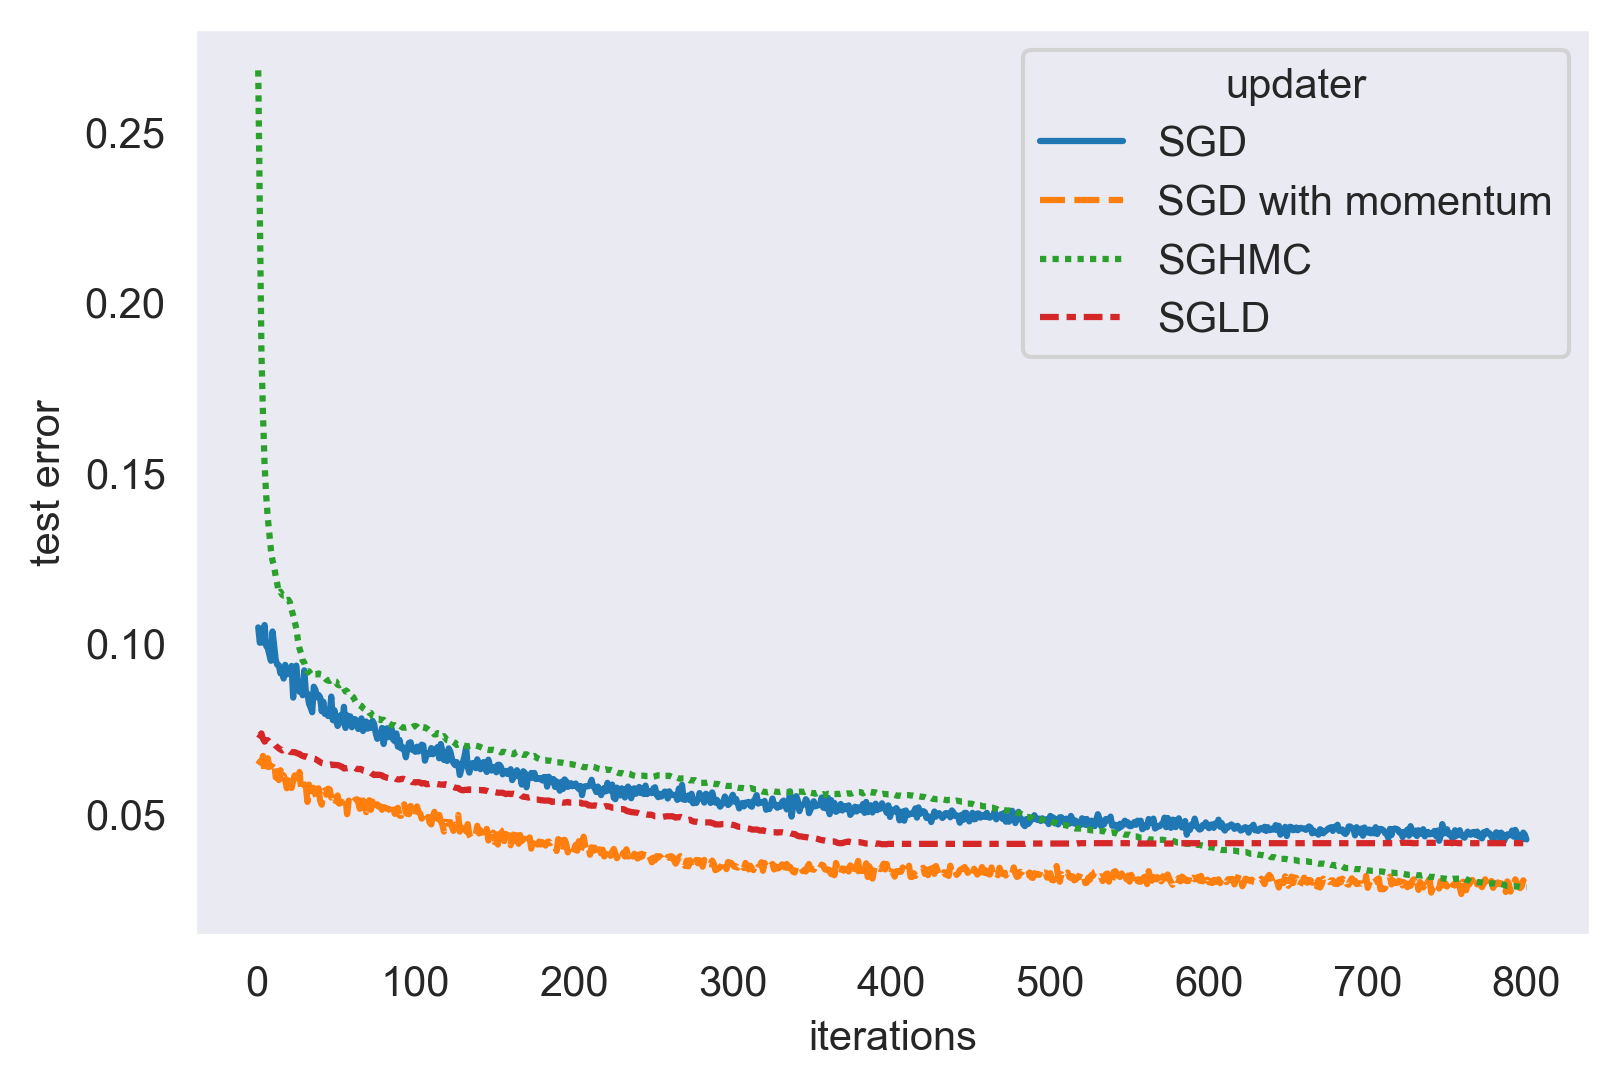

In [16]:
sns.set_style("dark")

# Load the previous results from the files
with open(RESULTS_SGHMC, "r") as f:
    sghmc_test_errs = json.load(f)
with open(RESULTS_SGLD, "r") as f:
    sgld_test_errs = json.load(f)
with open(RESULTS_SGD, "r") as f:
    sgd_test_errs = json.load(f)
with open(RESULTS_SGDMOM, "r") as f:
    sgdmom_test_errs = json.load(f)
    
sghmc_test_errs = np.array(sghmc_test_errs)
sgld_test_errs = np.array(sgld_test_errs)
sgd_test_errs = np.array(sgd_test_errs)
sgdmom_test_errs = np.array(sgdmom_test_errs)

err_dict = {'SGHMC' : sghmc_test_errs, 'SGLD' : sgld_test_errs, 'SGD' : sgd_test_errs, 'SGD with momentum' : sgdmom_test_errs}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, err_dict[updater][i]])

df = pd.DataFrame(lst, columns=['iterations', 'updater','test error'])
sns.lineplot(data=df.pivot("iterations", "updater", "test error"))
plt.ylabel("test error")
plt.show() #dpi=300

### Stochastic Gradient NUTS 
*experimental*

In [ ]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1

WARMUP_EPOCHS = 5 

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sgnuts = SGNUTS(bnn, 
                subsample_positions=[0, 1],
                batch_size=BATCH_SIZE,
                learning_rate=LR, 
                momentum_decay=MOMENTUM_DECAY,
                resample_every_n=RESAMPLE_EVERY_N, 
                obs_info_noise=False, 
                use_multinomial_sampling=True,
                max_tree_depth=10)

# do warm up
sgnuts_mcmc = MCMC(sgnuts, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sgnuts_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sgnuts_samples = sgnuts_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sgnuts_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCH, correct/total, end - start))